In [1]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import rasterio
import geopandas as gpd
from rasterio import features
from shapely.geometry import mapping
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window
import os
import cv2

In [3]:
#paths

tiff_image_path = '/kaggle/input/gis-dataset/chattisgarh_tiff.tif'
road_shapefile_path = '/kaggle/input/gis-dataset/ch_road.shp'
building_shapefile_path = '/kaggle/input/gis-dataset/ch_builtuparea.shp'

Rasterized mask saved to /kaggle/working/road_mask.tif
Rasterized mask saved to /kaggle/working/building_mask.tif


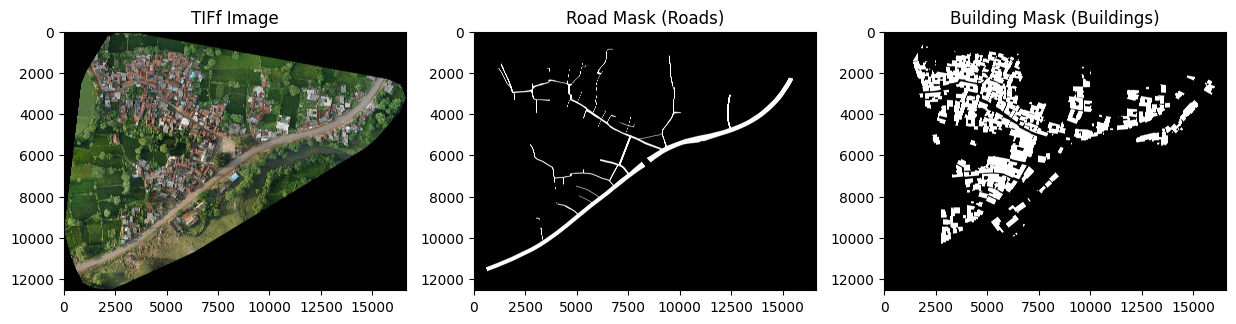

In [4]:
# Function to rasterize a shapefile

def rasterize_shape_file(shapefile_path, reference_raster_path, output_mask_path):
  #convert a shapefile to a tiff file

    shapefile_gdf = gpd.read_file(shapefile_path) # reading the file using geopandas

    with rasterio.open(reference_raster_path) as src:
        #getting the transform and other parameters
        transform = src.transform
        out_shape = (src.height, src.width)

        valid_geometries = [ geom for geom in shapefile_gdf.geometry if geom is not None ]
        rasterized_mask = features.rasterize(
            [ (mapping(geom), 1) for geom in valid_geometries],
            out_shape=out_shape,
            transform=transform,
            fill=0,
            dtype='uint8'
        )

        # Saving the rasterize mask to a new TIFF file
        mask_meta = src.meta.copy()
        mask_meta.update({
            'driver': 'GTiff',
            'count': 1,
            'dtype': 'uint8',
            'height': out_shape[0],
            'width': out_shape[1],
            'transform': transform
        })

        with rasterio.open(output_mask_path, 'w', **mask_meta) as dst:
            dst.write(rasterized_mask, 1)

    print(f"Rasterized mask saved to {output_mask_path}")


# Rastrize the road shapefile
output_road_mask_path = '/kaggle/working/road_mask.tif'
rasterize_shape_file(road_shapefile_path, tiff_image_path, output_road_mask_path)

# Rasterize the buildings shapefile
output_building_mask_path = '/kaggle/working/building_mask.tif'
rasterize_shape_file(building_shapefile_path, tiff_image_path, output_building_mask_path)

  #visualize the original TIFF image and the generated mask
with rasterio.open(tiff_image_path) as img_src:
    tiff_image = img_src.read((1, 2, 3)) # Read RGB bands
    tiff_image = np.transpose(tiff_image, (1, 2, 0)) #(Height, width, channel)

with rasterio.open(output_road_mask_path) as road_mask_src:
    road_mask = road_mask_src.read(1)

with rasterio.open(output_building_mask_path) as building_mask_src:
    building_mask = building_mask_src.read(1)

 #plotting the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(tiff_image)
plt.title("TIFf Image")

plt.subplot(1, 3, 2)
plt.imshow(road_mask, cmap='gray')
plt.title("Road Mask (Roads)")

plt.subplot(1, 3, 3)
plt.imshow(building_mask, cmap='gray')
plt.title("Building Mask (Buildings)")

plt.show()

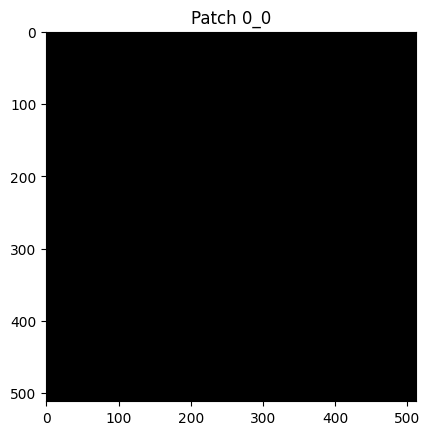

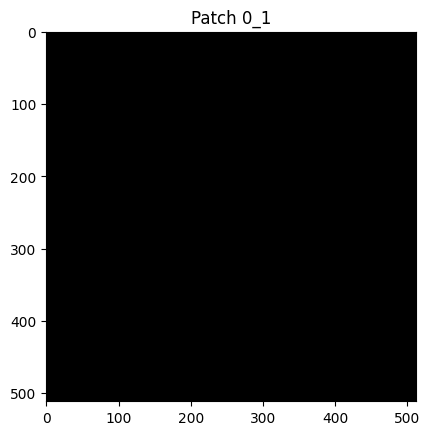

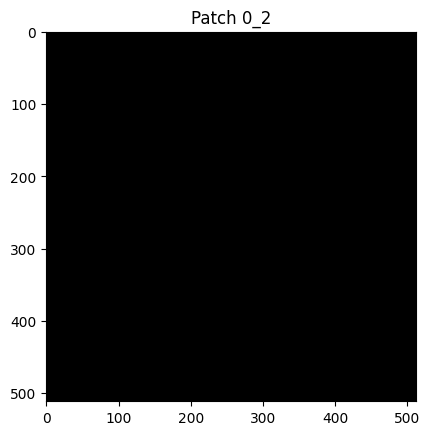

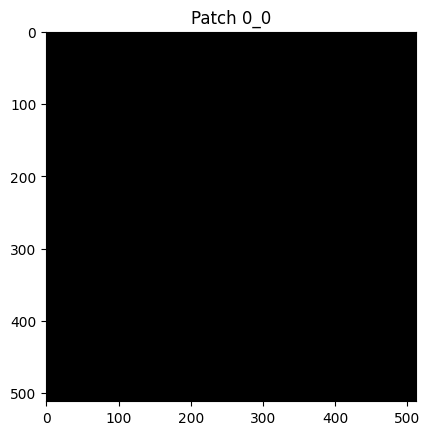

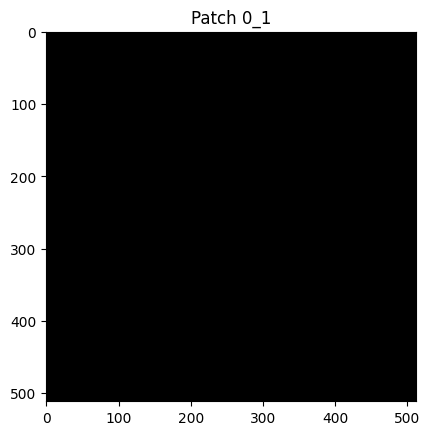

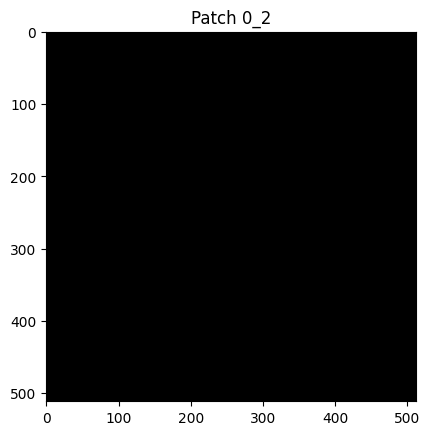

In [5]:
def slice_image(tiff_path, output_dir, patch_size=512):

    #slices a TiFF image into samller images

    with rasterio.open(tiff_path) as src:
        img_array = src.read(1) # Reading single Band
        img_width, img_height = src.width, src.height
        transform = src.transform

        #Determine the number if patches 
        num_patches_x = img_width // patch_size
        num_patches_y = img_height // patch_size

        os.makedirs(output_dir, exist_ok=True)

        for i in  range(num_patches_x):
            for j in range(num_patches_y):
                window = Window(i*patch_size, j*patch_size, patch_size, patch_size)

                #Read the window and write to a new file  
                patch = src.read(1, window=window)
                patch_meta = src.meta.copy()
                patch_meta.update({
                    "height": patch_size,
                    "width": patch_size,
                    "transform": rasterio.windows.transform(window, transform)
                })

                patch_filename = os.path.join(output_dir, f"patch_{i}_{j}.tif")
                with rasterio.open(patch_filename, 'w' , **patch_meta) as dst:
                    dst.write(patch, 1)


                #visualize a few patches
                if i == 0 and j < 3:
                    plt.figure()
                    plt.imshow(patch , cmap='gray')
                    plt.title(f"Patch {i}_{j}")
                    plt.show()

#Usage
slice_image('/kaggle/working/building_mask.tif', '/kaggle/working/patches/buildings')
slice_image('/kaggle/working/road_mask.tif', '/kaggle/working/patches/roads')                
        

In [12]:
#### Fixed Upsmpling issue nowupsamples to 512x512

# Import additional required libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

# ResUNet Architecture Components
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

class IdentityBlock(nn.Module):
    def __init__(self, channels):
        super(IdentityBlock, self).__init__()
        self.conv1 = ConvBlock(channels, channels)
        self.conv2 = ConvBlock(channels, channels)
        self.conv3 = ConvBlock(channels, channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        return out + identity

class ResUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(ResUNet, self).__init__()
        
        # Initial layer now outputs 64 channels to match first decoder block
        self.initial_conv = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.initial_bn = nn.BatchNorm2d(64)
        self.initial_activation = nn.ReLU()
        self.initial_maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.encoder_block1 = self._make_encoder_block(64, 64, num_repeats=3)
        self.encoder_block2 = self._make_encoder_block(64, 128, num_repeats=4)
        self.encoder_block3 = self._make_encoder_block(128, 256, num_repeats=6)
        self.encoder_block4 = self._make_encoder_block(256, 512, num_repeats=3)
        
        self.decoder_block4 = self._make_decoder_block(512, 256)
        self.decoder_block3 = self._make_decoder_block(256, 128)
        self.decoder_block2 = self._make_decoder_block(128, 64)
        self.decoder_block1 = self._make_decoder_block(64, 64)  # Keep same channel count
        self.decoder_block0 = self._make_decoder_block(64, 64)
        self.decoder_block_out = self._make_decoder_block(64, 64)

        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.final_activation = nn.Sigmoid()

    def _make_encoder_block(self, in_channels, out_channels, num_repeats):
        layers = []
        layers.append(ConvBlock(in_channels, out_channels, stride=2))
        for _ in range(num_repeats - 1):
            layers.append(IdentityBlock(out_channels))
        return nn.Sequential(*layers)

    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            ConvBlock(out_channels, out_channels),
            IdentityBlock(out_channels)
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.initial_activation(x)
        x0 = self.initial_maxpool(x)
        
        x1 = self.encoder_block1(x0)
        x2 = self.encoder_block2(x1)
        x3 = self.encoder_block3(x2)
        x4 = self.encoder_block4(x3)
        
        x = self.decoder_block4(x4) + x3
        x = self.decoder_block3(x) + x2
        x = self.decoder_block2(x) + x1
        x = self.decoder_block1(x) + x0
        x = self.decoder_block0(x)
        x = self.decoder_block_out(x)
        
        x = self.final_conv(x)
        x = self.final_activation(x)
        
        return x

# Improved patch creation function for both image and mask
def create_patches(image_path, mask_path, output_dir, patch_size=512):
    """Create patches from image and mask with proper RGB handling"""
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'masks'), exist_ok=True)
    
    print(f"Creating patches for {mask_path}...")
    with rasterio.open(image_path) as img_src, rasterio.open(mask_path) as mask_src:
        # Read RGB bands
        img_data = img_src.read((1,2,3))
        mask_data = mask_src.read(1)
        
        # Normalize image data
        img_data = img_data.astype(np.float32) / 255.0
        
        height, width = img_src.height, img_src.width
        patches_created = 0
        
        for i in range(0, width - patch_size + 1, patch_size):
            for j in range(0, height - patch_size + 1, patch_size):
                # Extract patches
                image_patch = img_data[:, j:j+patch_size, i:i+patch_size]
                mask_patch = mask_data[j:j+patch_size, i:i+patch_size]
                
                # Verify patch size and content
                if (image_patch.shape[1:] == (patch_size, patch_size) and 
                    mask_patch.shape == (patch_size, patch_size) and 
                    np.any(mask_patch > 0)):  # Only save patches with features
                    
                    patch_name = f"patch_{i}_{j}"
                    np.save(os.path.join(output_dir, 'images', f"{patch_name}.npy"), image_patch)
                    np.save(os.path.join(output_dir, 'masks', f"{patch_name}.npy"), mask_patch)
                    patches_created += 1
        
        print(f"Created {patches_created} valid patches")

# Custom Dataset for GIS data
class GISDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.image_dir = os.path.join(data_dir, 'images')
        self.mask_dir = os.path.join(data_dir, 'masks')
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.npy')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.image_files[idx])
        
        # Load and prepare image
        image = np.load(img_path)
        mask = np.load(mask_path)
        
        # Ensure correct dimensions and types
        image = image.astype(np.float32)  # [3, 512, 512]
        mask = mask.astype(np.float32)    # [512, 512]
        
        # Convert to torch tensors
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dimension
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask

# Custom loss function for segmentation
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        tp = (inputs * targets).sum()
        fp = ((1 - targets) * inputs).sum()
        fn = (targets * (1 - inputs)).sum()
        
        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky



In [13]:
from torchsummary import summary

model = ResUNet(in_channels=3, out_channels=1).to("cuda" if torch.cuda.is_available() else "cpu")
summary(model, input_size=(3, 512, 512))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         ConvBlock-4         [-1, 64, 256, 256]               0
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
        ConvBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [17]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for inputs, targets in pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Debug print
                print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
                
                optimizer.zero_grad()
                outputs = model(inputs)
                
                # Debug print
                print(f"Output shape: {outputs.shape}, Target shape: {targets.shape}")
                
                # If shapes don't match, resize targets to match outputs
                if outputs.shape != targets.shape:
                    targets = F.interpolate(targets, size=(outputs.shape[2], outputs.shape[3]), mode='nearest')
                    print(f"Resized target shape: {targets.shape}")
                
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})
# Function to combine road and building predictions
def predict_and_combine(road_model, building_model, image_path, device, patch_size=512):
    """
    Make predictions for both roads and buildings and combine them into a single image
    Roads will be shown in blue, buildings in red
    """
    road_model.eval()
    building_model.eval()
    
    with rasterio.open(image_path) as src:
        # Read RGB bands and normalize
        image = src.read((1,2,3))
        image = image.astype(np.float32) / 255.0
        height, width = src.height, src.width
        
        # Initialize output masks
        road_mask = np.zeros((height, width))
        building_mask = np.zeros((height, width))
        
        # Make predictions patch by patch
        for i in tqdm(range(0, width - patch_size + 1, patch_size)):
            for j in range(0, height - patch_size + 1, patch_size):
                # Extract patch
                patch = image[:, j:j+patch_size, i:i+patch_size]
                patch_tensor = torch.from_numpy(patch).unsqueeze(0).to(device)
                
                # Predict roads and buildings
                with torch.no_grad():
                    road_pred = road_model(patch_tensor)
                    building_pred = building_model(patch_tensor)
                
                # Convert predictions to numpy and threshold
                road_pred = (road_pred.cpu().squeeze().numpy() > 0.5).astype(np.uint8)
                building_pred = (building_pred.cpu().squeeze().numpy() > 0.5).astype(np.uint8)
                
                # Add to full masks
                road_mask[j:j+patch_size, i:i+patch_size] = road_pred
                building_mask[j:j+patch_size, i:i+patch_size] = building_pred
        
        # Create RGB mask (Red for buildings, Blue for roads)
        combined_mask = np.zeros((height, width, 3), dtype=np.uint8)
        combined_mask[..., 2] = road_mask * 255      # Blue channel for roads
        combined_mask[..., 0] = building_mask * 255  # Red channel for buildings
        
        # Save the combined prediction
        output_path = '/kaggle/working/combined_prediction.tif'
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=3,
            dtype='uint8',
            crs=src.crs,
            transform=src.transform,
        ) as dst:
            dst.write(combined_mask.transpose(2, 0, 1))
        
        return combined_mask


Step 1: Creating patches for training...
Creating patches for /kaggle/working/road_mask.tif...
Created 173 valid patches
Creating patches for /kaggle/working/building_mask.tif...
Created 259 valid patches

Step 2: Setting up data loaders...

Step 3: Training road detection model...
Using device: cuda


Epoch 1/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   1%|          | 1/87 [00:00<00:37,  2.29it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   2%|▏         | 2/87 [00:00<00:28,  2.95it/s, loss=0.933]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   3%|▎         | 3/87 [00:00<00:25,  3.25it/s, loss=0.624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   5%|▍         | 4/87 [00:01<00:24,  3.39it/s, loss=0.915]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   6%|▌         | 5/87 [00:01<00:23,  3.48it/s, loss=0.863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   7%|▋         | 6/87 [00:01<00:22,  3.53it/s, loss=0.737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   8%|▊         | 7/87 [00:02<00:22,  3.58it/s, loss=0.964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   9%|▉         | 8/87 [00:02<00:21,  3.62it/s, loss=0.84] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  10%|█         | 9/87 [00:02<00:21,  3.64it/s, loss=0.715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  11%|█▏        | 10/87 [00:02<00:21,  3.63it/s, loss=0.768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  13%|█▎        | 11/87 [00:03<00:20,  3.64it/s, loss=0.583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  14%|█▍        | 12/87 [00:03<00:20,  3.64it/s, loss=0.556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  15%|█▍        | 13/87 [00:03<00:20,  3.64it/s, loss=0.953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  16%|█▌        | 14/87 [00:03<00:20,  3.63it/s, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  17%|█▋        | 15/87 [00:04<00:19,  3.64it/s, loss=0.765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  18%|█▊        | 16/87 [00:04<00:19,  3.63it/s, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  20%|█▉        | 17/87 [00:04<00:19,  3.65it/s, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  21%|██        | 18/87 [00:05<00:19,  3.63it/s, loss=0.887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  22%|██▏       | 19/87 [00:05<00:18,  3.66it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  23%|██▎       | 20/87 [00:05<00:18,  3.64it/s, loss=0.967]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  24%|██▍       | 21/87 [00:05<00:18,  3.64it/s, loss=0.766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  25%|██▌       | 22/87 [00:06<00:17,  3.64it/s, loss=0.717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  26%|██▋       | 23/87 [00:06<00:17,  3.64it/s, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  28%|██▊       | 24/87 [00:06<00:17,  3.64it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  29%|██▊       | 25/87 [00:07<00:17,  3.63it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  30%|██▉       | 26/87 [00:07<00:16,  3.64it/s, loss=0.524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  31%|███       | 27/87 [00:07<00:16,  3.63it/s, loss=0.681]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  32%|███▏      | 28/87 [00:07<00:16,  3.62it/s, loss=0.532]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  33%|███▎      | 29/87 [00:08<00:16,  3.60it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  34%|███▍      | 30/87 [00:08<00:15,  3.61it/s, loss=0.945]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  36%|███▌      | 31/87 [00:08<00:15,  3.61it/s, loss=0.747]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  37%|███▋      | 32/87 [00:08<00:15,  3.60it/s, loss=0.719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  38%|███▊      | 33/87 [00:09<00:15,  3.59it/s, loss=0.591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  39%|███▉      | 34/87 [00:09<00:14,  3.57it/s, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  41%|████▏     | 36/87 [00:10<00:14,  3.59it/s, loss=0.698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  43%|████▎     | 37/87 [00:10<00:13,  3.58it/s, loss=0.966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  44%|████▎     | 38/87 [00:10<00:13,  3.56it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  45%|████▍     | 39/87 [00:10<00:13,  3.56it/s, loss=0.755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  46%|████▌     | 40/87 [00:11<00:13,  3.56it/s, loss=0.99] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  47%|████▋     | 41/87 [00:11<00:12,  3.56it/s, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  48%|████▊     | 42/87 [00:11<00:12,  3.55it/s, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  49%|████▉     | 43/87 [00:12<00:12,  3.57it/s, loss=0.17]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  51%|█████     | 44/87 [00:12<00:12,  3.56it/s, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.54it/s, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.52it/s, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.51it/s, loss=0.918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  55%|█████▌    | 48/87 [00:13<00:11,  3.50it/s, loss=0.733]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.51it/s, loss=0.798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.50it/s, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.50it/s, loss=0.497]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  60%|█████▉    | 52/87 [00:14<00:10,  3.48it/s, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  61%|██████    | 53/87 [00:14<00:09,  3.49it/s, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.49it/s, loss=0.583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  63%|██████▎   | 55/87 [00:15<00:09,  3.49it/s, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.50it/s, loss=0.645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.50it/s, loss=0.803]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.49it/s, loss=0.662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  68%|██████▊   | 59/87 [00:16<00:08,  3.48it/s, loss=0.916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.48it/s, loss=0.96] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  70%|███████   | 61/87 [00:17<00:07,  3.48it/s, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.46it/s, loss=0.942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.47it/s, loss=0.541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.47it/s, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.47it/s, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  76%|███████▌  | 66/87 [00:18<00:06,  3.47it/s, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.45it/s, loss=0.578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.45it/s, loss=0.952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.44it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  80%|████████  | 70/87 [00:19<00:04,  3.42it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.41it/s, loss=0.885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.41it/s, loss=0.957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  84%|████████▍ | 73/87 [00:20<00:04,  3.41it/s, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.41it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.41it/s, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.41it/s, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.40it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.39it/s, loss=0.952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  91%|█████████ | 79/87 [00:22<00:02,  3.39it/s, loss=0.677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  92%|█████████▏| 80/87 [00:22<00:02,  3.38it/s, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  93%|█████████▎| 81/87 [00:23<00:01,  3.38it/s, loss=0.833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.38it/s, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.37it/s, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.37it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  98%|█████████▊| 85/87 [00:24<00:00,  3.36it/s, loss=0.633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50: 100%|██████████| 87/87 [00:24<00:00,  3.90it/s, loss=0.936]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 2/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   1%|          | 1/87 [00:00<00:36,  2.36it/s, loss=0.865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   2%|▏         | 2/87 [00:00<00:29,  2.85it/s, loss=0.915]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   3%|▎         | 3/87 [00:01<00:27,  3.04it/s, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   5%|▍         | 4/87 [00:01<00:26,  3.14it/s, loss=0.883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   6%|▌         | 5/87 [00:01<00:25,  3.19it/s, loss=0.954]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   7%|▋         | 6/87 [00:01<00:25,  3.23it/s, loss=0.645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   8%|▊         | 7/87 [00:02<00:24,  3.25it/s, loss=0.755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   9%|▉         | 8/87 [00:02<00:24,  3.26it/s, loss=0.653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  10%|█         | 9/87 [00:02<00:23,  3.27it/s, loss=0.667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  11%|█▏        | 10/87 [00:03<00:23,  3.27it/s, loss=0.33]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  13%|█▎        | 11/87 [00:03<00:23,  3.29it/s, loss=0.596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  14%|█▍        | 12/87 [00:03<00:22,  3.28it/s, loss=0.645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  15%|█▍        | 13/87 [00:04<00:22,  3.29it/s, loss=0.979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  16%|█▌        | 14/87 [00:04<00:22,  3.29it/s, loss=0.651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  17%|█▋        | 15/87 [00:04<00:21,  3.29it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  18%|█▊        | 16/87 [00:04<00:21,  3.30it/s, loss=0.6]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  20%|█▉        | 17/87 [00:05<00:21,  3.30it/s, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  21%|██        | 18/87 [00:05<00:20,  3.30it/s, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  22%|██▏       | 19/87 [00:05<00:20,  3.31it/s, loss=0.964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  23%|██▎       | 20/87 [00:06<00:20,  3.31it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  24%|██▍       | 21/87 [00:06<00:19,  3.32it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  25%|██▌       | 22/87 [00:06<00:19,  3.33it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  26%|██▋       | 23/87 [00:07<00:19,  3.34it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  28%|██▊       | 24/87 [00:07<00:18,  3.34it/s, loss=0.0801]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  29%|██▊       | 25/87 [00:07<00:18,  3.33it/s, loss=0.712] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  30%|██▉       | 26/87 [00:07<00:18,  3.32it/s, loss=0.77] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  31%|███       | 27/87 [00:08<00:18,  3.32it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  32%|███▏      | 28/87 [00:08<00:17,  3.32it/s, loss=0.462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  33%|███▎      | 29/87 [00:08<00:17,  3.33it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  34%|███▍      | 30/87 [00:09<00:17,  3.35it/s, loss=0.878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  36%|███▌      | 31/87 [00:09<00:16,  3.35it/s, loss=0.792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  37%|███▋      | 32/87 [00:09<00:16,  3.35it/s, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  38%|███▊      | 33/87 [00:10<00:16,  3.36it/s, loss=0.679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  39%|███▉      | 34/87 [00:10<00:15,  3.36it/s, loss=0.924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  40%|████      | 35/87 [00:10<00:15,  3.36it/s, loss=0.801]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  41%|████▏     | 36/87 [00:10<00:15,  3.37it/s, loss=0.799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  43%|████▎     | 37/87 [00:11<00:14,  3.38it/s, loss=0.592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  44%|████▎     | 38/87 [00:11<00:14,  3.39it/s, loss=0.788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  45%|████▍     | 39/87 [00:11<00:14,  3.41it/s, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  46%|████▌     | 40/87 [00:12<00:13,  3.42it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  47%|████▋     | 41/87 [00:12<00:13,  3.43it/s, loss=0.685]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  48%|████▊     | 42/87 [00:12<00:13,  3.42it/s, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  49%|████▉     | 43/87 [00:12<00:12,  3.44it/s, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  51%|█████     | 44/87 [00:13<00:12,  3.44it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  52%|█████▏    | 45/87 [00:13<00:12,  3.45it/s, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.46it/s, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  54%|█████▍    | 47/87 [00:14<00:11,  3.47it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  55%|█████▌    | 48/87 [00:14<00:11,  3.46it/s, loss=0.545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  56%|█████▋    | 49/87 [00:14<00:10,  3.46it/s, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  57%|█████▋    | 50/87 [00:15<00:10,  3.47it/s, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  59%|█████▊    | 51/87 [00:15<00:10,  3.48it/s, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  60%|█████▉    | 52/87 [00:15<00:10,  3.48it/s, loss=0.451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  61%|██████    | 53/87 [00:15<00:09,  3.49it/s, loss=0.677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  62%|██████▏   | 54/87 [00:16<00:09,  3.48it/s, loss=0.619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  63%|██████▎   | 55/87 [00:16<00:09,  3.48it/s, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  64%|██████▍   | 56/87 [00:16<00:08,  3.48it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  66%|██████▌   | 57/87 [00:17<00:08,  3.50it/s, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  67%|██████▋   | 58/87 [00:17<00:08,  3.52it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  68%|██████▊   | 59/87 [00:17<00:07,  3.53it/s, loss=0.665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  69%|██████▉   | 60/87 [00:17<00:07,  3.53it/s, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  70%|███████   | 61/87 [00:18<00:07,  3.54it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  71%|███████▏  | 62/87 [00:18<00:07,  3.54it/s, loss=0.468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  72%|███████▏  | 63/87 [00:18<00:06,  3.54it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.54it/s, loss=0.689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  75%|███████▍  | 65/87 [00:19<00:06,  3.53it/s, loss=0.801]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  76%|███████▌  | 66/87 [00:19<00:05,  3.54it/s, loss=0.883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  77%|███████▋  | 67/87 [00:19<00:05,  3.54it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  78%|███████▊  | 68/87 [00:20<00:05,  3.55it/s, loss=0.646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  79%|███████▉  | 69/87 [00:20<00:05,  3.57it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  80%|████████  | 70/87 [00:20<00:04,  3.57it/s, loss=0.97] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.57it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  83%|████████▎ | 72/87 [00:21<00:04,  3.57it/s, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  84%|████████▍ | 73/87 [00:21<00:03,  3.57it/s, loss=0.807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  85%|████████▌ | 74/87 [00:21<00:03,  3.55it/s, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  86%|████████▌ | 75/87 [00:22<00:03,  3.55it/s, loss=0.651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  87%|████████▋ | 76/87 [00:22<00:03,  3.56it/s, loss=0.0935]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  89%|████████▊ | 77/87 [00:22<00:02,  3.59it/s, loss=0.264] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.59it/s, loss=0.899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  91%|█████████ | 79/87 [00:23<00:02,  3.59it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  92%|█████████▏| 80/87 [00:23<00:01,  3.60it/s, loss=0.473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  93%|█████████▎| 81/87 [00:23<00:01,  3.60it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  94%|█████████▍| 82/87 [00:24<00:01,  3.59it/s, loss=0.751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  95%|█████████▌| 83/87 [00:24<00:01,  3.59it/s, loss=0.726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  97%|█████████▋| 84/87 [00:24<00:00,  3.61it/s, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  98%|█████████▊| 85/87 [00:24<00:00,  3.62it/s, loss=0.564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50: 100%|██████████| 87/87 [00:25<00:00,  4.19it/s, loss=0.481]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 3/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   1%|          | 1/87 [00:00<00:34,  2.52it/s, loss=0.496]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   2%|▏         | 2/87 [00:00<00:27,  3.04it/s, loss=0.961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   3%|▎         | 3/87 [00:00<00:25,  3.31it/s, loss=0.958]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   5%|▍         | 4/87 [00:01<00:24,  3.41it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   6%|▌         | 5/87 [00:01<00:23,  3.48it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   7%|▋         | 6/87 [00:01<00:23,  3.51it/s, loss=0.778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   8%|▊         | 7/87 [00:02<00:22,  3.56it/s, loss=0.836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   9%|▉         | 8/87 [00:02<00:22,  3.58it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  10%|█         | 9/87 [00:02<00:21,  3.61it/s, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  11%|█▏        | 10/87 [00:02<00:21,  3.60it/s, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  13%|█▎        | 11/87 [00:03<00:20,  3.63it/s, loss=0.614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  14%|█▍        | 12/87 [00:03<00:20,  3.62it/s, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  15%|█▍        | 13/87 [00:03<00:20,  3.63it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  16%|█▌        | 14/87 [00:03<00:20,  3.64it/s, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  17%|█▋        | 15/87 [00:04<00:19,  3.65it/s, loss=0.713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  18%|█▊        | 16/87 [00:04<00:19,  3.64it/s, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  20%|█▉        | 17/87 [00:04<00:19,  3.64it/s, loss=0.666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  21%|██        | 18/87 [00:05<00:18,  3.66it/s, loss=0.446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  22%|██▏       | 19/87 [00:05<00:18,  3.67it/s, loss=0.9]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  23%|██▎       | 20/87 [00:05<00:18,  3.67it/s, loss=0.687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  24%|██▍       | 21/87 [00:05<00:17,  3.68it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  25%|██▌       | 22/87 [00:06<00:17,  3.69it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  26%|██▋       | 23/87 [00:06<00:17,  3.69it/s, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  28%|██▊       | 24/87 [00:06<00:17,  3.68it/s, loss=0.958]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  29%|██▊       | 25/87 [00:06<00:16,  3.68it/s, loss=0.857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  30%|██▉       | 26/87 [00:07<00:16,  3.69it/s, loss=0.833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  31%|███       | 27/87 [00:07<00:16,  3.68it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  32%|███▏      | 28/87 [00:07<00:15,  3.69it/s, loss=0.719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  33%|███▎      | 29/87 [00:08<00:15,  3.69it/s, loss=0.85] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  34%|███▍      | 30/87 [00:08<00:15,  3.68it/s, loss=0.931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  36%|███▌      | 31/87 [00:08<00:15,  3.69it/s, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  37%|███▋      | 32/87 [00:08<00:14,  3.70it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  38%|███▊      | 33/87 [00:09<00:14,  3.68it/s, loss=0.476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  39%|███▉      | 34/87 [00:09<00:14,  3.68it/s, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  40%|████      | 35/87 [00:09<00:14,  3.67it/s, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  41%|████▏     | 36/87 [00:09<00:13,  3.67it/s, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  43%|████▎     | 37/87 [00:10<00:13,  3.68it/s, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  44%|████▎     | 38/87 [00:10<00:13,  3.69it/s, loss=0.681]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  45%|████▍     | 39/87 [00:10<00:13,  3.68it/s, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  46%|████▌     | 40/87 [00:11<00:12,  3.69it/s, loss=0.912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  47%|████▋     | 41/87 [00:11<00:12,  3.71it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  48%|████▊     | 42/87 [00:11<00:12,  3.70it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  49%|████▉     | 43/87 [00:11<00:11,  3.69it/s, loss=0.986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  51%|█████     | 44/87 [00:12<00:11,  3.68it/s, loss=0.891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.67it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.67it/s, loss=0.548]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  54%|█████▍    | 47/87 [00:12<00:10,  3.65it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.67it/s, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.68it/s, loss=0.524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  57%|█████▋    | 50/87 [00:13<00:10,  3.70it/s, loss=0.799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  59%|█████▊    | 51/87 [00:14<00:09,  3.70it/s, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.70it/s, loss=0.801]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  61%|██████    | 53/87 [00:14<00:09,  3.68it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  62%|██████▏   | 54/87 [00:14<00:08,  3.69it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.68it/s, loss=0.723]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.67it/s, loss=0.844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  66%|██████▌   | 57/87 [00:15<00:08,  3.66it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  67%|██████▋   | 58/87 [00:15<00:07,  3.67it/s, loss=0.99] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.67it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.69it/s, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  70%|███████   | 61/87 [00:16<00:07,  3.68it/s, loss=0.443]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.70it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.71it/s, loss=0.651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.70it/s, loss=0.728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  75%|███████▍  | 65/87 [00:17<00:05,  3.70it/s, loss=0.555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.70it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.70it/s, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  78%|███████▊  | 68/87 [00:18<00:05,  3.69it/s, loss=0.634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  79%|███████▉  | 69/87 [00:18<00:04,  3.69it/s, loss=0.468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  80%|████████  | 70/87 [00:19<00:04,  3.71it/s, loss=0.483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.71it/s, loss=0.449]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  83%|████████▎ | 72/87 [00:19<00:04,  3.69it/s, loss=0.598]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  84%|████████▍ | 73/87 [00:19<00:03,  3.68it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.69it/s, loss=0.787]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  86%|████████▌ | 75/87 [00:20<00:03,  3.68it/s, loss=0.734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  87%|████████▋ | 76/87 [00:20<00:02,  3.68it/s, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.69it/s, loss=0.536]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.71it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  91%|█████████ | 79/87 [00:21<00:02,  3.71it/s, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  92%|█████████▏| 80/87 [00:21<00:01,  3.69it/s, loss=0.918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.71it/s, loss=0.438]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  94%|█████████▍| 82/87 [00:22<00:01,  3.71it/s, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  95%|█████████▌| 83/87 [00:22<00:01,  3.70it/s, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  97%|█████████▋| 84/87 [00:22<00:00,  3.71it/s, loss=0.72] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.71it/s, loss=0.724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50: 100%|██████████| 87/87 [00:23<00:00,  4.29it/s, loss=0.592]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 4/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   1%|          | 1/87 [00:00<00:34,  2.52it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   2%|▏         | 2/87 [00:00<00:27,  3.07it/s, loss=0.726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   3%|▎         | 3/87 [00:00<00:25,  3.34it/s, loss=0.883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   5%|▍         | 4/87 [00:01<00:24,  3.45it/s, loss=0.741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   6%|▌         | 5/87 [00:01<00:23,  3.53it/s, loss=0.887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   7%|▋         | 6/87 [00:01<00:22,  3.59it/s, loss=0.755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   8%|▊         | 7/87 [00:02<00:22,  3.64it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   9%|▉         | 8/87 [00:02<00:21,  3.65it/s, loss=0.882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  10%|█         | 9/87 [00:02<00:21,  3.67it/s, loss=0.897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  11%|█▏        | 10/87 [00:02<00:21,  3.66it/s, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  13%|█▎        | 11/87 [00:03<00:20,  3.68it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  14%|█▍        | 12/87 [00:03<00:20,  3.66it/s, loss=0.843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  15%|█▍        | 13/87 [00:03<00:20,  3.67it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  16%|█▌        | 14/87 [00:03<00:19,  3.67it/s, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  17%|█▋        | 15/87 [00:04<00:19,  3.64it/s, loss=0.942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  18%|█▊        | 16/87 [00:04<00:19,  3.65it/s, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  20%|█▉        | 17/87 [00:04<00:19,  3.65it/s, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  21%|██        | 18/87 [00:05<00:18,  3.66it/s, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  22%|██▏       | 19/87 [00:05<00:18,  3.68it/s, loss=0.966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  23%|██▎       | 20/87 [00:05<00:18,  3.67it/s, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  24%|██▍       | 21/87 [00:05<00:17,  3.68it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  25%|██▌       | 22/87 [00:06<00:17,  3.67it/s, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  26%|██▋       | 23/87 [00:06<00:17,  3.66it/s, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  28%|██▊       | 24/87 [00:06<00:17,  3.66it/s, loss=0.939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  29%|██▊       | 25/87 [00:06<00:16,  3.66it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  30%|██▉       | 26/87 [00:07<00:16,  3.66it/s, loss=0.924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  31%|███       | 27/87 [00:07<00:16,  3.66it/s, loss=0.965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  32%|███▏      | 28/87 [00:07<00:16,  3.66it/s, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  33%|███▎      | 29/87 [00:08<00:15,  3.67it/s, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  34%|███▍      | 30/87 [00:08<00:15,  3.67it/s, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  36%|███▌      | 31/87 [00:08<00:15,  3.68it/s, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  37%|███▋      | 32/87 [00:08<00:15,  3.66it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  38%|███▊      | 33/87 [00:09<00:14,  3.67it/s, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  39%|███▉      | 34/87 [00:09<00:14,  3.65it/s, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  40%|████      | 35/87 [00:09<00:14,  3.66it/s, loss=0.65] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  41%|████▏     | 36/87 [00:09<00:13,  3.65it/s, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  43%|████▎     | 37/87 [00:10<00:13,  3.63it/s, loss=0.732]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  44%|████▎     | 38/87 [00:10<00:13,  3.64it/s, loss=0.507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  45%|████▍     | 39/87 [00:10<00:13,  3.64it/s, loss=0.974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  46%|████▌     | 40/87 [00:11<00:12,  3.65it/s, loss=0.481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  47%|████▋     | 41/87 [00:11<00:12,  3.65it/s, loss=0.676]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  48%|████▊     | 42/87 [00:11<00:12,  3.65it/s, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  49%|████▉     | 43/87 [00:11<00:12,  3.64it/s, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  51%|█████     | 44/87 [00:12<00:11,  3.65it/s, loss=0.772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.64it/s, loss=0.893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.62it/s, loss=0.763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  54%|█████▍    | 47/87 [00:12<00:11,  3.63it/s, loss=0.951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.64it/s, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.65it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  57%|█████▋    | 50/87 [00:13<00:10,  3.65it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  59%|█████▊    | 51/87 [00:14<00:09,  3.65it/s, loss=0.886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.64it/s, loss=0.569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  61%|██████    | 53/87 [00:14<00:09,  3.63it/s, loss=0.932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  62%|██████▏   | 54/87 [00:14<00:09,  3.62it/s, loss=0.751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.62it/s, loss=0.0858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.62it/s, loss=0.44]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  66%|██████▌   | 57/87 [00:15<00:08,  3.61it/s, loss=0.591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  67%|██████▋   | 58/87 [00:15<00:08,  3.62it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.61it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.61it/s, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  70%|███████   | 61/87 [00:16<00:07,  3.61it/s, loss=0.522]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.61it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.59it/s, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.60it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  75%|███████▍  | 65/87 [00:17<00:06,  3.61it/s, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.60it/s, loss=0.64] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.60it/s, loss=0.0909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  78%|███████▊  | 68/87 [00:18<00:05,  3.60it/s, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=0.965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  80%|████████  | 70/87 [00:19<00:04,  3.58it/s, loss=0.986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.58it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  83%|████████▎ | 72/87 [00:19<00:04,  3.58it/s, loss=0.851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.58it/s, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  86%|████████▌ | 75/87 [00:20<00:03,  3.57it/s, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.57it/s, loss=0.686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.59it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.59it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  91%|█████████ | 79/87 [00:21<00:02,  3.56it/s, loss=0.0774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.55it/s, loss=0.996] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.55it/s, loss=0.718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  94%|█████████▍| 82/87 [00:22<00:01,  3.56it/s, loss=0.769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  95%|█████████▌| 83/87 [00:22<00:01,  3.56it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.56it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.56it/s, loss=0.805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50: 100%|██████████| 87/87 [00:23<00:00,  4.14it/s, loss=0.271]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 5/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   1%|          | 1/87 [00:00<00:34,  2.49it/s, loss=0.9]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   2%|▏         | 2/87 [00:00<00:28,  3.00it/s, loss=0.857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   3%|▎         | 3/87 [00:00<00:25,  3.24it/s, loss=0.97] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   5%|▍         | 4/87 [00:01<00:24,  3.35it/s, loss=0.959]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   6%|▌         | 5/87 [00:01<00:24,  3.41it/s, loss=0.657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   7%|▋         | 6/87 [00:01<00:23,  3.45it/s, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   8%|▊         | 7/87 [00:02<00:22,  3.49it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   9%|▉         | 8/87 [00:02<00:22,  3.50it/s, loss=0.62] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  10%|█         | 9/87 [00:02<00:22,  3.50it/s, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  11%|█▏        | 10/87 [00:02<00:21,  3.51it/s, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  13%|█▎        | 11/87 [00:03<00:21,  3.51it/s, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  14%|█▍        | 12/87 [00:03<00:21,  3.52it/s, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  15%|█▍        | 13/87 [00:03<00:21,  3.52it/s, loss=0.83] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  16%|█▌        | 14/87 [00:04<00:20,  3.52it/s, loss=0.716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  17%|█▋        | 15/87 [00:04<00:20,  3.53it/s, loss=0.976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  18%|█▊        | 16/87 [00:04<00:20,  3.53it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  20%|█▉        | 17/87 [00:04<00:19,  3.54it/s, loss=0.483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  21%|██        | 18/87 [00:05<00:19,  3.53it/s, loss=0.619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  22%|██▏       | 19/87 [00:05<00:19,  3.54it/s, loss=0.99] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  23%|██▎       | 20/87 [00:05<00:18,  3.55it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  24%|██▍       | 21/87 [00:06<00:18,  3.54it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  25%|██▌       | 22/87 [00:06<00:18,  3.53it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  26%|██▋       | 23/87 [00:06<00:18,  3.53it/s, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  28%|██▊       | 24/87 [00:06<00:17,  3.52it/s, loss=0.452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  29%|██▊       | 25/87 [00:07<00:17,  3.52it/s, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  30%|██▉       | 26/87 [00:07<00:17,  3.52it/s, loss=0.545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  31%|███       | 27/87 [00:07<00:17,  3.50it/s, loss=0.887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  32%|███▏      | 28/87 [00:08<00:16,  3.52it/s, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  33%|███▎      | 29/87 [00:08<00:16,  3.53it/s, loss=0.884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  34%|███▍      | 30/87 [00:08<00:16,  3.53it/s, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  36%|███▌      | 31/87 [00:08<00:15,  3.52it/s, loss=0.624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  37%|███▋      | 32/87 [00:09<00:15,  3.53it/s, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  38%|███▊      | 33/87 [00:09<00:15,  3.52it/s, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  39%|███▉      | 34/87 [00:09<00:15,  3.52it/s, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  40%|████      | 35/87 [00:10<00:14,  3.52it/s, loss=0.73] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  41%|████▏     | 36/87 [00:10<00:14,  3.52it/s, loss=0.445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  43%|████▎     | 37/87 [00:10<00:14,  3.53it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  44%|████▎     | 38/87 [00:10<00:13,  3.53it/s, loss=0.471]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  45%|████▍     | 39/87 [00:11<00:13,  3.53it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  46%|████▌     | 40/87 [00:11<00:13,  3.53it/s, loss=0.971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  47%|████▋     | 41/87 [00:11<00:13,  3.53it/s, loss=0.819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  48%|████▊     | 42/87 [00:12<00:12,  3.54it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  49%|████▉     | 43/87 [00:12<00:12,  3.54it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  51%|█████     | 44/87 [00:12<00:12,  3.53it/s, loss=0.902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.53it/s, loss=0.589]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.53it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.54it/s, loss=0.839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  55%|█████▌    | 48/87 [00:13<00:11,  3.54it/s, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.54it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.54it/s, loss=0.59] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.54it/s, loss=0.991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.54it/s, loss=0.732]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  61%|██████    | 53/87 [00:15<00:09,  3.55it/s, loss=0.51] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.56it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=0.963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.56it/s, loss=0.0483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.56it/s, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.55it/s, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.55it/s, loss=0.894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  69%|██████▉   | 60/87 [00:17<00:07,  3.56it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  70%|███████   | 61/87 [00:17<00:07,  3.56it/s, loss=0.98] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.55it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.55it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.55it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.55it/s, loss=0.888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.55it/s, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  77%|███████▋  | 67/87 [00:19<00:05,  3.56it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.56it/s, loss=0.876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.56it/s, loss=0.955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  80%|████████  | 70/87 [00:19<00:04,  3.56it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.57it/s, loss=0.566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.56it/s, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.56it/s, loss=0.985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  85%|████████▌ | 74/87 [00:21<00:03,  3.56it/s, loss=0.885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.57it/s, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.56it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.55it/s, loss=0.41] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.54it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  91%|█████████ | 79/87 [00:22<00:02,  3.55it/s, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.55it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  93%|█████████▎| 81/87 [00:23<00:01,  3.54it/s, loss=0.699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.56it/s, loss=0.966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.56it/s, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.56it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  98%|█████████▊| 85/87 [00:24<00:00,  3.56it/s, loss=0.64]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50: 100%|██████████| 87/87 [00:24<00:00,  4.14it/s, loss=0.485]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 6/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   1%|          | 1/87 [00:00<00:37,  2.30it/s, loss=0.857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   2%|▏         | 2/87 [00:00<00:29,  2.89it/s, loss=0.966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   3%|▎         | 3/87 [00:00<00:26,  3.18it/s, loss=0.564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   5%|▍         | 4/87 [00:01<00:25,  3.32it/s, loss=0.389]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   6%|▌         | 5/87 [00:01<00:24,  3.41it/s, loss=0.926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   7%|▋         | 6/87 [00:01<00:23,  3.45it/s, loss=0.491]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   8%|▊         | 7/87 [00:02<00:22,  3.49it/s, loss=0.574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   9%|▉         | 8/87 [00:02<00:22,  3.52it/s, loss=0.98] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  10%|█         | 9/87 [00:02<00:22,  3.53it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  11%|█▏        | 10/87 [00:02<00:21,  3.54it/s, loss=0.5] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  13%|█▎        | 11/87 [00:03<00:21,  3.56it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  14%|█▍        | 12/87 [00:03<00:20,  3.58it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  16%|█▌        | 14/87 [00:04<00:20,  3.58it/s, loss=0.0508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  17%|█▋        | 15/87 [00:04<00:20,  3.57it/s, loss=0.532] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  18%|█▊        | 16/87 [00:04<00:19,  3.59it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  20%|█▉        | 17/87 [00:04<00:19,  3.60it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  21%|██        | 18/87 [00:05<00:19,  3.60it/s, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  22%|██▏       | 19/87 [00:05<00:18,  3.61it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  23%|██▎       | 20/87 [00:05<00:18,  3.60it/s, loss=0.541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  24%|██▍       | 21/87 [00:06<00:18,  3.60it/s, loss=0.529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  25%|██▌       | 22/87 [00:06<00:18,  3.58it/s, loss=0.92] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  26%|██▋       | 23/87 [00:06<00:17,  3.60it/s, loss=0.678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  28%|██▊       | 24/87 [00:06<00:17,  3.59it/s, loss=0.538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  29%|██▊       | 25/87 [00:07<00:17,  3.59it/s, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  30%|██▉       | 26/87 [00:07<00:16,  3.60it/s, loss=0.68] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  31%|███       | 27/87 [00:07<00:16,  3.60it/s, loss=0.16]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  32%|███▏      | 28/87 [00:07<00:16,  3.60it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  33%|███▎      | 29/87 [00:08<00:16,  3.61it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  34%|███▍      | 30/87 [00:08<00:15,  3.61it/s, loss=0.0877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  36%|███▌      | 31/87 [00:08<00:15,  3.61it/s, loss=0.415] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  37%|███▋      | 32/87 [00:09<00:15,  3.60it/s, loss=0.057]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  38%|███▊      | 33/87 [00:09<00:14,  3.61it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  39%|███▉      | 34/87 [00:09<00:14,  3.59it/s, loss=0.899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  40%|████      | 35/87 [00:09<00:14,  3.60it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  41%|████▏     | 36/87 [00:10<00:14,  3.60it/s, loss=0.719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  43%|████▎     | 37/87 [00:10<00:13,  3.61it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  44%|████▎     | 38/87 [00:10<00:13,  3.59it/s, loss=0.81]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  45%|████▍     | 39/87 [00:11<00:13,  3.59it/s, loss=0.0675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  46%|████▌     | 40/87 [00:11<00:13,  3.59it/s, loss=1]     

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  47%|████▋     | 41/87 [00:11<00:12,  3.60it/s, loss=0.395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  48%|████▊     | 42/87 [00:11<00:12,  3.60it/s, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  49%|████▉     | 43/87 [00:12<00:12,  3.61it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  51%|█████     | 44/87 [00:12<00:11,  3.62it/s, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.62it/s, loss=0.76] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.62it/s, loss=0.464]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.62it/s, loss=0.756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.62it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.62it/s, loss=0.958]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.62it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  59%|█████▊    | 51/87 [00:14<00:09,  3.63it/s, loss=0.92] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.63it/s, loss=0.42]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  61%|██████    | 53/87 [00:14<00:09,  3.63it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.62it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.60it/s, loss=0.519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.59it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  66%|██████▌   | 57/87 [00:15<00:08,  3.59it/s, loss=0.515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.61it/s, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.61it/s, loss=0.931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.62it/s, loss=0.59] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  70%|███████   | 61/87 [00:17<00:07,  3.63it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.63it/s, loss=0.401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.63it/s, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.61it/s, loss=0.633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.62it/s, loss=0.639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.61it/s, loss=0.471]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.59it/s, loss=0.751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.60it/s, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  79%|███████▉  | 69/87 [00:19<00:04,  3.62it/s, loss=0.404]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  80%|████████  | 70/87 [00:19<00:04,  3.62it/s, loss=0.4]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.62it/s, loss=0.853]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.63it/s, loss=0.532]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.63it/s, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.63it/s, loss=0.825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  86%|████████▌ | 75/87 [00:20<00:03,  3.63it/s, loss=0.878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.63it/s, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.63it/s, loss=0.545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.63it/s, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  91%|█████████ | 79/87 [00:22<00:02,  3.61it/s, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.60it/s, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.60it/s, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  94%|█████████▍| 82/87 [00:22<00:01,  3.60it/s, loss=0.444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.61it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.63it/s, loss=0.512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.63it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50: 100%|██████████| 87/87 [00:24<00:00,  4.21it/s, loss=0.219]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 7/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   1%|          | 1/87 [00:00<00:34,  2.49it/s, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   2%|▏         | 2/87 [00:00<00:27,  3.05it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   3%|▎         | 3/87 [00:00<00:25,  3.27it/s, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   5%|▍         | 4/87 [00:01<00:24,  3.41it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   6%|▌         | 5/87 [00:01<00:23,  3.48it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   7%|▋         | 6/87 [00:01<00:23,  3.52it/s, loss=0.607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   8%|▊         | 7/87 [00:02<00:22,  3.53it/s, loss=0.944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   9%|▉         | 8/87 [00:02<00:22,  3.57it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  10%|█         | 9/87 [00:02<00:21,  3.57it/s, loss=0.56] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  11%|█▏        | 10/87 [00:02<00:21,  3.59it/s, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  13%|█▎        | 11/87 [00:03<00:21,  3.59it/s, loss=0.741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  14%|█▍        | 12/87 [00:03<00:20,  3.60it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  15%|█▍        | 13/87 [00:03<00:20,  3.60it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  16%|█▌        | 14/87 [00:03<00:20,  3.62it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  17%|█▋        | 15/87 [00:04<00:19,  3.63it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  18%|█▊        | 16/87 [00:04<00:19,  3.64it/s, loss=0.806]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  20%|█▉        | 17/87 [00:04<00:19,  3.64it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  21%|██        | 18/87 [00:05<00:19,  3.63it/s, loss=0.899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  22%|██▏       | 19/87 [00:05<00:18,  3.64it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  23%|██▎       | 20/87 [00:05<00:18,  3.63it/s, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  24%|██▍       | 21/87 [00:05<00:18,  3.61it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  25%|██▌       | 22/87 [00:06<00:18,  3.61it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  26%|██▋       | 23/87 [00:06<00:17,  3.62it/s, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  28%|██▊       | 24/87 [00:06<00:17,  3.61it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  29%|██▊       | 25/87 [00:07<00:17,  3.59it/s, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  30%|██▉       | 26/87 [00:07<00:16,  3.59it/s, loss=0.77] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  31%|███       | 27/87 [00:07<00:16,  3.60it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  32%|███▏      | 28/87 [00:07<00:16,  3.61it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  33%|███▎      | 29/87 [00:08<00:15,  3.63it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  34%|███▍      | 30/87 [00:08<00:15,  3.62it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  36%|███▌      | 31/87 [00:08<00:15,  3.62it/s, loss=0.765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  37%|███▋      | 32/87 [00:08<00:15,  3.63it/s, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  38%|███▊      | 33/87 [00:09<00:14,  3.63it/s, loss=0.0566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  39%|███▉      | 34/87 [00:09<00:14,  3.65it/s, loss=0.878] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  40%|████      | 35/87 [00:09<00:14,  3.65it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  41%|████▏     | 36/87 [00:10<00:13,  3.65it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  43%|████▎     | 37/87 [00:10<00:13,  3.65it/s, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  44%|████▎     | 38/87 [00:10<00:13,  3.64it/s, loss=0.818]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  45%|████▍     | 39/87 [00:10<00:13,  3.63it/s, loss=0.95] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  46%|████▌     | 40/87 [00:11<00:12,  3.62it/s, loss=0.741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  47%|████▋     | 41/87 [00:11<00:12,  3.61it/s, loss=0.327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  48%|████▊     | 42/87 [00:11<00:12,  3.59it/s, loss=0.603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  49%|████▉     | 43/87 [00:12<00:12,  3.60it/s, loss=0.398]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  51%|█████     | 44/87 [00:12<00:11,  3.61it/s, loss=0.713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.61it/s, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.62it/s, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.61it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.62it/s, loss=0.768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.60it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  57%|█████▋    | 50/87 [00:13<00:10,  3.61it/s, loss=0.7]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  59%|█████▊    | 51/87 [00:14<00:09,  3.61it/s, loss=0.751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.61it/s, loss=0.667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  61%|██████    | 53/87 [00:14<00:09,  3.62it/s, loss=0.838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.61it/s, loss=0.617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.60it/s, loss=0.499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.61it/s, loss=0.6]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  66%|██████▌   | 57/87 [00:15<00:08,  3.60it/s, loss=0.0693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.60it/s, loss=0.737] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.59it/s, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.60it/s, loss=0.821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  70%|███████   | 61/87 [00:16<00:07,  3.61it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.60it/s, loss=0.94] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.60it/s, loss=0.974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.59it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.61it/s, loss=0.826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.60it/s, loss=0.94] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.61it/s, loss=0.767]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  78%|███████▊  | 68/87 [00:18<00:05,  3.63it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  79%|███████▉  | 69/87 [00:19<00:04,  3.63it/s, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  80%|████████  | 70/87 [00:19<00:04,  3.62it/s, loss=0.638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.62it/s, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.60it/s, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.60it/s, loss=0.793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.62it/s, loss=0.957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  86%|████████▌ | 75/87 [00:20<00:03,  3.63it/s, loss=0.505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.63it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.63it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.63it/s, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  91%|█████████ | 79/87 [00:21<00:02,  3.64it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.62it/s, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.62it/s, loss=0.505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  94%|█████████▍| 82/87 [00:22<00:01,  3.63it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.62it/s, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.61it/s, loss=0.774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.62it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50: 100%|██████████| 87/87 [00:24<00:00,  4.22it/s, loss=0.965]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 8/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   1%|          | 1/87 [00:00<00:33,  2.53it/s, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   2%|▏         | 2/87 [00:00<00:27,  3.08it/s, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   3%|▎         | 3/87 [00:00<00:25,  3.31it/s, loss=0.854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   5%|▍         | 4/87 [00:01<00:24,  3.43it/s, loss=0.811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   6%|▌         | 5/87 [00:01<00:23,  3.49it/s, loss=0.834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   7%|▋         | 6/87 [00:01<00:22,  3.54it/s, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   8%|▊         | 7/87 [00:02<00:22,  3.56it/s, loss=0.943]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   9%|▉         | 8/87 [00:02<00:22,  3.57it/s, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  10%|█         | 9/87 [00:02<00:21,  3.57it/s, loss=0.964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s, loss=0.568]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  13%|█▎        | 11/87 [00:03<00:21,  3.56it/s, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  15%|█▍        | 13/87 [00:03<00:20,  3.55it/s, loss=0.846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.706]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  17%|█▋        | 15/87 [00:04<00:20,  3.57it/s, loss=0.844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  18%|█▊        | 16/87 [00:04<00:19,  3.58it/s, loss=0.575]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  20%|█▉        | 17/87 [00:04<00:19,  3.58it/s, loss=0.465]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  21%|██        | 18/87 [00:05<00:19,  3.58it/s, loss=0.594]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  22%|██▏       | 19/87 [00:05<00:18,  3.60it/s, loss=0.979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  23%|██▎       | 20/87 [00:05<00:18,  3.60it/s, loss=0.791]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  24%|██▍       | 21/87 [00:05<00:18,  3.63it/s, loss=0.516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  25%|██▌       | 22/87 [00:06<00:17,  3.63it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  26%|██▋       | 23/87 [00:06<00:17,  3.63it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  28%|██▊       | 24/87 [00:06<00:17,  3.63it/s, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  29%|██▊       | 25/87 [00:07<00:17,  3.62it/s, loss=0.738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  30%|██▉       | 26/87 [00:07<00:16,  3.63it/s, loss=0.734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  31%|███       | 27/87 [00:07<00:16,  3.63it/s, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  32%|███▏      | 28/87 [00:07<00:16,  3.63it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  33%|███▎      | 29/87 [00:08<00:15,  3.63it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  34%|███▍      | 30/87 [00:08<00:15,  3.63it/s, loss=0.952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  36%|███▌      | 31/87 [00:08<00:15,  3.61it/s, loss=0.369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  37%|███▋      | 32/87 [00:08<00:15,  3.60it/s, loss=0.754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  38%|███▊      | 33/87 [00:09<00:14,  3.61it/s, loss=0.986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  39%|███▉      | 34/87 [00:09<00:14,  3.61it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  40%|████      | 35/87 [00:09<00:14,  3.61it/s, loss=0.578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  41%|████▏     | 36/87 [00:10<00:14,  3.62it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  43%|████▎     | 37/87 [00:10<00:13,  3.61it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  44%|████▎     | 38/87 [00:10<00:13,  3.63it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  45%|████▍     | 39/87 [00:10<00:13,  3.63it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  46%|████▌     | 40/87 [00:11<00:12,  3.62it/s, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  47%|████▋     | 41/87 [00:11<00:12,  3.63it/s, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  48%|████▊     | 42/87 [00:11<00:12,  3.62it/s, loss=0.795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  49%|████▉     | 43/87 [00:12<00:12,  3.60it/s, loss=0.711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  51%|█████     | 44/87 [00:12<00:11,  3.60it/s, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.62it/s, loss=0.54] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.60it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.61it/s, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.60it/s, loss=0.534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.61it/s, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  57%|█████▋    | 50/87 [00:13<00:10,  3.61it/s, loss=0.885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  59%|█████▊    | 51/87 [00:14<00:09,  3.61it/s, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.60it/s, loss=0.733]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  61%|██████    | 53/87 [00:14<00:09,  3.61it/s, loss=0.577]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.60it/s, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.61it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.61it/s, loss=0.572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  66%|██████▌   | 57/87 [00:15<00:08,  3.61it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.62it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.63it/s, loss=0.477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.62it/s, loss=0.404]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  70%|███████   | 61/87 [00:17<00:07,  3.63it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.63it/s, loss=0.868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.63it/s, loss=0.701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.63it/s, loss=0.708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.63it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.63it/s, loss=0.969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.63it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  78%|███████▊  | 68/87 [00:18<00:05,  3.62it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  79%|███████▉  | 69/87 [00:19<00:04,  3.61it/s, loss=0.983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  80%|████████  | 70/87 [00:19<00:04,  3.60it/s, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.60it/s, loss=0.584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.59it/s, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.61it/s, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.61it/s, loss=0.448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  86%|████████▌ | 75/87 [00:20<00:03,  3.61it/s, loss=0.51] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.62it/s, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.62it/s, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.64it/s, loss=0.378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  91%|█████████ | 79/87 [00:21<00:02,  3.63it/s, loss=0.0355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.62it/s, loss=0.833] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.63it/s, loss=0.908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  94%|█████████▍| 82/87 [00:22<00:01,  3.63it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.62it/s, loss=0.686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.63it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.62it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50: 100%|██████████| 87/87 [00:24<00:00,  4.21it/s, loss=1]    

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 9/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   1%|          | 1/87 [00:00<00:34,  2.47it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   2%|▏         | 2/87 [00:00<00:28,  3.02it/s, loss=0.627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   3%|▎         | 3/87 [00:00<00:25,  3.28it/s, loss=0.958]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   5%|▍         | 4/87 [00:01<00:24,  3.40it/s, loss=0.455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   6%|▌         | 5/87 [00:01<00:23,  3.47it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   7%|▋         | 6/87 [00:01<00:22,  3.53it/s, loss=0.944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   8%|▊         | 7/87 [00:02<00:22,  3.57it/s, loss=0.986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   9%|▉         | 8/87 [00:02<00:21,  3.60it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  10%|█         | 9/87 [00:02<00:21,  3.61it/s, loss=0.598]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  11%|█▏        | 10/87 [00:02<00:21,  3.61it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  13%|█▎        | 11/87 [00:03<00:21,  3.61it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  14%|█▍        | 12/87 [00:03<00:20,  3.61it/s, loss=0.855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  15%|█▍        | 13/87 [00:03<00:20,  3.62it/s, loss=0.0898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  16%|█▌        | 14/87 [00:03<00:20,  3.63it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  17%|█▋        | 15/87 [00:04<00:19,  3.62it/s, loss=0.564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  18%|█▊        | 16/87 [00:04<00:19,  3.64it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  20%|█▉        | 17/87 [00:04<00:19,  3.63it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  21%|██        | 18/87 [00:05<00:19,  3.62it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  22%|██▏       | 19/87 [00:05<00:18,  3.63it/s, loss=0.49] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  23%|██▎       | 20/87 [00:05<00:18,  3.63it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  24%|██▍       | 21/87 [00:05<00:18,  3.63it/s, loss=0.943]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  25%|██▌       | 22/87 [00:06<00:17,  3.63it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  26%|██▋       | 23/87 [00:06<00:17,  3.63it/s, loss=0.853]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  28%|██▊       | 24/87 [00:06<00:17,  3.63it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  29%|██▊       | 25/87 [00:07<00:17,  3.63it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  30%|██▉       | 26/87 [00:07<00:16,  3.60it/s, loss=0.654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  31%|███       | 27/87 [00:07<00:16,  3.62it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  32%|███▏      | 28/87 [00:07<00:16,  3.60it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  33%|███▎      | 29/87 [00:08<00:16,  3.60it/s, loss=0.974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  34%|███▍      | 30/87 [00:08<00:15,  3.62it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  36%|███▌      | 31/87 [00:08<00:15,  3.60it/s, loss=0.937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  37%|███▋      | 32/87 [00:08<00:15,  3.60it/s, loss=0.816]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  38%|███▊      | 33/87 [00:09<00:15,  3.58it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  39%|███▉      | 34/87 [00:09<00:14,  3.59it/s, loss=0.847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  40%|████      | 35/87 [00:09<00:14,  3.60it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  41%|████▏     | 36/87 [00:10<00:14,  3.61it/s, loss=0.935]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  43%|████▎     | 37/87 [00:10<00:13,  3.63it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  44%|████▎     | 38/87 [00:10<00:13,  3.61it/s, loss=0.898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  45%|████▍     | 39/87 [00:10<00:13,  3.60it/s, loss=0.946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  46%|████▌     | 40/87 [00:11<00:13,  3.59it/s, loss=0.683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  47%|████▋     | 41/87 [00:11<00:12,  3.61it/s, loss=0.879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  48%|████▊     | 42/87 [00:11<00:12,  3.61it/s, loss=0.846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  49%|████▉     | 43/87 [00:12<00:12,  3.61it/s, loss=0.953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  51%|█████     | 44/87 [00:12<00:11,  3.58it/s, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.59it/s, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.58it/s, loss=0.557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.59it/s, loss=0.58] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.62it/s, loss=0.0821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.60it/s, loss=0.713] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  57%|█████▋    | 50/87 [00:13<00:10,  3.60it/s, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  59%|█████▊    | 51/87 [00:14<00:09,  3.61it/s, loss=0.0456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.62it/s, loss=0.584] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  61%|██████    | 53/87 [00:14<00:09,  3.60it/s, loss=0.616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.60it/s, loss=0.851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.59it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.60it/s, loss=0.567]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  66%|██████▌   | 57/87 [00:15<00:08,  3.60it/s, loss=0.683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.61it/s, loss=0.739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.61it/s, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.61it/s, loss=0.794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  70%|███████   | 61/87 [00:17<00:07,  3.61it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.62it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.62it/s, loss=0.584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.60it/s, loss=0.932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.61it/s, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.62it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.60it/s, loss=0.807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  78%|███████▊  | 68/87 [00:18<00:05,  3.58it/s, loss=0.766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  79%|███████▉  | 69/87 [00:19<00:04,  3.60it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  80%|████████  | 70/87 [00:19<00:04,  3.61it/s, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.61it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.62it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.62it/s, loss=0.516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.62it/s, loss=0.69] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  86%|████████▌ | 75/87 [00:20<00:03,  3.63it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.63it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.62it/s, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.63it/s, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  91%|█████████ | 79/87 [00:21<00:02,  3.61it/s, loss=0.776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.61it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.62it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  94%|█████████▍| 82/87 [00:22<00:01,  3.62it/s, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.63it/s, loss=0.78] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.64it/s, loss=0.836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.62it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50: 100%|██████████| 87/87 [00:24<00:00,  4.20it/s, loss=0.0494]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 10/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   1%|          | 1/87 [00:00<00:34,  2.52it/s, loss=0.0904]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   2%|▏         | 2/87 [00:00<00:27,  3.06it/s, loss=0.917] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   3%|▎         | 3/87 [00:00<00:25,  3.31it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   5%|▍         | 4/87 [00:01<00:24,  3.43it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   6%|▌         | 5/87 [00:01<00:23,  3.51it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   7%|▋         | 6/87 [00:01<00:22,  3.54it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   8%|▊         | 7/87 [00:02<00:22,  3.55it/s, loss=0.975]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   9%|▉         | 8/87 [00:02<00:22,  3.58it/s, loss=0.925]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  10%|█         | 9/87 [00:02<00:21,  3.59it/s, loss=0.989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  11%|█▏        | 10/87 [00:02<00:21,  3.58it/s, loss=0.545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  13%|█▎        | 11/87 [00:03<00:21,  3.58it/s, loss=0.74] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  14%|█▍        | 12/87 [00:03<00:20,  3.61it/s, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  15%|█▍        | 13/87 [00:03<00:20,  3.59it/s, loss=0.854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  16%|█▌        | 14/87 [00:03<00:20,  3.60it/s, loss=0.929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  17%|█▋        | 15/87 [00:04<00:19,  3.61it/s, loss=0.636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  18%|█▊        | 16/87 [00:04<00:19,  3.61it/s, loss=0.855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  20%|█▉        | 17/87 [00:04<00:19,  3.61it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  21%|██        | 18/87 [00:05<00:19,  3.61it/s, loss=0.618]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  22%|██▏       | 19/87 [00:05<00:18,  3.62it/s, loss=0.846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  23%|██▎       | 20/87 [00:05<00:18,  3.61it/s, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  24%|██▍       | 21/87 [00:05<00:18,  3.59it/s, loss=0.6]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  25%|██▌       | 22/87 [00:06<00:18,  3.60it/s, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  26%|██▋       | 23/87 [00:06<00:17,  3.60it/s, loss=0.745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  28%|██▊       | 24/87 [00:06<00:17,  3.60it/s, loss=0.912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  29%|██▊       | 25/87 [00:07<00:17,  3.59it/s, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  30%|██▉       | 26/87 [00:07<00:16,  3.62it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  31%|███       | 27/87 [00:07<00:16,  3.61it/s, loss=0.565]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  32%|███▏      | 28/87 [00:07<00:16,  3.60it/s, loss=0.877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  33%|███▎      | 29/87 [00:08<00:16,  3.59it/s, loss=0.774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  34%|███▍      | 30/87 [00:08<00:15,  3.58it/s, loss=0.555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  36%|███▌      | 31/87 [00:08<00:15,  3.60it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  37%|███▋      | 32/87 [00:08<00:15,  3.60it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  38%|███▊      | 33/87 [00:09<00:15,  3.58it/s, loss=0.879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  39%|███▉      | 34/87 [00:09<00:14,  3.57it/s, loss=0.632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  40%|████      | 35/87 [00:09<00:14,  3.59it/s, loss=0.951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  41%|████▏     | 36/87 [00:10<00:14,  3.58it/s, loss=0.0944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  43%|████▎     | 37/87 [00:10<00:13,  3.59it/s, loss=0.715] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  44%|████▎     | 38/87 [00:10<00:13,  3.59it/s, loss=0.801]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  45%|████▍     | 39/87 [00:10<00:13,  3.60it/s, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  46%|████▌     | 40/87 [00:11<00:13,  3.61it/s, loss=0.938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  47%|████▋     | 41/87 [00:11<00:12,  3.60it/s, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  48%|████▊     | 42/87 [00:11<00:12,  3.61it/s, loss=0.897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  49%|████▉     | 43/87 [00:12<00:12,  3.60it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  51%|█████     | 44/87 [00:12<00:11,  3.59it/s, loss=0.505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.59it/s, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.59it/s, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.58it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.60it/s, loss=0.963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.58it/s, loss=0.955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.59it/s, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  59%|█████▊    | 51/87 [00:14<00:09,  3.60it/s, loss=0.46] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.61it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  61%|██████    | 53/87 [00:14<00:09,  3.61it/s, loss=0.989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.60it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.59it/s, loss=0.791]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.61it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  66%|██████▌   | 57/87 [00:15<00:08,  3.61it/s, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.62it/s, loss=0.827]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.62it/s, loss=0.941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.61it/s, loss=0.0495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  70%|███████   | 61/87 [00:17<00:07,  3.59it/s, loss=0.278] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.58it/s, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.57it/s, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.58it/s, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.59it/s, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.60it/s, loss=0.66] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.59it/s, loss=0.894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  80%|████████  | 70/87 [00:19<00:04,  3.59it/s, loss=0.389]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.60it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.59it/s, loss=0.564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.58it/s, loss=0.369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  86%|████████▌ | 75/87 [00:20<00:03,  3.58it/s, loss=0.0806]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.58it/s, loss=0.946] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.59it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.60it/s, loss=0.816]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  91%|█████████ | 79/87 [00:22<00:02,  3.61it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.59it/s, loss=0.918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.59it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  94%|█████████▍| 82/87 [00:22<00:01,  3.60it/s, loss=0.666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.59it/s, loss=0.858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.60it/s, loss=0.754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.58it/s, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50: 100%|██████████| 87/87 [00:24<00:00,  4.16it/s, loss=0.717]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 11/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   1%|          | 1/87 [00:00<00:34,  2.52it/s, loss=0.59]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   2%|▏         | 2/87 [00:00<00:27,  3.05it/s, loss=0.991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   3%|▎         | 3/87 [00:00<00:25,  3.29it/s, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   5%|▍         | 4/87 [00:01<00:24,  3.41it/s, loss=0.798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   6%|▌         | 5/87 [00:01<00:23,  3.48it/s, loss=0.825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   7%|▋         | 6/87 [00:01<00:22,  3.53it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   8%|▊         | 7/87 [00:02<00:22,  3.54it/s, loss=0.902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   9%|▉         | 8/87 [00:02<00:22,  3.54it/s, loss=0.891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  10%|█         | 9/87 [00:02<00:21,  3.56it/s, loss=0.0946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  11%|█▏        | 10/87 [00:02<00:21,  3.57it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  13%|█▎        | 11/87 [00:03<00:21,  3.59it/s, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  14%|█▍        | 12/87 [00:03<00:20,  3.60it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  15%|█▍        | 13/87 [00:03<00:20,  3.59it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  16%|█▌        | 14/87 [00:04<00:20,  3.59it/s, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  17%|█▋        | 15/87 [00:04<00:20,  3.60it/s, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  18%|█▊        | 16/87 [00:04<00:19,  3.60it/s, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  20%|█▉        | 17/87 [00:04<00:19,  3.58it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  21%|██        | 18/87 [00:05<00:19,  3.59it/s, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  22%|██▏       | 19/87 [00:05<00:18,  3.61it/s, loss=0.595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  23%|██▎       | 20/87 [00:05<00:18,  3.60it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  24%|██▍       | 21/87 [00:05<00:18,  3.60it/s, loss=0.454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  25%|██▌       | 22/87 [00:06<00:18,  3.59it/s, loss=0.966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  26%|██▋       | 23/87 [00:06<00:17,  3.57it/s, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  28%|██▊       | 24/87 [00:06<00:17,  3.60it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  29%|██▊       | 25/87 [00:07<00:17,  3.60it/s, loss=0.965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  30%|██▉       | 26/87 [00:07<00:16,  3.60it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  31%|███       | 27/87 [00:07<00:16,  3.61it/s, loss=0.618]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  32%|███▏      | 28/87 [00:07<00:16,  3.61it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  33%|███▎      | 29/87 [00:08<00:16,  3.61it/s, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  34%|███▍      | 30/87 [00:08<00:15,  3.61it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  36%|███▌      | 31/87 [00:08<00:15,  3.61it/s, loss=0.8]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  37%|███▋      | 32/87 [00:09<00:15,  3.59it/s, loss=0.612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  38%|███▊      | 33/87 [00:09<00:15,  3.58it/s, loss=0.646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  39%|███▉      | 34/87 [00:09<00:14,  3.57it/s, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  40%|████      | 35/87 [00:09<00:14,  3.58it/s, loss=0.924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  41%|████▏     | 36/87 [00:10<00:14,  3.58it/s, loss=0.724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  43%|████▎     | 37/87 [00:10<00:13,  3.58it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  44%|████▎     | 38/87 [00:10<00:13,  3.59it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  45%|████▍     | 39/87 [00:10<00:13,  3.58it/s, loss=0.59] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  47%|████▋     | 41/87 [00:11<00:12,  3.60it/s, loss=0.535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  48%|████▊     | 42/87 [00:11<00:12,  3.58it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  49%|████▉     | 43/87 [00:12<00:12,  3.59it/s, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  51%|█████     | 44/87 [00:12<00:11,  3.59it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.60it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.61it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.60it/s, loss=0.893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.58it/s, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.59it/s, loss=0.796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.60it/s, loss=0.514]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.60it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.58it/s, loss=0.976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  61%|██████    | 53/87 [00:14<00:09,  3.59it/s, loss=0.921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.60it/s, loss=0.94] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.804]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  66%|██████▌   | 57/87 [00:15<00:08,  3.59it/s, loss=0.0677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.59it/s, loss=0.495] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.59it/s, loss=0.049]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.59it/s, loss=0.861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  70%|███████   | 61/87 [00:17<00:07,  3.58it/s, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.60it/s, loss=0.2]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.60it/s, loss=0.66]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.62it/s, loss=0.507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.61it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.61it/s, loss=0.814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.61it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.62it/s, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  79%|███████▉  | 69/87 [00:19<00:04,  3.61it/s, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  80%|████████  | 70/87 [00:19<00:04,  3.61it/s, loss=0.433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.62it/s, loss=0.09] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.61it/s, loss=0.836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.61it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.61it/s, loss=0.23]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  86%|████████▌ | 75/87 [00:20<00:03,  3.61it/s, loss=0.611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.61it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.61it/s, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.61it/s, loss=0.991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  91%|█████████ | 79/87 [00:22<00:02,  3.62it/s, loss=0.591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.61it/s, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.60it/s, loss=0.874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  94%|█████████▍| 82/87 [00:22<00:01,  3.60it/s, loss=0.933]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.61it/s, loss=0.734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.61it/s, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.62it/s, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50: 100%|██████████| 87/87 [00:24<00:00,  4.21it/s, loss=0.204]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 12/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   1%|          | 1/87 [00:00<00:34,  2.48it/s, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   2%|▏         | 2/87 [00:00<00:27,  3.06it/s, loss=0.633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   3%|▎         | 3/87 [00:00<00:25,  3.28it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   5%|▍         | 4/87 [00:01<00:24,  3.40it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   6%|▌         | 5/87 [00:01<00:23,  3.48it/s, loss=0.86] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   7%|▋         | 6/87 [00:01<00:23,  3.52it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   8%|▊         | 7/87 [00:02<00:22,  3.55it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   9%|▉         | 8/87 [00:02<00:22,  3.55it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  11%|█▏        | 10/87 [00:02<00:21,  3.57it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  13%|█▎        | 11/87 [00:03<00:21,  3.58it/s, loss=0.572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  14%|█▍        | 12/87 [00:03<00:21,  3.57it/s, loss=0.534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  16%|█▌        | 14/87 [00:04<00:20,  3.58it/s, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  17%|█▋        | 15/87 [00:04<00:20,  3.58it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  18%|█▊        | 16/87 [00:04<00:19,  3.58it/s, loss=0.946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  20%|█▉        | 17/87 [00:04<00:19,  3.58it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  21%|██        | 18/87 [00:05<00:19,  3.60it/s, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  22%|██▏       | 19/87 [00:05<00:18,  3.60it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  23%|██▎       | 20/87 [00:05<00:18,  3.59it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  24%|██▍       | 21/87 [00:05<00:18,  3.59it/s, loss=0.0822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  25%|██▌       | 22/87 [00:06<00:18,  3.61it/s, loss=0.286] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  26%|██▋       | 23/87 [00:06<00:17,  3.60it/s, loss=0.6]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  28%|██▊       | 24/87 [00:06<00:17,  3.58it/s, loss=0.601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  29%|██▊       | 25/87 [00:07<00:17,  3.59it/s, loss=0.989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  30%|██▉       | 26/87 [00:07<00:17,  3.58it/s, loss=0.449]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  31%|███       | 27/87 [00:07<00:16,  3.58it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  32%|███▏      | 28/87 [00:07<00:16,  3.58it/s, loss=0.946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  33%|███▎      | 29/87 [00:08<00:16,  3.59it/s, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  34%|███▍      | 30/87 [00:08<00:15,  3.58it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  36%|███▌      | 31/87 [00:08<00:15,  3.57it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  37%|███▋      | 32/87 [00:09<00:15,  3.56it/s, loss=0.656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  38%|███▊      | 33/87 [00:09<00:15,  3.59it/s, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  39%|███▉      | 34/87 [00:09<00:14,  3.60it/s, loss=0.577]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  40%|████      | 35/87 [00:09<00:14,  3.60it/s, loss=0.914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  41%|████▏     | 36/87 [00:10<00:14,  3.61it/s, loss=0.639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  43%|████▎     | 37/87 [00:10<00:13,  3.60it/s, loss=0.0548]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  44%|████▎     | 38/87 [00:10<00:13,  3.60it/s, loss=0.469] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  45%|████▍     | 39/87 [00:10<00:13,  3.59it/s, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  46%|████▌     | 40/87 [00:11<00:13,  3.61it/s, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  47%|████▋     | 41/87 [00:11<00:12,  3.60it/s, loss=0.846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  48%|████▊     | 42/87 [00:11<00:12,  3.60it/s, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  49%|████▉     | 43/87 [00:12<00:12,  3.61it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  51%|█████     | 44/87 [00:12<00:11,  3.61it/s, loss=0.946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.61it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.63it/s, loss=0.743]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.63it/s, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.60it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.60it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.61it/s, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  59%|█████▊    | 51/87 [00:14<00:09,  3.60it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.60it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  61%|██████    | 53/87 [00:14<00:09,  3.60it/s, loss=0.912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.61it/s, loss=0.951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.59it/s, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.58it/s, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  66%|██████▌   | 57/87 [00:15<00:08,  3.60it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.59it/s, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.59it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.60it/s, loss=0.813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  70%|███████   | 61/87 [00:17<00:07,  3.60it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.60it/s, loss=0.077]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.59it/s, loss=0.649]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.59it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.59it/s, loss=0.72] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.58it/s, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.59it/s, loss=0.863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.59it/s, loss=0.586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  80%|████████  | 70/87 [00:19<00:04,  3.60it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.61it/s, loss=0.622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.59it/s, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.59it/s, loss=0.979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.58it/s, loss=0.714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  86%|████████▌ | 75/87 [00:20<00:03,  3.59it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.60it/s, loss=0.582]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.58it/s, loss=0.757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.58it/s, loss=0.986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  91%|█████████ | 79/87 [00:22<00:02,  3.57it/s, loss=0.759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.806]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.55it/s, loss=0.826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  94%|█████████▍| 82/87 [00:22<00:01,  3.57it/s, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.58it/s, loss=0.526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.59it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.61it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50: 100%|██████████| 87/87 [00:24<00:00,  4.19it/s, loss=0.724]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 13/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   1%|          | 1/87 [00:00<00:34,  2.47it/s, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   2%|▏         | 2/87 [00:00<00:27,  3.04it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   3%|▎         | 3/87 [00:00<00:25,  3.25it/s, loss=0.448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   5%|▍         | 4/87 [00:01<00:24,  3.36it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   6%|▌         | 5/87 [00:01<00:23,  3.46it/s, loss=0.827]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   7%|▋         | 6/87 [00:01<00:23,  3.51it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   8%|▊         | 7/87 [00:02<00:22,  3.54it/s, loss=0.791]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   9%|▉         | 8/87 [00:02<00:22,  3.55it/s, loss=0.652]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  10%|█         | 9/87 [00:02<00:21,  3.57it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  11%|█▏        | 10/87 [00:02<00:21,  3.58it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  13%|█▎        | 11/87 [00:03<00:21,  3.57it/s, loss=0.581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  14%|█▍        | 12/87 [00:03<00:20,  3.58it/s, loss=0.0896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  15%|█▍        | 13/87 [00:03<00:20,  3.60it/s, loss=0.968] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  16%|█▌        | 14/87 [00:04<00:20,  3.61it/s, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  17%|█▋        | 15/87 [00:04<00:20,  3.60it/s, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  18%|█▊        | 16/87 [00:04<00:19,  3.59it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  20%|█▉        | 17/87 [00:04<00:19,  3.60it/s, loss=0.941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  21%|██        | 18/87 [00:05<00:19,  3.61it/s, loss=0.63] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  22%|██▏       | 19/87 [00:05<00:18,  3.61it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  23%|██▎       | 20/87 [00:05<00:18,  3.61it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  24%|██▍       | 21/87 [00:05<00:18,  3.60it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  25%|██▌       | 22/87 [00:06<00:18,  3.60it/s, loss=0.0669]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  26%|██▋       | 23/87 [00:06<00:17,  3.61it/s, loss=0.985] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  28%|██▊       | 24/87 [00:06<00:17,  3.61it/s, loss=0.832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  29%|██▊       | 25/87 [00:07<00:17,  3.61it/s, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  30%|██▉       | 26/87 [00:07<00:16,  3.61it/s, loss=0.584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  31%|███       | 27/87 [00:07<00:16,  3.61it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  32%|███▏      | 28/87 [00:07<00:16,  3.61it/s, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  33%|███▎      | 29/87 [00:08<00:16,  3.61it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  34%|███▍      | 30/87 [00:08<00:15,  3.62it/s, loss=0.0705]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  36%|███▌      | 31/87 [00:08<00:15,  3.61it/s, loss=0.834] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  37%|███▋      | 32/87 [00:09<00:15,  3.61it/s, loss=0.59] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  38%|███▊      | 33/87 [00:09<00:14,  3.61it/s, loss=0.701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  39%|███▉      | 34/87 [00:09<00:14,  3.61it/s, loss=0.448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  40%|████      | 35/87 [00:09<00:14,  3.60it/s, loss=0.541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  41%|████▏     | 36/87 [00:10<00:14,  3.60it/s, loss=0.404]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  43%|████▎     | 37/87 [00:10<00:13,  3.61it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  44%|████▎     | 38/87 [00:10<00:13,  3.61it/s, loss=0.664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  45%|████▍     | 39/87 [00:10<00:13,  3.58it/s, loss=0.545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  46%|████▌     | 40/87 [00:11<00:13,  3.59it/s, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  47%|████▋     | 41/87 [00:11<00:12,  3.59it/s, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  48%|████▊     | 42/87 [00:11<00:12,  3.60it/s, loss=0.954]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  49%|████▉     | 43/87 [00:12<00:12,  3.60it/s, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  51%|█████     | 44/87 [00:12<00:11,  3.60it/s, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.61it/s, loss=0.865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.61it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.61it/s, loss=0.0629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.61it/s, loss=0.104] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.62it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  57%|█████▋    | 50/87 [00:13<00:10,  3.62it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  59%|█████▊    | 51/87 [00:14<00:09,  3.62it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.62it/s, loss=0.975]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  61%|██████    | 53/87 [00:14<00:09,  3.61it/s, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.59it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.57it/s, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.56it/s, loss=0.939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  66%|██████▌   | 57/87 [00:15<00:08,  3.56it/s, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.59it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.60it/s, loss=0.582]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.60it/s, loss=0.734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  70%|███████   | 61/87 [00:17<00:07,  3.61it/s, loss=0.791]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.61it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.60it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.60it/s, loss=0.99] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.61it/s, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.61it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.60it/s, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.60it/s, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  80%|████████  | 70/87 [00:19<00:04,  3.60it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.58it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.59it/s, loss=0.29]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.58it/s, loss=0.67]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.59it/s, loss=0.898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  86%|████████▌ | 75/87 [00:20<00:03,  3.59it/s, loss=0.0866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.59it/s, loss=0.528] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.58it/s, loss=0.867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.59it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  91%|█████████ | 79/87 [00:22<00:02,  3.58it/s, loss=0.591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.59it/s, loss=0.35] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.58it/s, loss=0.623]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  94%|█████████▍| 82/87 [00:22<00:01,  3.59it/s, loss=0.749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.60it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.60it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.60it/s, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50: 100%|██████████| 87/87 [00:24<00:00,  4.18it/s, loss=1]    

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 14/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   1%|          | 1/87 [00:00<00:34,  2.49it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   2%|▏         | 2/87 [00:00<00:27,  3.04it/s, loss=0.662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   3%|▎         | 3/87 [00:00<00:25,  3.29it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   5%|▍         | 4/87 [00:01<00:24,  3.41it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   6%|▌         | 5/87 [00:01<00:23,  3.48it/s, loss=0.62] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   7%|▋         | 6/87 [00:01<00:23,  3.50it/s, loss=0.489]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   8%|▊         | 7/87 [00:02<00:22,  3.52it/s, loss=0.543]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   9%|▉         | 8/87 [00:02<00:22,  3.55it/s, loss=0.728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  10%|█         | 9/87 [00:02<00:21,  3.57it/s, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  13%|█▎        | 11/87 [00:03<00:21,  3.58it/s, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  14%|█▍        | 12/87 [00:03<00:20,  3.58it/s, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  15%|█▍        | 13/87 [00:03<00:20,  3.59it/s, loss=0.751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  16%|█▌        | 14/87 [00:04<00:20,  3.60it/s, loss=0.569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  17%|█▋        | 15/87 [00:04<00:19,  3.61it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  18%|█▊        | 16/87 [00:04<00:19,  3.59it/s, loss=0.929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  20%|█▉        | 17/87 [00:04<00:19,  3.59it/s, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  21%|██        | 18/87 [00:05<00:19,  3.59it/s, loss=0.581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  22%|██▏       | 19/87 [00:05<00:18,  3.60it/s, loss=0.879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  23%|██▎       | 20/87 [00:05<00:18,  3.60it/s, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  24%|██▍       | 21/87 [00:05<00:18,  3.60it/s, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  25%|██▌       | 22/87 [00:06<00:18,  3.60it/s, loss=0.849]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  26%|██▋       | 23/87 [00:06<00:17,  3.60it/s, loss=0.717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  28%|██▊       | 24/87 [00:06<00:17,  3.59it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  29%|██▊       | 25/87 [00:07<00:17,  3.59it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  30%|██▉       | 26/87 [00:07<00:16,  3.62it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  31%|███       | 27/87 [00:07<00:16,  3.60it/s, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  32%|███▏      | 28/87 [00:07<00:16,  3.59it/s, loss=0.93] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  33%|███▎      | 29/87 [00:08<00:16,  3.59it/s, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  34%|███▍      | 30/87 [00:08<00:15,  3.61it/s, loss=0.938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  36%|███▌      | 31/87 [00:08<00:15,  3.59it/s, loss=0.397]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  37%|███▋      | 32/87 [00:09<00:15,  3.58it/s, loss=0.86] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  38%|███▊      | 33/87 [00:09<00:15,  3.59it/s, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  39%|███▉      | 34/87 [00:09<00:14,  3.59it/s, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  40%|████      | 35/87 [00:09<00:14,  3.60it/s, loss=0.862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  41%|████▏     | 36/87 [00:10<00:14,  3.60it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  43%|████▎     | 37/87 [00:10<00:13,  3.58it/s, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  44%|████▎     | 38/87 [00:10<00:13,  3.57it/s, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  45%|████▍     | 39/87 [00:10<00:13,  3.58it/s, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.649]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  47%|████▋     | 41/87 [00:11<00:12,  3.59it/s, loss=0.892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  48%|████▊     | 42/87 [00:11<00:12,  3.58it/s, loss=0.653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  49%|████▉     | 43/87 [00:12<00:12,  3.60it/s, loss=0.711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  51%|█████     | 44/87 [00:12<00:11,  3.61it/s, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.60it/s, loss=0.923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.60it/s, loss=0.944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.60it/s, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.60it/s, loss=0.574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.60it/s, loss=0.955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.58it/s, loss=0.549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.58it/s, loss=0.893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  61%|██████    | 53/87 [00:14<00:09,  3.58it/s, loss=0.577]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.0756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.57it/s, loss=0.794] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.60it/s, loss=0.997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  66%|██████▌   | 57/87 [00:15<00:08,  3.60it/s, loss=0.0997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.58it/s, loss=0.469] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.59it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  70%|███████   | 61/87 [00:17<00:07,  3.59it/s, loss=0.555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.59it/s, loss=0.589]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.91] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.58it/s, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.59it/s, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.59it/s, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.60it/s, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.61it/s, loss=0.0267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  79%|███████▉  | 69/87 [00:19<00:04,  3.60it/s, loss=0.257] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  80%|████████  | 70/87 [00:19<00:04,  3.59it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.59it/s, loss=0.739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.57it/s, loss=0.952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.59it/s, loss=0.0987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.58it/s, loss=0.278] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  86%|████████▌ | 75/87 [00:20<00:03,  3.59it/s, loss=0.956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.59it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.60it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.59it/s, loss=0.0972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  91%|█████████ | 79/87 [00:22<00:02,  3.59it/s, loss=0.642] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.59it/s, loss=0.771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.59it/s, loss=0.459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  94%|█████████▍| 82/87 [00:22<00:01,  3.58it/s, loss=0.581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.59it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.59it/s, loss=0.478]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.60it/s, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.895]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 15/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   1%|          | 1/87 [00:00<00:34,  2.48it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   2%|▏         | 2/87 [00:00<00:27,  3.04it/s, loss=0.548]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   3%|▎         | 3/87 [00:00<00:25,  3.26it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   5%|▍         | 4/87 [00:01<00:24,  3.39it/s, loss=0.55] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   6%|▌         | 5/87 [00:01<00:23,  3.46it/s, loss=0.542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   7%|▋         | 6/87 [00:01<00:23,  3.49it/s, loss=0.471]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   8%|▊         | 7/87 [00:02<00:22,  3.52it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   9%|▉         | 8/87 [00:02<00:22,  3.53it/s, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  10%|█         | 9/87 [00:02<00:21,  3.56it/s, loss=0.54] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  11%|█▏        | 10/87 [00:02<00:21,  3.55it/s, loss=0.454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  13%|█▎        | 11/87 [00:03<00:21,  3.57it/s, loss=0.501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  15%|█▍        | 13/87 [00:03<00:20,  3.58it/s, loss=0.932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  16%|█▌        | 14/87 [00:04<00:20,  3.59it/s, loss=0.969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  17%|█▋        | 15/87 [00:04<00:20,  3.59it/s, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  18%|█▊        | 16/87 [00:04<00:19,  3.60it/s, loss=0.924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  20%|█▉        | 17/87 [00:04<00:19,  3.60it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  21%|██        | 18/87 [00:05<00:19,  3.58it/s, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  22%|██▏       | 19/87 [00:05<00:19,  3.57it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  23%|██▎       | 20/87 [00:05<00:18,  3.56it/s, loss=0.794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  24%|██▍       | 21/87 [00:05<00:18,  3.58it/s, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  25%|██▌       | 22/87 [00:06<00:18,  3.58it/s, loss=0.715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  26%|██▋       | 23/87 [00:06<00:17,  3.59it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  28%|██▊       | 24/87 [00:06<00:17,  3.60it/s, loss=0.614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  29%|██▊       | 25/87 [00:07<00:17,  3.59it/s, loss=0.411]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  30%|██▉       | 26/87 [00:07<00:16,  3.59it/s, loss=0.789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  31%|███       | 27/87 [00:07<00:16,  3.61it/s, loss=0.427]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  32%|███▏      | 28/87 [00:07<00:16,  3.61it/s, loss=0.883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  33%|███▎      | 29/87 [00:08<00:16,  3.60it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  34%|███▍      | 30/87 [00:08<00:15,  3.60it/s, loss=0.574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  36%|███▌      | 31/87 [00:08<00:15,  3.59it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  37%|███▋      | 32/87 [00:09<00:15,  3.61it/s, loss=0.0464]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  38%|███▊      | 33/87 [00:09<00:14,  3.60it/s, loss=0.586] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  39%|███▉      | 34/87 [00:09<00:14,  3.61it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  40%|████      | 35/87 [00:09<00:14,  3.61it/s, loss=0.0788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  41%|████▏     | 36/87 [00:10<00:14,  3.59it/s, loss=0.239] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  43%|████▎     | 37/87 [00:10<00:13,  3.59it/s, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  44%|████▎     | 38/87 [00:10<00:13,  3.58it/s, loss=0.0615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  45%|████▍     | 39/87 [00:10<00:13,  3.59it/s, loss=0.993] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.479]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  47%|████▋     | 41/87 [00:11<00:12,  3.59it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  48%|████▊     | 42/87 [00:11<00:12,  3.57it/s, loss=0.609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  49%|████▉     | 43/87 [00:12<00:12,  3.58it/s, loss=0.571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  51%|█████     | 44/87 [00:12<00:11,  3.59it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.59it/s, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.58it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.59it/s, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.60it/s, loss=0.727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.60it/s, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.58it/s, loss=0.785]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.58it/s, loss=0.955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.59it/s, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  61%|██████    | 53/87 [00:14<00:09,  3.59it/s, loss=0.915]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.59it/s, loss=0.681]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.59it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.56it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.57it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.55it/s, loss=0.668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.57it/s, loss=0.0564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  70%|███████   | 61/87 [00:17<00:07,  3.58it/s, loss=0.251] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.56it/s, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.968]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.57it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.58it/s, loss=0.932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.57it/s, loss=0.638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.58it/s, loss=0.69] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.57it/s, loss=0.21]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=0.445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  80%|████████  | 70/87 [00:19<00:04,  3.58it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.59it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.58it/s, loss=0.91] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.58it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.56it/s, loss=0.464]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.55it/s, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.56it/s, loss=0.717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  91%|█████████ | 79/87 [00:22<00:02,  3.58it/s, loss=0.96] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.58it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.59it/s, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.59it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.60it/s, loss=0.421]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.60it/s, loss=0.639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.60it/s, loss=0.858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50: 100%|██████████| 87/87 [00:24<00:00,  4.18it/s, loss=0.198]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 16/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   1%|          | 1/87 [00:00<00:34,  2.48it/s, loss=0.96]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   2%|▏         | 2/87 [00:00<00:27,  3.04it/s, loss=0.533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   3%|▎         | 3/87 [00:00<00:25,  3.27it/s, loss=0.584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   5%|▍         | 4/87 [00:01<00:24,  3.37it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   6%|▌         | 5/87 [00:01<00:23,  3.44it/s, loss=0.591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   7%|▋         | 6/87 [00:01<00:23,  3.49it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   8%|▊         | 7/87 [00:02<00:22,  3.51it/s, loss=0.884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   9%|▉         | 8/87 [00:02<00:22,  3.52it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  10%|█         | 9/87 [00:02<00:22,  3.53it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  11%|█▏        | 10/87 [00:02<00:21,  3.54it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  13%|█▎        | 11/87 [00:03<00:21,  3.56it/s, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  14%|█▍        | 12/87 [00:03<00:21,  3.57it/s, loss=0.813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  15%|█▍        | 13/87 [00:03<00:20,  3.56it/s, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  16%|█▌        | 14/87 [00:04<00:20,  3.55it/s, loss=0.842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  17%|█▋        | 15/87 [00:04<00:20,  3.55it/s, loss=0.808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  18%|█▊        | 16/87 [00:04<00:19,  3.56it/s, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  20%|█▉        | 17/87 [00:04<00:19,  3.55it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  21%|██        | 18/87 [00:05<00:19,  3.57it/s, loss=0.596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  22%|██▏       | 19/87 [00:05<00:19,  3.57it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  23%|██▎       | 20/87 [00:05<00:18,  3.56it/s, loss=0.613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  24%|██▍       | 21/87 [00:06<00:18,  3.56it/s, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  26%|██▋       | 23/87 [00:06<00:18,  3.56it/s, loss=0.94] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  28%|██▊       | 24/87 [00:06<00:17,  3.56it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  29%|██▊       | 25/87 [00:07<00:17,  3.58it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  30%|██▉       | 26/87 [00:07<00:17,  3.58it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  31%|███       | 27/87 [00:07<00:16,  3.58it/s, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  32%|███▏      | 28/87 [00:07<00:16,  3.58it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  33%|███▎      | 29/87 [00:08<00:16,  3.58it/s, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  34%|███▍      | 30/87 [00:08<00:15,  3.57it/s, loss=0.95] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  36%|███▌      | 31/87 [00:08<00:15,  3.55it/s, loss=0.91]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  37%|███▋      | 32/87 [00:09<00:15,  3.56it/s, loss=0.857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  38%|███▊      | 33/87 [00:09<00:15,  3.58it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  39%|███▉      | 34/87 [00:09<00:14,  3.57it/s, loss=0.473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  40%|████      | 35/87 [00:09<00:14,  3.58it/s, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  43%|████▎     | 37/87 [00:10<00:13,  3.58it/s, loss=0.515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  44%|████▎     | 38/87 [00:10<00:13,  3.56it/s, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  45%|████▍     | 39/87 [00:11<00:13,  3.55it/s, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  46%|████▌     | 40/87 [00:11<00:13,  3.57it/s, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  47%|████▋     | 41/87 [00:11<00:12,  3.59it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  48%|████▊     | 42/87 [00:11<00:12,  3.58it/s, loss=0.91]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  49%|████▉     | 43/87 [00:12<00:12,  3.57it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  51%|█████     | 44/87 [00:12<00:12,  3.57it/s, loss=0.698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.58it/s, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.56it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.58it/s, loss=0.6]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.58it/s, loss=0.653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.57it/s, loss=0.0744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.56it/s, loss=0.7]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.57it/s, loss=0.472]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  61%|██████    | 53/87 [00:14<00:09,  3.55it/s, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.56it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  63%|██████▎   | 55/87 [00:15<00:09,  3.55it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.57it/s, loss=0.0695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.58it/s, loss=0.43]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.57it/s, loss=0.791]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.57it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  70%|███████   | 61/87 [00:17<00:07,  3.57it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.56it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.58it/s, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.57it/s, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.58it/s, loss=0.918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.57it/s, loss=0.908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.58it/s, loss=0.853]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.55it/s, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.54it/s, loss=0.562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  80%|████████  | 70/87 [00:19<00:04,  3.55it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.57it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.57it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.56it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.56it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.57it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.57it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.59it/s, loss=0.087]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.59it/s, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  91%|█████████ | 79/87 [00:22<00:02,  3.59it/s, loss=0.536]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.58it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.59it/s, loss=0.831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.60it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.59it/s, loss=0.0939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.59it/s, loss=0.411] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.60it/s, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.473]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 17/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   1%|          | 1/87 [00:00<00:34,  2.51it/s, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   2%|▏         | 2/87 [00:00<00:28,  3.03it/s, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   3%|▎         | 3/87 [00:00<00:25,  3.27it/s, loss=0.757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   5%|▍         | 4/87 [00:01<00:24,  3.37it/s, loss=0.971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   6%|▌         | 5/87 [00:01<00:23,  3.45it/s, loss=0.637]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   7%|▋         | 6/87 [00:01<00:23,  3.48it/s, loss=0.0945]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   8%|▊         | 7/87 [00:02<00:22,  3.52it/s, loss=0.259] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   9%|▉         | 8/87 [00:02<00:22,  3.52it/s, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  10%|█         | 9/87 [00:02<00:22,  3.54it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s, loss=0.0596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  13%|█▎        | 11/87 [00:03<00:21,  3.57it/s, loss=0.789] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  14%|█▍        | 12/87 [00:03<00:20,  3.58it/s, loss=0.94] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  16%|█▌        | 14/87 [00:04<00:20,  3.58it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  17%|█▋        | 15/87 [00:04<00:20,  3.58it/s, loss=0.545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  18%|█▊        | 16/87 [00:04<00:19,  3.58it/s, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  20%|█▉        | 17/87 [00:04<00:19,  3.58it/s, loss=0.795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  21%|██        | 18/87 [00:05<00:19,  3.57it/s, loss=0.755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  22%|██▏       | 19/87 [00:05<00:18,  3.58it/s, loss=0.894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  23%|██▎       | 20/87 [00:05<00:18,  3.56it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  24%|██▍       | 21/87 [00:05<00:18,  3.58it/s, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  25%|██▌       | 22/87 [00:06<00:18,  3.59it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  26%|██▋       | 23/87 [00:06<00:17,  3.58it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  28%|██▊       | 24/87 [00:06<00:17,  3.57it/s, loss=0.886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  29%|██▊       | 25/87 [00:07<00:17,  3.58it/s, loss=0.622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  30%|██▉       | 26/87 [00:07<00:17,  3.57it/s, loss=0.921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  32%|███▏      | 28/87 [00:07<00:16,  3.56it/s, loss=0.872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  33%|███▎      | 29/87 [00:08<00:16,  3.56it/s, loss=0.694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  34%|███▍      | 30/87 [00:08<00:15,  3.57it/s, loss=0.585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  36%|███▌      | 31/87 [00:08<00:15,  3.58it/s, loss=0.657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  37%|███▋      | 32/87 [00:09<00:15,  3.59it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  38%|███▊      | 33/87 [00:09<00:15,  3.58it/s, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  39%|███▉      | 34/87 [00:09<00:14,  3.57it/s, loss=0.979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  43%|████▎     | 37/87 [00:10<00:14,  3.56it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  44%|████▎     | 38/87 [00:10<00:13,  3.58it/s, loss=0.0995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  45%|████▍     | 39/87 [00:11<00:13,  3.56it/s, loss=0.891] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  46%|████▌     | 40/87 [00:11<00:13,  3.56it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  47%|████▋     | 41/87 [00:11<00:12,  3.57it/s, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  48%|████▊     | 42/87 [00:11<00:12,  3.56it/s, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  49%|████▉     | 43/87 [00:12<00:12,  3.57it/s, loss=0.557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  51%|█████     | 44/87 [00:12<00:12,  3.57it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.58it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.56it/s, loss=0.519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.57it/s, loss=0.766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.56it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.57it/s, loss=0.513]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.58it/s, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.57it/s, loss=0.913]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  61%|██████    | 53/87 [00:14<00:09,  3.56it/s, loss=0.736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.56it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.55it/s, loss=0.404]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.55it/s, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.54it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.55it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.55it/s, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  70%|███████   | 61/87 [00:17<00:07,  3.56it/s, loss=0.089]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.56it/s, loss=0.084]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.56it/s, loss=0.0658]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.56it/s, loss=0.93]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.58it/s, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.59it/s, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.57it/s, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.56it/s, loss=0.96] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.57it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  80%|████████  | 70/87 [00:19<00:04,  3.56it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.57it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=0.98] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.59it/s, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.58it/s, loss=0.576]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.56it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.55it/s, loss=0.645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.55it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.56it/s, loss=0.561]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  91%|█████████ | 79/87 [00:22<00:02,  3.57it/s, loss=0.0908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.0771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.58it/s, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.57it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.56it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.57it/s, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.59it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.999]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 18/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   1%|          | 1/87 [00:00<00:34,  2.49it/s, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   2%|▏         | 2/87 [00:00<00:28,  3.01it/s, loss=0.396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   3%|▎         | 3/87 [00:00<00:25,  3.27it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   5%|▍         | 4/87 [00:01<00:24,  3.38it/s, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   6%|▌         | 5/87 [00:01<00:23,  3.44it/s, loss=0.962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   7%|▋         | 6/87 [00:01<00:23,  3.48it/s, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   8%|▊         | 7/87 [00:02<00:22,  3.50it/s, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   9%|▉         | 8/87 [00:02<00:22,  3.53it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  10%|█         | 9/87 [00:02<00:21,  3.56it/s, loss=0.797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  13%|█▎        | 11/87 [00:03<00:21,  3.55it/s, loss=0.821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  14%|█▍        | 12/87 [00:03<00:21,  3.55it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.787]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  17%|█▋        | 15/87 [00:04<00:20,  3.56it/s, loss=0.0361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  18%|█▊        | 16/87 [00:04<00:20,  3.55it/s, loss=0.514] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  20%|█▉        | 17/87 [00:04<00:19,  3.56it/s, loss=0.721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  21%|██        | 18/87 [00:05<00:19,  3.58it/s, loss=0.489]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  22%|██▏       | 19/87 [00:05<00:18,  3.59it/s, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  23%|██▎       | 20/87 [00:05<00:18,  3.57it/s, loss=0.0707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  24%|██▍       | 21/87 [00:06<00:18,  3.58it/s, loss=0.0634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  25%|██▌       | 22/87 [00:06<00:18,  3.59it/s, loss=1]     

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  26%|██▋       | 23/87 [00:06<00:17,  3.58it/s, loss=0.0867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  28%|██▊       | 24/87 [00:06<00:17,  3.59it/s, loss=0.838] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  29%|██▊       | 25/87 [00:07<00:17,  3.58it/s, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  30%|██▉       | 26/87 [00:07<00:17,  3.58it/s, loss=0.679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  31%|███       | 27/87 [00:07<00:16,  3.59it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  32%|███▏      | 28/87 [00:07<00:16,  3.59it/s, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  33%|███▎      | 29/87 [00:08<00:16,  3.59it/s, loss=0.719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  34%|███▍      | 30/87 [00:08<00:15,  3.57it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  36%|███▌      | 31/87 [00:08<00:15,  3.57it/s, loss=0.767]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  37%|███▋      | 32/87 [00:09<00:15,  3.58it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  38%|███▊      | 33/87 [00:09<00:15,  3.59it/s, loss=0.937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  39%|███▉      | 34/87 [00:09<00:14,  3.58it/s, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  40%|████      | 35/87 [00:09<00:14,  3.58it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  41%|████▏     | 36/87 [00:10<00:14,  3.58it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  43%|████▎     | 37/87 [00:10<00:13,  3.57it/s, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  44%|████▎     | 38/87 [00:10<00:13,  3.58it/s, loss=0.863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  45%|████▍     | 39/87 [00:11<00:13,  3.59it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  47%|████▋     | 41/87 [00:11<00:12,  3.59it/s, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  48%|████▊     | 42/87 [00:11<00:12,  3.59it/s, loss=0.841] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  49%|████▉     | 43/87 [00:12<00:12,  3.60it/s, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  51%|█████     | 44/87 [00:12<00:11,  3.59it/s, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.59it/s, loss=0.462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.58it/s, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.57it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.57it/s, loss=0.342]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.59it/s, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.59it/s, loss=0.792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.58it/s, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.58it/s, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  61%|██████    | 53/87 [00:14<00:09,  3.59it/s, loss=0.506]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.58it/s, loss=0.524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.58it/s, loss=0.455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.57it/s, loss=0.0775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.57it/s, loss=0.524] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.59it/s, loss=0.98] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  70%|███████   | 61/87 [00:17<00:07,  3.59it/s, loss=0.463]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.59it/s, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.58it/s, loss=0.52]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.59it/s, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.59it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.59it/s, loss=0.656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.58it/s, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.56it/s, loss=0.814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  80%|████████  | 70/87 [00:19<00:04,  3.58it/s, loss=0.0542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.58it/s, loss=0.352] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.59it/s, loss=0.858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.59it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.60it/s, loss=0.0509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.60it/s, loss=0.198] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.59it/s, loss=0.645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.59it/s, loss=0.624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.60it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  91%|█████████ | 79/87 [00:22<00:02,  3.59it/s, loss=0.717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.59it/s, loss=0.83] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.59it/s, loss=0.89]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.57it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.58it/s, loss=0.0512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.59it/s, loss=0.426] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.59it/s, loss=0.574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.161]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 19/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   1%|          | 1/87 [00:00<00:34,  2.51it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   2%|▏         | 2/87 [00:00<00:27,  3.05it/s, loss=0.907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   3%|▎         | 3/87 [00:00<00:25,  3.25it/s, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   5%|▍         | 4/87 [00:01<00:24,  3.38it/s, loss=0.839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   6%|▌         | 5/87 [00:01<00:23,  3.46it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   7%|▋         | 6/87 [00:01<00:23,  3.49it/s, loss=0.91] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   8%|▊         | 7/87 [00:02<00:22,  3.51it/s, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   9%|▉         | 8/87 [00:02<00:22,  3.52it/s, loss=0.883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  10%|█         | 9/87 [00:02<00:22,  3.54it/s, loss=0.66] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s, loss=0.703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  13%|█▎        | 11/87 [00:03<00:21,  3.58it/s, loss=0.816]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  14%|█▍        | 12/87 [00:03<00:20,  3.58it/s, loss=0.536]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  15%|█▍        | 13/87 [00:03<00:20,  3.58it/s, loss=0.511]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.095]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  17%|█▋        | 15/87 [00:04<00:20,  3.56it/s, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  18%|█▊        | 16/87 [00:04<00:19,  3.56it/s, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  20%|█▉        | 17/87 [00:04<00:19,  3.55it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  21%|██        | 18/87 [00:05<00:19,  3.54it/s, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  22%|██▏       | 19/87 [00:05<00:19,  3.55it/s, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  23%|██▎       | 20/87 [00:05<00:18,  3.54it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  24%|██▍       | 21/87 [00:06<00:18,  3.57it/s, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  25%|██▌       | 22/87 [00:06<00:18,  3.58it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  26%|██▋       | 23/87 [00:06<00:17,  3.58it/s, loss=0.507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  28%|██▊       | 24/87 [00:06<00:17,  3.58it/s, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  29%|██▊       | 25/87 [00:07<00:17,  3.56it/s, loss=0.772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  30%|██▉       | 26/87 [00:07<00:17,  3.57it/s, loss=0.625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  31%|███       | 27/87 [00:07<00:16,  3.56it/s, loss=0.838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  32%|███▏      | 28/87 [00:07<00:16,  3.56it/s, loss=0.692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  33%|███▎      | 29/87 [00:08<00:16,  3.57it/s, loss=0.694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  34%|███▍      | 30/87 [00:08<00:16,  3.56it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  36%|███▌      | 31/87 [00:08<00:15,  3.55it/s, loss=0.738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  37%|███▋      | 32/87 [00:09<00:15,  3.56it/s, loss=0.857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  38%|███▊      | 33/87 [00:09<00:15,  3.56it/s, loss=0.396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  39%|███▉      | 34/87 [00:09<00:14,  3.57it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  43%|████▎     | 37/87 [00:10<00:14,  3.57it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  44%|████▎     | 38/87 [00:10<00:13,  3.56it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  45%|████▍     | 39/87 [00:11<00:13,  3.56it/s, loss=0.508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  46%|████▌     | 40/87 [00:11<00:13,  3.55it/s, loss=0.514]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  47%|████▋     | 41/87 [00:11<00:12,  3.55it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  48%|████▊     | 42/87 [00:11<00:12,  3.55it/s, loss=0.86] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  49%|████▉     | 43/87 [00:12<00:12,  3.55it/s, loss=0.753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  51%|█████     | 44/87 [00:12<00:12,  3.54it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.54it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.55it/s, loss=0.609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.55it/s, loss=0.942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  55%|█████▌    | 48/87 [00:13<00:11,  3.54it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.53it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.53it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.54it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.56it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  61%|██████    | 53/87 [00:14<00:09,  3.57it/s, loss=0.88]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.60it/s, loss=0.61] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.59it/s, loss=0.737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.59it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.58it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  70%|███████   | 61/87 [00:17<00:07,  3.60it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.60it/s, loss=0.975]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.59it/s, loss=0.693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.57it/s, loss=0.0533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.56it/s, loss=0.785] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.55it/s, loss=0.612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.56it/s, loss=0.739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  80%|████████  | 70/87 [00:19<00:04,  3.58it/s, loss=0.807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.57it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.57it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.55it/s, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.55it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.55it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.58it/s, loss=0.398]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  91%|█████████ | 79/87 [00:22<00:02,  3.59it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.59it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.59it/s, loss=0.751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.59it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.59it/s, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.60it/s, loss=0.99] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.60it/s, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.99] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 20/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   1%|          | 1/87 [00:00<00:35,  2.39it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   2%|▏         | 2/87 [00:00<00:28,  2.96it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   3%|▎         | 3/87 [00:00<00:26,  3.20it/s, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   5%|▍         | 4/87 [00:01<00:24,  3.35it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   6%|▌         | 5/87 [00:01<00:23,  3.43it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   7%|▋         | 6/87 [00:01<00:23,  3.46it/s, loss=0.73] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   8%|▊         | 7/87 [00:02<00:22,  3.51it/s, loss=0.929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   9%|▉         | 8/87 [00:02<00:22,  3.54it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  11%|█▏        | 10/87 [00:02<00:21,  3.57it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  13%|█▎        | 11/87 [00:03<00:21,  3.58it/s, loss=0.0788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  14%|█▍        | 12/87 [00:03<00:20,  3.59it/s, loss=0.51]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  15%|█▍        | 13/87 [00:03<00:20,  3.58it/s, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  17%|█▋        | 15/87 [00:04<00:20,  3.58it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  18%|█▊        | 16/87 [00:04<00:19,  3.58it/s, loss=0.077]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  20%|█▉        | 17/87 [00:04<00:19,  3.58it/s, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  21%|██        | 18/87 [00:05<00:19,  3.58it/s, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  22%|██▏       | 19/87 [00:05<00:18,  3.58it/s, loss=0.855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  23%|██▎       | 20/87 [00:05<00:18,  3.57it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  24%|██▍       | 21/87 [00:06<00:18,  3.58it/s, loss=0.451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  25%|██▌       | 22/87 [00:06<00:18,  3.59it/s, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  26%|██▋       | 23/87 [00:06<00:17,  3.59it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  28%|██▊       | 24/87 [00:06<00:17,  3.60it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  29%|██▊       | 25/87 [00:07<00:17,  3.60it/s, loss=0.574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  30%|██▉       | 26/87 [00:07<00:16,  3.60it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  31%|███       | 27/87 [00:07<00:16,  3.58it/s, loss=0.46] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  32%|███▏      | 28/87 [00:07<00:16,  3.60it/s, loss=0.082]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  33%|███▎      | 29/87 [00:08<00:16,  3.58it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  34%|███▍      | 30/87 [00:08<00:15,  3.58it/s, loss=0.097]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  36%|███▌      | 31/87 [00:08<00:15,  3.58it/s, loss=0.782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  37%|███▋      | 32/87 [00:09<00:15,  3.58it/s, loss=0.515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  38%|███▊      | 33/87 [00:09<00:15,  3.59it/s, loss=0.714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  39%|███▉      | 34/87 [00:09<00:14,  3.59it/s, loss=0.868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  40%|████      | 35/87 [00:09<00:14,  3.59it/s, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  41%|████▏     | 36/87 [00:10<00:14,  3.58it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  43%|████▎     | 37/87 [00:10<00:14,  3.56it/s, loss=0.989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  44%|████▎     | 38/87 [00:10<00:13,  3.58it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  45%|████▍     | 39/87 [00:11<00:13,  3.59it/s, loss=0.849]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  46%|████▌     | 40/87 [00:11<00:13,  3.57it/s, loss=0.79] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  47%|████▋     | 41/87 [00:11<00:12,  3.57it/s, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  48%|████▊     | 42/87 [00:11<00:12,  3.57it/s, loss=0.443]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  49%|████▉     | 43/87 [00:12<00:12,  3.58it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  51%|█████     | 44/87 [00:12<00:11,  3.60it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.58it/s, loss=0.22]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.57it/s, loss=0.808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.57it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.59it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.58it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.59it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.59it/s, loss=0.897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  61%|██████    | 53/87 [00:14<00:09,  3.57it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.59it/s, loss=0.433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.59it/s, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.59it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.60it/s, loss=0.929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.60it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.60it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  70%|███████   | 61/87 [00:17<00:07,  3.60it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.60it/s, loss=0.656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.58it/s, loss=0.556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.58it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.59it/s, loss=0.89]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.60it/s, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.60it/s, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.59it/s, loss=0.826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=0.0671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  80%|████████  | 70/87 [00:19<00:04,  3.57it/s, loss=0.32]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.58it/s, loss=0.638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.59it/s, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.57it/s, loss=0.91]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.031]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.56it/s, loss=0.659]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.56it/s, loss=0.831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.56it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.56it/s, loss=0.947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  91%|█████████ | 79/87 [00:22<00:02,  3.55it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.57it/s, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.58it/s, loss=0.28]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.57it/s, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.58it/s, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.60it/s, loss=0.621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50: 100%|██████████| 87/87 [00:24<00:00,  4.18it/s, loss=0.975]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 21/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   1%|          | 1/87 [00:00<00:33,  2.54it/s, loss=0.95]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   2%|▏         | 2/87 [00:00<00:27,  3.05it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   3%|▎         | 3/87 [00:00<00:25,  3.28it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   5%|▍         | 4/87 [00:01<00:24,  3.37it/s, loss=0.0445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   6%|▌         | 5/87 [00:01<00:23,  3.43it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   7%|▋         | 6/87 [00:01<00:23,  3.47it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   8%|▊         | 7/87 [00:02<00:22,  3.50it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   9%|▉         | 8/87 [00:02<00:22,  3.51it/s, loss=0.795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  13%|█▎        | 11/87 [00:03<00:21,  3.55it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  14%|█▍        | 12/87 [00:03<00:21,  3.57it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  15%|█▍        | 13/87 [00:03<00:20,  3.59it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  16%|█▌        | 14/87 [00:04<00:20,  3.59it/s, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  17%|█▋        | 15/87 [00:04<00:20,  3.58it/s, loss=0.501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  18%|█▊        | 16/87 [00:04<00:19,  3.58it/s, loss=0.752]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  20%|█▉        | 17/87 [00:04<00:19,  3.57it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  21%|██        | 18/87 [00:05<00:19,  3.56it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  22%|██▏       | 19/87 [00:05<00:19,  3.58it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  23%|██▎       | 20/87 [00:05<00:18,  3.59it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  24%|██▍       | 21/87 [00:05<00:18,  3.59it/s, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  25%|██▌       | 22/87 [00:06<00:18,  3.59it/s, loss=0.511]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  26%|██▋       | 23/87 [00:06<00:17,  3.60it/s, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  28%|██▊       | 24/87 [00:06<00:17,  3.60it/s, loss=0.326] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  29%|██▊       | 25/87 [00:07<00:17,  3.58it/s, loss=0.757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  30%|██▉       | 26/87 [00:07<00:17,  3.59it/s, loss=0.401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  32%|███▏      | 28/87 [00:07<00:16,  3.57it/s, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  33%|███▎      | 29/87 [00:08<00:16,  3.59it/s, loss=0.899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  34%|███▍      | 30/87 [00:08<00:15,  3.59it/s, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  36%|███▌      | 31/87 [00:08<00:15,  3.58it/s, loss=0.782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  37%|███▋      | 32/87 [00:09<00:15,  3.58it/s, loss=0.695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  38%|███▊      | 33/87 [00:09<00:15,  3.59it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  39%|███▉      | 34/87 [00:09<00:14,  3.59it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  40%|████      | 35/87 [00:09<00:14,  3.59it/s, loss=0.53] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  41%|████▏     | 36/87 [00:10<00:14,  3.58it/s, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  43%|████▎     | 37/87 [00:10<00:13,  3.58it/s, loss=0.537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  44%|████▎     | 38/87 [00:10<00:13,  3.57it/s, loss=0.881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  45%|████▍     | 39/87 [00:11<00:13,  3.59it/s, loss=0.745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  46%|████▌     | 40/87 [00:11<00:13,  3.60it/s, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  47%|████▋     | 41/87 [00:11<00:12,  3.59it/s, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  48%|████▊     | 42/87 [00:11<00:12,  3.60it/s, loss=0.765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  49%|████▉     | 43/87 [00:12<00:12,  3.60it/s, loss=0.873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  51%|█████     | 44/87 [00:12<00:11,  3.60it/s, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.60it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.60it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.60it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.60it/s, loss=0.39] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.61it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.61it/s, loss=0.545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.59it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.59it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  61%|██████    | 53/87 [00:14<00:09,  3.60it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.61it/s, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.59it/s, loss=0.749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.58it/s, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.58it/s, loss=0.843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.59it/s, loss=0.503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  70%|███████   | 61/87 [00:17<00:07,  3.57it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.56it/s, loss=0.742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.56it/s, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.58it/s, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.58it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.59it/s, loss=0.923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.57it/s, loss=0.956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  80%|████████  | 70/87 [00:19<00:04,  3.58it/s, loss=0.489]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.56it/s, loss=0.0444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=0.582] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.59it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.58it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.58it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.59it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  91%|█████████ | 79/87 [00:22<00:02,  3.59it/s, loss=0.817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.59it/s, loss=0.728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.57it/s, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.57it/s, loss=0.713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.57it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.58it/s, loss=0.768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.59it/s, loss=0.647]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50: 100%|██████████| 87/87 [00:24<00:00,  4.18it/s, loss=0.486]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 22/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   1%|          | 1/87 [00:00<00:34,  2.51it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   2%|▏         | 2/87 [00:00<00:28,  3.03it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   3%|▎         | 3/87 [00:00<00:25,  3.26it/s, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   5%|▍         | 4/87 [00:01<00:24,  3.38it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   6%|▌         | 5/87 [00:01<00:23,  3.43it/s, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   7%|▋         | 6/87 [00:01<00:23,  3.46it/s, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   8%|▊         | 7/87 [00:02<00:22,  3.48it/s, loss=0.57] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   9%|▉         | 8/87 [00:02<00:22,  3.52it/s, loss=0.902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  11%|█▏        | 10/87 [00:02<00:21,  3.55it/s, loss=0.19]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  13%|█▎        | 11/87 [00:03<00:21,  3.57it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  15%|█▍        | 13/87 [00:03<00:20,  3.55it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.904]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  17%|█▋        | 15/87 [00:04<00:20,  3.58it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  18%|█▊        | 16/87 [00:04<00:19,  3.59it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  20%|█▉        | 17/87 [00:04<00:19,  3.59it/s, loss=0.0153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  21%|██        | 18/87 [00:05<00:19,  3.61it/s, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  22%|██▏       | 19/87 [00:05<00:18,  3.61it/s, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  23%|██▎       | 20/87 [00:05<00:18,  3.60it/s, loss=0.571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  24%|██▍       | 21/87 [00:05<00:18,  3.58it/s, loss=0.819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  26%|██▋       | 23/87 [00:06<00:17,  3.58it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  28%|██▊       | 24/87 [00:06<00:17,  3.57it/s, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  29%|██▊       | 25/87 [00:07<00:17,  3.58it/s, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  30%|██▉       | 26/87 [00:07<00:17,  3.58it/s, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  31%|███       | 27/87 [00:07<00:16,  3.58it/s, loss=0.811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  32%|███▏      | 28/87 [00:07<00:16,  3.57it/s, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  33%|███▎      | 29/87 [00:08<00:16,  3.59it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  34%|███▍      | 30/87 [00:08<00:15,  3.59it/s, loss=0.976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  36%|███▌      | 31/87 [00:08<00:15,  3.59it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  37%|███▋      | 32/87 [00:09<00:15,  3.58it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  38%|███▊      | 33/87 [00:09<00:15,  3.58it/s, loss=0.877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  39%|███▉      | 34/87 [00:09<00:14,  3.57it/s, loss=0.411]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  40%|████      | 35/87 [00:09<00:14,  3.59it/s, loss=0.698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  41%|████▏     | 36/87 [00:10<00:14,  3.58it/s, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  43%|████▎     | 37/87 [00:10<00:13,  3.59it/s, loss=0.847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  44%|████▎     | 38/87 [00:10<00:13,  3.58it/s, loss=0.954]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  45%|████▍     | 39/87 [00:11<00:13,  3.60it/s, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  46%|████▌     | 40/87 [00:11<00:13,  3.59it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  47%|████▋     | 41/87 [00:11<00:12,  3.59it/s, loss=0.629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  48%|████▊     | 42/87 [00:11<00:12,  3.58it/s, loss=0.983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  49%|████▉     | 43/87 [00:12<00:12,  3.59it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  51%|█████     | 44/87 [00:12<00:12,  3.58it/s, loss=0.519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.57it/s, loss=0.894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.57it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.58it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.58it/s, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.59it/s, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.59it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.60it/s, loss=0.848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.59it/s, loss=0.576]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  61%|██████    | 53/87 [00:14<00:09,  3.59it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.58it/s, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.60it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.60it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.60it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  70%|███████   | 61/87 [00:17<00:07,  3.58it/s, loss=0.406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.59it/s, loss=0.809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.60it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.60it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.60it/s, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.60it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.60it/s, loss=0.672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.61it/s, loss=0.0877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.59it/s, loss=0.622] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  80%|████████  | 70/87 [00:19<00:04,  3.60it/s, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.60it/s, loss=0.64] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.59it/s, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.57it/s, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.59it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.58it/s, loss=0.563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.59it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.56it/s, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  91%|█████████ | 79/87 [00:22<00:02,  3.55it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.55it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.55it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.58it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.57it/s, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.58it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.59it/s, loss=0.577]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50: 100%|██████████| 87/87 [00:24<00:00,  4.18it/s, loss=0.802]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 23/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   1%|          | 1/87 [00:00<00:34,  2.47it/s, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   2%|▏         | 2/87 [00:00<00:28,  3.00it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   3%|▎         | 3/87 [00:00<00:25,  3.27it/s, loss=0.872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   5%|▍         | 4/87 [00:01<00:24,  3.39it/s, loss=0.882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   6%|▌         | 5/87 [00:01<00:23,  3.44it/s, loss=0.851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   7%|▋         | 6/87 [00:01<00:23,  3.49it/s, loss=0.592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   8%|▊         | 7/87 [00:02<00:22,  3.50it/s, loss=0.501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   9%|▉         | 8/87 [00:02<00:22,  3.53it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s, loss=0.971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  13%|█▎        | 11/87 [00:03<00:21,  3.57it/s, loss=0.539]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  14%|█▍        | 12/87 [00:03<00:20,  3.58it/s, loss=0.672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.54] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  16%|█▌        | 14/87 [00:04<00:20,  3.58it/s, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  17%|█▋        | 15/87 [00:04<00:20,  3.58it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  18%|█▊        | 16/87 [00:04<00:19,  3.58it/s, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  20%|█▉        | 17/87 [00:04<00:19,  3.56it/s, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  21%|██        | 18/87 [00:05<00:19,  3.56it/s, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  22%|██▏       | 19/87 [00:05<00:19,  3.55it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  23%|██▎       | 20/87 [00:05<00:18,  3.58it/s, loss=0.6]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  24%|██▍       | 21/87 [00:05<00:18,  3.59it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  25%|██▌       | 22/87 [00:06<00:18,  3.58it/s, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  26%|██▋       | 23/87 [00:06<00:17,  3.59it/s, loss=0.0541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  28%|██▊       | 24/87 [00:06<00:17,  3.60it/s, loss=0.795] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  29%|██▊       | 25/87 [00:07<00:17,  3.60it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  30%|██▉       | 26/87 [00:07<00:16,  3.59it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  32%|███▏      | 28/87 [00:07<00:16,  3.59it/s, loss=0.59] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  33%|███▎      | 29/87 [00:08<00:16,  3.59it/s, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  34%|███▍      | 30/87 [00:08<00:15,  3.57it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  36%|███▌      | 31/87 [00:08<00:15,  3.57it/s, loss=0.69] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  37%|███▋      | 32/87 [00:09<00:15,  3.58it/s, loss=0.468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  38%|███▊      | 33/87 [00:09<00:15,  3.59it/s, loss=0.093]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  39%|███▉      | 34/87 [00:09<00:14,  3.59it/s, loss=0.59] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  40%|████      | 35/87 [00:09<00:14,  3.59it/s, loss=0.708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  41%|████▏     | 36/87 [00:10<00:14,  3.60it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  43%|████▎     | 37/87 [00:10<00:13,  3.60it/s, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  44%|████▎     | 38/87 [00:10<00:13,  3.60it/s, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  45%|████▍     | 39/87 [00:11<00:13,  3.59it/s, loss=0.727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  46%|████▌     | 40/87 [00:11<00:13,  3.60it/s, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  47%|████▋     | 41/87 [00:11<00:12,  3.59it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  48%|████▊     | 42/87 [00:11<00:12,  3.60it/s, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  49%|████▉     | 43/87 [00:12<00:12,  3.59it/s, loss=0.827] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  51%|█████     | 44/87 [00:12<00:11,  3.59it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.60it/s, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.60it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.59it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.59it/s, loss=0.725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.58it/s, loss=0.729]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.58it/s, loss=0.96] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.58it/s, loss=0.21]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.58it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  61%|██████    | 53/87 [00:14<00:09,  3.57it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.58it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.60it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.60it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.58it/s, loss=0.659]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.59it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.59it/s, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.59it/s, loss=0.87] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  70%|███████   | 61/87 [00:17<00:07,  3.60it/s, loss=0.565]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.58it/s, loss=0.0538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.262] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.58it/s, loss=0.92] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.57it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.57it/s, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  80%|████████  | 70/87 [00:19<00:04,  3.55it/s, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.56it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.59it/s, loss=0.804]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.59it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.58it/s, loss=0.892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.56it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.57it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.56it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.57it/s, loss=0.077]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  91%|█████████ | 79/87 [00:22<00:02,  3.56it/s, loss=0.665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.56it/s, loss=0.872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.57it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.58it/s, loss=0.961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.58it/s, loss=0.674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.59it/s, loss=0.603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.251]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 24/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   1%|          | 1/87 [00:00<00:35,  2.45it/s, loss=0.37]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   2%|▏         | 2/87 [00:00<00:28,  3.00it/s, loss=0.14]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   3%|▎         | 3/87 [00:00<00:25,  3.23it/s, loss=0.0665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   5%|▍         | 4/87 [00:01<00:24,  3.37it/s, loss=0.685] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   6%|▌         | 5/87 [00:01<00:23,  3.45it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   7%|▋         | 6/87 [00:01<00:23,  3.49it/s, loss=0.724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   8%|▊         | 7/87 [00:02<00:22,  3.51it/s, loss=0.694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   9%|▉         | 8/87 [00:02<00:22,  3.53it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  11%|█▏        | 10/87 [00:02<00:21,  3.57it/s, loss=0.822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  13%|█▎        | 11/87 [00:03<00:21,  3.58it/s, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  14%|█▍        | 12/87 [00:03<00:20,  3.58it/s, loss=0.941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  16%|█▌        | 14/87 [00:04<00:20,  3.58it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  17%|█▋        | 15/87 [00:04<00:20,  3.59it/s, loss=0.513]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  18%|█▊        | 16/87 [00:04<00:19,  3.60it/s, loss=0.836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  20%|█▉        | 17/87 [00:04<00:19,  3.59it/s, loss=0.477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  21%|██        | 18/87 [00:05<00:19,  3.60it/s, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  22%|██▏       | 19/87 [00:05<00:18,  3.60it/s, loss=0.619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  23%|██▎       | 20/87 [00:05<00:18,  3.58it/s, loss=0.574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  24%|██▍       | 21/87 [00:05<00:18,  3.59it/s, loss=0.656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  25%|██▌       | 22/87 [00:06<00:18,  3.59it/s, loss=0.537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  26%|██▋       | 23/87 [00:06<00:17,  3.58it/s, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  28%|██▊       | 24/87 [00:06<00:17,  3.59it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  29%|██▊       | 25/87 [00:07<00:17,  3.58it/s, loss=0.72] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  30%|██▉       | 26/87 [00:07<00:17,  3.59it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  32%|███▏      | 28/87 [00:07<00:16,  3.56it/s, loss=0.378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  33%|███▎      | 29/87 [00:08<00:16,  3.56it/s, loss=0.675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  34%|███▍      | 30/87 [00:08<00:15,  3.58it/s, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  36%|███▌      | 31/87 [00:08<00:15,  3.57it/s, loss=0.962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  37%|███▋      | 32/87 [00:09<00:15,  3.58it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  38%|███▊      | 33/87 [00:09<00:15,  3.58it/s, loss=0.719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  39%|███▉      | 34/87 [00:09<00:14,  3.59it/s, loss=0.585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  41%|████▏     | 36/87 [00:10<00:14,  3.59it/s, loss=0.876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  43%|████▎     | 37/87 [00:10<00:13,  3.57it/s, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  44%|████▎     | 38/87 [00:10<00:13,  3.58it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  45%|████▍     | 39/87 [00:11<00:13,  3.57it/s, loss=0.938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  46%|████▌     | 40/87 [00:11<00:13,  3.56it/s, loss=0.914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  47%|████▋     | 41/87 [00:11<00:12,  3.55it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  48%|████▊     | 42/87 [00:11<00:12,  3.55it/s, loss=0.0985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  49%|████▉     | 43/87 [00:12<00:12,  3.54it/s, loss=0.59]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  51%|█████     | 44/87 [00:12<00:12,  3.54it/s, loss=0.0803]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.53it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.55it/s, loss=0.6]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.56it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.57it/s, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.58it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.58it/s, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.56it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.57it/s, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  61%|██████    | 53/87 [00:14<00:09,  3.54it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.58it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.58it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.55it/s, loss=0.53] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.56it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.55it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  70%|███████   | 61/87 [00:17<00:07,  3.56it/s, loss=0.98] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.58it/s, loss=0.834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.58it/s, loss=0.657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.58it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.58it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.59it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.58it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.59it/s, loss=0.427]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  80%|████████  | 70/87 [00:19<00:04,  3.57it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.58it/s, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=0.933]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.57it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.58it/s, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.57it/s, loss=0.767]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.58it/s, loss=0.896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.59it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.59it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  91%|█████████ | 79/87 [00:22<00:02,  3.59it/s, loss=0.0417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.373] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.568]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.56it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.57it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.58it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.58it/s, loss=0.675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.246]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 25/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   1%|          | 1/87 [00:00<00:34,  2.49it/s, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   2%|▏         | 2/87 [00:00<00:28,  3.04it/s, loss=0.714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   3%|▎         | 3/87 [00:00<00:25,  3.25it/s, loss=0.0718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   5%|▍         | 4/87 [00:01<00:24,  3.35it/s, loss=0.558] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   6%|▌         | 5/87 [00:01<00:23,  3.43it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   7%|▋         | 6/87 [00:01<00:23,  3.47it/s, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   8%|▊         | 7/87 [00:02<00:22,  3.49it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   9%|▉         | 8/87 [00:02<00:22,  3.52it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  10%|█         | 9/87 [00:02<00:22,  3.52it/s, loss=0.637]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  11%|█▏        | 10/87 [00:02<00:21,  3.54it/s, loss=0.596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  13%|█▎        | 11/87 [00:03<00:21,  3.54it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  15%|█▍        | 13/87 [00:03<00:20,  3.56it/s, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  17%|█▋        | 15/87 [00:04<00:20,  3.57it/s, loss=0.443]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  18%|█▊        | 16/87 [00:04<00:19,  3.57it/s, loss=0.438]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  20%|█▉        | 17/87 [00:04<00:19,  3.57it/s, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  21%|██        | 18/87 [00:05<00:19,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  22%|██▏       | 19/87 [00:05<00:19,  3.58it/s, loss=0.395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  23%|██▎       | 20/87 [00:05<00:18,  3.57it/s, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  24%|██▍       | 21/87 [00:06<00:18,  3.58it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  25%|██▌       | 22/87 [00:06<00:18,  3.58it/s, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  26%|██▋       | 23/87 [00:06<00:17,  3.58it/s, loss=0.578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  28%|██▊       | 24/87 [00:06<00:17,  3.59it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  29%|██▊       | 25/87 [00:07<00:17,  3.59it/s, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  30%|██▉       | 26/87 [00:07<00:16,  3.59it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  32%|███▏      | 28/87 [00:07<00:16,  3.59it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  33%|███▎      | 29/87 [00:08<00:16,  3.58it/s, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  34%|███▍      | 30/87 [00:08<00:15,  3.58it/s, loss=0.985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  36%|███▌      | 31/87 [00:08<00:15,  3.58it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  37%|███▋      | 32/87 [00:09<00:15,  3.58it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  38%|███▊      | 33/87 [00:09<00:15,  3.56it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  39%|███▉      | 34/87 [00:09<00:14,  3.58it/s, loss=0.78] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  40%|████      | 35/87 [00:09<00:14,  3.59it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  41%|████▏     | 36/87 [00:10<00:14,  3.58it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  43%|████▎     | 37/87 [00:10<00:13,  3.58it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  44%|████▎     | 38/87 [00:10<00:13,  3.58it/s, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  45%|████▍     | 39/87 [00:11<00:13,  3.58it/s, loss=0.404]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  47%|████▋     | 41/87 [00:11<00:12,  3.58it/s, loss=0.511]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  48%|████▊     | 42/87 [00:11<00:12,  3.57it/s, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  49%|████▉     | 43/87 [00:12<00:12,  3.57it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  51%|█████     | 44/87 [00:12<00:12,  3.57it/s, loss=0.569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.58it/s, loss=0.753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.58it/s, loss=0.884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.58it/s, loss=0.822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.57it/s, loss=0.431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.57it/s, loss=0.477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.58it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.59it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  61%|██████    | 53/87 [00:14<00:09,  3.58it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.58it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.59it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.59it/s, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.59it/s, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.57it/s, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.57it/s, loss=0.703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.57it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  70%|███████   | 61/87 [00:17<00:07,  3.58it/s, loss=0.477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.58it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.58it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.59it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.59it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  80%|████████  | 70/87 [00:19<00:04,  3.58it/s, loss=0.789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.58it/s, loss=0.78] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.59it/s, loss=0.834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.58it/s, loss=0.705]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.58it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.58it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.58it/s, loss=0.552]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.59it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.59it/s, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  91%|█████████ | 79/87 [00:22<00:02,  3.59it/s, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.59it/s, loss=0.0265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.58it/s, loss=0.19]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.58it/s, loss=0.421]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.57it/s, loss=0.048]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.60it/s, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.60it/s, loss=0.957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.419]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 26/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   1%|          | 1/87 [00:00<00:34,  2.47it/s, loss=0.0824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   2%|▏         | 2/87 [00:00<00:27,  3.04it/s, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   3%|▎         | 3/87 [00:00<00:25,  3.26it/s, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   5%|▍         | 4/87 [00:01<00:24,  3.38it/s, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   6%|▌         | 5/87 [00:01<00:23,  3.45it/s, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   7%|▋         | 6/87 [00:01<00:23,  3.48it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   8%|▊         | 7/87 [00:02<00:22,  3.52it/s, loss=0.852]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   9%|▉         | 8/87 [00:02<00:22,  3.54it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  11%|█▏        | 10/87 [00:02<00:21,  3.55it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  13%|█▎        | 11/87 [00:03<00:21,  3.55it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  14%|█▍        | 12/87 [00:03<00:20,  3.58it/s, loss=0.0534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.622] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  16%|█▌        | 14/87 [00:04<00:20,  3.58it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  17%|█▋        | 15/87 [00:04<00:20,  3.56it/s, loss=0.393]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  18%|█▊        | 16/87 [00:04<00:19,  3.58it/s, loss=0.0996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  20%|█▉        | 17/87 [00:04<00:19,  3.57it/s, loss=1]     

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  21%|██        | 18/87 [00:05<00:19,  3.57it/s, loss=0.985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  22%|██▏       | 19/87 [00:05<00:19,  3.58it/s, loss=0.0552]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  23%|██▎       | 20/87 [00:05<00:18,  3.57it/s, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  24%|██▍       | 21/87 [00:05<00:18,  3.57it/s, loss=0.886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  26%|██▋       | 23/87 [00:06<00:18,  3.55it/s, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  28%|██▊       | 24/87 [00:06<00:17,  3.56it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  29%|██▊       | 25/87 [00:07<00:17,  3.58it/s, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  30%|██▉       | 26/87 [00:07<00:17,  3.59it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  31%|███       | 27/87 [00:07<00:16,  3.58it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  32%|███▏      | 28/87 [00:07<00:16,  3.58it/s, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  33%|███▎      | 29/87 [00:08<00:16,  3.60it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  34%|███▍      | 30/87 [00:08<00:15,  3.59it/s, loss=0.0713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  36%|███▌      | 31/87 [00:08<00:15,  3.59it/s, loss=0.897] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  37%|███▋      | 32/87 [00:09<00:15,  3.59it/s, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  38%|███▊      | 33/87 [00:09<00:15,  3.60it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  39%|███▉      | 34/87 [00:09<00:14,  3.60it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  40%|████      | 35/87 [00:09<00:14,  3.60it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  41%|████▏     | 36/87 [00:10<00:14,  3.60it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  43%|████▎     | 37/87 [00:10<00:13,  3.58it/s, loss=0.923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  44%|████▎     | 38/87 [00:10<00:13,  3.58it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  45%|████▍     | 39/87 [00:11<00:13,  3.58it/s, loss=0.0269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.502] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  47%|████▋     | 41/87 [00:11<00:12,  3.58it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  48%|████▊     | 42/87 [00:11<00:12,  3.59it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  49%|████▉     | 43/87 [00:12<00:12,  3.60it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  51%|█████     | 44/87 [00:12<00:11,  3.60it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.59it/s, loss=0.645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.59it/s, loss=0.66] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.58it/s, loss=0.483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.59it/s, loss=0.448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.59it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.55it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.54it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  61%|██████    | 53/87 [00:14<00:09,  3.55it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.54it/s, loss=0.397]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.56it/s, loss=0.473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.58it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.58it/s, loss=0.771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.58it/s, loss=0.861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  70%|███████   | 61/87 [00:17<00:07,  3.57it/s, loss=0.84] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.57it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.58it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.57it/s, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.58it/s, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.57it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.55it/s, loss=0.547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  80%|████████  | 70/87 [00:19<00:04,  3.57it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.54it/s, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.53it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.55it/s, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.54it/s, loss=0.533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.56it/s, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.56it/s, loss=0.578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.55it/s, loss=0.654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.55it/s, loss=0.067]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  91%|█████████ | 79/87 [00:22<00:02,  3.54it/s, loss=0.898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.54it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.55it/s, loss=0.887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.55it/s, loss=0.803]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.55it/s, loss=0.862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.57it/s, loss=0.862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.57it/s, loss=0.945]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50: 100%|██████████| 87/87 [00:24<00:00,  4.14it/s, loss=0.612]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 27/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   1%|          | 1/87 [00:00<00:33,  2.53it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   2%|▏         | 2/87 [00:00<00:28,  3.03it/s, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   3%|▎         | 3/87 [00:00<00:25,  3.25it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   5%|▍         | 4/87 [00:01<00:24,  3.38it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   6%|▌         | 5/87 [00:01<00:23,  3.44it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   7%|▋         | 6/87 [00:01<00:23,  3.47it/s, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   8%|▊         | 7/87 [00:02<00:22,  3.48it/s, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   9%|▉         | 8/87 [00:02<00:22,  3.51it/s, loss=0.675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  10%|█         | 9/87 [00:02<00:22,  3.54it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  11%|█▏        | 10/87 [00:02<00:21,  3.54it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  13%|█▎        | 11/87 [00:03<00:21,  3.53it/s, loss=0.0775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  15%|█▍        | 13/87 [00:03<00:20,  3.58it/s, loss=0.619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  16%|█▌        | 14/87 [00:04<00:20,  3.58it/s, loss=0.506]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  17%|█▋        | 15/87 [00:04<00:20,  3.58it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  18%|█▊        | 16/87 [00:04<00:19,  3.60it/s, loss=0.0512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  20%|█▉        | 17/87 [00:04<00:19,  3.59it/s, loss=0.396] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  21%|██        | 18/87 [00:05<00:19,  3.58it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  22%|██▏       | 19/87 [00:05<00:18,  3.58it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  23%|██▎       | 20/87 [00:05<00:18,  3.57it/s, loss=0.95] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  24%|██▍       | 21/87 [00:05<00:18,  3.58it/s, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  25%|██▌       | 22/87 [00:06<00:18,  3.59it/s, loss=0.473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  26%|██▋       | 23/87 [00:06<00:17,  3.59it/s, loss=0.58] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  28%|██▊       | 24/87 [00:06<00:17,  3.59it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  29%|██▊       | 25/87 [00:07<00:17,  3.57it/s, loss=0.868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  30%|██▉       | 26/87 [00:07<00:17,  3.58it/s, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.56] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  32%|███▏      | 28/87 [00:07<00:16,  3.58it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  33%|███▎      | 29/87 [00:08<00:16,  3.57it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  34%|███▍      | 30/87 [00:08<00:15,  3.56it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  36%|███▌      | 31/87 [00:08<00:15,  3.58it/s, loss=0.765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  37%|███▋      | 32/87 [00:09<00:15,  3.57it/s, loss=0.517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  38%|███▊      | 33/87 [00:09<00:15,  3.59it/s, loss=0.759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  39%|███▉      | 34/87 [00:09<00:14,  3.59it/s, loss=0.693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  41%|████▏     | 36/87 [00:10<00:14,  3.59it/s, loss=0.543]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  43%|████▎     | 37/87 [00:10<00:13,  3.57it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  44%|████▎     | 38/87 [00:10<00:13,  3.56it/s, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  45%|████▍     | 39/87 [00:11<00:13,  3.55it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  46%|████▌     | 40/87 [00:11<00:13,  3.56it/s, loss=0.421]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  47%|████▋     | 41/87 [00:11<00:12,  3.57it/s, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  48%|████▊     | 42/87 [00:11<00:12,  3.58it/s, loss=0.833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  49%|████▉     | 43/87 [00:12<00:12,  3.59it/s, loss=0.427]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  51%|█████     | 44/87 [00:12<00:12,  3.58it/s, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.58it/s, loss=0.59] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.56it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.59it/s, loss=0.395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.59it/s, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.58it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.56it/s, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.56it/s, loss=0.762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.55it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  61%|██████    | 53/87 [00:14<00:09,  3.56it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.55it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.57it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.58it/s, loss=0.0863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.57it/s, loss=0.695] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.58it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.57it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.56it/s, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  70%|███████   | 61/87 [00:17<00:07,  3.55it/s, loss=0.581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.55it/s, loss=0.691]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.56it/s, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.57it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.57it/s, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.55it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.56it/s, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.57it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  80%|████████  | 70/87 [00:19<00:04,  3.55it/s, loss=0.877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.55it/s, loss=0.887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.54it/s, loss=0.0911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.54it/s, loss=0.652] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.55it/s, loss=0.536]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.54it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.55it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.54it/s, loss=0.471]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.53it/s, loss=0.687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  91%|█████████ | 79/87 [00:22<00:02,  3.56it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.45] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.57it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.57it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.56it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.58it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50: 100%|██████████| 87/87 [00:24<00:00,  4.16it/s, loss=1]    

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 28/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   1%|          | 1/87 [00:00<00:34,  2.49it/s, loss=0.718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   2%|▏         | 2/87 [00:00<00:28,  3.01it/s, loss=0.94] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   3%|▎         | 3/87 [00:00<00:25,  3.25it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   5%|▍         | 4/87 [00:01<00:24,  3.36it/s, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   6%|▌         | 5/87 [00:01<00:23,  3.45it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   7%|▋         | 6/87 [00:01<00:23,  3.48it/s, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   8%|▊         | 7/87 [00:02<00:22,  3.51it/s, loss=0.978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   9%|▉         | 8/87 [00:02<00:22,  3.52it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  10%|█         | 9/87 [00:02<00:22,  3.52it/s, loss=0.709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  11%|█▏        | 10/87 [00:02<00:21,  3.52it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  13%|█▎        | 11/87 [00:03<00:21,  3.55it/s, loss=0.0755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.275] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  15%|█▍        | 13/87 [00:03<00:20,  3.54it/s, loss=0.983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  17%|█▋        | 15/87 [00:04<00:20,  3.56it/s, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  18%|█▊        | 16/87 [00:04<00:19,  3.56it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  20%|█▉        | 17/87 [00:04<00:19,  3.55it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  21%|██        | 18/87 [00:05<00:19,  3.56it/s, loss=0.964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  22%|██▏       | 19/87 [00:05<00:19,  3.54it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  23%|██▎       | 20/87 [00:05<00:18,  3.55it/s, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  24%|██▍       | 21/87 [00:06<00:18,  3.55it/s, loss=0.49] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  25%|██▌       | 22/87 [00:06<00:18,  3.55it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  26%|██▋       | 23/87 [00:06<00:18,  3.54it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  28%|██▊       | 24/87 [00:06<00:17,  3.55it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  29%|██▊       | 25/87 [00:07<00:17,  3.54it/s, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  30%|██▉       | 26/87 [00:07<00:17,  3.56it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.0775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  32%|███▏      | 28/87 [00:07<00:16,  3.55it/s, loss=0.0743]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  33%|███▎      | 29/87 [00:08<00:16,  3.56it/s, loss=0.419] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  34%|███▍      | 30/87 [00:08<00:16,  3.56it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  36%|███▌      | 31/87 [00:08<00:15,  3.55it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  37%|███▋      | 32/87 [00:09<00:15,  3.56it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  38%|███▊      | 33/87 [00:09<00:15,  3.57it/s, loss=0.496]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  39%|███▉      | 34/87 [00:09<00:14,  3.58it/s, loss=0.0973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.479] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  43%|████▎     | 37/87 [00:10<00:14,  3.57it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  44%|████▎     | 38/87 [00:10<00:13,  3.57it/s, loss=0.791]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  45%|████▍     | 39/87 [00:11<00:13,  3.58it/s, loss=0.68] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.0845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  47%|████▋     | 41/87 [00:11<00:12,  3.59it/s, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  48%|████▊     | 42/87 [00:11<00:12,  3.59it/s, loss=0.0807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  49%|████▉     | 43/87 [00:12<00:12,  3.59it/s, loss=0.532] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  51%|█████     | 44/87 [00:12<00:12,  3.57it/s, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.57it/s, loss=0.921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.57it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.56it/s, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.57it/s, loss=0.396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.56it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.56it/s, loss=0.796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  61%|██████    | 53/87 [00:14<00:09,  3.57it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.56it/s, loss=0.976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.57it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.58it/s, loss=0.681]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.58it/s, loss=0.468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.58it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.59it/s, loss=0.911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  70%|███████   | 61/87 [00:17<00:07,  3.58it/s, loss=0.691]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.58it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.57it/s, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.76] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.57it/s, loss=0.942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.58it/s, loss=0.588]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.57it/s, loss=0.481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  80%|████████  | 70/87 [00:19<00:04,  3.57it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.55it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.55it/s, loss=0.502]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.54it/s, loss=0.879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.55it/s, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.55it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.53it/s, loss=0.639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.55it/s, loss=0.754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.56it/s, loss=0.637]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  91%|█████████ | 79/87 [00:22<00:02,  3.56it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.56it/s, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.58it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.58it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.58it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50: 100%|██████████| 87/87 [00:24<00:00,  4.16it/s, loss=1]    

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 29/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   1%|          | 1/87 [00:00<00:34,  2.46it/s, loss=0.566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   2%|▏         | 2/87 [00:00<00:28,  3.01it/s, loss=0.617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   3%|▎         | 3/87 [00:00<00:25,  3.24it/s, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   5%|▍         | 4/87 [00:01<00:24,  3.34it/s, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   6%|▌         | 5/87 [00:01<00:24,  3.40it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   7%|▋         | 6/87 [00:01<00:23,  3.45it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   8%|▊         | 7/87 [00:02<00:22,  3.48it/s, loss=0.771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   9%|▉         | 8/87 [00:02<00:22,  3.51it/s, loss=0.077]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  11%|█▏        | 10/87 [00:02<00:21,  3.55it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  13%|█▎        | 11/87 [00:03<00:21,  3.54it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.85] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  15%|█▍        | 13/87 [00:03<00:20,  3.56it/s, loss=0.0792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  16%|█▌        | 14/87 [00:04<00:20,  3.56it/s, loss=0.427] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  17%|█▋        | 15/87 [00:04<00:20,  3.55it/s, loss=0.0841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  18%|█▊        | 16/87 [00:04<00:19,  3.56it/s, loss=0.76]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  20%|█▉        | 17/87 [00:04<00:19,  3.56it/s, loss=0.0583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  21%|██        | 18/87 [00:05<00:19,  3.56it/s, loss=0.322] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  22%|██▏       | 19/87 [00:05<00:19,  3.55it/s, loss=0.724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  23%|██▎       | 20/87 [00:05<00:18,  3.56it/s, loss=0.506]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  24%|██▍       | 21/87 [00:06<00:18,  3.56it/s, loss=0.782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  26%|██▋       | 23/87 [00:06<00:17,  3.56it/s, loss=0.844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  28%|██▊       | 24/87 [00:06<00:17,  3.57it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  29%|██▊       | 25/87 [00:07<00:17,  3.55it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  30%|██▉       | 26/87 [00:07<00:17,  3.55it/s, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  31%|███       | 27/87 [00:07<00:16,  3.54it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  32%|███▏      | 28/87 [00:08<00:16,  3.54it/s, loss=0.667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  33%|███▎      | 29/87 [00:08<00:16,  3.54it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  34%|███▍      | 30/87 [00:08<00:16,  3.53it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  36%|███▌      | 31/87 [00:08<00:15,  3.54it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  37%|███▋      | 32/87 [00:09<00:15,  3.54it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  38%|███▊      | 33/87 [00:09<00:15,  3.56it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  39%|███▉      | 34/87 [00:09<00:14,  3.57it/s, loss=0.968]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.49] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  43%|████▎     | 37/87 [00:10<00:14,  3.55it/s, loss=0.502]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  44%|████▎     | 38/87 [00:10<00:13,  3.54it/s, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  45%|████▍     | 39/87 [00:11<00:13,  3.54it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  46%|████▌     | 40/87 [00:11<00:13,  3.55it/s, loss=0.382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  47%|████▋     | 41/87 [00:11<00:12,  3.56it/s, loss=0.446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  48%|████▊     | 42/87 [00:11<00:12,  3.55it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  49%|████▉     | 43/87 [00:12<00:12,  3.55it/s, loss=0.915]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  51%|█████     | 44/87 [00:12<00:12,  3.55it/s, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.55it/s, loss=0.949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.54it/s, loss=0.763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.53it/s, loss=0.857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  55%|█████▌    | 48/87 [00:13<00:11,  3.54it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.54it/s, loss=0.903]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.55it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.56it/s, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.58it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  61%|██████    | 53/87 [00:15<00:09,  3.57it/s, loss=0.848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.58it/s, loss=0.0837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.57it/s, loss=0.42]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.57it/s, loss=0.382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.56it/s, loss=0.0512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.57it/s, loss=0.454] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.57it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  70%|███████   | 61/87 [00:17<00:07,  3.58it/s, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.57it/s, loss=0.492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.56it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.56it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.58it/s, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.57it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.57it/s, loss=0.739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  80%|████████  | 70/87 [00:19<00:04,  3.57it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.57it/s, loss=0.573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.57it/s, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.0435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.58it/s, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.58it/s, loss=0.314] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.56it/s, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.55it/s, loss=0.667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  91%|█████████ | 79/87 [00:22<00:02,  3.56it/s, loss=0.492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.54it/s, loss=0.588]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.56it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.56it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.57it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  98%|█████████▊| 85/87 [00:24<00:00,  3.57it/s, loss=0.763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50: 100%|██████████| 87/87 [00:24<00:00,  4.15it/s, loss=0.809]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 30/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   1%|          | 1/87 [00:00<00:34,  2.47it/s, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   2%|▏         | 2/87 [00:00<00:28,  3.03it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   3%|▎         | 3/87 [00:00<00:25,  3.26it/s, loss=0.446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   5%|▍         | 4/87 [00:01<00:24,  3.38it/s, loss=0.44] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   6%|▌         | 5/87 [00:01<00:23,  3.45it/s, loss=0.793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   7%|▋         | 6/87 [00:01<00:23,  3.49it/s, loss=0.595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   8%|▊         | 7/87 [00:02<00:22,  3.51it/s, loss=0.851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   9%|▉         | 8/87 [00:02<00:22,  3.53it/s, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  10%|█         | 9/87 [00:02<00:22,  3.54it/s, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  11%|█▏        | 10/87 [00:02<00:21,  3.55it/s, loss=0.0726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  13%|█▎        | 11/87 [00:03<00:21,  3.54it/s, loss=0.693] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  15%|█▍        | 13/87 [00:03<00:20,  3.56it/s, loss=0.574]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  16%|█▌        | 14/87 [00:04<00:20,  3.56it/s, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  17%|█▋        | 15/87 [00:04<00:20,  3.57it/s, loss=0.465]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  18%|█▊        | 16/87 [00:04<00:19,  3.56it/s, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  20%|█▉        | 17/87 [00:04<00:19,  3.55it/s, loss=0.707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  21%|██        | 18/87 [00:05<00:19,  3.55it/s, loss=0.809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  22%|██▏       | 19/87 [00:05<00:19,  3.56it/s, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  23%|██▎       | 20/87 [00:05<00:18,  3.57it/s, loss=0.642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  24%|██▍       | 21/87 [00:06<00:18,  3.55it/s, loss=0.63] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  25%|██▌       | 22/87 [00:06<00:18,  3.55it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  26%|██▋       | 23/87 [00:06<00:18,  3.54it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  28%|██▊       | 24/87 [00:06<00:17,  3.54it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  29%|██▊       | 25/87 [00:07<00:17,  3.53it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  30%|██▉       | 26/87 [00:07<00:17,  3.54it/s, loss=0.383]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  31%|███       | 27/87 [00:07<00:16,  3.54it/s, loss=0.572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  32%|███▏      | 28/87 [00:07<00:16,  3.53it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  33%|███▎      | 29/87 [00:08<00:16,  3.54it/s, loss=0.822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  34%|███▍      | 30/87 [00:08<00:16,  3.55it/s, loss=0.535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  36%|███▌      | 31/87 [00:08<00:15,  3.56it/s, loss=0.888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  37%|███▋      | 32/87 [00:09<00:15,  3.55it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  38%|███▊      | 33/87 [00:09<00:15,  3.55it/s, loss=0.846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  39%|███▉      | 34/87 [00:09<00:14,  3.56it/s, loss=0.97] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  43%|████▎     | 37/87 [00:10<00:14,  3.55it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  44%|████▎     | 38/87 [00:10<00:13,  3.55it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  45%|████▍     | 39/87 [00:11<00:13,  3.56it/s, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  46%|████▌     | 40/87 [00:11<00:13,  3.56it/s, loss=0.4]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  47%|████▋     | 41/87 [00:11<00:12,  3.56it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  48%|████▊     | 42/87 [00:11<00:12,  3.56it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  49%|████▉     | 43/87 [00:12<00:12,  3.56it/s, loss=0.955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  51%|█████     | 44/87 [00:12<00:12,  3.55it/s, loss=0.0966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.56it/s, loss=0.887] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.55it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.54it/s, loss=0.661]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.55it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.55it/s, loss=0.528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.56it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.58it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.57it/s, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  61%|██████    | 53/87 [00:15<00:09,  3.57it/s, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.58it/s, loss=0.766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.58it/s, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.57it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.57it/s, loss=0.449]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.57it/s, loss=0.989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  70%|███████   | 61/87 [00:17<00:07,  3.56it/s, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.56it/s, loss=0.936]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.58it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.58it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.58it/s, loss=0.512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.56it/s, loss=0.928]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.56it/s, loss=0.701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.56it/s, loss=0.502]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.56it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  80%|████████  | 70/87 [00:19<00:04,  3.56it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.57it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.57it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.57it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.58it/s, loss=0.42]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.57it/s, loss=0.499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.57it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.57it/s, loss=0.615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  91%|█████████ | 79/87 [00:22<00:02,  3.56it/s, loss=0.739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.56it/s, loss=0.762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.56it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.56it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.56it/s, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50: 100%|██████████| 87/87 [00:24<00:00,  4.14it/s, loss=0.298]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 31/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   1%|          | 1/87 [00:00<00:35,  2.44it/s, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   2%|▏         | 2/87 [00:00<00:28,  2.99it/s, loss=0.0983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   3%|▎         | 3/87 [00:00<00:25,  3.24it/s, loss=0.295] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   5%|▍         | 4/87 [00:01<00:24,  3.34it/s, loss=0.891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   6%|▌         | 5/87 [00:01<00:23,  3.43it/s, loss=0.759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   7%|▋         | 6/87 [00:01<00:23,  3.46it/s, loss=0.788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   8%|▊         | 7/87 [00:02<00:22,  3.49it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   9%|▉         | 8/87 [00:02<00:22,  3.52it/s, loss=0.45] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  10%|█         | 9/87 [00:02<00:22,  3.52it/s, loss=0.97]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  11%|█▏        | 10/87 [00:02<00:21,  3.53it/s, loss=0.943]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  13%|█▎        | 11/87 [00:03<00:21,  3.52it/s, loss=0.759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  14%|█▍        | 12/87 [00:03<00:21,  3.53it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  15%|█▍        | 13/87 [00:03<00:20,  3.53it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  16%|█▌        | 14/87 [00:04<00:20,  3.53it/s, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  17%|█▋        | 15/87 [00:04<00:20,  3.53it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  18%|█▊        | 16/87 [00:04<00:20,  3.53it/s, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  20%|█▉        | 17/87 [00:04<00:19,  3.53it/s, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  21%|██        | 18/87 [00:05<00:19,  3.54it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  22%|██▏       | 19/87 [00:05<00:19,  3.53it/s, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  23%|██▎       | 20/87 [00:05<00:18,  3.53it/s, loss=0.713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  24%|██▍       | 21/87 [00:06<00:18,  3.54it/s, loss=0.72] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  26%|██▋       | 23/87 [00:06<00:18,  3.55it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  28%|██▊       | 24/87 [00:06<00:17,  3.54it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  29%|██▊       | 25/87 [00:07<00:17,  3.55it/s, loss=0.684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  30%|██▉       | 26/87 [00:07<00:17,  3.56it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  31%|███       | 27/87 [00:07<00:16,  3.55it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  32%|███▏      | 28/87 [00:08<00:16,  3.55it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  33%|███▎      | 29/87 [00:08<00:16,  3.55it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  34%|███▍      | 30/87 [00:08<00:16,  3.56it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  36%|███▌      | 31/87 [00:08<00:15,  3.55it/s, loss=0.0938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  37%|███▋      | 32/87 [00:09<00:15,  3.54it/s, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  38%|███▊      | 33/87 [00:09<00:15,  3.54it/s, loss=0.534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  39%|███▉      | 34/87 [00:09<00:14,  3.56it/s, loss=0.0291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  40%|████      | 35/87 [00:10<00:14,  3.55it/s, loss=0.801] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  41%|████▏     | 36/87 [00:10<00:14,  3.56it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  43%|████▎     | 37/87 [00:10<00:14,  3.56it/s, loss=0.565]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  44%|████▎     | 38/87 [00:10<00:13,  3.55it/s, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  45%|████▍     | 39/87 [00:11<00:13,  3.56it/s, loss=0.985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  46%|████▌     | 40/87 [00:11<00:13,  3.56it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  47%|████▋     | 41/87 [00:11<00:12,  3.57it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  48%|████▊     | 42/87 [00:11<00:12,  3.57it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  49%|████▉     | 43/87 [00:12<00:12,  3.58it/s, loss=0.039]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  51%|█████     | 44/87 [00:12<00:12,  3.57it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.58it/s, loss=0.664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.56it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.57it/s, loss=0.876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.57it/s, loss=0.502]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.56it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.57it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  61%|██████    | 53/87 [00:15<00:09,  3.56it/s, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.56it/s, loss=0.931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=0.82] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.56it/s, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.56it/s, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.57it/s, loss=0.654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  69%|██████▉   | 60/87 [00:17<00:07,  3.57it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  70%|███████   | 61/87 [00:17<00:07,  3.56it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.57it/s, loss=0.778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.58it/s, loss=0.775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.58it/s, loss=0.0683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.207] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.57it/s, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.56it/s, loss=0.552]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.56it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.56it/s, loss=0.711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  80%|████████  | 70/87 [00:19<00:04,  3.58it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.58it/s, loss=0.859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.56it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.56it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.55it/s, loss=0.0939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.55it/s, loss=0.512] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.55it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.55it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.54it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  91%|█████████ | 79/87 [00:22<00:02,  3.55it/s, loss=0.688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.54it/s, loss=0.483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.54it/s, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.54it/s, loss=0.881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.54it/s, loss=0.848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.55it/s, loss=0.657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  98%|█████████▊| 85/87 [00:24<00:00,  3.57it/s, loss=0.0526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50: 100%|██████████| 87/87 [00:24<00:00,  4.15it/s, loss=0.45]  

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 32/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   1%|          | 1/87 [00:00<00:34,  2.50it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   2%|▏         | 2/87 [00:00<00:28,  3.02it/s, loss=0.0775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   3%|▎         | 3/87 [00:00<00:25,  3.23it/s, loss=0.273] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   5%|▍         | 4/87 [00:01<00:24,  3.35it/s, loss=0.0576]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   6%|▌         | 5/87 [00:01<00:23,  3.43it/s, loss=1]     

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   7%|▋         | 6/87 [00:01<00:23,  3.46it/s, loss=0.21]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   8%|▊         | 7/87 [00:02<00:22,  3.51it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   9%|▉         | 8/87 [00:02<00:22,  3.51it/s, loss=0.892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  10%|█         | 9/87 [00:02<00:22,  3.53it/s, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  11%|█▏        | 10/87 [00:02<00:21,  3.53it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  13%|█▎        | 11/87 [00:03<00:21,  3.54it/s, loss=0.0634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  14%|█▍        | 12/87 [00:03<00:21,  3.53it/s, loss=0.704] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  15%|█▍        | 13/87 [00:03<00:20,  3.54it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  16%|█▌        | 14/87 [00:04<00:20,  3.54it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  17%|█▋        | 15/87 [00:04<00:20,  3.55it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  18%|█▊        | 16/87 [00:04<00:20,  3.54it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  20%|█▉        | 17/87 [00:04<00:19,  3.55it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  21%|██        | 18/87 [00:05<00:19,  3.54it/s, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  22%|██▏       | 19/87 [00:05<00:19,  3.54it/s, loss=0.863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  23%|██▎       | 20/87 [00:05<00:18,  3.53it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  24%|██▍       | 21/87 [00:06<00:18,  3.54it/s, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  25%|██▌       | 22/87 [00:06<00:18,  3.54it/s, loss=0.38] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  26%|██▋       | 23/87 [00:06<00:18,  3.54it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  28%|██▊       | 24/87 [00:06<00:17,  3.56it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  29%|██▊       | 25/87 [00:07<00:17,  3.57it/s, loss=0.0709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  30%|██▉       | 26/87 [00:07<00:17,  3.56it/s, loss=0.384] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  31%|███       | 27/87 [00:07<00:16,  3.55it/s, loss=0.888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  32%|███▏      | 28/87 [00:08<00:16,  3.55it/s, loss=0.726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  33%|███▎      | 29/87 [00:08<00:16,  3.54it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  34%|███▍      | 30/87 [00:08<00:16,  3.54it/s, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  36%|███▌      | 31/87 [00:08<00:15,  3.55it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  37%|███▋      | 32/87 [00:09<00:15,  3.54it/s, loss=0.0451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  38%|███▊      | 33/87 [00:09<00:15,  3.53it/s, loss=0.946] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  39%|███▉      | 34/87 [00:09<00:15,  3.53it/s, loss=0.491]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  40%|████      | 35/87 [00:09<00:14,  3.53it/s, loss=0.769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  41%|████▏     | 36/87 [00:10<00:14,  3.55it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  43%|████▎     | 37/87 [00:10<00:14,  3.55it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  44%|████▎     | 38/87 [00:10<00:13,  3.55it/s, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  45%|████▍     | 39/87 [00:11<00:13,  3.56it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  46%|████▌     | 40/87 [00:11<00:13,  3.54it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  47%|████▋     | 41/87 [00:11<00:12,  3.57it/s, loss=0.811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  48%|████▊     | 42/87 [00:11<00:12,  3.57it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  49%|████▉     | 43/87 [00:12<00:12,  3.56it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  51%|█████     | 44/87 [00:12<00:12,  3.57it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.56it/s, loss=0.971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.56it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.55it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.55it/s, loss=0.623]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.56it/s, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.58it/s, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.58it/s, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  61%|██████    | 53/87 [00:15<00:09,  3.57it/s, loss=0.0908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.695] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.59it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.56it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.56it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.57it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.57it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  70%|███████   | 61/87 [00:17<00:07,  3.56it/s, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.55it/s, loss=0.591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.54it/s, loss=0.932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.54it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.54it/s, loss=0.0519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.55it/s, loss=0.976] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.53it/s, loss=0.0326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.53it/s, loss=0.284] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.54it/s, loss=0.95] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  80%|████████  | 70/87 [00:19<00:04,  3.55it/s, loss=0.479]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.53it/s, loss=0.675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.55it/s, loss=0.96] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.57it/s, loss=0.13]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.56it/s, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.55it/s, loss=0.454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.56it/s, loss=0.853]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.55it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.54it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  91%|█████████ | 79/87 [00:22<00:02,  3.54it/s, loss=0.793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.54it/s, loss=0.0882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.56it/s, loss=0.838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.56it/s, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.58it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  98%|█████████▊| 85/87 [00:24<00:00,  3.58it/s, loss=0.48]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50: 100%|██████████| 87/87 [00:24<00:00,  4.16it/s, loss=0.828]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 33/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   1%|          | 1/87 [00:00<00:34,  2.46it/s, loss=0.513]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   2%|▏         | 2/87 [00:00<00:28,  3.00it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   3%|▎         | 3/87 [00:00<00:25,  3.24it/s, loss=0.378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   5%|▍         | 4/87 [00:01<00:24,  3.35it/s, loss=0.508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   6%|▌         | 5/87 [00:01<00:24,  3.41it/s, loss=0.499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   7%|▋         | 6/87 [00:01<00:23,  3.47it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   8%|▊         | 7/87 [00:02<00:22,  3.52it/s, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   9%|▉         | 8/87 [00:02<00:22,  3.54it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  10%|█         | 9/87 [00:02<00:22,  3.54it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  11%|█▏        | 10/87 [00:02<00:21,  3.53it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  13%|█▎        | 11/87 [00:03<00:21,  3.54it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  14%|█▍        | 12/87 [00:03<00:21,  3.55it/s, loss=0.524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  15%|█▍        | 13/87 [00:03<00:20,  3.55it/s, loss=0.678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  16%|█▌        | 14/87 [00:04<00:20,  3.56it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  17%|█▋        | 15/87 [00:04<00:20,  3.54it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  18%|█▊        | 16/87 [00:04<00:19,  3.55it/s, loss=0.0416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  20%|█▉        | 17/87 [00:04<00:19,  3.54it/s, loss=0.472] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  21%|██        | 18/87 [00:05<00:19,  3.56it/s, loss=0.715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  22%|██▏       | 19/87 [00:05<00:19,  3.55it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  23%|██▎       | 20/87 [00:05<00:18,  3.55it/s, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  24%|██▍       | 21/87 [00:06<00:18,  3.56it/s, loss=0.786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  26%|██▋       | 23/87 [00:06<00:17,  3.56it/s, loss=0.971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  28%|██▊       | 24/87 [00:06<00:17,  3.55it/s, loss=0.871]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  29%|██▊       | 25/87 [00:07<00:17,  3.54it/s, loss=0.0807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  30%|██▉       | 26/87 [00:07<00:17,  3.55it/s, loss=0.205] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  31%|███       | 27/87 [00:07<00:16,  3.55it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  32%|███▏      | 28/87 [00:08<00:16,  3.54it/s, loss=0.828]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  33%|███▎      | 29/87 [00:08<00:16,  3.54it/s, loss=0.668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  34%|███▍      | 30/87 [00:08<00:16,  3.55it/s, loss=0.683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  36%|███▌      | 31/87 [00:08<00:15,  3.55it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  37%|███▋      | 32/87 [00:09<00:15,  3.54it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  38%|███▊      | 33/87 [00:09<00:15,  3.54it/s, loss=0.811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  39%|███▉      | 34/87 [00:09<00:14,  3.55it/s, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  40%|████      | 35/87 [00:09<00:14,  3.55it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  43%|████▎     | 37/87 [00:10<00:14,  3.56it/s, loss=0.0884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  44%|████▎     | 38/87 [00:10<00:13,  3.55it/s, loss=0.96]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  45%|████▍     | 39/87 [00:11<00:13,  3.54it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  46%|████▌     | 40/87 [00:11<00:13,  3.55it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  47%|████▋     | 41/87 [00:11<00:12,  3.56it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  48%|████▊     | 42/87 [00:11<00:12,  3.56it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  49%|████▉     | 43/87 [00:12<00:12,  3.55it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  51%|█████     | 44/87 [00:12<00:12,  3.56it/s, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.54it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.53it/s, loss=0.0641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.53it/s, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  55%|█████▌    | 48/87 [00:13<00:11,  3.54it/s, loss=0.985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.53it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.54it/s, loss=0.0748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.53it/s, loss=0.296] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.54it/s, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  61%|██████    | 53/87 [00:15<00:09,  3.53it/s, loss=0.697]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.54it/s, loss=0.938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.57it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.56it/s, loss=0.75] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.56it/s, loss=0.734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  69%|██████▉   | 60/87 [00:17<00:07,  3.56it/s, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  70%|███████   | 61/87 [00:17<00:07,  3.57it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.56it/s, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.58it/s, loss=0.781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.56it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.56it/s, loss=0.0347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.57it/s, loss=0.972] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.59it/s, loss=0.476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  80%|████████  | 70/87 [00:19<00:04,  3.57it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.57it/s, loss=0.061]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=0.0461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.59it/s, loss=0.245] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.57it/s, loss=0.819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.56it/s, loss=0.921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.56it/s, loss=0.939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.57it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  91%|█████████ | 79/87 [00:22<00:02,  3.58it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.57it/s, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.56it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.56it/s, loss=0.512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  98%|█████████▊| 85/87 [00:24<00:00,  3.57it/s, loss=0.677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50: 100%|██████████| 87/87 [00:24<00:00,  4.15it/s, loss=1]    

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 34/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   1%|          | 1/87 [00:00<00:35,  2.42it/s, loss=0.569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   2%|▏         | 2/87 [00:00<00:28,  2.98it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   3%|▎         | 3/87 [00:00<00:25,  3.23it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   5%|▍         | 4/87 [00:01<00:24,  3.33it/s, loss=0.445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   6%|▌         | 5/87 [00:01<00:24,  3.41it/s, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   7%|▋         | 6/87 [00:01<00:23,  3.46it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   8%|▊         | 7/87 [00:02<00:22,  3.49it/s, loss=0.592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   9%|▉         | 8/87 [00:02<00:22,  3.50it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  10%|█         | 9/87 [00:02<00:22,  3.53it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s, loss=0.38]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  13%|█▎        | 11/87 [00:03<00:21,  3.56it/s, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  14%|█▍        | 12/87 [00:03<00:21,  3.57it/s, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  15%|█▍        | 13/87 [00:03<00:20,  3.55it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  17%|█▋        | 15/87 [00:04<00:20,  3.58it/s, loss=0.696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  18%|█▊        | 16/87 [00:04<00:19,  3.57it/s, loss=0.874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  20%|█▉        | 17/87 [00:04<00:19,  3.58it/s, loss=0.768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  21%|██        | 18/87 [00:05<00:19,  3.57it/s, loss=0.872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  22%|██▏       | 19/87 [00:05<00:19,  3.57it/s, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  23%|██▎       | 20/87 [00:05<00:18,  3.56it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  24%|██▍       | 21/87 [00:06<00:18,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  25%|██▌       | 22/87 [00:06<00:18,  3.57it/s, loss=0.464]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  26%|██▋       | 23/87 [00:06<00:17,  3.57it/s, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  28%|██▊       | 24/87 [00:06<00:17,  3.56it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  29%|██▊       | 25/87 [00:07<00:17,  3.55it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  30%|██▉       | 26/87 [00:07<00:17,  3.56it/s, loss=0.625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  32%|███▏      | 28/87 [00:07<00:16,  3.58it/s, loss=0.625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  33%|███▎      | 29/87 [00:08<00:16,  3.58it/s, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  34%|███▍      | 30/87 [00:08<00:15,  3.58it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  36%|███▌      | 31/87 [00:08<00:15,  3.58it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  37%|███▋      | 32/87 [00:09<00:15,  3.57it/s, loss=0.43]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  38%|███▊      | 33/87 [00:09<00:15,  3.55it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  39%|███▉      | 34/87 [00:09<00:14,  3.57it/s, loss=0.0889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  40%|████      | 35/87 [00:09<00:14,  3.56it/s, loss=0.0953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.561] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  43%|████▎     | 37/87 [00:10<00:14,  3.57it/s, loss=0.621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  44%|████▎     | 38/87 [00:10<00:13,  3.57it/s, loss=0.0505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  45%|████▍     | 39/87 [00:11<00:13,  3.55it/s, loss=0.34]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  46%|████▌     | 40/87 [00:11<00:13,  3.57it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  47%|████▋     | 41/87 [00:11<00:12,  3.57it/s, loss=0.885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  48%|████▊     | 42/87 [00:11<00:12,  3.57it/s, loss=0.759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  49%|████▉     | 43/87 [00:12<00:12,  3.57it/s, loss=0.578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  51%|█████     | 44/87 [00:12<00:12,  3.57it/s, loss=0.614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.59it/s, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.59it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.59it/s, loss=0.587]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.58it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.57it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.59it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.59it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  61%|██████    | 53/87 [00:14<00:09,  3.57it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.58it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.58it/s, loss=0.616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.58it/s, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.58it/s, loss=0.0656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  70%|███████   | 61/87 [00:17<00:07,  3.59it/s, loss=0.286] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.59it/s, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.59it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.58it/s, loss=0.832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.58it/s, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.56it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.56it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.57it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.57it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  80%|████████  | 70/87 [00:19<00:04,  3.58it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.58it/s, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=0.365] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.56it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.56it/s, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.54it/s, loss=0.838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.55it/s, loss=0.879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.54it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.55it/s, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  91%|█████████ | 79/87 [00:22<00:02,  3.53it/s, loss=0.97] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.54it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.55it/s, loss=0.52] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.57it/s, loss=0.528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.56it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.56it/s, loss=0.629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.57it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50: 100%|██████████| 87/87 [00:24<00:00,  4.14it/s, loss=0.142]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 35/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   1%|          | 1/87 [00:00<00:33,  2.55it/s, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   2%|▏         | 2/87 [00:00<00:27,  3.07it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   3%|▎         | 3/87 [00:00<00:25,  3.29it/s, loss=0.0962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   5%|▍         | 4/87 [00:01<00:24,  3.38it/s, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   6%|▌         | 5/87 [00:01<00:23,  3.42it/s, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   7%|▋         | 6/87 [00:01<00:23,  3.47it/s, loss=0.0708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   8%|▊         | 7/87 [00:02<00:22,  3.50it/s, loss=0.272] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   9%|▉         | 8/87 [00:02<00:22,  3.50it/s, loss=0.483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  10%|█         | 9/87 [00:02<00:22,  3.51it/s, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  11%|█▏        | 10/87 [00:02<00:21,  3.52it/s, loss=0.77]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  13%|█▎        | 11/87 [00:03<00:21,  3.53it/s, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  14%|█▍        | 12/87 [00:03<00:21,  3.52it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  15%|█▍        | 13/87 [00:03<00:20,  3.53it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  16%|█▌        | 14/87 [00:04<00:20,  3.53it/s, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  17%|█▋        | 15/87 [00:04<00:20,  3.54it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  18%|█▊        | 16/87 [00:04<00:20,  3.53it/s, loss=0.0605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  20%|█▉        | 17/87 [00:04<00:19,  3.55it/s, loss=0.273] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  21%|██        | 18/87 [00:05<00:19,  3.57it/s, loss=0.0809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  22%|██▏       | 19/87 [00:05<00:19,  3.56it/s, loss=0.819] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  23%|██▎       | 20/87 [00:05<00:18,  3.56it/s, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  24%|██▍       | 21/87 [00:06<00:18,  3.55it/s, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  25%|██▌       | 22/87 [00:06<00:18,  3.57it/s, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  26%|██▋       | 23/87 [00:06<00:17,  3.56it/s, loss=0.503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  28%|██▊       | 24/87 [00:06<00:17,  3.54it/s, loss=0.0642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  29%|██▊       | 25/87 [00:07<00:17,  3.55it/s, loss=0.213] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  30%|██▉       | 26/87 [00:07<00:17,  3.55it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  31%|███       | 27/87 [00:07<00:16,  3.54it/s, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  32%|███▏      | 28/87 [00:08<00:16,  3.55it/s, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  33%|███▎      | 29/87 [00:08<00:16,  3.56it/s, loss=0.725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  34%|███▍      | 30/87 [00:08<00:15,  3.57it/s, loss=0.661]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  36%|███▌      | 31/87 [00:08<00:15,  3.56it/s, loss=0.943]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  37%|███▋      | 32/87 [00:09<00:15,  3.56it/s, loss=0.622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  38%|███▊      | 33/87 [00:09<00:15,  3.56it/s, loss=0.842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  39%|███▉      | 34/87 [00:09<00:14,  3.56it/s, loss=0.483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  43%|████▎     | 37/87 [00:10<00:13,  3.58it/s, loss=0.914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  44%|████▎     | 38/87 [00:10<00:13,  3.58it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  45%|████▍     | 39/87 [00:11<00:13,  3.58it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  46%|████▌     | 40/87 [00:11<00:13,  3.57it/s, loss=0.526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  47%|████▋     | 41/87 [00:11<00:12,  3.55it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  48%|████▊     | 42/87 [00:11<00:12,  3.55it/s, loss=0.814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  49%|████▉     | 43/87 [00:12<00:12,  3.55it/s, loss=0.644]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  51%|█████     | 44/87 [00:12<00:12,  3.58it/s, loss=0.979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.59it/s, loss=0.0931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.59it/s, loss=0.122] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.59it/s, loss=0.876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.58it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.58it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.58it/s, loss=0.976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.56it/s, loss=0.98] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  61%|██████    | 53/87 [00:15<00:09,  3.56it/s, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.56it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.57it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.58it/s, loss=0.991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.57it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.58it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  70%|███████   | 61/87 [00:17<00:07,  3.58it/s, loss=0.0837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.58it/s, loss=0.232] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.59it/s, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.58it/s, loss=0.951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.58it/s, loss=0.975]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.55it/s, loss=0.747]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.56it/s, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.56it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.57it/s, loss=0.452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  80%|████████  | 70/87 [00:19<00:04,  3.57it/s, loss=0.754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.58it/s, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.59it/s, loss=0.829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.60it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.59it/s, loss=0.0979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.58it/s, loss=0.243] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.58it/s, loss=0.561]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.58it/s, loss=0.939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.59it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  91%|█████████ | 79/87 [00:22<00:02,  3.58it/s, loss=0.664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.58it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.58it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.59it/s, loss=0.678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.59it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.59it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.58it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50: 100%|██████████| 87/87 [00:24<00:00,  4.15it/s, loss=0.0479]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 36/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   1%|          | 1/87 [00:00<00:34,  2.50it/s, loss=0.22]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   2%|▏         | 2/87 [00:00<00:28,  3.03it/s, loss=0.778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   3%|▎         | 3/87 [00:00<00:25,  3.26it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   5%|▍         | 4/87 [00:01<00:24,  3.36it/s, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   6%|▌         | 5/87 [00:01<00:23,  3.44it/s, loss=0.77] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   7%|▋         | 6/87 [00:01<00:23,  3.47it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   8%|▊         | 7/87 [00:02<00:22,  3.50it/s, loss=0.38] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   9%|▉         | 8/87 [00:02<00:22,  3.50it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  10%|█         | 9/87 [00:02<00:22,  3.53it/s, loss=0.614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  11%|█▏        | 10/87 [00:02<00:21,  3.55it/s, loss=0.051]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  13%|█▎        | 11/87 [00:03<00:21,  3.56it/s, loss=0.64] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  14%|█▍        | 12/87 [00:03<00:21,  3.55it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  16%|█▌        | 14/87 [00:04<00:20,  3.56it/s, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  17%|█▋        | 15/87 [00:04<00:20,  3.57it/s, loss=0.88] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  18%|█▊        | 16/87 [00:04<00:19,  3.59it/s, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  20%|█▉        | 17/87 [00:04<00:19,  3.59it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  21%|██        | 18/87 [00:05<00:19,  3.58it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  22%|██▏       | 19/87 [00:05<00:18,  3.58it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  23%|██▎       | 20/87 [00:05<00:18,  3.59it/s, loss=0.815]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  24%|██▍       | 21/87 [00:05<00:18,  3.59it/s, loss=0.721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  25%|██▌       | 22/87 [00:06<00:18,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  26%|██▋       | 23/87 [00:06<00:17,  3.57it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  28%|██▊       | 24/87 [00:06<00:17,  3.55it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  29%|██▊       | 25/87 [00:07<00:17,  3.56it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  30%|██▉       | 26/87 [00:07<00:17,  3.56it/s, loss=0.0498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.337] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  32%|███▏      | 28/87 [00:07<00:16,  3.58it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  33%|███▎      | 29/87 [00:08<00:16,  3.57it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  34%|███▍      | 30/87 [00:08<00:15,  3.57it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  36%|███▌      | 31/87 [00:08<00:15,  3.58it/s, loss=0.0765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  37%|███▋      | 32/87 [00:09<00:15,  3.56it/s, loss=0.279] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  38%|███▊      | 33/87 [00:09<00:15,  3.57it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  39%|███▉      | 34/87 [00:09<00:14,  3.56it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  41%|████▏     | 36/87 [00:10<00:14,  3.55it/s, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  43%|████▎     | 37/87 [00:10<00:14,  3.56it/s, loss=0.872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  44%|████▎     | 38/87 [00:10<00:13,  3.57it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  45%|████▍     | 39/87 [00:11<00:13,  3.58it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  46%|████▌     | 40/87 [00:11<00:13,  3.57it/s, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  47%|████▋     | 41/87 [00:11<00:12,  3.56it/s, loss=0.0719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  48%|████▊     | 42/87 [00:11<00:12,  3.57it/s, loss=0.999] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  49%|████▉     | 43/87 [00:12<00:12,  3.58it/s, loss=0.0285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  51%|█████     | 44/87 [00:12<00:12,  3.57it/s, loss=0.437] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.56it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.55it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.56it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.57it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.58it/s, loss=0.501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.58it/s, loss=0.726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  61%|██████    | 53/87 [00:14<00:09,  3.57it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.58it/s, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=0.868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.55it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.55it/s, loss=0.956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.54it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.53it/s, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.56it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  70%|███████   | 61/87 [00:17<00:07,  3.57it/s, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.57it/s, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.55it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.54it/s, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.54it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.54it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.56it/s, loss=0.454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.57it/s, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.56it/s, loss=0.406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  80%|████████  | 70/87 [00:19<00:04,  3.55it/s, loss=0.627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.57it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.57it/s, loss=0.0871]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.55it/s, loss=0.122] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.55it/s, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.55it/s, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.57it/s, loss=0.677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.57it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  91%|█████████ | 79/87 [00:22<00:02,  3.57it/s, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.56it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.56it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.57it/s, loss=0.83] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.58it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.58it/s, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50: 100%|██████████| 87/87 [00:24<00:00,  4.16it/s, loss=0.906]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 37/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   1%|          | 1/87 [00:00<00:34,  2.52it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   2%|▏         | 2/87 [00:00<00:27,  3.04it/s, loss=0.0339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   3%|▎         | 3/87 [00:00<00:25,  3.27it/s, loss=0.194] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   5%|▍         | 4/87 [00:01<00:24,  3.37it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   6%|▌         | 5/87 [00:01<00:23,  3.45it/s, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   7%|▋         | 6/87 [00:01<00:23,  3.50it/s, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   8%|▊         | 7/87 [00:02<00:22,  3.53it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   9%|▉         | 8/87 [00:02<00:22,  3.54it/s, loss=0.822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  11%|█▏        | 10/87 [00:02<00:21,  3.55it/s, loss=0.0772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  13%|█▎        | 11/87 [00:03<00:21,  3.57it/s, loss=0.398] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  14%|█▍        | 12/87 [00:03<00:20,  3.58it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  16%|█▌        | 14/87 [00:04<00:20,  3.58it/s, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  17%|█▋        | 15/87 [00:04<00:20,  3.59it/s, loss=0.327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  18%|█▊        | 16/87 [00:04<00:19,  3.59it/s, loss=0.976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  20%|█▉        | 17/87 [00:04<00:19,  3.57it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  21%|██        | 18/87 [00:05<00:19,  3.58it/s, loss=0.0585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  22%|██▏       | 19/87 [00:05<00:18,  3.59it/s, loss=0.441] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  23%|██▎       | 20/87 [00:05<00:18,  3.57it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  24%|██▍       | 21/87 [00:05<00:18,  3.58it/s, loss=0.618]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  26%|██▋       | 23/87 [00:06<00:17,  3.57it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  28%|██▊       | 24/87 [00:06<00:17,  3.56it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  29%|██▊       | 25/87 [00:07<00:17,  3.58it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  30%|██▉       | 26/87 [00:07<00:17,  3.57it/s, loss=0.971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  31%|███       | 27/87 [00:07<00:16,  3.58it/s, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  32%|███▏      | 28/87 [00:07<00:16,  3.57it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  33%|███▎      | 29/87 [00:08<00:16,  3.58it/s, loss=0.675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  34%|███▍      | 30/87 [00:08<00:15,  3.57it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  36%|███▌      | 31/87 [00:08<00:15,  3.58it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  37%|███▋      | 32/87 [00:09<00:15,  3.59it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  38%|███▊      | 33/87 [00:09<00:15,  3.58it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  39%|███▉      | 34/87 [00:09<00:14,  3.58it/s, loss=0.789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  41%|████▏     | 36/87 [00:10<00:14,  3.56it/s, loss=0.0954]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  43%|████▎     | 37/87 [00:10<00:14,  3.56it/s, loss=0.644] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  44%|████▎     | 38/87 [00:10<00:13,  3.55it/s, loss=0.502]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  45%|████▍     | 39/87 [00:11<00:13,  3.56it/s, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  46%|████▌     | 40/87 [00:11<00:13,  3.57it/s, loss=0.842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  47%|████▋     | 41/87 [00:11<00:12,  3.58it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  48%|████▊     | 42/87 [00:11<00:12,  3.58it/s, loss=0.976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  49%|████▉     | 43/87 [00:12<00:12,  3.57it/s, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  51%|█████     | 44/87 [00:12<00:12,  3.55it/s, loss=0.86] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.56it/s, loss=0.444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.58it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.57it/s, loss=0.0963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.58it/s, loss=0.488] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.58it/s, loss=0.431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.58it/s, loss=0.0744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.58it/s, loss=1]     

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.59it/s, loss=0.0829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  61%|██████    | 53/87 [00:14<00:09,  3.59it/s, loss=0.229] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.58it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.58it/s, loss=0.977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.58it/s, loss=0.91] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.57it/s, loss=0.684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  70%|███████   | 61/87 [00:17<00:07,  3.58it/s, loss=0.533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.59it/s, loss=0.749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.0875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.58it/s, loss=0.234] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.0914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.58it/s, loss=0.0716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.60it/s, loss=0.325] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=0.837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  80%|████████  | 70/87 [00:19<00:04,  3.58it/s, loss=0.522]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.59it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.57it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.58it/s, loss=0.556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.59it/s, loss=0.911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.58it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.59it/s, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.60it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.59it/s, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  91%|█████████ | 79/87 [00:22<00:02,  3.58it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.57it/s, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.59it/s, loss=0.66] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.59it/s, loss=0.517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.59it/s, loss=0.686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.569]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 38/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   1%|          | 1/87 [00:00<00:35,  2.45it/s, loss=0.389]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   2%|▏         | 2/87 [00:00<00:28,  2.98it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   3%|▎         | 3/87 [00:00<00:26,  3.22it/s, loss=0.061]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   5%|▍         | 4/87 [00:01<00:24,  3.36it/s, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   6%|▌         | 5/87 [00:01<00:23,  3.45it/s, loss=0.748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   7%|▋         | 6/87 [00:01<00:23,  3.49it/s, loss=0.825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   8%|▊         | 7/87 [00:02<00:22,  3.50it/s, loss=0.979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   9%|▉         | 8/87 [00:02<00:22,  3.51it/s, loss=0.849]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  10%|█         | 9/87 [00:02<00:22,  3.54it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  11%|█▏        | 10/87 [00:02<00:21,  3.54it/s, loss=0.948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  13%|█▎        | 11/87 [00:03<00:21,  3.54it/s, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  14%|█▍        | 12/87 [00:03<00:21,  3.55it/s, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  15%|█▍        | 13/87 [00:03<00:20,  3.54it/s, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  16%|█▌        | 14/87 [00:04<00:20,  3.55it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  17%|█▋        | 15/87 [00:04<00:20,  3.57it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  18%|█▊        | 16/87 [00:04<00:19,  3.57it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  20%|█▉        | 17/87 [00:04<00:19,  3.56it/s, loss=0.0873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  21%|██        | 18/87 [00:05<00:19,  3.57it/s, loss=0.0402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  22%|██▏       | 19/87 [00:05<00:19,  3.58it/s, loss=0.663] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  23%|██▎       | 20/87 [00:05<00:18,  3.56it/s, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  24%|██▍       | 21/87 [00:06<00:18,  3.57it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  25%|██▌       | 22/87 [00:06<00:18,  3.59it/s, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  26%|██▋       | 23/87 [00:06<00:17,  3.59it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  28%|██▊       | 24/87 [00:06<00:17,  3.58it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  29%|██▊       | 25/87 [00:07<00:17,  3.57it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  30%|██▉       | 26/87 [00:07<00:17,  3.56it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  31%|███       | 27/87 [00:07<00:16,  3.55it/s, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  32%|███▏      | 28/87 [00:07<00:16,  3.55it/s, loss=0.0896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  33%|███▎      | 29/87 [00:08<00:16,  3.56it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  34%|███▍      | 30/87 [00:08<00:15,  3.58it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  36%|███▌      | 31/87 [00:08<00:15,  3.58it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  37%|███▋      | 32/87 [00:09<00:15,  3.58it/s, loss=0.662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  38%|███▊      | 33/87 [00:09<00:15,  3.57it/s, loss=0.946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  39%|███▉      | 34/87 [00:09<00:14,  3.58it/s, loss=0.842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  40%|████      | 35/87 [00:09<00:14,  3.59it/s, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  41%|████▏     | 36/87 [00:10<00:14,  3.59it/s, loss=0.0493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  43%|████▎     | 37/87 [00:10<00:13,  3.57it/s, loss=0.299] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  44%|████▎     | 38/87 [00:10<00:13,  3.56it/s, loss=0.0671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  45%|████▍     | 39/87 [00:11<00:13,  3.56it/s, loss=0.322] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  46%|████▌     | 40/87 [00:11<00:13,  3.56it/s, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  47%|████▋     | 41/87 [00:11<00:12,  3.56it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  48%|████▊     | 42/87 [00:11<00:12,  3.57it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  49%|████▉     | 43/87 [00:12<00:12,  3.57it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  51%|█████     | 44/87 [00:12<00:12,  3.56it/s, loss=0.905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.56it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.57it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.55it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.56it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.56it/s, loss=0.462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.69] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.58it/s, loss=0.5] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.58it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  61%|██████    | 53/87 [00:14<00:09,  3.59it/s, loss=0.0804]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.386] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.55it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.55it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.54it/s, loss=0.503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.54it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.55it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  70%|███████   | 61/87 [00:17<00:07,  3.55it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.53it/s, loss=0.814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.53it/s, loss=0.369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.53it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.53it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.54it/s, loss=0.0812]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.54it/s, loss=0.812] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.54it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.54it/s, loss=0.463]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  80%|████████  | 70/87 [00:19<00:04,  3.56it/s, loss=0.89] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.56it/s, loss=0.858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.57it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.57it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.58it/s, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.57it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.55it/s, loss=0.623]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  91%|█████████ | 79/87 [00:22<00:02,  3.55it/s, loss=0.928]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.54it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.54it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.54it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.55it/s, loss=0.693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.56it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.56it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50: 100%|██████████| 87/87 [00:24<00:00,  4.16it/s, loss=0.319]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 39/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   1%|          | 1/87 [00:00<00:34,  2.47it/s, loss=0.747]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   2%|▏         | 2/87 [00:00<00:28,  2.99it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   3%|▎         | 3/87 [00:00<00:25,  3.25it/s, loss=0.826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   5%|▍         | 4/87 [00:01<00:24,  3.36it/s, loss=0.0997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   6%|▌         | 5/87 [00:01<00:23,  3.44it/s, loss=0.4]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   7%|▋         | 6/87 [00:01<00:23,  3.49it/s, loss=0.34]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   8%|▊         | 7/87 [00:02<00:22,  3.52it/s, loss=0.598]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   9%|▉         | 8/87 [00:02<00:22,  3.55it/s, loss=0.512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  13%|█▎        | 11/87 [00:03<00:21,  3.57it/s, loss=0.0776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  14%|█▍        | 12/87 [00:03<00:21,  3.55it/s, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  17%|█▋        | 15/87 [00:04<00:20,  3.57it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  18%|█▊        | 16/87 [00:04<00:19,  3.57it/s, loss=0.703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  20%|█▉        | 17/87 [00:04<00:19,  3.57it/s, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  21%|██        | 18/87 [00:05<00:19,  3.55it/s, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  22%|██▏       | 19/87 [00:05<00:19,  3.57it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  23%|██▎       | 20/87 [00:05<00:18,  3.55it/s, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  24%|██▍       | 21/87 [00:06<00:18,  3.54it/s, loss=0.812]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.0477]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  26%|██▋       | 23/87 [00:06<00:17,  3.56it/s, loss=0.237] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  28%|██▊       | 24/87 [00:06<00:17,  3.56it/s, loss=0.0782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  29%|██▊       | 25/87 [00:07<00:17,  3.57it/s, loss=0.214] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  30%|██▉       | 26/87 [00:07<00:17,  3.58it/s, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  31%|███       | 27/87 [00:07<00:16,  3.59it/s, loss=0.963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  32%|███▏      | 28/87 [00:07<00:16,  3.57it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  33%|███▎      | 29/87 [00:08<00:16,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  34%|███▍      | 30/87 [00:08<00:15,  3.58it/s, loss=0.16]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  36%|███▌      | 31/87 [00:08<00:15,  3.56it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  37%|███▋      | 32/87 [00:09<00:15,  3.57it/s, loss=0.833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  38%|███▊      | 33/87 [00:09<00:15,  3.57it/s, loss=0.756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  39%|███▉      | 34/87 [00:09<00:14,  3.57it/s, loss=0.462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.4]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  43%|████▎     | 37/87 [00:10<00:14,  3.56it/s, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  44%|████▎     | 38/87 [00:10<00:13,  3.57it/s, loss=0.0662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  45%|████▍     | 39/87 [00:11<00:13,  3.58it/s, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  47%|████▋     | 41/87 [00:11<00:12,  3.58it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  48%|████▊     | 42/87 [00:11<00:12,  3.59it/s, loss=0.638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  49%|████▉     | 43/87 [00:12<00:12,  3.59it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  51%|█████     | 44/87 [00:12<00:11,  3.59it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.59it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.59it/s, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.59it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.58it/s, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.58it/s, loss=0.153] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.58it/s, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.56it/s, loss=0.89] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.57it/s, loss=0.529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  61%|██████    | 53/87 [00:14<00:09,  3.58it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.58it/s, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.0336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.56it/s, loss=0.683] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.58it/s, loss=0.0768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.56it/s, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.0714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.58it/s, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  70%|███████   | 61/87 [00:17<00:07,  3.58it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.59it/s, loss=0.926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.59it/s, loss=0.859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.59it/s, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.58it/s, loss=0.781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.56it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.56it/s, loss=0.924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.8]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  80%|████████  | 70/87 [00:19<00:04,  3.59it/s, loss=0.862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.57it/s, loss=0.898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.56it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.57it/s, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.0419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.58it/s, loss=0.843] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.57it/s, loss=0.955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  91%|█████████ | 79/87 [00:22<00:02,  3.58it/s, loss=0.433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.58it/s, loss=0.399]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.59it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.59it/s, loss=0.572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.59it/s, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.59it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.59it/s, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50: 100%|██████████| 87/87 [00:24<00:00,  4.18it/s, loss=1]    

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 40/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   1%|          | 1/87 [00:00<00:34,  2.48it/s, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   2%|▏         | 2/87 [00:00<00:28,  3.01it/s, loss=0.0713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   3%|▎         | 3/87 [00:00<00:25,  3.26it/s, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   5%|▍         | 4/87 [00:01<00:24,  3.36it/s, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   6%|▌         | 5/87 [00:01<00:23,  3.45it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   7%|▋         | 6/87 [00:01<00:23,  3.46it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   8%|▊         | 7/87 [00:02<00:22,  3.51it/s, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   9%|▉         | 8/87 [00:02<00:22,  3.54it/s, loss=0.524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  10%|█         | 9/87 [00:02<00:22,  3.54it/s, loss=0.56] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  13%|█▎        | 11/87 [00:03<00:21,  3.55it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  14%|█▍        | 12/87 [00:03<00:21,  3.55it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  15%|█▍        | 13/87 [00:03<00:20,  3.55it/s, loss=0.542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  17%|█▋        | 15/87 [00:04<00:20,  3.58it/s, loss=0.737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  18%|█▊        | 16/87 [00:04<00:19,  3.56it/s, loss=0.562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  20%|█▉        | 17/87 [00:04<00:19,  3.57it/s, loss=0.406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  21%|██        | 18/87 [00:05<00:19,  3.57it/s, loss=0.0489]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  22%|██▏       | 19/87 [00:05<00:19,  3.56it/s, loss=0.924] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  23%|██▎       | 20/87 [00:05<00:18,  3.56it/s, loss=0.993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  24%|██▍       | 21/87 [00:06<00:18,  3.54it/s, loss=0.825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  25%|██▌       | 22/87 [00:06<00:18,  3.54it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  26%|██▋       | 23/87 [00:06<00:18,  3.54it/s, loss=0.583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  28%|██▊       | 24/87 [00:06<00:17,  3.55it/s, loss=0.874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  29%|██▊       | 25/87 [00:07<00:17,  3.57it/s, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  30%|██▉       | 26/87 [00:07<00:17,  3.55it/s, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  32%|███▏      | 28/87 [00:07<00:16,  3.56it/s, loss=0.952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  33%|███▎      | 29/87 [00:08<00:16,  3.55it/s, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  34%|███▍      | 30/87 [00:08<00:15,  3.56it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  36%|███▌      | 31/87 [00:08<00:15,  3.57it/s, loss=0.0859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  37%|███▋      | 32/87 [00:09<00:15,  3.57it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  38%|███▊      | 33/87 [00:09<00:15,  3.58it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  39%|███▉      | 34/87 [00:09<00:14,  3.58it/s, loss=0.729]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  40%|████      | 35/87 [00:09<00:14,  3.56it/s, loss=0.56] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.81]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  43%|████▎     | 37/87 [00:10<00:14,  3.55it/s, loss=0.618]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  44%|████▎     | 38/87 [00:10<00:13,  3.57it/s, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  45%|████▍     | 39/87 [00:11<00:13,  3.57it/s, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  47%|████▋     | 41/87 [00:11<00:12,  3.58it/s, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  48%|████▊     | 42/87 [00:11<00:12,  3.58it/s, loss=0.946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  49%|████▉     | 43/87 [00:12<00:12,  3.58it/s, loss=0.452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  51%|█████     | 44/87 [00:12<00:12,  3.58it/s, loss=0.0969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.59it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.57it/s, loss=0.881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.58it/s, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.56it/s, loss=0.959]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.56it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.0949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.56it/s, loss=0.559] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  61%|██████    | 53/87 [00:14<00:09,  3.58it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.078]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.56it/s, loss=0.597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.54it/s, loss=0.846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.54it/s, loss=0.0392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.56it/s, loss=0.223] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  70%|███████   | 61/87 [00:17<00:07,  3.55it/s, loss=0.857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.56it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.57it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.58it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.57it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.58it/s, loss=0.358]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.57it/s, loss=0.043]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  80%|████████  | 70/87 [00:19<00:04,  3.57it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.58it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.58it/s, loss=0.369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.60it/s, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.59it/s, loss=0.513]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.60it/s, loss=0.076]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.58it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  91%|█████████ | 79/87 [00:22<00:02,  3.59it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.59it/s, loss=0.358]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.59it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.58it/s, loss=0.0995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.57it/s, loss=0.195] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.58it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.59it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.628]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 41/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   1%|          | 1/87 [00:00<00:34,  2.48it/s, loss=0.0859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   2%|▏         | 2/87 [00:00<00:28,  3.02it/s, loss=0.401] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   3%|▎         | 3/87 [00:00<00:25,  3.24it/s, loss=0.683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   5%|▍         | 4/87 [00:01<00:24,  3.34it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   6%|▌         | 5/87 [00:01<00:23,  3.42it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   7%|▋         | 6/87 [00:01<00:23,  3.45it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   8%|▊         | 7/87 [00:02<00:22,  3.49it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   9%|▉         | 8/87 [00:02<00:22,  3.53it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s, loss=0.0717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  13%|█▎        | 11/87 [00:03<00:21,  3.55it/s, loss=0.798] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  15%|█▍        | 13/87 [00:03<00:20,  3.54it/s, loss=0.987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  16%|█▌        | 14/87 [00:04<00:20,  3.55it/s, loss=0.41] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  17%|█▋        | 15/87 [00:04<00:20,  3.55it/s, loss=0.63]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  18%|█▊        | 16/87 [00:04<00:20,  3.55it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  20%|█▉        | 17/87 [00:04<00:19,  3.56it/s, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  21%|██        | 18/87 [00:05<00:19,  3.55it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  22%|██▏       | 19/87 [00:05<00:19,  3.55it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  23%|██▎       | 20/87 [00:05<00:18,  3.55it/s, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  24%|██▍       | 21/87 [00:06<00:18,  3.56it/s, loss=0.0613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  25%|██▌       | 22/87 [00:06<00:18,  3.57it/s, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  26%|██▋       | 23/87 [00:06<00:18,  3.55it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  28%|██▊       | 24/87 [00:06<00:17,  3.57it/s, loss=0.577]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  29%|██▊       | 25/87 [00:07<00:17,  3.55it/s, loss=0.872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  30%|██▉       | 26/87 [00:07<00:17,  3.54it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  31%|███       | 27/87 [00:07<00:16,  3.55it/s, loss=0.38]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  32%|███▏      | 28/87 [00:07<00:16,  3.56it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  33%|███▎      | 29/87 [00:08<00:16,  3.55it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  34%|███▍      | 30/87 [00:08<00:16,  3.56it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  36%|███▌      | 31/87 [00:08<00:15,  3.56it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  37%|███▋      | 32/87 [00:09<00:15,  3.55it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  38%|███▊      | 33/87 [00:09<00:15,  3.55it/s, loss=0.89]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  39%|███▉      | 34/87 [00:09<00:14,  3.55it/s, loss=0.0798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  40%|████      | 35/87 [00:09<00:14,  3.56it/s, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  41%|████▏     | 36/87 [00:10<00:14,  3.55it/s, loss=0.0448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  43%|████▎     | 37/87 [00:10<00:14,  3.56it/s, loss=0.121] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  44%|████▎     | 38/87 [00:10<00:13,  3.57it/s, loss=0.0684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  45%|████▍     | 39/87 [00:11<00:13,  3.57it/s, loss=0.983] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  46%|████▌     | 40/87 [00:11<00:13,  3.57it/s, loss=0.737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  47%|████▋     | 41/87 [00:11<00:12,  3.56it/s, loss=0.557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  48%|████▊     | 42/87 [00:11<00:12,  3.57it/s, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  49%|████▉     | 43/87 [00:12<00:12,  3.55it/s, loss=0.516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  51%|█████     | 44/87 [00:12<00:12,  3.56it/s, loss=0.472]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.54it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.54it/s, loss=0.464]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.56it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.57it/s, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.58it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.58it/s, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.59it/s, loss=0.998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.60it/s, loss=0.719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  61%|██████    | 53/87 [00:15<00:09,  3.59it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.57it/s, loss=0.961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.56it/s, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.56it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.55it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.56it/s, loss=0.0719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.57it/s, loss=0.2]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  70%|███████   | 61/87 [00:17<00:07,  3.57it/s, loss=0.716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.58it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.58it/s, loss=0.858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.56it/s, loss=0.742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.57it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.57it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  80%|████████  | 70/87 [00:19<00:04,  3.56it/s, loss=0.647]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.56it/s, loss=0.0311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.57it/s, loss=0.435] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.58it/s, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.57it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.57it/s, loss=0.0461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.56it/s, loss=0.215] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.56it/s, loss=0.0954]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  91%|█████████ | 79/87 [00:22<00:02,  3.55it/s, loss=0.328] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.56it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.55it/s, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.57it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.56it/s, loss=0.855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.57it/s, loss=0.582]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.57it/s, loss=0.991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.137]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 42/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   1%|          | 1/87 [00:00<00:34,  2.48it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   2%|▏         | 2/87 [00:00<00:28,  3.01it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   3%|▎         | 3/87 [00:00<00:25,  3.25it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   5%|▍         | 4/87 [00:01<00:24,  3.38it/s, loss=0.926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   6%|▌         | 5/87 [00:01<00:23,  3.47it/s, loss=0.0689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   7%|▋         | 6/87 [00:01<00:23,  3.50it/s, loss=0.64]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   8%|▊         | 7/87 [00:02<00:22,  3.52it/s, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   9%|▉         | 8/87 [00:02<00:22,  3.52it/s, loss=0.831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  10%|█         | 9/87 [00:02<00:22,  3.53it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  11%|█▏        | 10/87 [00:02<00:21,  3.52it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  13%|█▎        | 11/87 [00:03<00:21,  3.54it/s, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  14%|█▍        | 12/87 [00:03<00:21,  3.52it/s, loss=0.95] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  15%|█▍        | 13/87 [00:03<00:20,  3.54it/s, loss=0.0809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  16%|█▌        | 14/87 [00:04<00:20,  3.54it/s, loss=0.221] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  17%|█▋        | 15/87 [00:04<00:20,  3.55it/s, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  18%|█▊        | 16/87 [00:04<00:19,  3.57it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  20%|█▉        | 17/87 [00:04<00:19,  3.57it/s, loss=0.847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  21%|██        | 18/87 [00:05<00:19,  3.57it/s, loss=0.32] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  22%|██▏       | 19/87 [00:05<00:19,  3.55it/s, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  23%|██▎       | 20/87 [00:05<00:18,  3.56it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  24%|██▍       | 21/87 [00:06<00:18,  3.55it/s, loss=0.638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  26%|██▋       | 23/87 [00:06<00:17,  3.57it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  28%|██▊       | 24/87 [00:06<00:17,  3.55it/s, loss=0.727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  29%|██▊       | 25/87 [00:07<00:17,  3.57it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  30%|██▉       | 26/87 [00:07<00:17,  3.56it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  32%|███▏      | 28/87 [00:07<00:16,  3.58it/s, loss=0.816]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  33%|███▎      | 29/87 [00:08<00:16,  3.58it/s, loss=0.968]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  34%|███▍      | 30/87 [00:08<00:15,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  36%|███▌      | 31/87 [00:08<00:15,  3.58it/s, loss=0.33]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  37%|███▋      | 32/87 [00:09<00:15,  3.57it/s, loss=0.86]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  38%|███▊      | 33/87 [00:09<00:15,  3.55it/s, loss=0.709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  39%|███▉      | 34/87 [00:09<00:14,  3.54it/s, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  40%|████      | 35/87 [00:09<00:14,  3.55it/s, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  41%|████▏     | 36/87 [00:10<00:14,  3.55it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  43%|████▎     | 37/87 [00:10<00:14,  3.57it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  44%|████▎     | 38/87 [00:10<00:13,  3.56it/s, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  45%|████▍     | 39/87 [00:11<00:13,  3.57it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  46%|████▌     | 40/87 [00:11<00:13,  3.56it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  47%|████▋     | 41/87 [00:11<00:12,  3.55it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  48%|████▊     | 42/87 [00:11<00:12,  3.56it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  49%|████▉     | 43/87 [00:12<00:12,  3.55it/s, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  51%|█████     | 44/87 [00:12<00:12,  3.57it/s, loss=0.407] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.57it/s, loss=0.815]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.58it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.57it/s, loss=0.961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.57it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.59it/s, loss=0.664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.58it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.56it/s, loss=0.0738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  61%|██████    | 53/87 [00:14<00:09,  3.57it/s, loss=0.0635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.56it/s, loss=0.304] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.54it/s, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.56it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.57it/s, loss=0.854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.57it/s, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.57it/s, loss=0.0418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  70%|███████   | 61/87 [00:17<00:07,  3.57it/s, loss=0.202] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.58it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.59it/s, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.59it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.56it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.56it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.57it/s, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  80%|████████  | 70/87 [00:19<00:04,  3.57it/s, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.57it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.58it/s, loss=0.0872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.58it/s, loss=0.853] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.57it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.57it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.57it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  91%|█████████ | 79/87 [00:22<00:02,  3.57it/s, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.58it/s, loss=0.967]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.54it/s, loss=0.624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.55it/s, loss=0.0535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.57it/s, loss=0.221] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.57it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50: 100%|██████████| 87/87 [00:24<00:00,  4.16it/s, loss=0.316] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 43/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   1%|          | 1/87 [00:00<00:34,  2.51it/s, loss=0.942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   2%|▏         | 2/87 [00:00<00:28,  3.02it/s, loss=0.963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   3%|▎         | 3/87 [00:00<00:25,  3.27it/s, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   5%|▍         | 4/87 [00:01<00:24,  3.38it/s, loss=0.986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   6%|▌         | 5/87 [00:01<00:23,  3.46it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   7%|▋         | 6/87 [00:01<00:23,  3.50it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   8%|▊         | 7/87 [00:02<00:22,  3.54it/s, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   9%|▉         | 8/87 [00:02<00:22,  3.56it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  10%|█         | 9/87 [00:02<00:21,  3.56it/s, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  11%|█▏        | 10/87 [00:02<00:21,  3.57it/s, loss=0.931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  13%|█▎        | 11/87 [00:03<00:21,  3.58it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  14%|█▍        | 12/87 [00:03<00:20,  3.59it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  15%|█▍        | 13/87 [00:03<00:20,  3.58it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  17%|█▋        | 15/87 [00:04<00:20,  3.57it/s, loss=0.0566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  18%|█▊        | 16/87 [00:04<00:19,  3.56it/s, loss=0.792] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  20%|█▉        | 17/87 [00:04<00:19,  3.57it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  21%|██        | 18/87 [00:05<00:19,  3.56it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  22%|██▏       | 19/87 [00:05<00:19,  3.57it/s, loss=0.0642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  23%|██▎       | 20/87 [00:05<00:18,  3.57it/s, loss=0.806] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  24%|██▍       | 21/87 [00:05<00:18,  3.55it/s, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  26%|██▋       | 23/87 [00:06<00:17,  3.57it/s, loss=0.815]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  28%|██▊       | 24/87 [00:06<00:17,  3.56it/s, loss=0.512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  29%|██▊       | 25/87 [00:07<00:17,  3.57it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  30%|██▉       | 26/87 [00:07<00:17,  3.56it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  31%|███       | 27/87 [00:07<00:16,  3.58it/s, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  32%|███▏      | 28/87 [00:07<00:16,  3.57it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  33%|███▎      | 29/87 [00:08<00:16,  3.57it/s, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  34%|███▍      | 30/87 [00:08<00:15,  3.56it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  36%|███▌      | 31/87 [00:08<00:15,  3.57it/s, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  37%|███▋      | 32/87 [00:09<00:15,  3.58it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  38%|███▊      | 33/87 [00:09<00:15,  3.59it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  39%|███▉      | 34/87 [00:09<00:14,  3.58it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  40%|████      | 35/87 [00:09<00:14,  3.58it/s, loss=0.734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  41%|████▏     | 36/87 [00:10<00:14,  3.58it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  43%|████▎     | 37/87 [00:10<00:13,  3.59it/s, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  44%|████▎     | 38/87 [00:10<00:13,  3.59it/s, loss=0.753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  45%|████▍     | 39/87 [00:11<00:13,  3.59it/s, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.478]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  47%|████▋     | 41/87 [00:11<00:12,  3.58it/s, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  48%|████▊     | 42/87 [00:11<00:12,  3.59it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  49%|████▉     | 43/87 [00:12<00:12,  3.58it/s, loss=0.555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  51%|█████     | 44/87 [00:12<00:11,  3.58it/s, loss=0.0988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.56it/s, loss=0.0993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.57it/s, loss=0.0644]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.56it/s, loss=0.444] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.56it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.55it/s, loss=0.683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.55it/s, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.55it/s, loss=0.881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.54it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  61%|██████    | 53/87 [00:14<00:09,  3.57it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.57it/s, loss=0.638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.58it/s, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.56it/s, loss=0.658]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.56it/s, loss=0.776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.58it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  70%|███████   | 61/87 [00:17<00:07,  3.57it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.57it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.57it/s, loss=0.61] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.55it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.54it/s, loss=0.478]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.55it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.55it/s, loss=0.826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.57it/s, loss=0.0861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  80%|████████  | 70/87 [00:19<00:04,  3.57it/s, loss=0.762] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.57it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.55it/s, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.56it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.55it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.56it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.57it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.58it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.58it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  91%|█████████ | 79/87 [00:22<00:02,  3.58it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.439]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.57it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.56it/s, loss=0.064]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.55it/s, loss=0.694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.56it/s, loss=0.4]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.58it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.178]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 44/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   1%|          | 1/87 [00:00<00:34,  2.47it/s, loss=0.794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   2%|▏         | 2/87 [00:00<00:28,  3.00it/s, loss=0.061]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   3%|▎         | 3/87 [00:00<00:25,  3.24it/s, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   5%|▍         | 4/87 [00:01<00:24,  3.34it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   6%|▌         | 5/87 [00:01<00:23,  3.42it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   7%|▋         | 6/87 [00:01<00:23,  3.48it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   8%|▊         | 7/87 [00:02<00:22,  3.52it/s, loss=0.418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   9%|▉         | 8/87 [00:02<00:22,  3.54it/s, loss=0.698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  10%|█         | 9/87 [00:02<00:21,  3.55it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  11%|█▏        | 10/87 [00:02<00:21,  3.55it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  13%|█▎        | 11/87 [00:03<00:21,  3.55it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  14%|█▍        | 12/87 [00:03<00:21,  3.54it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  15%|█▍        | 13/87 [00:03<00:20,  3.55it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  16%|█▌        | 14/87 [00:04<00:20,  3.53it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  17%|█▋        | 15/87 [00:04<00:20,  3.53it/s, loss=0.382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  18%|█▊        | 16/87 [00:04<00:20,  3.55it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  20%|█▉        | 17/87 [00:04<00:19,  3.56it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  21%|██        | 18/87 [00:05<00:19,  3.55it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  22%|██▏       | 19/87 [00:05<00:19,  3.56it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  23%|██▎       | 20/87 [00:05<00:18,  3.56it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  24%|██▍       | 21/87 [00:06<00:18,  3.57it/s, loss=0.854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.0866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  26%|██▋       | 23/87 [00:06<00:17,  3.56it/s, loss=0.163] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  28%|██▊       | 24/87 [00:06<00:17,  3.56it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  29%|██▊       | 25/87 [00:07<00:17,  3.58it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  30%|██▉       | 26/87 [00:07<00:17,  3.58it/s, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  31%|███       | 27/87 [00:07<00:16,  3.58it/s, loss=0.0547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  32%|███▏      | 28/87 [00:07<00:16,  3.58it/s, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  33%|███▎      | 29/87 [00:08<00:16,  3.57it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  34%|███▍      | 30/87 [00:08<00:15,  3.56it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  36%|███▌      | 31/87 [00:08<00:15,  3.55it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  37%|███▋      | 32/87 [00:09<00:15,  3.54it/s, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  38%|███▊      | 33/87 [00:09<00:15,  3.55it/s, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  39%|███▉      | 34/87 [00:09<00:14,  3.54it/s, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  40%|████      | 35/87 [00:09<00:14,  3.56it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  41%|████▏     | 36/87 [00:10<00:14,  3.58it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  43%|████▎     | 37/87 [00:10<00:13,  3.58it/s, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  44%|████▎     | 38/87 [00:10<00:13,  3.58it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  45%|████▍     | 39/87 [00:11<00:13,  3.57it/s, loss=0.65] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  46%|████▌     | 40/87 [00:11<00:13,  3.56it/s, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  47%|████▋     | 41/87 [00:11<00:12,  3.57it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  48%|████▊     | 42/87 [00:11<00:12,  3.58it/s, loss=0.738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  49%|████▉     | 43/87 [00:12<00:12,  3.59it/s, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  51%|█████     | 44/87 [00:12<00:12,  3.58it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.58it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.59it/s, loss=0.973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.58it/s, loss=0.964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.57it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.56it/s, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.55it/s, loss=0.443]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.56it/s, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.56it/s, loss=0.609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  61%|██████    | 53/87 [00:14<00:09,  3.57it/s, loss=0.961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.55it/s, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  63%|██████▎   | 55/87 [00:15<00:09,  3.53it/s, loss=0.66] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.54it/s, loss=0.0698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.55it/s, loss=0.575] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.54it/s, loss=0.378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.55it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.55it/s, loss=0.0924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  70%|███████   | 61/87 [00:17<00:07,  3.56it/s, loss=0.781] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.56it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.57it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.57it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.58it/s, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.57it/s, loss=0.028]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.55it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  80%|████████  | 70/87 [00:19<00:04,  3.55it/s, loss=0.837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.54it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.56it/s, loss=0.951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.55it/s, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.54it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.56it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.57it/s, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.57it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  91%|█████████ | 79/87 [00:22<00:02,  3.57it/s, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.55it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.55it/s, loss=0.655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.54it/s, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.55it/s, loss=0.0414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.57it/s, loss=0.868] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.57it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50: 100%|██████████| 87/87 [00:24<00:00,  4.13it/s, loss=0.909]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 45/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   1%|          | 1/87 [00:00<00:35,  2.45it/s, loss=0.878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   2%|▏         | 2/87 [00:00<00:28,  3.00it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   3%|▎         | 3/87 [00:00<00:25,  3.24it/s, loss=0.886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   5%|▍         | 4/87 [00:01<00:24,  3.35it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   6%|▌         | 5/87 [00:01<00:23,  3.44it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   7%|▋         | 6/87 [00:01<00:23,  3.49it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   8%|▊         | 7/87 [00:02<00:22,  3.51it/s, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   9%|▉         | 8/87 [00:02<00:22,  3.51it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  10%|█         | 9/87 [00:02<00:22,  3.52it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  11%|█▏        | 10/87 [00:02<00:21,  3.54it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  13%|█▎        | 11/87 [00:03<00:21,  3.55it/s, loss=0.431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  17%|█▋        | 15/87 [00:04<00:20,  3.57it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  18%|█▊        | 16/87 [00:04<00:19,  3.57it/s, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  20%|█▉        | 17/87 [00:04<00:19,  3.57it/s, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  21%|██        | 18/87 [00:05<00:19,  3.58it/s, loss=0.931]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  22%|██▏       | 19/87 [00:05<00:19,  3.57it/s, loss=0.605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  23%|██▎       | 20/87 [00:05<00:18,  3.56it/s, loss=0.045]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  24%|██▍       | 21/87 [00:06<00:18,  3.55it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  26%|██▋       | 23/87 [00:06<00:17,  3.56it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  28%|██▊       | 24/87 [00:06<00:17,  3.55it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  29%|██▊       | 25/87 [00:07<00:17,  3.56it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  30%|██▉       | 26/87 [00:07<00:17,  3.56it/s, loss=0.19]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  31%|███       | 27/87 [00:07<00:16,  3.57it/s, loss=0.27]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  32%|███▏      | 28/87 [00:07<00:16,  3.56it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  33%|███▎      | 29/87 [00:08<00:16,  3.56it/s, loss=0.958]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  34%|███▍      | 30/87 [00:08<00:16,  3.54it/s, loss=0.676]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  36%|███▌      | 31/87 [00:08<00:15,  3.55it/s, loss=0.451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  37%|███▋      | 32/87 [00:09<00:15,  3.54it/s, loss=0.378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  38%|███▊      | 33/87 [00:09<00:15,  3.56it/s, loss=0.783]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  39%|███▉      | 34/87 [00:09<00:14,  3.55it/s, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  40%|████      | 35/87 [00:09<00:14,  3.56it/s, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  41%|████▏     | 36/87 [00:10<00:14,  3.57it/s, loss=0.944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  43%|████▎     | 37/87 [00:10<00:13,  3.57it/s, loss=0.611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  44%|████▎     | 38/87 [00:10<00:13,  3.57it/s, loss=0.0941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  45%|████▍     | 39/87 [00:11<00:13,  3.57it/s, loss=0.363] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  47%|████▋     | 41/87 [00:11<00:12,  3.58it/s, loss=0.732]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  48%|████▊     | 42/87 [00:11<00:12,  3.57it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  49%|████▉     | 43/87 [00:12<00:12,  3.57it/s, loss=0.613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  51%|█████     | 44/87 [00:12<00:12,  3.55it/s, loss=0.756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.57it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.56it/s, loss=0.483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.56it/s, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.55it/s, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.56it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.56it/s, loss=0.549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  61%|██████    | 53/87 [00:14<00:09,  3.57it/s, loss=0.0603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.894] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.55it/s, loss=0.431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.54it/s, loss=0.542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.53it/s, loss=0.633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.54it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  70%|███████   | 61/87 [00:17<00:07,  3.53it/s, loss=0.446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.55it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.56it/s, loss=0.599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.56it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.56it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.55it/s, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.56it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.56it/s, loss=0.768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.55it/s, loss=0.569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  80%|████████  | 70/87 [00:19<00:04,  3.54it/s, loss=0.0405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.55it/s, loss=0.787] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.54it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.55it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.56it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.57it/s, loss=0.969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.56it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.55it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  91%|█████████ | 79/87 [00:22<00:02,  3.56it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.55it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.0974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.54it/s, loss=0.514] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.55it/s, loss=0.0638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.55it/s, loss=0.6]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  98%|█████████▊| 85/87 [00:24<00:00,  3.56it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50: 100%|██████████| 87/87 [00:24<00:00,  4.14it/s, loss=0.0996]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 46/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   1%|          | 1/87 [00:00<00:34,  2.51it/s, loss=0.0494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   2%|▏         | 2/87 [00:00<00:28,  3.03it/s, loss=0.12]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   3%|▎         | 3/87 [00:00<00:25,  3.27it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   5%|▍         | 4/87 [00:01<00:24,  3.40it/s, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   6%|▌         | 5/87 [00:01<00:23,  3.45it/s, loss=0.616] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   7%|▋         | 6/87 [00:01<00:23,  3.47it/s, loss=0.0271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   8%|▊         | 7/87 [00:02<00:22,  3.49it/s, loss=0.556] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   9%|▉         | 8/87 [00:02<00:22,  3.50it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  10%|█         | 9/87 [00:02<00:22,  3.51it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  11%|█▏        | 10/87 [00:02<00:21,  3.54it/s, loss=0.0633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  13%|█▎        | 11/87 [00:03<00:21,  3.54it/s, loss=0.501] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  14%|█▍        | 12/87 [00:03<00:21,  3.55it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  15%|█▍        | 13/87 [00:03<00:20,  3.54it/s, loss=0.872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  16%|█▌        | 14/87 [00:04<00:20,  3.54it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  17%|█▋        | 15/87 [00:04<00:20,  3.54it/s, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  18%|█▊        | 16/87 [00:04<00:20,  3.53it/s, loss=0.0432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  20%|█▉        | 17/87 [00:04<00:19,  3.53it/s, loss=0.0825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  21%|██        | 18/87 [00:05<00:19,  3.54it/s, loss=0.724] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  22%|██▏       | 19/87 [00:05<00:19,  3.53it/s, loss=0.976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  23%|██▎       | 20/87 [00:05<00:18,  3.54it/s, loss=0.69] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  24%|██▍       | 21/87 [00:06<00:18,  3.53it/s, loss=0.027]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  25%|██▌       | 22/87 [00:06<00:18,  3.53it/s, loss=0.593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  26%|██▋       | 23/87 [00:06<00:18,  3.52it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  28%|██▊       | 24/87 [00:06<00:17,  3.53it/s, loss=0.0895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  29%|██▊       | 25/87 [00:07<00:17,  3.52it/s, loss=0.177] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  30%|██▉       | 26/87 [00:07<00:17,  3.54it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  31%|███       | 27/87 [00:07<00:16,  3.53it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  32%|███▏      | 28/87 [00:08<00:16,  3.54it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  33%|███▎      | 29/87 [00:08<00:16,  3.56it/s, loss=0.562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  34%|███▍      | 30/87 [00:08<00:16,  3.55it/s, loss=0.0552]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  36%|███▌      | 31/87 [00:08<00:15,  3.56it/s, loss=0.726] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  37%|███▋      | 32/87 [00:09<00:15,  3.57it/s, loss=0.685]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  38%|███▊      | 33/87 [00:09<00:15,  3.56it/s, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  39%|███▉      | 34/87 [00:09<00:14,  3.56it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  40%|████      | 35/87 [00:09<00:14,  3.57it/s, loss=0.749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  41%|████▏     | 36/87 [00:10<00:14,  3.56it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  43%|████▎     | 37/87 [00:10<00:14,  3.55it/s, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  44%|████▎     | 38/87 [00:10<00:13,  3.56it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  45%|████▍     | 39/87 [00:11<00:13,  3.54it/s, loss=0.0826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  46%|████▌     | 40/87 [00:11<00:13,  3.53it/s, loss=0.58]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  47%|████▋     | 41/87 [00:11<00:13,  3.53it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  48%|████▊     | 42/87 [00:11<00:12,  3.53it/s, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  49%|████▉     | 43/87 [00:12<00:12,  3.54it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  51%|█████     | 44/87 [00:12<00:12,  3.53it/s, loss=0.0792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.54it/s, loss=0.24]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.53it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.54it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.56it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.57it/s, loss=0.0764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.0653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.56it/s, loss=0.365] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.56it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  61%|██████    | 53/87 [00:15<00:09,  3.55it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.55it/s, loss=0.0619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  63%|██████▎   | 55/87 [00:15<00:09,  3.54it/s, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.54it/s, loss=0.129] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.55it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.55it/s, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.54it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  69%|██████▉   | 60/87 [00:17<00:07,  3.53it/s, loss=0.496]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  70%|███████   | 61/87 [00:17<00:07,  3.52it/s, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.53it/s, loss=0.0336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.53it/s, loss=0.12]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.53it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.52it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.53it/s, loss=0.381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  77%|███████▋  | 67/87 [00:19<00:05,  3.53it/s, loss=0.563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.53it/s, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.54it/s, loss=0.703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  80%|████████  | 70/87 [00:19<00:04,  3.54it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.53it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.53it/s, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.53it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  85%|████████▌ | 74/87 [00:21<00:03,  3.53it/s, loss=0.884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.53it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.54it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.54it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.53it/s, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  91%|█████████ | 79/87 [00:22<00:02,  3.52it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.53it/s, loss=0.451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.53it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.53it/s, loss=0.969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.54it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.55it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  98%|█████████▊| 85/87 [00:24<00:00,  3.57it/s, loss=0.033]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50: 100%|██████████| 87/87 [00:24<00:00,  4.15it/s, loss=0.221]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 47/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   1%|          | 1/87 [00:00<00:36,  2.34it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   2%|▏         | 2/87 [00:00<00:28,  2.93it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   3%|▎         | 3/87 [00:00<00:26,  3.18it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   5%|▍         | 4/87 [00:01<00:25,  3.31it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   6%|▌         | 5/87 [00:01<00:24,  3.41it/s, loss=0.866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   7%|▋         | 6/87 [00:01<00:23,  3.44it/s, loss=0.706]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   8%|▊         | 7/87 [00:02<00:23,  3.46it/s, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   9%|▉         | 8/87 [00:02<00:22,  3.51it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  10%|█         | 9/87 [00:02<00:22,  3.53it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  11%|█▏        | 10/87 [00:02<00:21,  3.55it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  13%|█▎        | 11/87 [00:03<00:21,  3.56it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  14%|█▍        | 12/87 [00:03<00:21,  3.54it/s, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  15%|█▍        | 13/87 [00:03<00:20,  3.54it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  16%|█▌        | 14/87 [00:04<00:20,  3.55it/s, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  17%|█▋        | 15/87 [00:04<00:20,  3.54it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  18%|█▊        | 16/87 [00:04<00:20,  3.54it/s, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  20%|█▉        | 17/87 [00:04<00:19,  3.55it/s, loss=0.911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  21%|██        | 18/87 [00:05<00:19,  3.56it/s, loss=0.0414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  22%|██▏       | 19/87 [00:05<00:19,  3.57it/s, loss=0.0544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  23%|██▎       | 20/87 [00:05<00:18,  3.58it/s, loss=0.969] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  24%|██▍       | 21/87 [00:06<00:18,  3.57it/s, loss=0.549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  25%|██▌       | 22/87 [00:06<00:18,  3.56it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  26%|██▋       | 23/87 [00:06<00:18,  3.55it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  28%|██▊       | 24/87 [00:06<00:17,  3.55it/s, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  29%|██▊       | 25/87 [00:07<00:17,  3.55it/s, loss=0.0434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  30%|██▉       | 26/87 [00:07<00:17,  3.56it/s, loss=0.327] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  31%|███       | 27/87 [00:07<00:16,  3.58it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  32%|███▏      | 28/87 [00:08<00:16,  3.56it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  33%|███▎      | 29/87 [00:08<00:16,  3.55it/s, loss=0.774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  34%|███▍      | 30/87 [00:08<00:16,  3.55it/s, loss=0.383]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  36%|███▌      | 31/87 [00:08<00:15,  3.55it/s, loss=0.868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  37%|███▋      | 32/87 [00:09<00:15,  3.56it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  38%|███▊      | 33/87 [00:09<00:15,  3.56it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  39%|███▉      | 34/87 [00:09<00:14,  3.55it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  40%|████      | 35/87 [00:09<00:14,  3.55it/s, loss=0.727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  41%|████▏     | 36/87 [00:10<00:14,  3.56it/s, loss=0.999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  43%|████▎     | 37/87 [00:10<00:13,  3.57it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  44%|████▎     | 38/87 [00:10<00:13,  3.58it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  45%|████▍     | 39/87 [00:11<00:13,  3.56it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  46%|████▌     | 40/87 [00:11<00:13,  3.55it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  47%|████▋     | 41/87 [00:11<00:12,  3.56it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  48%|████▊     | 42/87 [00:11<00:12,  3.55it/s, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  49%|████▉     | 43/87 [00:12<00:12,  3.54it/s, loss=0.589]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  51%|█████     | 44/87 [00:12<00:12,  3.55it/s, loss=0.0851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.54it/s, loss=0.252] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.54it/s, loss=0.633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.54it/s, loss=0.0644]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.56it/s, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.57it/s, loss=0.258] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.56it/s, loss=0.0801]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.56it/s, loss=0.686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  61%|██████    | 53/87 [00:15<00:09,  3.57it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.59it/s, loss=0.728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.57it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.56it/s, loss=0.0419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.56it/s, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.56it/s, loss=0.655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  69%|██████▉   | 60/87 [00:17<00:07,  3.57it/s, loss=0.0995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  70%|███████   | 61/87 [00:17<00:07,  3.57it/s, loss=0.913] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.56it/s, loss=0.0835]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.56it/s, loss=0.0969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.57it/s, loss=0.701] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.705]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.57it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.58it/s, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.56it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  80%|████████  | 70/87 [00:19<00:04,  3.57it/s, loss=0.689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.56it/s, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.57it/s, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.58it/s, loss=0.0832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.517] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.56it/s, loss=0.513]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.56it/s, loss=0.459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.56it/s, loss=0.788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  90%|████████▉ | 78/87 [00:22<00:02,  3.56it/s, loss=0.443]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  91%|█████████ | 79/87 [00:22<00:02,  3.55it/s, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.54it/s, loss=0.408] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.54it/s, loss=0.633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.54it/s, loss=0.0253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.54it/s, loss=0.0551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.55it/s, loss=0.763] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  98%|█████████▊| 85/87 [00:24<00:00,  3.57it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50: 100%|██████████| 87/87 [00:24<00:00,  4.16it/s, loss=0.2]  

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 48/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   1%|          | 1/87 [00:00<00:34,  2.50it/s, loss=0.059]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   2%|▏         | 2/87 [00:00<00:28,  3.02it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   3%|▎         | 3/87 [00:00<00:25,  3.26it/s, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   5%|▍         | 4/87 [00:01<00:24,  3.35it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   6%|▌         | 5/87 [00:01<00:23,  3.43it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   7%|▋         | 6/87 [00:01<00:23,  3.50it/s, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   8%|▊         | 7/87 [00:02<00:22,  3.53it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   9%|▉         | 8/87 [00:02<00:22,  3.54it/s, loss=0.0846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  10%|█         | 9/87 [00:02<00:22,  3.54it/s, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  11%|█▏        | 10/87 [00:02<00:21,  3.55it/s, loss=0.776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  13%|█▎        | 11/87 [00:03<00:21,  3.56it/s, loss=0.974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.92] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  15%|█▍        | 13/87 [00:03<00:20,  3.57it/s, loss=0.374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  16%|█▌        | 14/87 [00:04<00:20,  3.57it/s, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  17%|█▋        | 15/87 [00:04<00:20,  3.57it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  18%|█▊        | 16/87 [00:04<00:19,  3.59it/s, loss=0.0964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  20%|█▉        | 17/87 [00:04<00:19,  3.59it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  21%|██        | 18/87 [00:05<00:19,  3.58it/s, loss=0.643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  22%|██▏       | 19/87 [00:05<00:19,  3.57it/s, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  23%|██▎       | 20/87 [00:05<00:18,  3.55it/s, loss=0.963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  24%|██▍       | 21/87 [00:06<00:18,  3.56it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  25%|██▌       | 22/87 [00:06<00:18,  3.55it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  26%|██▋       | 23/87 [00:06<00:17,  3.56it/s, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  28%|██▊       | 24/87 [00:06<00:17,  3.56it/s, loss=0.0803]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  29%|██▊       | 25/87 [00:07<00:17,  3.55it/s, loss=0.315] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  30%|██▉       | 26/87 [00:07<00:17,  3.56it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  31%|███       | 27/87 [00:07<00:16,  3.56it/s, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  32%|███▏      | 28/87 [00:07<00:16,  3.55it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  33%|███▎      | 29/87 [00:08<00:16,  3.56it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  34%|███▍      | 30/87 [00:08<00:16,  3.56it/s, loss=0.406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  36%|███▌      | 31/87 [00:08<00:15,  3.54it/s, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  37%|███▋      | 32/87 [00:09<00:15,  3.55it/s, loss=0.0592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  38%|███▊      | 33/87 [00:09<00:15,  3.54it/s, loss=0.971] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  39%|███▉      | 34/87 [00:09<00:15,  3.53it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  40%|████      | 35/87 [00:09<00:14,  3.55it/s, loss=0.651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  41%|████▏     | 36/87 [00:10<00:14,  3.56it/s, loss=0.573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  43%|████▎     | 37/87 [00:10<00:14,  3.57it/s, loss=0.0607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  44%|████▎     | 38/87 [00:10<00:13,  3.57it/s, loss=0.536] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  45%|████▍     | 39/87 [00:11<00:13,  3.56it/s, loss=0.764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  46%|████▌     | 40/87 [00:11<00:13,  3.57it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  47%|████▋     | 41/87 [00:11<00:12,  3.57it/s, loss=0.0994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  48%|████▊     | 42/87 [00:11<00:12,  3.58it/s, loss=0.462] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  49%|████▉     | 43/87 [00:12<00:12,  3.58it/s, loss=0.992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  51%|█████     | 44/87 [00:12<00:12,  3.58it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.57it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  53%|█████▎    | 46/87 [00:13<00:11,  3.56it/s, loss=0.735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.56it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.56it/s, loss=0.0689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.56it/s, loss=0.358] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.57it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  61%|██████    | 53/87 [00:14<00:09,  3.58it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.58it/s, loss=0.0864]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.511] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.58it/s, loss=0.0461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.57it/s, loss=0.214] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.56it/s, loss=0.489]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.55it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.56it/s, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  70%|███████   | 61/87 [00:17<00:07,  3.56it/s, loss=0.656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  71%|███████▏  | 62/87 [00:17<00:07,  3.56it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.55it/s, loss=0.845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.57it/s, loss=0.0281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.58it/s, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.59it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.57it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.56it/s, loss=0.591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.56it/s, loss=0.383]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  80%|████████  | 70/87 [00:19<00:04,  3.56it/s, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  82%|████████▏ | 71/87 [00:20<00:04,  3.57it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=0.549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.58it/s, loss=0.0786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.57it/s, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.57it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.58it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.57it/s, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.57it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  91%|█████████ | 79/87 [00:22<00:02,  3.56it/s, loss=0.563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.56it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.56it/s, loss=0.737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.56it/s, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.57it/s, loss=0.0554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.59it/s, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.688]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 49/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   1%|          | 1/87 [00:00<00:34,  2.47it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   2%|▏         | 2/87 [00:00<00:28,  3.01it/s, loss=0.942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   3%|▎         | 3/87 [00:00<00:25,  3.26it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   5%|▍         | 4/87 [00:01<00:24,  3.37it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   6%|▌         | 5/87 [00:01<00:23,  3.43it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   7%|▋         | 6/87 [00:01<00:23,  3.49it/s, loss=0.427]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   8%|▊         | 7/87 [00:02<00:22,  3.50it/s, loss=0.908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   9%|▉         | 8/87 [00:02<00:22,  3.52it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  10%|█         | 9/87 [00:02<00:22,  3.52it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  11%|█▏        | 10/87 [00:02<00:21,  3.53it/s, loss=0.556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  13%|█▎        | 11/87 [00:03<00:21,  3.54it/s, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  14%|█▍        | 12/87 [00:03<00:21,  3.55it/s, loss=0.924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  15%|█▍        | 13/87 [00:03<00:20,  3.55it/s, loss=0.654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  16%|█▌        | 14/87 [00:04<00:20,  3.56it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  17%|█▋        | 15/87 [00:04<00:20,  3.58it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  18%|█▊        | 16/87 [00:04<00:19,  3.58it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  20%|█▉        | 17/87 [00:04<00:19,  3.56it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  21%|██        | 18/87 [00:05<00:19,  3.56it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  22%|██▏       | 19/87 [00:05<00:19,  3.54it/s, loss=0.601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  23%|██▎       | 20/87 [00:05<00:18,  3.55it/s, loss=0.0875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  24%|██▍       | 21/87 [00:06<00:18,  3.56it/s, loss=0.963] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  25%|██▌       | 22/87 [00:06<00:18,  3.58it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  26%|██▋       | 23/87 [00:06<00:17,  3.59it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  28%|██▊       | 24/87 [00:06<00:17,  3.59it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  29%|██▊       | 25/87 [00:07<00:17,  3.59it/s, loss=0.0639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  30%|██▉       | 26/87 [00:07<00:16,  3.59it/s, loss=0.197] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  31%|███       | 27/87 [00:07<00:16,  3.60it/s, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  32%|███▏      | 28/87 [00:07<00:16,  3.59it/s, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  33%|███▎      | 29/87 [00:08<00:16,  3.59it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  34%|███▍      | 30/87 [00:08<00:15,  3.57it/s, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  36%|███▌      | 31/87 [00:08<00:15,  3.57it/s, loss=0.964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  37%|███▋      | 32/87 [00:09<00:15,  3.58it/s, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  38%|███▊      | 33/87 [00:09<00:15,  3.59it/s, loss=0.912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  39%|███▉      | 34/87 [00:09<00:14,  3.60it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  40%|████      | 35/87 [00:09<00:14,  3.60it/s, loss=0.514]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  41%|████▏     | 36/87 [00:10<00:14,  3.60it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  43%|████▎     | 37/87 [00:10<00:13,  3.59it/s, loss=0.557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  44%|████▎     | 38/87 [00:10<00:13,  3.59it/s, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  45%|████▍     | 39/87 [00:11<00:13,  3.58it/s, loss=0.445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  46%|████▌     | 40/87 [00:11<00:13,  3.58it/s, loss=0.585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  47%|████▋     | 41/87 [00:11<00:12,  3.59it/s, loss=0.897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  48%|████▊     | 42/87 [00:11<00:12,  3.58it/s, loss=0.764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  49%|████▉     | 43/87 [00:12<00:12,  3.58it/s, loss=0.445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  51%|█████     | 44/87 [00:12<00:12,  3.58it/s, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.57it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.57it/s, loss=0.0398]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.57it/s, loss=0.155] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.58it/s, loss=0.0612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.57it/s, loss=0.43]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.57it/s, loss=0.11]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.57it/s, loss=0.743]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  61%|██████    | 53/87 [00:14<00:09,  3.57it/s, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.57it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.56it/s, loss=1]    

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.58it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.57it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.58it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.59it/s, loss=0.711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  70%|███████   | 61/87 [00:17<00:07,  3.58it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.58it/s, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.57it/s, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  74%|███████▎  | 64/87 [00:18<00:06,  3.58it/s, loss=0.792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.57it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.57it/s, loss=0.675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.58it/s, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.58it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.58it/s, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  80%|████████  | 70/87 [00:19<00:04,  3.58it/s, loss=0.404]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.55it/s, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.56it/s, loss=0.864]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.55it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.54it/s, loss=0.0799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.56it/s, loss=0.177] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.54it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.55it/s, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.55it/s, loss=0.32] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  91%|█████████ | 79/87 [00:22<00:02,  3.56it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.58it/s, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.58it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.58it/s, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.57it/s, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.57it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.57it/s, loss=0.44] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50: 100%|██████████| 87/87 [00:24<00:00,  4.16it/s, loss=0.0333]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 50/50:   0%|          | 0/87 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   1%|          | 1/87 [00:00<00:34,  2.47it/s, loss=1]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   2%|▏         | 2/87 [00:00<00:27,  3.04it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   3%|▎         | 3/87 [00:00<00:25,  3.26it/s, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   5%|▍         | 4/87 [00:01<00:24,  3.37it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   6%|▌         | 5/87 [00:01<00:23,  3.42it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   7%|▋         | 6/87 [00:01<00:23,  3.48it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   8%|▊         | 7/87 [00:02<00:22,  3.50it/s, loss=0.0353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   9%|▉         | 8/87 [00:02<00:22,  3.52it/s, loss=0.0424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  10%|█         | 9/87 [00:02<00:22,  3.53it/s, loss=0.556] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  11%|█▏        | 10/87 [00:02<00:21,  3.54it/s, loss=0.31]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  13%|█▎        | 11/87 [00:03<00:21,  3.56it/s, loss=0.042]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  15%|█▍        | 13/87 [00:03<00:20,  3.56it/s, loss=0.794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  16%|█▌        | 14/87 [00:04<00:20,  3.56it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  17%|█▋        | 15/87 [00:04<00:20,  3.57it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  18%|█▊        | 16/87 [00:04<00:19,  3.57it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  20%|█▉        | 17/87 [00:04<00:19,  3.58it/s, loss=0.719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  21%|██        | 18/87 [00:05<00:19,  3.58it/s, loss=0.927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  22%|██▏       | 19/87 [00:05<00:18,  3.59it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  23%|██▎       | 20/87 [00:05<00:18,  3.59it/s, loss=0.0525]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  24%|██▍       | 21/87 [00:05<00:18,  3.59it/s, loss=0.716] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  25%|██▌       | 22/87 [00:06<00:18,  3.58it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  26%|██▋       | 23/87 [00:06<00:17,  3.58it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  28%|██▊       | 24/87 [00:06<00:17,  3.59it/s, loss=0.71] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  29%|██▊       | 25/87 [00:07<00:17,  3.59it/s, loss=0.609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  30%|██▉       | 26/87 [00:07<00:17,  3.58it/s, loss=0.0447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  31%|███       | 27/87 [00:07<00:16,  3.59it/s, loss=0.0777]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  32%|███▏      | 28/87 [00:07<00:16,  3.58it/s, loss=0.525] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  33%|███▎      | 29/87 [00:08<00:16,  3.59it/s, loss=0.0777]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  34%|███▍      | 30/87 [00:08<00:15,  3.59it/s, loss=0.0775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  36%|███▌      | 31/87 [00:08<00:15,  3.59it/s, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  37%|███▋      | 32/87 [00:09<00:15,  3.60it/s, loss=0.398]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  38%|███▊      | 33/87 [00:09<00:15,  3.60it/s, loss=0.889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  39%|███▉      | 34/87 [00:09<00:14,  3.59it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  40%|████      | 35/87 [00:09<00:14,  3.60it/s, loss=0.068]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  41%|████▏     | 36/87 [00:10<00:14,  3.59it/s, loss=0.67] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  43%|████▎     | 37/87 [00:10<00:13,  3.58it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  44%|████▎     | 38/87 [00:10<00:13,  3.57it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  45%|████▍     | 39/87 [00:11<00:13,  3.58it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  46%|████▌     | 40/87 [00:11<00:13,  3.57it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  47%|████▋     | 41/87 [00:11<00:12,  3.55it/s, loss=0.0382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  48%|████▊     | 42/87 [00:11<00:12,  3.57it/s, loss=0.157] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  49%|████▉     | 43/87 [00:12<00:12,  3.57it/s, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  51%|█████     | 44/87 [00:12<00:12,  3.57it/s, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  52%|█████▏    | 45/87 [00:12<00:11,  3.58it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  53%|█████▎    | 46/87 [00:12<00:11,  3.56it/s, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  54%|█████▍    | 47/87 [00:13<00:11,  3.56it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  55%|█████▌    | 48/87 [00:13<00:10,  3.58it/s, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  56%|█████▋    | 49/87 [00:13<00:10,  3.58it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  57%|█████▋    | 50/87 [00:14<00:10,  3.59it/s, loss=0.844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  59%|█████▊    | 51/87 [00:14<00:10,  3.57it/s, loss=0.772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  60%|█████▉    | 52/87 [00:14<00:09,  3.58it/s, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  61%|██████    | 53/87 [00:14<00:09,  3.59it/s, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  62%|██████▏   | 54/87 [00:15<00:09,  3.59it/s, loss=0.0774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  63%|██████▎   | 55/87 [00:15<00:08,  3.58it/s, loss=0.232] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  64%|██████▍   | 56/87 [00:15<00:08,  3.59it/s, loss=0.781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  66%|██████▌   | 57/87 [00:16<00:08,  3.59it/s, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  67%|██████▋   | 58/87 [00:16<00:08,  3.59it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  68%|██████▊   | 59/87 [00:16<00:07,  3.58it/s, loss=0.905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  69%|██████▉   | 60/87 [00:16<00:07,  3.59it/s, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  70%|███████   | 61/87 [00:17<00:07,  3.60it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  71%|███████▏  | 62/87 [00:17<00:06,  3.60it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  72%|███████▏  | 63/87 [00:17<00:06,  3.60it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  74%|███████▎  | 64/87 [00:17<00:06,  3.60it/s, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  75%|███████▍  | 65/87 [00:18<00:06,  3.59it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  76%|███████▌  | 66/87 [00:18<00:05,  3.59it/s, loss=0.736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  77%|███████▋  | 67/87 [00:18<00:05,  3.58it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  78%|███████▊  | 68/87 [00:19<00:05,  3.59it/s, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  79%|███████▉  | 69/87 [00:19<00:05,  3.60it/s, loss=0.0773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  80%|████████  | 70/87 [00:19<00:04,  3.60it/s, loss=0.915] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  82%|████████▏ | 71/87 [00:19<00:04,  3.59it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  83%|████████▎ | 72/87 [00:20<00:04,  3.58it/s, loss=0.0639]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  84%|████████▍ | 73/87 [00:20<00:03,  3.59it/s, loss=0.998] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  85%|████████▌ | 74/87 [00:20<00:03,  3.59it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  86%|████████▌ | 75/87 [00:21<00:03,  3.58it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  87%|████████▋ | 76/87 [00:21<00:03,  3.59it/s, loss=0.0782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  89%|████████▊ | 77/87 [00:21<00:02,  3.59it/s, loss=0.996] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  90%|████████▉ | 78/87 [00:21<00:02,  3.59it/s, loss=0.85] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  91%|█████████ | 79/87 [00:22<00:02,  3.58it/s, loss=0.2] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  92%|█████████▏| 80/87 [00:22<00:01,  3.57it/s, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  93%|█████████▎| 81/87 [00:22<00:01,  3.56it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  94%|█████████▍| 82/87 [00:23<00:01,  3.55it/s, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  95%|█████████▌| 83/87 [00:23<00:01,  3.56it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  97%|█████████▋| 84/87 [00:23<00:00,  3.58it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  98%|█████████▊| 85/87 [00:23<00:00,  3.59it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50: 100%|██████████| 87/87 [00:24<00:00,  4.17it/s, loss=0.237]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 50/50: 100%|██████████| 87/87 [00:24<00:00,  3.57it/s, loss=0.237]



Step 4: Training building detection model...


Epoch 1/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   1%|          | 1/130 [00:00<00:52,  2.46it/s, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   2%|▏         | 2/130 [00:00<00:42,  3.00it/s, loss=0.629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   2%|▏         | 3/130 [00:00<00:39,  3.22it/s, loss=0.439]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   3%|▎         | 4/130 [00:01<00:37,  3.33it/s, loss=0.571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   4%|▍         | 5/130 [00:01<00:36,  3.40it/s, loss=0.824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   5%|▍         | 6/130 [00:01<00:36,  3.43it/s, loss=0.919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   5%|▌         | 7/130 [00:02<00:35,  3.47it/s, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   6%|▌         | 8/130 [00:02<00:35,  3.48it/s, loss=0.943]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   7%|▋         | 9/130 [00:02<00:34,  3.50it/s, loss=0.365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   8%|▊         | 10/130 [00:02<00:34,  3.53it/s, loss=0.791]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   8%|▊         | 11/130 [00:03<00:33,  3.52it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:   9%|▉         | 12/130 [00:03<00:33,  3.53it/s, loss=0.342]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  10%|█         | 13/130 [00:03<00:33,  3.54it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  11%|█         | 14/130 [00:04<00:32,  3.55it/s, loss=0.615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  12%|█▏        | 15/130 [00:04<00:32,  3.56it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  12%|█▏        | 16/130 [00:04<00:31,  3.57it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  13%|█▎        | 17/130 [00:04<00:31,  3.57it/s, loss=0.433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  14%|█▍        | 18/130 [00:05<00:31,  3.57it/s, loss=0.59] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  15%|█▍        | 19/130 [00:05<00:31,  3.56it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  15%|█▌        | 20/130 [00:05<00:30,  3.56it/s, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  16%|█▌        | 21/130 [00:06<00:30,  3.56it/s, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  17%|█▋        | 22/130 [00:06<00:30,  3.56it/s, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  18%|█▊        | 23/130 [00:06<00:30,  3.55it/s, loss=0.471]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  18%|█▊        | 24/130 [00:06<00:29,  3.56it/s, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  19%|█▉        | 25/130 [00:07<00:29,  3.55it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  20%|██        | 26/130 [00:07<00:29,  3.57it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  21%|██        | 27/130 [00:07<00:28,  3.58it/s, loss=0.907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  22%|██▏       | 28/130 [00:08<00:28,  3.58it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  22%|██▏       | 29/130 [00:08<00:28,  3.59it/s, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  23%|██▎       | 30/130 [00:08<00:27,  3.59it/s, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  24%|██▍       | 31/130 [00:08<00:27,  3.59it/s, loss=0.735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  25%|██▍       | 32/130 [00:09<00:27,  3.60it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  25%|██▌       | 33/130 [00:09<00:27,  3.58it/s, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  26%|██▌       | 34/130 [00:09<00:26,  3.57it/s, loss=0.397]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  27%|██▋       | 35/130 [00:09<00:26,  3.55it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  28%|██▊       | 36/130 [00:10<00:26,  3.57it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  28%|██▊       | 37/130 [00:10<00:26,  3.56it/s, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  29%|██▉       | 38/130 [00:10<00:25,  3.58it/s, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  30%|███       | 39/130 [00:11<00:25,  3.58it/s, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  31%|███       | 40/130 [00:11<00:25,  3.57it/s, loss=0.479]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  32%|███▏      | 41/130 [00:11<00:24,  3.58it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  32%|███▏      | 42/130 [00:11<00:24,  3.58it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  34%|███▍      | 44/130 [00:12<00:24,  3.58it/s, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  35%|███▍      | 45/130 [00:12<00:23,  3.59it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  35%|███▌      | 46/130 [00:13<00:23,  3.59it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  36%|███▌      | 47/130 [00:13<00:23,  3.57it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  37%|███▋      | 48/130 [00:13<00:22,  3.59it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  38%|███▊      | 49/130 [00:13<00:22,  3.60it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  38%|███▊      | 50/130 [00:14<00:22,  3.59it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  39%|███▉      | 51/130 [00:14<00:21,  3.60it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  40%|████      | 52/130 [00:14<00:21,  3.61it/s, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  41%|████      | 53/130 [00:14<00:21,  3.58it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  42%|████▏     | 54/130 [00:15<00:21,  3.59it/s, loss=0.0995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  42%|████▏     | 55/130 [00:15<00:20,  3.57it/s, loss=0.274] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  43%|████▎     | 56/130 [00:15<00:20,  3.58it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  44%|████▍     | 57/130 [00:16<00:20,  3.57it/s, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  45%|████▍     | 58/130 [00:16<00:20,  3.59it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  45%|████▌     | 59/130 [00:16<00:19,  3.59it/s, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  46%|████▌     | 60/130 [00:16<00:19,  3.59it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  47%|████▋     | 61/130 [00:17<00:19,  3.60it/s, loss=0.863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  48%|████▊     | 62/130 [00:17<00:18,  3.59it/s, loss=0.541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  48%|████▊     | 63/130 [00:17<00:18,  3.59it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  49%|████▉     | 64/130 [00:18<00:18,  3.59it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  50%|█████     | 65/130 [00:18<00:18,  3.60it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  51%|█████     | 66/130 [00:18<00:17,  3.59it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.59it/s, loss=0.406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.59it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  53%|█████▎    | 69/130 [00:19<00:17,  3.59it/s, loss=0.627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.59it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.60it/s, loss=0.0947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.59it/s, loss=0.289] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.58it/s, loss=0.58] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.58it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  58%|█████▊    | 75/130 [00:21<00:15,  3.60it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.60it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.60it/s, loss=0.769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  61%|██████    | 79/130 [00:22<00:14,  3.61it/s, loss=0.399]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.60it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.61it/s, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  63%|██████▎   | 82/130 [00:23<00:13,  3.61it/s, loss=0.968]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.61it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.60it/s, loss=0.63] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.61it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.61it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.61it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.61it/s, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.62it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  71%|███████   | 92/130 [00:25<00:10,  3.62it/s, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.62it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.61it/s, loss=0.646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.60it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.59it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  77%|███████▋  | 100/130 [00:28<00:08,  3.61it/s, loss=0.537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.62it/s, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.61it/s, loss=0.569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  80%|████████  | 104/130 [00:29<00:07,  3.61it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  81%|████████  | 105/130 [00:29<00:06,  3.58it/s, loss=0.702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.59it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.58it/s, loss=0.61] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.58it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.59it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.60it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.60it/s, loss=0.658]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.59it/s, loss=0.378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.59it/s, loss=0.798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.61it/s, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.60it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  90%|█████████ | 117/130 [00:32<00:03,  3.58it/s, loss=0.476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  91%|█████████ | 118/130 [00:33<00:03,  3.58it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.58it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.60it/s, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.59it/s, loss=0.0727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.60it/s, loss=0.203] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.58it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.58it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  96%|█████████▌| 125/130 [00:35<00:01,  3.57it/s, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.59it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.60it/s, loss=0.564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.59it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 1/50: 100%|██████████| 130/130 [00:36<00:00,  4.19it/s, loss=0.417]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 2/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   1%|          | 1/130 [00:00<00:51,  2.49it/s, loss=0.723]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   2%|▏         | 2/130 [00:00<00:41,  3.05it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   2%|▏         | 3/130 [00:00<00:38,  3.26it/s, loss=0.538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   3%|▎         | 4/130 [00:01<00:37,  3.40it/s, loss=0.517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   4%|▍         | 5/130 [00:01<00:36,  3.46it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   5%|▍         | 6/130 [00:01<00:35,  3.51it/s, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   5%|▌         | 7/130 [00:02<00:34,  3.52it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   6%|▌         | 8/130 [00:02<00:34,  3.56it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   7%|▋         | 9/130 [00:02<00:34,  3.55it/s, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   8%|▊         | 10/130 [00:02<00:33,  3.57it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   8%|▊         | 11/130 [00:03<00:33,  3.58it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:   9%|▉         | 12/130 [00:03<00:33,  3.56it/s, loss=0.854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  10%|█         | 13/130 [00:03<00:32,  3.55it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  11%|█         | 14/130 [00:04<00:32,  3.57it/s, loss=0.693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  12%|█▏        | 15/130 [00:04<00:32,  3.59it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  12%|█▏        | 16/130 [00:04<00:31,  3.60it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  13%|█▎        | 17/130 [00:04<00:31,  3.60it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  14%|█▍        | 18/130 [00:05<00:31,  3.61it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  15%|█▍        | 19/130 [00:05<00:30,  3.61it/s, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  15%|█▌        | 20/130 [00:05<00:30,  3.57it/s, loss=0.0468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  16%|█▌        | 21/130 [00:05<00:30,  3.58it/s, loss=0.217] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  17%|█▋        | 22/130 [00:06<00:30,  3.58it/s, loss=0.884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  18%|█▊        | 23/130 [00:06<00:29,  3.58it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  18%|█▊        | 24/130 [00:06<00:29,  3.57it/s, loss=0.556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  19%|█▉        | 25/130 [00:07<00:29,  3.58it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  20%|██        | 26/130 [00:07<00:29,  3.58it/s, loss=0.0792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  21%|██        | 27/130 [00:07<00:28,  3.56it/s, loss=0.29]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  22%|██▏       | 28/130 [00:07<00:28,  3.57it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  22%|██▏       | 29/130 [00:08<00:28,  3.56it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  23%|██▎       | 30/130 [00:08<00:28,  3.56it/s, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  24%|██▍       | 31/130 [00:08<00:27,  3.55it/s, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  25%|██▍       | 32/130 [00:09<00:27,  3.58it/s, loss=0.78] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  25%|██▌       | 33/130 [00:09<00:27,  3.56it/s, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  26%|██▌       | 34/130 [00:09<00:26,  3.56it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  27%|██▋       | 35/130 [00:09<00:26,  3.58it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  28%|██▊       | 36/130 [00:10<00:26,  3.59it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  28%|██▊       | 37/130 [00:10<00:25,  3.59it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  29%|██▉       | 38/130 [00:10<00:25,  3.57it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  30%|███       | 39/130 [00:11<00:25,  3.57it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  31%|███       | 40/130 [00:11<00:25,  3.58it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  32%|███▏      | 41/130 [00:11<00:24,  3.58it/s, loss=0.913]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  32%|███▏      | 42/130 [00:11<00:24,  3.59it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  34%|███▍      | 44/130 [00:12<00:23,  3.59it/s, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  35%|███▍      | 45/130 [00:12<00:23,  3.60it/s, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  35%|███▌      | 46/130 [00:12<00:23,  3.60it/s, loss=0.089]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  36%|███▌      | 47/130 [00:13<00:23,  3.59it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  37%|███▋      | 48/130 [00:13<00:22,  3.60it/s, loss=0.0797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  38%|███▊      | 49/130 [00:13<00:22,  3.61it/s, loss=0.223] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  38%|███▊      | 50/130 [00:14<00:22,  3.60it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  39%|███▉      | 51/130 [00:14<00:21,  3.60it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  40%|████      | 52/130 [00:14<00:21,  3.60it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  41%|████      | 53/130 [00:14<00:21,  3.60it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  42%|████▏     | 54/130 [00:15<00:21,  3.61it/s, loss=0.694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  43%|████▎     | 56/130 [00:15<00:20,  3.57it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  44%|████▍     | 57/130 [00:16<00:20,  3.56it/s, loss=0.411]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  45%|████▍     | 58/130 [00:16<00:20,  3.56it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  45%|████▌     | 59/130 [00:16<00:19,  3.57it/s, loss=0.0923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  46%|████▌     | 60/130 [00:16<00:19,  3.57it/s, loss=0.0381]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  47%|████▋     | 61/130 [00:17<00:19,  3.58it/s, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  48%|████▊     | 62/130 [00:17<00:19,  3.57it/s, loss=0.614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  48%|████▊     | 63/130 [00:17<00:18,  3.58it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  49%|████▉     | 64/130 [00:17<00:18,  3.59it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  50%|█████     | 65/130 [00:18<00:18,  3.60it/s, loss=0.512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  51%|█████     | 66/130 [00:18<00:17,  3.60it/s, loss=0.0898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.59it/s, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.59it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.60it/s, loss=0.422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.60it/s, loss=0.85] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.58it/s, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.59it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.60it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.60it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  58%|█████▊    | 75/130 [00:21<00:15,  3.61it/s, loss=0.0781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.59it/s, loss=0.308] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.60it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  60%|██████    | 78/130 [00:21<00:14,  3.58it/s, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  61%|██████    | 79/130 [00:22<00:14,  3.56it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  62%|██████▏   | 80/130 [00:22<00:14,  3.56it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.59it/s, loss=0.502]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.59it/s, loss=0.47] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.57it/s, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.56it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.56it/s, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.57it/s, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.59it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.59it/s, loss=0.802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.59it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.60it/s, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  70%|███████   | 91/130 [00:25<00:10,  3.59it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.59it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.59it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.59it/s, loss=0.688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.58it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.58it/s, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.58it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.57it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  77%|███████▋  | 100/130 [00:28<00:08,  3.58it/s, loss=0.647]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.59it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.60it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.60it/s, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  80%|████████  | 104/130 [00:29<00:07,  3.60it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  81%|████████  | 105/130 [00:29<00:06,  3.60it/s, loss=0.591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.60it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.58it/s, loss=0.445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.56it/s, loss=0.783]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.56it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.55it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.56it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.56it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.55it/s, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.57it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.56it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.57it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  90%|█████████ | 117/130 [00:32<00:03,  3.57it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  91%|█████████ | 118/130 [00:33<00:03,  3.56it/s, loss=0.0783]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.55it/s, loss=0.216] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.57it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.58it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.58it/s, loss=0.18]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.58it/s, loss=0.499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  96%|█████████▌| 125/130 [00:35<00:01,  3.60it/s, loss=0.775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.60it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.61it/s, loss=0.529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.61it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 2/50: 100%|██████████| 130/130 [00:36<00:00,  4.19it/s, loss=0.0603]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 3/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   1%|          | 1/130 [00:00<00:52,  2.46it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   2%|▏         | 2/130 [00:00<00:42,  3.03it/s, loss=0.454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   2%|▏         | 3/130 [00:00<00:39,  3.25it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   3%|▎         | 4/130 [00:01<00:37,  3.36it/s, loss=0.441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   4%|▍         | 5/130 [00:01<00:36,  3.42it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   5%|▍         | 6/130 [00:01<00:35,  3.49it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   5%|▌         | 7/130 [00:02<00:34,  3.52it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   6%|▌         | 8/130 [00:02<00:34,  3.54it/s, loss=0.764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   7%|▋         | 9/130 [00:02<00:34,  3.54it/s, loss=0.449]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   8%|▊         | 10/130 [00:02<00:33,  3.56it/s, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   8%|▊         | 11/130 [00:03<00:33,  3.56it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:   9%|▉         | 12/130 [00:03<00:33,  3.57it/s, loss=0.368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  10%|█         | 13/130 [00:03<00:32,  3.58it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  11%|█         | 14/130 [00:04<00:32,  3.58it/s, loss=0.832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  12%|█▏        | 15/130 [00:04<00:32,  3.58it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  12%|█▏        | 16/130 [00:04<00:31,  3.58it/s, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  13%|█▎        | 17/130 [00:04<00:31,  3.59it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  14%|█▍        | 18/130 [00:05<00:31,  3.59it/s, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  15%|█▍        | 19/130 [00:05<00:30,  3.59it/s, loss=0.618]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  15%|█▌        | 20/130 [00:05<00:30,  3.59it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  16%|█▌        | 21/130 [00:05<00:30,  3.60it/s, loss=0.431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  17%|█▋        | 22/130 [00:06<00:30,  3.59it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  18%|█▊        | 23/130 [00:06<00:29,  3.59it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  18%|█▊        | 24/130 [00:06<00:29,  3.58it/s, loss=0.969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  19%|█▉        | 25/130 [00:07<00:29,  3.56it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  20%|██        | 26/130 [00:07<00:29,  3.58it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  21%|██        | 27/130 [00:07<00:28,  3.58it/s, loss=0.785]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  22%|██▏       | 28/130 [00:07<00:28,  3.59it/s, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  22%|██▏       | 29/130 [00:08<00:28,  3.58it/s, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  23%|██▎       | 30/130 [00:08<00:27,  3.58it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  24%|██▍       | 31/130 [00:08<00:27,  3.59it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  25%|██▍       | 32/130 [00:09<00:27,  3.61it/s, loss=0.0966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  25%|██▌       | 33/130 [00:09<00:27,  3.57it/s, loss=0.64]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  26%|██▌       | 34/130 [00:09<00:26,  3.58it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  27%|██▋       | 35/130 [00:09<00:26,  3.58it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  28%|██▊       | 36/130 [00:10<00:26,  3.59it/s, loss=0.699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  28%|██▊       | 37/130 [00:10<00:25,  3.58it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  29%|██▉       | 38/130 [00:10<00:25,  3.59it/s, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  30%|███       | 39/130 [00:11<00:25,  3.59it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  31%|███       | 40/130 [00:11<00:25,  3.59it/s, loss=0.625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  32%|███▏      | 41/130 [00:11<00:24,  3.59it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  32%|███▏      | 42/130 [00:11<00:24,  3.57it/s, loss=0.967]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.0676]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  34%|███▍      | 44/130 [00:12<00:23,  3.59it/s, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  35%|███▍      | 45/130 [00:12<00:23,  3.60it/s, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  35%|███▌      | 46/130 [00:12<00:23,  3.59it/s, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  36%|███▌      | 47/130 [00:13<00:23,  3.59it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  37%|███▋      | 48/130 [00:13<00:22,  3.59it/s, loss=0.676]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  38%|███▊      | 49/130 [00:13<00:22,  3.60it/s, loss=0.684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  38%|███▊      | 50/130 [00:14<00:22,  3.60it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  39%|███▉      | 51/130 [00:14<00:21,  3.60it/s, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  40%|████      | 52/130 [00:14<00:21,  3.60it/s, loss=0.316] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  41%|████      | 53/130 [00:14<00:21,  3.59it/s, loss=0.0494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  42%|████▏     | 54/130 [00:15<00:21,  3.59it/s, loss=0.362] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  42%|████▏     | 55/130 [00:15<00:20,  3.57it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  43%|████▎     | 56/130 [00:15<00:20,  3.58it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  44%|████▍     | 57/130 [00:16<00:20,  3.57it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  45%|████▍     | 58/130 [00:16<00:20,  3.58it/s, loss=0.0872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  45%|████▌     | 59/130 [00:16<00:19,  3.59it/s, loss=0.0782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  46%|████▌     | 60/130 [00:16<00:19,  3.59it/s, loss=0.397] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  47%|████▋     | 61/130 [00:17<00:19,  3.58it/s, loss=0.0788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  48%|████▊     | 62/130 [00:17<00:18,  3.58it/s, loss=0.636] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  48%|████▊     | 63/130 [00:17<00:18,  3.59it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  49%|████▉     | 64/130 [00:17<00:18,  3.59it/s, loss=0.506]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  50%|█████     | 65/130 [00:18<00:18,  3.59it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  51%|█████     | 66/130 [00:18<00:17,  3.59it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.59it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.57it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  53%|█████▎    | 69/130 [00:19<00:17,  3.55it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.57it/s, loss=0.0923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.58it/s, loss=0.337] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.59it/s, loss=0.745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.57it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.58it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  58%|█████▊    | 75/130 [00:21<00:15,  3.59it/s, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.59it/s, loss=0.663]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.59it/s, loss=0.53] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  60%|██████    | 78/130 [00:21<00:14,  3.58it/s, loss=0.542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  61%|██████    | 79/130 [00:22<00:14,  3.56it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  62%|██████▏   | 80/130 [00:22<00:14,  3.57it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.56it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  63%|██████▎   | 82/130 [00:23<00:13,  3.58it/s, loss=0.28]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.58it/s, loss=0.0868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.59it/s, loss=0.55]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.60it/s, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.59it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.60it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.58it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.57it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.57it/s, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  70%|███████   | 91/130 [00:25<00:10,  3.56it/s, loss=0.0578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  71%|███████   | 92/130 [00:25<00:10,  3.55it/s, loss=0.322] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.57it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.57it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.56it/s, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.58it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.59it/s, loss=0.0923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.59it/s, loss=0.692] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.58it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  77%|███████▋  | 100/130 [00:28<00:08,  3.57it/s, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.56it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.58it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.58it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  80%|████████  | 104/130 [00:29<00:07,  3.57it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  81%|████████  | 105/130 [00:29<00:07,  3.56it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.56it/s, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  82%|████████▏ | 107/130 [00:30<00:06,  3.58it/s, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.59it/s, loss=0.0596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.59it/s, loss=0.672] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.59it/s, loss=0.617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.57it/s, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.59it/s, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.59it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.59it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.60it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.60it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  90%|█████████ | 117/130 [00:32<00:03,  3.59it/s, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  91%|█████████ | 118/130 [00:33<00:03,  3.59it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.59it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.60it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.59it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.60it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.59it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.60it/s, loss=0.365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  96%|█████████▌| 125/130 [00:35<00:01,  3.60it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.60it/s, loss=0.476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.60it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.60it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 3/50: 100%|██████████| 130/130 [00:36<00:00,  4.18it/s, loss=0.397]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 4/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   1%|          | 1/130 [00:00<00:50,  2.54it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   2%|▏         | 2/130 [00:00<00:41,  3.08it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   2%|▏         | 3/130 [00:00<00:38,  3.29it/s, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   3%|▎         | 4/130 [00:01<00:37,  3.39it/s, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   4%|▍         | 5/130 [00:01<00:36,  3.47it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   5%|▍         | 6/130 [00:01<00:35,  3.52it/s, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   5%|▌         | 7/130 [00:02<00:34,  3.55it/s, loss=0.543]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   7%|▋         | 9/130 [00:02<00:33,  3.59it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   8%|▊         | 10/130 [00:02<00:33,  3.59it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   8%|▊         | 11/130 [00:03<00:33,  3.60it/s, loss=0.796]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:   9%|▉         | 12/130 [00:03<00:32,  3.60it/s, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  10%|█         | 13/130 [00:03<00:32,  3.60it/s, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  11%|█         | 14/130 [00:04<00:32,  3.59it/s, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  12%|█▏        | 15/130 [00:04<00:32,  3.59it/s, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  12%|█▏        | 16/130 [00:04<00:31,  3.57it/s, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  13%|█▎        | 17/130 [00:04<00:31,  3.59it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  14%|█▍        | 18/130 [00:05<00:31,  3.59it/s, loss=0.831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  15%|█▍        | 19/130 [00:05<00:30,  3.59it/s, loss=0.0527]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  15%|█▌        | 20/130 [00:05<00:30,  3.57it/s, loss=0.0923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  16%|█▌        | 21/130 [00:05<00:30,  3.56it/s, loss=0.672] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  17%|█▋        | 22/130 [00:06<00:30,  3.59it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  18%|█▊        | 23/130 [00:06<00:29,  3.58it/s, loss=0.413]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  18%|█▊        | 24/130 [00:06<00:29,  3.58it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  19%|█▉        | 25/130 [00:07<00:29,  3.58it/s, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  20%|██        | 26/130 [00:07<00:28,  3.60it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  22%|██▏       | 28/130 [00:07<00:28,  3.60it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  22%|██▏       | 29/130 [00:08<00:27,  3.61it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  23%|██▎       | 30/130 [00:08<00:27,  3.61it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  24%|██▍       | 31/130 [00:08<00:27,  3.62it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  25%|██▍       | 32/130 [00:09<00:27,  3.61it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  25%|██▌       | 33/130 [00:09<00:26,  3.61it/s, loss=0.0812]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  26%|██▌       | 34/130 [00:09<00:26,  3.59it/s, loss=0.487] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  27%|██▋       | 35/130 [00:09<00:26,  3.58it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  28%|██▊       | 36/130 [00:10<00:26,  3.59it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  28%|██▊       | 37/130 [00:10<00:25,  3.58it/s, loss=0.645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  29%|██▉       | 38/130 [00:10<00:25,  3.58it/s, loss=0.0939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  30%|███       | 39/130 [00:10<00:25,  3.57it/s, loss=0.172] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  31%|███       | 40/130 [00:11<00:25,  3.58it/s, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  32%|███▏      | 41/130 [00:11<00:24,  3.60it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  32%|███▏      | 42/130 [00:11<00:24,  3.60it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  34%|███▍      | 44/130 [00:12<00:23,  3.59it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  35%|███▍      | 45/130 [00:12<00:23,  3.59it/s, loss=0.0886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  35%|███▌      | 46/130 [00:12<00:23,  3.60it/s, loss=0.193] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  36%|███▌      | 47/130 [00:13<00:23,  3.59it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  37%|███▋      | 48/130 [00:13<00:22,  3.59it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  38%|███▊      | 49/130 [00:13<00:22,  3.59it/s, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  38%|███▊      | 50/130 [00:14<00:22,  3.59it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  39%|███▉      | 51/130 [00:14<00:21,  3.59it/s, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  40%|████      | 52/130 [00:14<00:21,  3.59it/s, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  41%|████      | 53/130 [00:14<00:21,  3.60it/s, loss=0.735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  42%|████▏     | 54/130 [00:15<00:21,  3.59it/s, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  42%|████▏     | 55/130 [00:15<00:20,  3.59it/s, loss=0.085]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  43%|████▎     | 56/130 [00:15<00:20,  3.58it/s, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  44%|████▍     | 57/130 [00:15<00:20,  3.59it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  45%|████▍     | 58/130 [00:16<00:20,  3.59it/s, loss=0.0874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  46%|████▌     | 60/130 [00:16<00:19,  3.61it/s, loss=0.866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  47%|████▋     | 61/130 [00:17<00:19,  3.60it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  48%|████▊     | 62/130 [00:17<00:18,  3.60it/s, loss=0.0524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  48%|████▊     | 63/130 [00:17<00:18,  3.61it/s, loss=0.246] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  49%|████▉     | 64/130 [00:17<00:18,  3.61it/s, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  50%|█████     | 65/130 [00:18<00:18,  3.59it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  51%|█████     | 66/130 [00:18<00:17,  3.60it/s, loss=0.0726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.60it/s, loss=0.0961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.61it/s, loss=0.78]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.61it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.61it/s, loss=0.616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.61it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.61it/s, loss=0.63] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.60it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.61it/s, loss=0.476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.61it/s, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.60it/s, loss=0.717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.60it/s, loss=0.784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  60%|██████    | 78/130 [00:21<00:14,  3.61it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  61%|██████    | 79/130 [00:22<00:14,  3.60it/s, loss=0.17]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.60it/s, loss=0.23]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.61it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.59it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.58it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.58it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.60it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.60it/s, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.60it/s, loss=0.49] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.60it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.60it/s, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  70%|███████   | 91/130 [00:25<00:10,  3.60it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  71%|███████   | 92/130 [00:25<00:10,  3.61it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.60it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.60it/s, loss=0.0888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.58it/s, loss=0.55]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.60it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.60it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.334]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.58it/s, loss=0.382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.60it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.60it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.59it/s, loss=0.864]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  80%|████████  | 104/130 [00:29<00:07,  3.57it/s, loss=0.286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  81%|████████  | 105/130 [00:29<00:06,  3.58it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.59it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.58it/s, loss=0.404]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.58it/s, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.59it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.58it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.59it/s, loss=0.41] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.60it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.61it/s, loss=0.358]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.59it/s, loss=0.637]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.60it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.58it/s, loss=0.0751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  90%|█████████ | 117/130 [00:32<00:03,  3.59it/s, loss=0.211] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  91%|█████████ | 118/130 [00:32<00:03,  3.59it/s, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.59it/s, loss=0.628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.60it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.59it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.59it/s, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.59it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.58it/s, loss=0.451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.58it/s, loss=0.709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.59it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.60it/s, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.60it/s, loss=0.493] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 4/50: 100%|██████████| 130/130 [00:36<00:00,  4.20it/s, loss=0.242]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 5/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   1%|          | 1/130 [00:00<00:52,  2.44it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   2%|▏         | 2/130 [00:00<00:42,  3.01it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   2%|▏         | 3/130 [00:00<00:39,  3.24it/s, loss=0.946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   3%|▎         | 4/130 [00:01<00:37,  3.37it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   4%|▍         | 5/130 [00:01<00:36,  3.45it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   5%|▍         | 6/130 [00:01<00:35,  3.50it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   5%|▌         | 7/130 [00:02<00:34,  3.53it/s, loss=0.537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   6%|▌         | 8/130 [00:02<00:34,  3.56it/s, loss=0.459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   7%|▋         | 9/130 [00:02<00:33,  3.57it/s, loss=0.441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   8%|▊         | 10/130 [00:02<00:33,  3.57it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   8%|▊         | 11/130 [00:03<00:33,  3.56it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:   9%|▉         | 12/130 [00:03<00:33,  3.57it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  10%|█         | 13/130 [00:03<00:32,  3.59it/s, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  11%|█         | 14/130 [00:04<00:32,  3.60it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  12%|█▏        | 15/130 [00:04<00:32,  3.59it/s, loss=0.0993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  12%|█▏        | 16/130 [00:04<00:31,  3.58it/s, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  13%|█▎        | 17/130 [00:04<00:31,  3.60it/s, loss=0.945]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  14%|█▍        | 18/130 [00:05<00:31,  3.59it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  15%|█▍        | 19/130 [00:05<00:30,  3.59it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  15%|█▌        | 20/130 [00:05<00:30,  3.59it/s, loss=0.747]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  16%|█▌        | 21/130 [00:05<00:30,  3.60it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  17%|█▋        | 22/130 [00:06<00:29,  3.61it/s, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  18%|█▊        | 23/130 [00:06<00:29,  3.60it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  18%|█▊        | 24/130 [00:06<00:29,  3.58it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  19%|█▉        | 25/130 [00:07<00:29,  3.59it/s, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  20%|██        | 26/130 [00:07<00:28,  3.59it/s, loss=0.55] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  21%|██        | 27/130 [00:07<00:28,  3.60it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  22%|██▏       | 28/130 [00:07<00:28,  3.60it/s, loss=0.506]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  22%|██▏       | 29/130 [00:08<00:28,  3.60it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  23%|██▎       | 30/130 [00:08<00:27,  3.59it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  24%|██▍       | 31/130 [00:08<00:27,  3.59it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  25%|██▍       | 32/130 [00:09<00:27,  3.59it/s, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  25%|██▌       | 33/130 [00:09<00:26,  3.60it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  26%|██▌       | 34/130 [00:09<00:26,  3.59it/s, loss=0.0622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  27%|██▋       | 35/130 [00:09<00:26,  3.59it/s, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  28%|██▊       | 36/130 [00:10<00:26,  3.59it/s, loss=0.047]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  28%|██▊       | 37/130 [00:10<00:25,  3.60it/s, loss=0.613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  29%|██▉       | 38/130 [00:10<00:25,  3.60it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  30%|███       | 39/130 [00:10<00:25,  3.59it/s, loss=0.479]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  31%|███       | 40/130 [00:11<00:25,  3.59it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  32%|███▏      | 41/130 [00:11<00:24,  3.58it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  32%|███▏      | 42/130 [00:11<00:24,  3.58it/s, loss=0.689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  33%|███▎      | 43/130 [00:12<00:24,  3.57it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  34%|███▍      | 44/130 [00:12<00:24,  3.56it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  35%|███▍      | 45/130 [00:12<00:23,  3.58it/s, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  35%|███▌      | 46/130 [00:12<00:23,  3.59it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  36%|███▌      | 47/130 [00:13<00:23,  3.58it/s, loss=0.812]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  37%|███▋      | 48/130 [00:13<00:22,  3.58it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  38%|███▊      | 49/130 [00:13<00:22,  3.59it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  38%|███▊      | 50/130 [00:14<00:22,  3.59it/s, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  39%|███▉      | 51/130 [00:14<00:21,  3.60it/s, loss=0.593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  40%|████      | 52/130 [00:14<00:21,  3.58it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  41%|████      | 53/130 [00:14<00:21,  3.59it/s, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  42%|████▏     | 54/130 [00:15<00:21,  3.57it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  42%|████▏     | 55/130 [00:15<00:20,  3.58it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  43%|████▎     | 56/130 [00:15<00:20,  3.58it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  44%|████▍     | 57/130 [00:16<00:20,  3.58it/s, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  45%|████▍     | 58/130 [00:16<00:20,  3.60it/s, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.0793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  46%|████▌     | 60/130 [00:16<00:19,  3.59it/s, loss=0.261] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  47%|████▋     | 61/130 [00:17<00:19,  3.59it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  48%|████▊     | 62/130 [00:17<00:18,  3.59it/s, loss=0.566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  48%|████▊     | 63/130 [00:17<00:18,  3.60it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  49%|████▉     | 64/130 [00:17<00:18,  3.60it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  50%|█████     | 65/130 [00:18<00:18,  3.59it/s, loss=0.848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  51%|█████     | 66/130 [00:18<00:17,  3.58it/s, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.57it/s, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.56it/s, loss=0.0857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  53%|█████▎    | 69/130 [00:19<00:17,  3.56it/s, loss=0.409] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.58it/s, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.59it/s, loss=0.882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.531]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.59it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.60it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  58%|█████▊    | 75/130 [00:21<00:15,  3.58it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.59it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.59it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.0837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  61%|██████    | 79/130 [00:22<00:14,  3.59it/s, loss=0.44]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.59it/s, loss=0.0867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.58it/s, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.58it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.57it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.57it/s, loss=0.821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.58it/s, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.59it/s, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.59it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.58it/s, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.58it/s, loss=0.738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.59it/s, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  70%|███████   | 91/130 [00:25<00:10,  3.59it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  71%|███████   | 92/130 [00:25<00:10,  3.59it/s, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.60it/s, loss=0.646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.59it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.58it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.59it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.59it/s, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.59it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.59it/s, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.60it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  80%|████████  | 104/130 [00:29<00:07,  3.61it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  81%|████████  | 105/130 [00:29<00:06,  3.60it/s, loss=0.878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.59it/s, loss=0.0672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.59it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.58it/s, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.56it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.55it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.56it/s, loss=0.735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.57it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.58it/s, loss=0.497]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.59it/s, loss=0.0713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.61it/s, loss=0.167] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  90%|█████████ | 117/130 [00:32<00:03,  3.59it/s, loss=0.532]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  91%|█████████ | 118/130 [00:33<00:03,  3.60it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.60it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.60it/s, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.60it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.60it/s, loss=0.582]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.60it/s, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.60it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.60it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.59it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.60it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.61it/s, loss=0.074]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 5/50: 100%|██████████| 130/130 [00:36<00:00,  4.19it/s, loss=0.234]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 6/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   1%|          | 1/130 [00:00<00:53,  2.43it/s, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   2%|▏         | 2/130 [00:00<00:42,  2.99it/s, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   2%|▏         | 3/130 [00:00<00:38,  3.26it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   3%|▎         | 4/130 [00:01<00:37,  3.37it/s, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   4%|▍         | 5/130 [00:01<00:36,  3.46it/s, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   5%|▍         | 6/130 [00:01<00:35,  3.49it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   5%|▌         | 7/130 [00:02<00:34,  3.53it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   6%|▌         | 8/130 [00:02<00:34,  3.56it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   7%|▋         | 9/130 [00:02<00:33,  3.57it/s, loss=0.807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   8%|▊         | 10/130 [00:02<00:33,  3.56it/s, loss=0.0699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   8%|▊         | 11/130 [00:03<00:33,  3.58it/s, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:   9%|▉         | 12/130 [00:03<00:32,  3.60it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  10%|█         | 13/130 [00:03<00:32,  3.59it/s, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  11%|█         | 14/130 [00:04<00:32,  3.58it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  12%|█▏        | 15/130 [00:04<00:31,  3.59it/s, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  12%|█▏        | 16/130 [00:04<00:31,  3.60it/s, loss=0.0673]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  13%|█▎        | 17/130 [00:04<00:31,  3.61it/s, loss=0.0601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  14%|█▍        | 18/130 [00:05<00:31,  3.60it/s, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  15%|█▍        | 19/130 [00:05<00:30,  3.61it/s, loss=0.455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  15%|█▌        | 20/130 [00:05<00:30,  3.61it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  16%|█▌        | 21/130 [00:05<00:30,  3.61it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  17%|█▋        | 22/130 [00:06<00:30,  3.60it/s, loss=0.0997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  18%|█▊        | 23/130 [00:06<00:29,  3.60it/s, loss=0.742] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  20%|██        | 26/130 [00:07<00:28,  3.61it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  21%|██        | 27/130 [00:07<00:28,  3.59it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  22%|██▏       | 28/130 [00:07<00:28,  3.58it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  22%|██▏       | 29/130 [00:08<00:28,  3.59it/s, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  23%|██▎       | 30/130 [00:08<00:27,  3.59it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  24%|██▍       | 31/130 [00:08<00:27,  3.60it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  25%|██▍       | 32/130 [00:09<00:27,  3.60it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  25%|██▌       | 33/130 [00:09<00:26,  3.59it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  26%|██▌       | 34/130 [00:09<00:26,  3.59it/s, loss=0.547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  27%|██▋       | 35/130 [00:09<00:26,  3.59it/s, loss=0.592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  28%|██▊       | 36/130 [00:10<00:26,  3.60it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  28%|██▊       | 37/130 [00:10<00:25,  3.60it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  29%|██▉       | 38/130 [00:10<00:25,  3.60it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  30%|███       | 39/130 [00:10<00:25,  3.59it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  31%|███       | 40/130 [00:11<00:25,  3.60it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  32%|███▏      | 41/130 [00:11<00:24,  3.61it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  32%|███▏      | 42/130 [00:11<00:24,  3.61it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  34%|███▍      | 44/130 [00:12<00:24,  3.58it/s, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  35%|███▍      | 45/130 [00:12<00:23,  3.60it/s, loss=0.531]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  35%|███▌      | 46/130 [00:12<00:23,  3.59it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  36%|███▌      | 47/130 [00:13<00:23,  3.59it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  37%|███▋      | 48/130 [00:13<00:22,  3.57it/s, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  38%|███▊      | 49/130 [00:13<00:22,  3.59it/s, loss=0.393]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  38%|███▊      | 50/130 [00:14<00:22,  3.58it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  39%|███▉      | 51/130 [00:14<00:22,  3.58it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  40%|████      | 52/130 [00:14<00:21,  3.59it/s, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  41%|████      | 53/130 [00:14<00:21,  3.60it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  42%|████▏     | 54/130 [00:15<00:21,  3.60it/s, loss=0.857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  43%|████▎     | 56/130 [00:15<00:20,  3.58it/s, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  44%|████▍     | 57/130 [00:15<00:20,  3.60it/s, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  45%|████▍     | 58/130 [00:16<00:20,  3.58it/s, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  45%|████▌     | 59/130 [00:16<00:19,  3.57it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  46%|████▌     | 60/130 [00:16<00:19,  3.59it/s, loss=0.0735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  47%|████▋     | 61/130 [00:17<00:19,  3.60it/s, loss=0.229] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  48%|████▊     | 62/130 [00:17<00:18,  3.59it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  48%|████▊     | 63/130 [00:17<00:18,  3.57it/s, loss=0.408]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  49%|████▉     | 64/130 [00:17<00:18,  3.59it/s, loss=0.764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  50%|█████     | 65/130 [00:18<00:18,  3.60it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  51%|█████     | 66/130 [00:18<00:17,  3.61it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.60it/s, loss=0.0594]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.59it/s, loss=0.768] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.60it/s, loss=0.0997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.60it/s, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.60it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.58it/s, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.59it/s, loss=0.604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.59it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.59it/s, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.60it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  60%|██████    | 78/130 [00:21<00:14,  3.59it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  61%|██████    | 79/130 [00:22<00:14,  3.59it/s, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.59it/s, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.60it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.60it/s, loss=0.726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.59it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.58it/s, loss=0.684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.57it/s, loss=0.548]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.58it/s, loss=0.0998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  67%|██████▋   | 87/130 [00:24<00:12,  3.58it/s, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.59it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.57it/s, loss=0.0868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.58it/s, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  70%|███████   | 91/130 [00:25<00:10,  3.58it/s, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  71%|███████   | 92/130 [00:25<00:10,  3.58it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.59it/s, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.58it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.58it/s, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.58it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.59it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.59it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.59it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.57it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.57it/s, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.57it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.56it/s, loss=0.719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  80%|████████  | 104/130 [00:29<00:07,  3.55it/s, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  81%|████████  | 105/130 [00:29<00:06,  3.58it/s, loss=0.0494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.58it/s, loss=0.0878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.57it/s, loss=0.434] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.58it/s, loss=0.657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.57it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.56it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.58it/s, loss=0.385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.57it/s, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.59it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.59it/s, loss=0.44] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.57it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.58it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  90%|█████████ | 117/130 [00:32<00:03,  3.58it/s, loss=0.597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  91%|█████████ | 118/130 [00:33<00:03,  3.58it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.58it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.57it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.60it/s, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.60it/s, loss=0.0753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.59it/s, loss=0.286] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.60it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.60it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.60it/s, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.60it/s, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 6/50: 100%|██████████| 130/130 [00:36<00:00,  4.17it/s, loss=0.975] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 7/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   1%|          | 1/130 [00:00<00:51,  2.49it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   2%|▏         | 2/130 [00:00<00:41,  3.05it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   2%|▏         | 3/130 [00:00<00:38,  3.26it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   3%|▎         | 4/130 [00:01<00:37,  3.40it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   4%|▍         | 5/130 [00:01<00:35,  3.47it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   5%|▍         | 6/130 [00:01<00:35,  3.52it/s, loss=0.596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   5%|▌         | 7/130 [00:02<00:34,  3.53it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   6%|▌         | 8/130 [00:02<00:34,  3.53it/s, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   7%|▋         | 9/130 [00:02<00:34,  3.55it/s, loss=0.578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   8%|▊         | 10/130 [00:02<00:33,  3.57it/s, loss=0.0825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   8%|▊         | 11/130 [00:03<00:33,  3.58it/s, loss=0.847] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:   9%|▉         | 12/130 [00:03<00:32,  3.58it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  10%|█         | 13/130 [00:03<00:32,  3.56it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  11%|█         | 14/130 [00:04<00:32,  3.56it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  12%|█▏        | 15/130 [00:04<00:32,  3.56it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  12%|█▏        | 16/130 [00:04<00:31,  3.58it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  13%|█▎        | 17/130 [00:04<00:31,  3.59it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  14%|█▍        | 18/130 [00:05<00:31,  3.58it/s, loss=0.855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  15%|█▍        | 19/130 [00:05<00:30,  3.59it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  15%|█▌        | 20/130 [00:05<00:30,  3.57it/s, loss=0.535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  16%|█▌        | 21/130 [00:05<00:30,  3.59it/s, loss=0.0758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  17%|█▋        | 22/130 [00:06<00:30,  3.58it/s, loss=0.45]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  18%|█▊        | 23/130 [00:06<00:29,  3.59it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  18%|█▊        | 24/130 [00:06<00:29,  3.59it/s, loss=0.693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  19%|█▉        | 25/130 [00:07<00:29,  3.59it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  20%|██        | 26/130 [00:07<00:29,  3.58it/s, loss=0.742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  21%|██        | 27/130 [00:07<00:28,  3.57it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  22%|██▏       | 28/130 [00:07<00:28,  3.59it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  22%|██▏       | 29/130 [00:08<00:28,  3.59it/s, loss=0.08]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  23%|██▎       | 30/130 [00:08<00:27,  3.59it/s, loss=1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  24%|██▍       | 31/130 [00:08<00:27,  3.59it/s, loss=0.737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  25%|██▍       | 32/130 [00:09<00:27,  3.58it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  25%|██▌       | 33/130 [00:09<00:27,  3.58it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  26%|██▌       | 34/130 [00:09<00:26,  3.57it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  27%|██▋       | 35/130 [00:09<00:26,  3.58it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  28%|██▊       | 36/130 [00:10<00:26,  3.57it/s, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  28%|██▊       | 37/130 [00:10<00:26,  3.56it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  29%|██▉       | 38/130 [00:10<00:25,  3.57it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  30%|███       | 39/130 [00:11<00:25,  3.58it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  31%|███       | 40/130 [00:11<00:25,  3.57it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  32%|███▏      | 41/130 [00:11<00:24,  3.57it/s, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  32%|███▏      | 42/130 [00:11<00:24,  3.57it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  33%|███▎      | 43/130 [00:12<00:24,  3.58it/s, loss=0.085]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  34%|███▍      | 44/130 [00:12<00:24,  3.58it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  35%|███▍      | 45/130 [00:12<00:23,  3.58it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  35%|███▌      | 46/130 [00:12<00:23,  3.58it/s, loss=0.446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  36%|███▌      | 47/130 [00:13<00:23,  3.57it/s, loss=0.0857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  37%|███▋      | 48/130 [00:13<00:23,  3.56it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  38%|███▊      | 49/130 [00:13<00:22,  3.57it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  38%|███▊      | 50/130 [00:14<00:22,  3.56it/s, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  39%|███▉      | 51/130 [00:14<00:22,  3.58it/s, loss=0.411]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  40%|████      | 52/130 [00:14<00:21,  3.58it/s, loss=0.0756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  41%|████      | 53/130 [00:14<00:21,  3.57it/s, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  42%|████▏     | 54/130 [00:15<00:21,  3.58it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  42%|████▏     | 55/130 [00:15<00:20,  3.58it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  43%|████▎     | 56/130 [00:15<00:20,  3.59it/s, loss=0.033]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  44%|████▍     | 57/130 [00:16<00:20,  3.59it/s, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  45%|████▍     | 58/130 [00:16<00:20,  3.59it/s, loss=0.783]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  45%|████▌     | 59/130 [00:16<00:19,  3.59it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  46%|████▌     | 60/130 [00:16<00:19,  3.60it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  47%|████▋     | 61/130 [00:17<00:19,  3.58it/s, loss=0.79]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  48%|████▊     | 62/130 [00:17<00:18,  3.59it/s, loss=0.837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  48%|████▊     | 63/130 [00:17<00:18,  3.60it/s, loss=0.422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  49%|████▉     | 64/130 [00:17<00:18,  3.60it/s, loss=0.0983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  50%|█████     | 65/130 [00:18<00:18,  3.60it/s, loss=0.392] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  51%|█████     | 66/130 [00:18<00:17,  3.59it/s, loss=0.865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.59it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.59it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.59it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.59it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.58it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.58it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.59it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.59it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  58%|█████▊    | 75/130 [00:21<00:15,  3.58it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.59it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.58it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  60%|██████    | 78/130 [00:21<00:14,  3.59it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  61%|██████    | 79/130 [00:22<00:14,  3.59it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.58it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.58it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  63%|██████▎   | 82/130 [00:23<00:13,  3.58it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.56it/s, loss=0.511]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.56it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.58it/s, loss=0.635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.58it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  67%|██████▋   | 87/130 [00:24<00:12,  3.58it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.58it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.56it/s, loss=0.549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.56it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  70%|███████   | 91/130 [00:25<00:10,  3.56it/s, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  71%|███████   | 92/130 [00:25<00:10,  3.57it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.58it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.58it/s, loss=0.0863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.58it/s, loss=0.312] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.58it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.59it/s, loss=0.524]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.59it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.59it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  77%|███████▋  | 100/130 [00:28<00:08,  3.58it/s, loss=0.745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.57it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.56it/s, loss=0.913]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.56it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  80%|████████  | 104/130 [00:29<00:07,  3.54it/s, loss=0.441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  81%|████████  | 105/130 [00:29<00:07,  3.55it/s, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.56it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  82%|████████▏ | 107/130 [00:30<00:06,  3.57it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.57it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.57it/s, loss=0.57] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.57it/s, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.56it/s, loss=0.981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.56it/s, loss=0.091]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.58it/s, loss=0.446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.57it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.57it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.56it/s, loss=0.646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  90%|█████████ | 117/130 [00:32<00:03,  3.57it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  91%|█████████ | 118/130 [00:33<00:03,  3.57it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.58it/s, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.58it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.57it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.56it/s, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.57it/s, loss=0.358]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.58it/s, loss=0.691]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  96%|█████████▌| 125/130 [00:35<00:01,  3.58it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.58it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.59it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.59it/s, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 7/50: 100%|██████████| 130/130 [00:36<00:00,  4.17it/s, loss=0.334]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 8/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   1%|          | 1/130 [00:00<00:51,  2.50it/s, loss=0.0792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   2%|▏         | 2/130 [00:00<00:42,  3.03it/s, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   2%|▏         | 3/130 [00:00<00:39,  3.24it/s, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   3%|▎         | 4/130 [00:01<00:37,  3.35it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   4%|▍         | 5/130 [00:01<00:36,  3.45it/s, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   5%|▍         | 6/130 [00:01<00:35,  3.49it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   5%|▌         | 7/130 [00:02<00:34,  3.52it/s, loss=0.0878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   6%|▌         | 8/130 [00:02<00:34,  3.53it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   7%|▋         | 9/130 [00:02<00:34,  3.55it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   8%|▊         | 10/130 [00:02<00:33,  3.57it/s, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   8%|▊         | 11/130 [00:03<00:33,  3.58it/s, loss=0.959]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:   9%|▉         | 12/130 [00:03<00:32,  3.59it/s, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  10%|█         | 13/130 [00:03<00:32,  3.60it/s, loss=0.634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  11%|█         | 14/130 [00:04<00:32,  3.60it/s, loss=0.898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  12%|█▏        | 16/130 [00:04<00:31,  3.61it/s, loss=0.632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  13%|█▎        | 17/130 [00:04<00:31,  3.60it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  14%|█▍        | 18/130 [00:05<00:31,  3.59it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  15%|█▍        | 19/130 [00:05<00:31,  3.58it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  15%|█▌        | 20/130 [00:05<00:30,  3.57it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  16%|█▌        | 21/130 [00:05<00:30,  3.56it/s, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  17%|█▋        | 22/130 [00:06<00:30,  3.56it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  18%|█▊        | 23/130 [00:06<00:30,  3.56it/s, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  18%|█▊        | 24/130 [00:06<00:29,  3.56it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  19%|█▉        | 25/130 [00:07<00:29,  3.57it/s, loss=0.404]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  20%|██        | 26/130 [00:07<00:29,  3.58it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  21%|██        | 27/130 [00:07<00:28,  3.56it/s, loss=0.61] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  22%|██▏       | 28/130 [00:07<00:28,  3.58it/s, loss=0.23]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  22%|██▏       | 29/130 [00:08<00:28,  3.59it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.0352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  24%|██▍       | 31/130 [00:08<00:27,  3.60it/s, loss=0.37]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  25%|██▍       | 32/130 [00:09<00:27,  3.59it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  25%|██▌       | 33/130 [00:09<00:26,  3.60it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  26%|██▌       | 34/130 [00:09<00:26,  3.58it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  27%|██▋       | 35/130 [00:09<00:26,  3.59it/s, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  28%|██▊       | 36/130 [00:10<00:26,  3.60it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  28%|██▊       | 37/130 [00:10<00:25,  3.60it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  29%|██▉       | 38/130 [00:10<00:25,  3.58it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  30%|███       | 39/130 [00:11<00:25,  3.57it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  31%|███       | 40/130 [00:11<00:25,  3.58it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  32%|███▏      | 41/130 [00:11<00:24,  3.59it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  32%|███▏      | 42/130 [00:11<00:24,  3.58it/s, loss=0.837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  34%|███▍      | 44/130 [00:12<00:23,  3.61it/s, loss=0.389]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  35%|███▍      | 45/130 [00:12<00:23,  3.61it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  35%|███▌      | 46/130 [00:12<00:23,  3.61it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  36%|███▌      | 47/130 [00:13<00:22,  3.62it/s, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  37%|███▋      | 48/130 [00:13<00:22,  3.61it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  38%|███▊      | 49/130 [00:13<00:22,  3.60it/s, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  38%|███▊      | 50/130 [00:14<00:22,  3.61it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  39%|███▉      | 51/130 [00:14<00:21,  3.61it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  40%|████      | 52/130 [00:14<00:21,  3.62it/s, loss=0.0597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  41%|████      | 53/130 [00:14<00:21,  3.63it/s, loss=0.202] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  42%|████▏     | 54/130 [00:15<00:20,  3.62it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  42%|████▏     | 55/130 [00:15<00:20,  3.63it/s, loss=0.78] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  43%|████▎     | 56/130 [00:15<00:20,  3.63it/s, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  44%|████▍     | 57/130 [00:15<00:20,  3.61it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  45%|████▍     | 58/130 [00:16<00:20,  3.60it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  45%|████▌     | 59/130 [00:16<00:19,  3.59it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  46%|████▌     | 60/130 [00:16<00:19,  3.59it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  47%|████▋     | 61/130 [00:17<00:19,  3.58it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  48%|████▊     | 62/130 [00:17<00:18,  3.59it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  48%|████▊     | 63/130 [00:17<00:18,  3.58it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  49%|████▉     | 64/130 [00:17<00:18,  3.59it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  50%|█████     | 65/130 [00:18<00:18,  3.60it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  51%|█████     | 66/130 [00:18<00:17,  3.60it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.60it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.61it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.60it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.61it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.59it/s, loss=0.369]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.59it/s, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.60it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.61it/s, loss=0.7]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.62it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.0779]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  60%|██████    | 78/130 [00:21<00:14,  3.61it/s, loss=0.263] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  61%|██████    | 79/130 [00:22<00:14,  3.63it/s, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.63it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.60it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.60it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.60it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.61it/s, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.61it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.59it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.59it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.60it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.60it/s, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.61it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  70%|███████   | 91/130 [00:25<00:10,  3.62it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  71%|███████   | 92/130 [00:25<00:10,  3.62it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.62it/s, loss=0.91] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.63it/s, loss=0.507]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.76] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.62it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.63it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.64it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.62it/s, loss=0.0674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.62it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.62it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.62it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.61it/s, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  80%|████████  | 104/130 [00:29<00:07,  3.60it/s, loss=0.35] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  81%|████████  | 105/130 [00:29<00:06,  3.62it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.63it/s, loss=0.322]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.62it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.61it/s, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.63it/s, loss=0.92] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.63it/s, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.63it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.63it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.63it/s, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.64it/s, loss=0.077]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.64it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.63it/s, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  90%|█████████ | 117/130 [00:32<00:03,  3.64it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  91%|█████████ | 118/130 [00:32<00:03,  3.62it/s, loss=0.669]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.61it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.62it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.63it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.63it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.64it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.64it/s, loss=0.15]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.64it/s, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.64it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.64it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 8/50: 100%|██████████| 130/130 [00:36<00:00,  4.25it/s, loss=0.262]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 9/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   1%|          | 1/130 [00:00<00:51,  2.51it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   2%|▏         | 2/130 [00:00<00:41,  3.07it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   2%|▏         | 3/130 [00:00<00:38,  3.30it/s, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   3%|▎         | 4/130 [00:01<00:37,  3.40it/s, loss=0.516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   4%|▍         | 5/130 [00:01<00:35,  3.49it/s, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   5%|▍         | 6/130 [00:01<00:35,  3.52it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   5%|▌         | 7/130 [00:02<00:34,  3.56it/s, loss=0.0869]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   6%|▌         | 8/130 [00:02<00:33,  3.59it/s, loss=0.25]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   7%|▋         | 9/130 [00:02<00:33,  3.60it/s, loss=0.506]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   8%|▊         | 10/130 [00:02<00:33,  3.62it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   8%|▊         | 11/130 [00:03<00:32,  3.63it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:   9%|▉         | 12/130 [00:03<00:32,  3.64it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  10%|█         | 13/130 [00:03<00:32,  3.63it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  11%|█         | 14/130 [00:03<00:31,  3.63it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  12%|█▏        | 15/130 [00:04<00:31,  3.63it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  12%|█▏        | 16/130 [00:04<00:31,  3.62it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  13%|█▎        | 17/130 [00:04<00:31,  3.63it/s, loss=0.434]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  14%|█▍        | 18/130 [00:05<00:30,  3.65it/s, loss=0.0754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  15%|█▍        | 19/130 [00:05<00:30,  3.63it/s, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  15%|█▌        | 20/130 [00:05<00:30,  3.64it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  16%|█▌        | 21/130 [00:05<00:30,  3.62it/s, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  18%|█▊        | 23/130 [00:06<00:29,  3.63it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  18%|█▊        | 24/130 [00:06<00:29,  3.62it/s, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  19%|█▉        | 25/130 [00:07<00:28,  3.62it/s, loss=0.0744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  20%|██        | 26/130 [00:07<00:28,  3.64it/s, loss=0.285] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  21%|██        | 27/130 [00:07<00:28,  3.64it/s, loss=0.895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  22%|██▏       | 28/130 [00:07<00:27,  3.65it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  22%|██▏       | 29/130 [00:08<00:27,  3.65it/s, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  23%|██▎       | 30/130 [00:08<00:27,  3.65it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  24%|██▍       | 31/130 [00:08<00:27,  3.65it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  25%|██▍       | 32/130 [00:08<00:26,  3.66it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  25%|██▌       | 33/130 [00:09<00:26,  3.64it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  26%|██▌       | 34/130 [00:09<00:26,  3.64it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  27%|██▋       | 35/130 [00:09<00:26,  3.64it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  28%|██▊       | 36/130 [00:10<00:25,  3.64it/s, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  28%|██▊       | 37/130 [00:10<00:25,  3.65it/s, loss=0.585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  29%|██▉       | 38/130 [00:10<00:25,  3.65it/s, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  30%|███       | 39/130 [00:10<00:25,  3.64it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  31%|███       | 40/130 [00:11<00:24,  3.64it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  32%|███▏      | 41/130 [00:11<00:24,  3.63it/s, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  32%|███▏      | 42/130 [00:11<00:24,  3.64it/s, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  33%|███▎      | 43/130 [00:11<00:23,  3.64it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  34%|███▍      | 44/130 [00:12<00:23,  3.65it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  35%|███▍      | 45/130 [00:12<00:23,  3.66it/s, loss=0.72] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  35%|███▌      | 46/130 [00:12<00:22,  3.67it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  36%|███▌      | 47/130 [00:13<00:22,  3.66it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  37%|███▋      | 48/130 [00:13<00:22,  3.65it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  38%|███▊      | 49/130 [00:13<00:22,  3.64it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  38%|███▊      | 50/130 [00:13<00:21,  3.65it/s, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  39%|███▉      | 51/130 [00:14<00:21,  3.64it/s, loss=0.527]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  40%|████      | 52/130 [00:14<00:21,  3.64it/s, loss=0.671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  41%|████      | 53/130 [00:14<00:21,  3.64it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  42%|████▏     | 54/130 [00:14<00:20,  3.63it/s, loss=0.0899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  42%|████▏     | 55/130 [00:15<00:20,  3.65it/s, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  43%|████▎     | 56/130 [00:15<00:20,  3.65it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  44%|████▍     | 57/130 [00:15<00:20,  3.64it/s, loss=0.71] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  45%|████▍     | 58/130 [00:16<00:19,  3.64it/s, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  45%|████▌     | 59/130 [00:16<00:19,  3.65it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  46%|████▌     | 60/130 [00:16<00:19,  3.64it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  47%|████▋     | 61/130 [00:16<00:18,  3.64it/s, loss=0.0951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.297] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  48%|████▊     | 63/130 [00:17<00:18,  3.63it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  49%|████▉     | 64/130 [00:17<00:18,  3.64it/s, loss=0.811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  50%|█████     | 65/130 [00:17<00:17,  3.64it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  51%|█████     | 66/130 [00:18<00:17,  3.63it/s, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.65it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.64it/s, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.64it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.65it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.65it/s, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  55%|█████▌    | 72/130 [00:19<00:15,  3.64it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.65it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.65it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.66it/s, loss=0.681]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  58%|█████▊    | 76/130 [00:20<00:14,  3.66it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.66it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  60%|██████    | 78/130 [00:21<00:14,  3.66it/s, loss=0.542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  61%|██████    | 79/130 [00:21<00:13,  3.65it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.64it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.65it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.63it/s, loss=0.709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  64%|██████▍   | 83/130 [00:22<00:12,  3.64it/s, loss=0.443]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.64it/s, loss=0.397]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.63it/s, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.64it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.65it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.64it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.63it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  69%|██████▉   | 90/130 [00:24<00:10,  3.64it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  70%|███████   | 91/130 [00:25<00:10,  3.64it/s, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  71%|███████   | 92/130 [00:25<00:10,  3.65it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.65it/s, loss=0.501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  72%|███████▏  | 94/130 [00:25<00:09,  3.62it/s, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.63it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.62it/s, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.62it/s, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.63it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.62it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.62it/s, loss=0.768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  78%|███████▊  | 101/130 [00:27<00:07,  3.64it/s, loss=0.0409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.62it/s, loss=0.145] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.60it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  80%|████████  | 104/130 [00:28<00:07,  3.59it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  81%|████████  | 105/130 [00:28<00:06,  3.61it/s, loss=0.776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.62it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.63it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.63it/s, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.63it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.63it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.63it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  86%|████████▌ | 112/130 [00:30<00:04,  3.63it/s, loss=0.649]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.62it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.61it/s, loss=0.657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.59it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.61it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  90%|█████████ | 117/130 [00:32<00:03,  3.61it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  91%|█████████ | 118/130 [00:32<00:03,  3.63it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.63it/s, loss=0.451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.62it/s, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.63it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  95%|█████████▍| 123/130 [00:33<00:01,  3.62it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.63it/s, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.63it/s, loss=0.081]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.61it/s, loss=0.674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.63it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.63it/s, loss=0.0855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 9/50: 100%|██████████| 130/130 [00:35<00:00,  4.21it/s, loss=0.232] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 10/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   1%|          | 1/130 [00:00<00:51,  2.50it/s, loss=0.907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   2%|▏         | 2/130 [00:00<00:42,  3.03it/s, loss=0.557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   2%|▏         | 3/130 [00:00<00:38,  3.26it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   3%|▎         | 4/130 [00:01<00:37,  3.40it/s, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   4%|▍         | 5/130 [00:01<00:36,  3.46it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   5%|▍         | 6/130 [00:01<00:35,  3.51it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   5%|▌         | 7/130 [00:02<00:34,  3.54it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.0959]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   7%|▋         | 9/130 [00:02<00:33,  3.58it/s, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   8%|▊         | 10/130 [00:02<00:33,  3.60it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   8%|▊         | 11/130 [00:03<00:33,  3.60it/s, loss=0.469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:   9%|▉         | 12/130 [00:03<00:32,  3.61it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  10%|█         | 13/130 [00:03<00:32,  3.62it/s, loss=0.87] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  11%|█         | 14/130 [00:04<00:32,  3.60it/s, loss=0.36]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  12%|█▏        | 15/130 [00:04<00:32,  3.59it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  12%|█▏        | 16/130 [00:04<00:31,  3.58it/s, loss=0.074]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  13%|█▎        | 17/130 [00:04<00:31,  3.60it/s, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  14%|█▍        | 18/130 [00:05<00:31,  3.61it/s, loss=0.34]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  15%|█▍        | 19/130 [00:05<00:30,  3.60it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  15%|█▌        | 20/130 [00:05<00:30,  3.61it/s, loss=0.0876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  16%|█▌        | 21/130 [00:05<00:30,  3.59it/s, loss=0.145] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  17%|█▋        | 22/130 [00:06<00:30,  3.59it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  18%|█▊        | 23/130 [00:06<00:29,  3.59it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  20%|██        | 26/130 [00:07<00:28,  3.61it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  22%|██▏       | 28/130 [00:07<00:28,  3.60it/s, loss=0.462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  22%|██▏       | 29/130 [00:08<00:28,  3.60it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  24%|██▍       | 31/130 [00:08<00:27,  3.60it/s, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  25%|██▍       | 32/130 [00:09<00:27,  3.60it/s, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  25%|██▌       | 33/130 [00:09<00:26,  3.60it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  26%|██▌       | 34/130 [00:09<00:26,  3.60it/s, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  27%|██▋       | 35/130 [00:09<00:26,  3.58it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  28%|██▊       | 36/130 [00:10<00:26,  3.57it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  28%|██▊       | 37/130 [00:10<00:26,  3.58it/s, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  29%|██▉       | 38/130 [00:10<00:25,  3.58it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  30%|███       | 39/130 [00:10<00:25,  3.59it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  31%|███       | 40/130 [00:11<00:25,  3.58it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  32%|███▏      | 41/130 [00:11<00:24,  3.59it/s, loss=0.866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  32%|███▏      | 42/130 [00:11<00:24,  3.58it/s, loss=0.809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  33%|███▎      | 43/130 [00:12<00:24,  3.58it/s, loss=0.0703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  34%|███▍      | 44/130 [00:12<00:24,  3.56it/s, loss=0.212] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  35%|███▍      | 45/130 [00:12<00:23,  3.54it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  35%|███▌      | 46/130 [00:12<00:23,  3.56it/s, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  36%|███▌      | 47/130 [00:13<00:23,  3.56it/s, loss=0.0837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  37%|███▋      | 48/130 [00:13<00:22,  3.57it/s, loss=0.585] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  38%|███▊      | 49/130 [00:13<00:22,  3.56it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  38%|███▊      | 50/130 [00:14<00:22,  3.56it/s, loss=0.702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  39%|███▉      | 51/130 [00:14<00:22,  3.55it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  40%|████      | 52/130 [00:14<00:21,  3.56it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  41%|████      | 53/130 [00:14<00:21,  3.56it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  42%|████▏     | 54/130 [00:15<00:21,  3.57it/s, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  42%|████▏     | 55/130 [00:15<00:20,  3.58it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  43%|████▎     | 56/130 [00:15<00:20,  3.58it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  44%|████▍     | 57/130 [00:16<00:20,  3.56it/s, loss=0.589]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  45%|████▍     | 58/130 [00:16<00:20,  3.55it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  45%|████▌     | 59/130 [00:16<00:20,  3.55it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  46%|████▌     | 60/130 [00:16<00:19,  3.55it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  47%|████▋     | 61/130 [00:17<00:19,  3.55it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  48%|████▊     | 62/130 [00:17<00:19,  3.54it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  48%|████▊     | 63/130 [00:17<00:18,  3.53it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  49%|████▉     | 64/130 [00:17<00:18,  3.53it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  50%|█████     | 65/130 [00:18<00:18,  3.53it/s, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  51%|█████     | 66/130 [00:18<00:18,  3.54it/s, loss=0.0505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.53it/s, loss=0.245] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.54it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  53%|█████▎    | 69/130 [00:19<00:17,  3.55it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.55it/s, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.55it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.56it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  56%|█████▌    | 73/130 [00:20<00:16,  3.55it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.56it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  58%|█████▊    | 75/130 [00:21<00:15,  3.57it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.56it/s, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.55it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  60%|██████    | 78/130 [00:21<00:14,  3.54it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  61%|██████    | 79/130 [00:22<00:14,  3.55it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  62%|██████▏   | 80/130 [00:22<00:14,  3.55it/s, loss=0.0695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.55it/s, loss=0.324] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  63%|██████▎   | 82/130 [00:23<00:13,  3.55it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.54it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.55it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.55it/s, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.56it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  67%|██████▋   | 87/130 [00:24<00:12,  3.58it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.58it/s, loss=0.516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  68%|██████▊   | 89/130 [00:25<00:11,  3.58it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.58it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  70%|███████   | 91/130 [00:25<00:10,  3.58it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  71%|███████   | 92/130 [00:25<00:10,  3.56it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.56it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.55it/s, loss=0.0503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.54it/s, loss=0.301] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.54it/s, loss=0.673]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.56it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  75%|███████▌  | 98/130 [00:27<00:09,  3.55it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.56it/s, loss=0.364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  77%|███████▋  | 100/130 [00:28<00:08,  3.56it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.56it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.58it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.57it/s, loss=0.531]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  80%|████████  | 104/130 [00:29<00:07,  3.56it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  81%|████████  | 105/130 [00:29<00:07,  3.56it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.58it/s, loss=0.431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  82%|████████▏ | 107/130 [00:30<00:06,  3.57it/s, loss=0.687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.56it/s, loss=0.0847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.55it/s, loss=0.695] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.57it/s, loss=0.096]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.59it/s, loss=0.0948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.58it/s, loss=0.0821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.58it/s, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  88%|████████▊ | 114/130 [00:32<00:04,  3.57it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.57it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.57it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  90%|█████████ | 117/130 [00:32<00:03,  3.58it/s, loss=0.056]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  91%|█████████ | 118/130 [00:33<00:03,  3.59it/s, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.59it/s, loss=0.409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.57it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.57it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.58it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.58it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  96%|█████████▌| 125/130 [00:35<00:01,  3.59it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.59it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.60it/s, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.59it/s, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 10/50: 100%|██████████| 130/130 [00:36<00:00,  4.17it/s, loss=0.0511]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 11/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   1%|          | 1/130 [00:00<00:51,  2.53it/s, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   2%|▏         | 2/130 [00:00<00:42,  3.04it/s, loss=0.234] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   2%|▏         | 3/130 [00:00<00:39,  3.25it/s, loss=0.726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   3%|▎         | 4/130 [00:01<00:37,  3.39it/s, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   4%|▍         | 5/130 [00:01<00:35,  3.47it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   5%|▍         | 6/130 [00:01<00:35,  3.51it/s, loss=0.502]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   5%|▌         | 7/130 [00:02<00:34,  3.54it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   6%|▌         | 8/130 [00:02<00:34,  3.56it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   7%|▋         | 9/130 [00:02<00:33,  3.58it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   8%|▊         | 10/130 [00:02<00:33,  3.59it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   8%|▊         | 11/130 [00:03<00:33,  3.59it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:   9%|▉         | 12/130 [00:03<00:32,  3.60it/s, loss=0.879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  10%|█         | 13/130 [00:03<00:32,  3.61it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  11%|█         | 14/130 [00:04<00:32,  3.59it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  12%|█▏        | 16/130 [00:04<00:31,  3.61it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  13%|█▎        | 17/130 [00:04<00:31,  3.62it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  14%|█▍        | 18/130 [00:05<00:30,  3.62it/s, loss=0.545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  15%|█▍        | 19/130 [00:05<00:30,  3.63it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  15%|█▌        | 20/130 [00:05<00:30,  3.63it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  16%|█▌        | 21/130 [00:05<00:30,  3.62it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  17%|█▋        | 22/130 [00:06<00:29,  3.63it/s, loss=0.0728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  18%|█▊        | 23/130 [00:06<00:29,  3.62it/s, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.0823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  19%|█▉        | 25/130 [00:07<00:28,  3.62it/s, loss=0.0759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  20%|██        | 26/130 [00:07<00:28,  3.63it/s, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  22%|██▏       | 28/130 [00:07<00:28,  3.62it/s, loss=0.692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  22%|██▏       | 29/130 [00:08<00:27,  3.61it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.088]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  24%|██▍       | 31/130 [00:08<00:27,  3.61it/s, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  25%|██▍       | 32/130 [00:08<00:27,  3.61it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  25%|██▌       | 33/130 [00:09<00:26,  3.62it/s, loss=0.0452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  26%|██▌       | 34/130 [00:09<00:26,  3.62it/s, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  27%|██▋       | 35/130 [00:09<00:26,  3.62it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  28%|██▊       | 36/130 [00:10<00:26,  3.61it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  28%|██▊       | 37/130 [00:10<00:25,  3.61it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  29%|██▉       | 38/130 [00:10<00:25,  3.61it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  30%|███       | 39/130 [00:10<00:25,  3.61it/s, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  31%|███       | 40/130 [00:11<00:25,  3.60it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  32%|███▏      | 41/130 [00:11<00:24,  3.59it/s, loss=0.0808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  32%|███▏      | 42/130 [00:11<00:24,  3.60it/s, loss=0.192] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  33%|███▎      | 43/130 [00:12<00:24,  3.61it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  34%|███▍      | 44/130 [00:12<00:23,  3.63it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  35%|███▍      | 45/130 [00:12<00:23,  3.63it/s, loss=0.969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  35%|███▌      | 46/130 [00:12<00:23,  3.63it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  36%|███▌      | 47/130 [00:13<00:22,  3.64it/s, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  37%|███▋      | 48/130 [00:13<00:22,  3.63it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  38%|███▊      | 49/130 [00:13<00:22,  3.64it/s, loss=0.0836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  38%|███▊      | 50/130 [00:13<00:22,  3.63it/s, loss=0.277] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  39%|███▉      | 51/130 [00:14<00:21,  3.63it/s, loss=0.0765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  40%|████      | 52/130 [00:14<00:21,  3.63it/s, loss=0.255] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  41%|████      | 53/130 [00:14<00:21,  3.63it/s, loss=0.79] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  42%|████▏     | 54/130 [00:15<00:20,  3.63it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  42%|████▏     | 55/130 [00:15<00:20,  3.64it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  43%|████▎     | 56/130 [00:15<00:20,  3.65it/s, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  44%|████▍     | 57/130 [00:15<00:19,  3.65it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  45%|████▍     | 58/130 [00:16<00:19,  3.64it/s, loss=0.597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  45%|████▌     | 59/130 [00:16<00:19,  3.64it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  46%|████▌     | 60/130 [00:16<00:19,  3.64it/s, loss=0.0968]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  47%|████▋     | 61/130 [00:16<00:18,  3.65it/s, loss=0.503] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  48%|████▊     | 62/130 [00:17<00:18,  3.65it/s, loss=0.0702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  48%|████▊     | 63/130 [00:17<00:18,  3.66it/s, loss=0.0884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  49%|████▉     | 64/130 [00:17<00:18,  3.65it/s, loss=0.247] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  50%|█████     | 65/130 [00:18<00:17,  3.63it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  51%|█████     | 66/130 [00:18<00:17,  3.64it/s, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.64it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  52%|█████▏    | 68/130 [00:18<00:16,  3.65it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.64it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.62it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.63it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  55%|█████▌    | 72/130 [00:19<00:15,  3.63it/s, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.64it/s, loss=0.0944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.64it/s, loss=0.455] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.64it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.65it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.65it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  60%|██████    | 78/130 [00:21<00:14,  3.66it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  61%|██████    | 79/130 [00:21<00:13,  3.65it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.66it/s, loss=0.0972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.64it/s, loss=0.679] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.65it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.65it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.64it/s, loss=0.091]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.63it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.63it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.62it/s, loss=0.723]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.64it/s, loss=0.0872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.66it/s, loss=0.369] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  69%|██████▉   | 90/130 [00:24<00:10,  3.65it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  70%|███████   | 91/130 [00:25<00:10,  3.64it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  71%|███████   | 92/130 [00:25<00:10,  3.64it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.62it/s, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.64it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.65it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.65it/s, loss=0.76] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.64it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.65it/s, loss=0.814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.65it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.64it/s, loss=0.464]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  78%|███████▊  | 101/130 [00:27<00:07,  3.65it/s, loss=0.809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.66it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.65it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  80%|████████  | 104/130 [00:28<00:07,  3.65it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  81%|████████  | 105/130 [00:29<00:06,  3.66it/s, loss=0.563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.67it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.65it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.63it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.62it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.62it/s, loss=0.0644]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  86%|████████▌ | 112/130 [00:30<00:04,  3.63it/s, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.64it/s, loss=0.537]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.64it/s, loss=0.0861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.65it/s, loss=0.15]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.65it/s, loss=0.378]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  90%|█████████ | 117/130 [00:32<00:03,  3.66it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  91%|█████████ | 118/130 [00:32<00:03,  3.67it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.66it/s, loss=0.614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.66it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.64it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.65it/s, loss=0.0776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  95%|█████████▍| 123/130 [00:33<00:01,  3.65it/s, loss=0.261] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.65it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.65it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.65it/s, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.64it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.66it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 11/50: 100%|██████████| 130/130 [00:35<00:00,  4.26it/s, loss=0.143]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 12/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   1%|          | 1/130 [00:00<00:52,  2.45it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   2%|▏         | 2/130 [00:00<00:42,  3.01it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   2%|▏         | 3/130 [00:00<00:38,  3.27it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   3%|▎         | 4/130 [00:01<00:36,  3.41it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   4%|▍         | 5/130 [00:01<00:35,  3.50it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   5%|▍         | 6/130 [00:01<00:34,  3.56it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   5%|▌         | 7/130 [00:02<00:34,  3.58it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   6%|▌         | 8/130 [00:02<00:33,  3.61it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   7%|▋         | 9/130 [00:02<00:33,  3.60it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   8%|▊         | 10/130 [00:02<00:33,  3.63it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   8%|▊         | 11/130 [00:03<00:32,  3.63it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:   9%|▉         | 12/130 [00:03<00:32,  3.62it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  10%|█         | 13/130 [00:03<00:32,  3.63it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  11%|█         | 14/130 [00:03<00:32,  3.62it/s, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  12%|█▏        | 15/130 [00:04<00:31,  3.64it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  12%|█▏        | 16/130 [00:04<00:31,  3.64it/s, loss=0.818]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  13%|█▎        | 17/130 [00:04<00:31,  3.64it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  14%|█▍        | 18/130 [00:05<00:30,  3.64it/s, loss=0.064]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  15%|█▍        | 19/130 [00:05<00:30,  3.65it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  15%|█▌        | 20/130 [00:05<00:30,  3.63it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  16%|█▌        | 21/130 [00:05<00:29,  3.64it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  17%|█▋        | 22/130 [00:06<00:29,  3.63it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  18%|█▊        | 23/130 [00:06<00:29,  3.63it/s, loss=0.651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  18%|█▊        | 24/130 [00:06<00:29,  3.64it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  19%|█▉        | 25/130 [00:07<00:28,  3.63it/s, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  20%|██        | 26/130 [00:07<00:28,  3.63it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  22%|██▏       | 28/130 [00:07<00:28,  3.63it/s, loss=0.0817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  22%|██▏       | 29/130 [00:08<00:27,  3.61it/s, loss=0.0654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  23%|██▎       | 30/130 [00:08<00:27,  3.61it/s, loss=0.0771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  24%|██▍       | 31/130 [00:08<00:27,  3.62it/s, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  25%|██▍       | 32/130 [00:08<00:27,  3.61it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  25%|██▌       | 33/130 [00:09<00:26,  3.60it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  26%|██▌       | 34/130 [00:09<00:26,  3.59it/s, loss=0.82] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  27%|██▋       | 35/130 [00:09<00:26,  3.61it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  28%|██▊       | 36/130 [00:10<00:25,  3.62it/s, loss=0.382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  28%|██▊       | 37/130 [00:10<00:25,  3.63it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  29%|██▉       | 38/130 [00:10<00:25,  3.63it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  30%|███       | 39/130 [00:10<00:25,  3.63it/s, loss=0.0702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  31%|███       | 40/130 [00:11<00:24,  3.64it/s, loss=0.34]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  32%|███▏      | 41/130 [00:11<00:24,  3.62it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  32%|███▏      | 42/130 [00:11<00:24,  3.63it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  33%|███▎      | 43/130 [00:11<00:23,  3.63it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  34%|███▍      | 44/130 [00:12<00:23,  3.62it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  35%|███▍      | 45/130 [00:12<00:23,  3.62it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  35%|███▌      | 46/130 [00:12<00:23,  3.63it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  36%|███▌      | 47/130 [00:13<00:22,  3.62it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  37%|███▋      | 48/130 [00:13<00:22,  3.60it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  38%|███▊      | 49/130 [00:13<00:22,  3.58it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  38%|███▊      | 50/130 [00:13<00:22,  3.57it/s, loss=0.75] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  39%|███▉      | 51/130 [00:14<00:21,  3.59it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  40%|████      | 52/130 [00:14<00:21,  3.60it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  41%|████      | 53/130 [00:14<00:21,  3.61it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  42%|████▏     | 54/130 [00:15<00:21,  3.62it/s, loss=0.437]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  43%|████▎     | 56/130 [00:15<00:20,  3.59it/s, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  44%|████▍     | 57/130 [00:15<00:20,  3.59it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  45%|████▍     | 58/130 [00:16<00:19,  3.60it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  45%|████▌     | 59/130 [00:16<00:19,  3.59it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  46%|████▌     | 60/130 [00:16<00:19,  3.60it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  47%|████▋     | 61/130 [00:16<00:19,  3.59it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  48%|████▊     | 62/130 [00:17<00:18,  3.61it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  48%|████▊     | 63/130 [00:17<00:18,  3.60it/s, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  49%|████▉     | 64/130 [00:17<00:18,  3.60it/s, loss=0.0905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  50%|█████     | 65/130 [00:18<00:18,  3.61it/s, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  51%|█████     | 66/130 [00:18<00:17,  3.60it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.60it/s, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  53%|█████▎    | 69/130 [00:19<00:17,  3.59it/s, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.60it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.59it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.59it/s, loss=0.775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.60it/s, loss=0.578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.60it/s, loss=0.389]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.61it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.61it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  60%|██████    | 78/130 [00:21<00:14,  3.61it/s, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  61%|██████    | 79/130 [00:21<00:14,  3.60it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.61it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.60it/s, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.61it/s, loss=0.0692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.59it/s, loss=0.0735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.59it/s, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.56it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.58it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.59it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.60it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.61it/s, loss=0.392]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.60it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  70%|███████   | 91/130 [00:25<00:10,  3.60it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  71%|███████   | 92/130 [00:25<00:10,  3.59it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.60it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.61it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.60it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.59it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.57it/s, loss=0.475]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.58it/s, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.59it/s, loss=0.0789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.60it/s, loss=0.0848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.59it/s, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.60it/s, loss=0.724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.60it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  80%|████████  | 104/130 [00:28<00:07,  3.58it/s, loss=0.0542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  81%|████████  | 105/130 [00:29<00:06,  3.59it/s, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.59it/s, loss=0.363] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.61it/s, loss=0.566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.59it/s, loss=0.788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.59it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.58it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.57it/s, loss=0.0997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.58it/s, loss=0.65]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.58it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.58it/s, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.58it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.57it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  90%|█████████ | 117/130 [00:32<00:03,  3.58it/s, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  91%|█████████ | 118/130 [00:32<00:03,  3.59it/s, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.59it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.58it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.57it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.56it/s, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.58it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.755]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.58it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.58it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.59it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.60it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 12/50: 100%|██████████| 130/130 [00:36<00:00,  4.19it/s, loss=0.23] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 13/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   1%|          | 1/130 [00:00<00:51,  2.49it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   2%|▏         | 2/130 [00:00<00:42,  3.02it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   2%|▏         | 3/130 [00:00<00:38,  3.26it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   3%|▎         | 4/130 [00:01<00:37,  3.39it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   4%|▍         | 5/130 [00:01<00:36,  3.45it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   5%|▍         | 6/130 [00:01<00:35,  3.48it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   5%|▌         | 7/130 [00:02<00:35,  3.49it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   6%|▌         | 8/130 [00:02<00:34,  3.52it/s, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   7%|▋         | 9/130 [00:02<00:34,  3.52it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   8%|▊         | 10/130 [00:02<00:33,  3.54it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   8%|▊         | 11/130 [00:03<00:33,  3.55it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:   9%|▉         | 12/130 [00:03<00:33,  3.56it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  10%|█         | 13/130 [00:03<00:32,  3.55it/s, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  11%|█         | 14/130 [00:04<00:32,  3.57it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  12%|█▏        | 15/130 [00:04<00:32,  3.57it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  12%|█▏        | 16/130 [00:04<00:31,  3.58it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  13%|█▎        | 17/130 [00:04<00:31,  3.59it/s, loss=0.441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  14%|█▍        | 18/130 [00:05<00:31,  3.59it/s, loss=0.0762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  15%|█▍        | 19/130 [00:05<00:30,  3.59it/s, loss=0.0778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  15%|█▌        | 20/130 [00:05<00:30,  3.59it/s, loss=0.358] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  16%|█▌        | 21/130 [00:05<00:30,  3.60it/s, loss=0.844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  17%|█▋        | 22/130 [00:06<00:29,  3.60it/s, loss=0.0618]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  18%|█▊        | 23/130 [00:06<00:29,  3.60it/s, loss=0.811] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  18%|█▊        | 24/130 [00:06<00:29,  3.58it/s, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  19%|█▉        | 25/130 [00:07<00:29,  3.56it/s, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  20%|██        | 26/130 [00:07<00:29,  3.57it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  21%|██        | 27/130 [00:07<00:28,  3.56it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  22%|██▏       | 28/130 [00:07<00:28,  3.57it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  22%|██▏       | 29/130 [00:08<00:28,  3.57it/s, loss=0.656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  23%|██▎       | 30/130 [00:08<00:27,  3.58it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  24%|██▍       | 31/130 [00:08<00:27,  3.58it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  25%|██▍       | 32/130 [00:09<00:27,  3.57it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  25%|██▌       | 33/130 [00:09<00:27,  3.59it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  26%|██▌       | 34/130 [00:09<00:26,  3.59it/s, loss=0.0979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  27%|██▋       | 35/130 [00:09<00:26,  3.60it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  28%|██▊       | 36/130 [00:10<00:26,  3.60it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  28%|██▊       | 37/130 [00:10<00:25,  3.61it/s, loss=0.523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  29%|██▉       | 38/130 [00:10<00:25,  3.60it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  30%|███       | 39/130 [00:11<00:25,  3.60it/s, loss=0.609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  31%|███       | 40/130 [00:11<00:24,  3.60it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  32%|███▏      | 41/130 [00:11<00:24,  3.60it/s, loss=0.701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  32%|███▏      | 42/130 [00:11<00:24,  3.60it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  34%|███▍      | 44/130 [00:12<00:23,  3.59it/s, loss=0.0984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  35%|███▍      | 45/130 [00:12<00:23,  3.60it/s, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  35%|███▌      | 46/130 [00:12<00:23,  3.60it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  36%|███▌      | 47/130 [00:13<00:23,  3.59it/s, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  37%|███▋      | 48/130 [00:13<00:22,  3.59it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  38%|███▊      | 49/130 [00:13<00:22,  3.57it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  38%|███▊      | 50/130 [00:14<00:22,  3.59it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  39%|███▉      | 51/130 [00:14<00:22,  3.57it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  40%|████      | 52/130 [00:14<00:21,  3.58it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  41%|████      | 53/130 [00:14<00:21,  3.57it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  42%|████▏     | 54/130 [00:15<00:21,  3.59it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  42%|████▏     | 55/130 [00:15<00:20,  3.58it/s, loss=0.0481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  43%|████▎     | 56/130 [00:15<00:20,  3.59it/s, loss=0.222] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  44%|████▍     | 57/130 [00:16<00:20,  3.59it/s, loss=0.0898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  45%|████▍     | 58/130 [00:16<00:19,  3.60it/s, loss=0.207] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  46%|████▌     | 60/130 [00:16<00:19,  3.60it/s, loss=0.0905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  47%|████▋     | 61/130 [00:17<00:19,  3.59it/s, loss=0.219] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  48%|████▊     | 62/130 [00:17<00:18,  3.59it/s, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  48%|████▊     | 63/130 [00:17<00:18,  3.58it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  49%|████▉     | 64/130 [00:17<00:18,  3.59it/s, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  50%|█████     | 65/130 [00:18<00:18,  3.59it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  51%|█████     | 66/130 [00:18<00:17,  3.59it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.60it/s, loss=0.607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.60it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.60it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.61it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.60it/s, loss=0.663]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.58it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.58it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.58it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  58%|█████▊    | 75/130 [00:21<00:15,  3.57it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.57it/s, loss=0.0711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.56it/s, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  60%|██████    | 78/130 [00:21<00:14,  3.58it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  61%|██████    | 79/130 [00:22<00:14,  3.58it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.59it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.61it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.61it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.61it/s, loss=0.967]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.60it/s, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.60it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.60it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.61it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.60it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.60it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  70%|███████   | 91/130 [00:25<00:10,  3.59it/s, loss=0.048]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.59it/s, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.59it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.58it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.60it/s, loss=0.571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.59it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.60it/s, loss=0.441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.59it/s, loss=0.399]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.58it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.57it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.58it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  80%|████████  | 104/130 [00:29<00:07,  3.59it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  81%|████████  | 105/130 [00:29<00:06,  3.60it/s, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.60it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.62it/s, loss=0.0978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.60it/s, loss=0.184] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.60it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.60it/s, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.61it/s, loss=0.206] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.59it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.60it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.62it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.62it/s, loss=0.608]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.61it/s, loss=0.686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  90%|█████████ | 117/130 [00:32<00:03,  3.61it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  91%|█████████ | 118/130 [00:32<00:03,  3.61it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.60it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.60it/s, loss=0.0863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.61it/s, loss=0.0678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.62it/s, loss=0.242] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.62it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.61it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.61it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.60it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.787]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.62it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 13/50: 100%|██████████| 130/130 [00:36<00:00,  4.21it/s, loss=0.253]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 14/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   1%|          | 1/130 [00:00<00:51,  2.51it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   2%|▏         | 2/130 [00:00<00:42,  3.04it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   2%|▏         | 3/130 [00:00<00:38,  3.29it/s, loss=0.0793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   3%|▎         | 4/130 [00:01<00:37,  3.39it/s, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   4%|▍         | 5/130 [00:01<00:36,  3.47it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   5%|▍         | 6/130 [00:01<00:35,  3.50it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   5%|▌         | 7/130 [00:02<00:34,  3.52it/s, loss=0.736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   6%|▌         | 8/130 [00:02<00:34,  3.55it/s, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   7%|▋         | 9/130 [00:02<00:33,  3.56it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   8%|▊         | 10/130 [00:02<00:33,  3.56it/s, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   8%|▊         | 11/130 [00:03<00:33,  3.59it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:   9%|▉         | 12/130 [00:03<00:32,  3.61it/s, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  10%|█         | 13/130 [00:03<00:32,  3.62it/s, loss=0.705]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  11%|█         | 14/130 [00:04<00:32,  3.62it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  12%|█▏        | 15/130 [00:04<00:31,  3.61it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  12%|█▏        | 16/130 [00:04<00:31,  3.62it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  13%|█▎        | 17/130 [00:04<00:31,  3.62it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  14%|█▍        | 18/130 [00:05<00:30,  3.62it/s, loss=0.922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  15%|█▍        | 19/130 [00:05<00:30,  3.60it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  15%|█▌        | 20/130 [00:05<00:30,  3.62it/s, loss=0.52] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  16%|█▌        | 21/130 [00:05<00:30,  3.60it/s, loss=0.616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  17%|█▋        | 22/130 [00:06<00:29,  3.60it/s, loss=0.406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  18%|█▊        | 23/130 [00:06<00:29,  3.62it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  18%|█▊        | 24/130 [00:06<00:29,  3.60it/s, loss=0.505]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.071]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  20%|██        | 26/130 [00:07<00:28,  3.62it/s, loss=0.439]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  22%|██▏       | 28/130 [00:07<00:28,  3.62it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  22%|██▏       | 29/130 [00:08<00:28,  3.61it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  24%|██▍       | 31/130 [00:08<00:27,  3.61it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  25%|██▍       | 32/130 [00:08<00:27,  3.62it/s, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  25%|██▌       | 33/130 [00:09<00:26,  3.62it/s, loss=0.167] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  26%|██▌       | 34/130 [00:09<00:26,  3.62it/s, loss=0.0898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  27%|██▋       | 35/130 [00:09<00:26,  3.63it/s, loss=0.145] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  28%|██▊       | 36/130 [00:10<00:26,  3.61it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  28%|██▊       | 37/130 [00:10<00:25,  3.61it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  29%|██▉       | 38/130 [00:10<00:25,  3.62it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  30%|███       | 39/130 [00:10<00:25,  3.63it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  31%|███       | 40/130 [00:11<00:24,  3.62it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  32%|███▏      | 41/130 [00:11<00:24,  3.63it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  32%|███▏      | 42/130 [00:11<00:24,  3.63it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  33%|███▎      | 43/130 [00:12<00:24,  3.61it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  34%|███▍      | 44/130 [00:12<00:23,  3.63it/s, loss=0.2] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  35%|███▍      | 45/130 [00:12<00:23,  3.63it/s, loss=0.078]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  35%|███▌      | 46/130 [00:12<00:23,  3.63it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  36%|███▌      | 47/130 [00:13<00:22,  3.62it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  37%|███▋      | 48/130 [00:13<00:22,  3.62it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  38%|███▊      | 49/130 [00:13<00:22,  3.62it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  38%|███▊      | 50/130 [00:13<00:22,  3.63it/s, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  39%|███▉      | 51/130 [00:14<00:21,  3.62it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  40%|████      | 52/130 [00:14<00:21,  3.63it/s, loss=0.0753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  41%|████      | 53/130 [00:14<00:21,  3.63it/s, loss=0.223] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  42%|████▏     | 54/130 [00:15<00:20,  3.64it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  42%|████▏     | 55/130 [00:15<00:20,  3.64it/s, loss=0.0971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  43%|████▎     | 56/130 [00:15<00:20,  3.63it/s, loss=0.0541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  44%|████▍     | 57/130 [00:15<00:20,  3.61it/s, loss=0.0905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  45%|████▍     | 58/130 [00:16<00:19,  3.61it/s, loss=0.122] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  45%|████▌     | 59/130 [00:16<00:19,  3.62it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  46%|████▌     | 60/130 [00:16<00:19,  3.62it/s, loss=0.0768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  47%|████▋     | 61/130 [00:16<00:19,  3.62it/s, loss=0.246] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  48%|████▊     | 63/130 [00:17<00:18,  3.63it/s, loss=0.0883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  49%|████▉     | 64/130 [00:17<00:18,  3.63it/s, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  50%|█████     | 65/130 [00:18<00:17,  3.62it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  51%|█████     | 66/130 [00:18<00:17,  3.63it/s, loss=0.395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.63it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.63it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.62it/s, loss=0.0665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.62it/s, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.61it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.61it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.60it/s, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.60it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.59it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.59it/s, loss=0.917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  61%|██████    | 79/130 [00:21<00:14,  3.59it/s, loss=0.452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.58it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.60it/s, loss=0.653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.61it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.60it/s, loss=0.0546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.61it/s, loss=0.464] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.61it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.62it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.62it/s, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.61it/s, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.62it/s, loss=0.21]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.61it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.63it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.63it/s, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.63it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.63it/s, loss=0.0809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.64it/s, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.63it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  78%|███████▊  | 101/130 [00:28<00:07,  3.63it/s, loss=0.0874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.162] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.60it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  80%|████████  | 104/130 [00:28<00:07,  3.62it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  81%|████████  | 105/130 [00:29<00:06,  3.61it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.62it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.63it/s, loss=0.0966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.63it/s, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.63it/s, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.0911]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.62it/s, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.63it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.62it/s, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.64it/s, loss=0.0845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.63it/s, loss=0.181] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.63it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  90%|█████████ | 117/130 [00:32<00:03,  3.63it/s, loss=0.393]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  91%|█████████ | 118/130 [00:32<00:03,  3.63it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.63it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.64it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.63it/s, loss=0.335]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.63it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.63it/s, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.63it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.63it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.62it/s, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.63it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.64it/s, loss=0.516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 14/50: 100%|██████████| 130/130 [00:35<00:00,  4.23it/s, loss=0.12] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 15/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   1%|          | 1/130 [00:00<00:51,  2.51it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   2%|▏         | 2/130 [00:00<00:41,  3.07it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   2%|▏         | 3/130 [00:00<00:38,  3.29it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   3%|▎         | 4/130 [00:01<00:37,  3.39it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   4%|▍         | 5/130 [00:01<00:35,  3.48it/s, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   5%|▍         | 6/130 [00:01<00:35,  3.53it/s, loss=0.0953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   5%|▌         | 7/130 [00:02<00:34,  3.58it/s, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   6%|▌         | 8/130 [00:02<00:34,  3.58it/s, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   7%|▋         | 9/130 [00:02<00:33,  3.60it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   8%|▊         | 10/130 [00:02<00:33,  3.61it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   8%|▊         | 11/130 [00:03<00:32,  3.61it/s, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:   9%|▉         | 12/130 [00:03<00:32,  3.61it/s, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  10%|█         | 13/130 [00:03<00:32,  3.63it/s, loss=0.356] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  11%|█         | 14/130 [00:03<00:32,  3.61it/s, loss=0.615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  12%|█▏        | 15/130 [00:04<00:31,  3.59it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  12%|█▏        | 16/130 [00:04<00:31,  3.61it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  13%|█▎        | 17/130 [00:04<00:31,  3.62it/s, loss=0.0971]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  14%|█▍        | 18/130 [00:05<00:30,  3.62it/s, loss=0.0783]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  15%|█▍        | 19/130 [00:05<00:30,  3.63it/s, loss=0.0945]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  15%|█▌        | 20/130 [00:05<00:30,  3.63it/s, loss=0.752] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  16%|█▌        | 21/130 [00:05<00:30,  3.60it/s, loss=0.349]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  18%|█▊        | 23/130 [00:06<00:29,  3.60it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  18%|█▊        | 24/130 [00:06<00:29,  3.60it/s, loss=0.354]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.0417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  20%|██        | 26/130 [00:07<00:28,  3.61it/s, loss=0.12]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  22%|██▏       | 28/130 [00:07<00:28,  3.60it/s, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  22%|██▏       | 29/130 [00:08<00:28,  3.59it/s, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  24%|██▍       | 31/130 [00:08<00:27,  3.60it/s, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  25%|██▍       | 32/130 [00:08<00:27,  3.59it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  25%|██▌       | 33/130 [00:09<00:26,  3.62it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  26%|██▌       | 34/130 [00:09<00:26,  3.60it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  27%|██▋       | 35/130 [00:09<00:26,  3.61it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  28%|██▊       | 36/130 [00:10<00:25,  3.62it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  28%|██▊       | 37/130 [00:10<00:25,  3.63it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  29%|██▉       | 38/130 [00:10<00:25,  3.63it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  30%|███       | 39/130 [00:10<00:25,  3.63it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  31%|███       | 40/130 [00:11<00:24,  3.62it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  32%|███▏      | 41/130 [00:11<00:24,  3.63it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  32%|███▏      | 42/130 [00:11<00:24,  3.63it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  33%|███▎      | 43/130 [00:12<00:23,  3.63it/s, loss=0.13]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  34%|███▍      | 44/130 [00:12<00:23,  3.63it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  35%|███▍      | 45/130 [00:12<00:23,  3.63it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  35%|███▌      | 46/130 [00:12<00:23,  3.62it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  36%|███▌      | 47/130 [00:13<00:22,  3.63it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  37%|███▋      | 48/130 [00:13<00:22,  3.64it/s, loss=0.584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  38%|███▊      | 49/130 [00:13<00:22,  3.64it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  38%|███▊      | 50/130 [00:13<00:21,  3.65it/s, loss=0.0767]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  39%|███▉      | 51/130 [00:14<00:21,  3.65it/s, loss=0.252] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  40%|████      | 52/130 [00:14<00:21,  3.63it/s, loss=0.0743]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  41%|████      | 53/130 [00:14<00:21,  3.62it/s, loss=0.0859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  42%|████▏     | 54/130 [00:15<00:20,  3.63it/s, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  42%|████▏     | 55/130 [00:15<00:20,  3.63it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.0894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  44%|████▍     | 57/130 [00:15<00:20,  3.61it/s, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  45%|████▍     | 58/130 [00:16<00:19,  3.62it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  45%|████▌     | 59/130 [00:16<00:19,  3.63it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  46%|████▌     | 60/130 [00:16<00:19,  3.63it/s, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  47%|████▋     | 61/130 [00:16<00:18,  3.64it/s, loss=0.0862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.15]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  48%|████▊     | 63/130 [00:17<00:18,  3.64it/s, loss=0.613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  49%|████▉     | 64/130 [00:17<00:18,  3.64it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  50%|█████     | 65/130 [00:18<00:17,  3.64it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  51%|█████     | 66/130 [00:18<00:17,  3.62it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.62it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.62it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.62it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.62it/s, loss=0.0889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.61it/s, loss=0.282] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.62it/s, loss=0.427]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.62it/s, loss=0.767]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.62it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.64it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.63it/s, loss=0.757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.63it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  60%|██████    | 78/130 [00:21<00:14,  3.63it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  61%|██████    | 79/130 [00:21<00:14,  3.63it/s, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.63it/s, loss=0.084]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.63it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.63it/s, loss=0.0969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.62it/s, loss=0.603] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.61it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.62it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.63it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.63it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.62it/s, loss=0.87] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  69%|██████▉   | 90/130 [00:24<00:11,  3.62it/s, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  70%|███████   | 91/130 [00:25<00:10,  3.60it/s, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.61it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.63it/s, loss=0.571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.63it/s, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.63it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.63it/s, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.64it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.62it/s, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.61it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.63it/s, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.63it/s, loss=0.0832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  80%|████████  | 104/130 [00:28<00:07,  3.62it/s, loss=0.116] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  81%|████████  | 105/130 [00:29<00:06,  3.64it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.62it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.64it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.63it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.62it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.62it/s, loss=0.337]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.62it/s, loss=0.672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.63it/s, loss=0.0624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.62it/s, loss=0.212] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.64it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.63it/s, loss=0.9]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  90%|█████████ | 117/130 [00:32<00:03,  3.63it/s, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  91%|█████████ | 118/130 [00:32<00:03,  3.63it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.62it/s, loss=0.0272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.0887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.60it/s, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.60it/s, loss=0.448]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.60it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.61it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.63it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.62it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.64it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.63it/s, loss=0.773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 15/50: 100%|██████████| 130/130 [00:35<00:00,  4.22it/s, loss=0.126] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 16/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   1%|          | 1/130 [00:00<00:51,  2.49it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   2%|▏         | 2/130 [00:00<00:42,  3.03it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   2%|▏         | 3/130 [00:00<00:39,  3.25it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   3%|▎         | 4/130 [00:01<00:36,  3.41it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   4%|▍         | 5/130 [00:01<00:36,  3.46it/s, loss=0.727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   5%|▍         | 6/130 [00:01<00:35,  3.50it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   5%|▌         | 7/130 [00:02<00:34,  3.53it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   6%|▌         | 8/130 [00:02<00:34,  3.54it/s, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   7%|▋         | 9/130 [00:02<00:33,  3.56it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   8%|▊         | 10/130 [00:02<00:33,  3.57it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   8%|▊         | 11/130 [00:03<00:33,  3.58it/s, loss=0.702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:   9%|▉         | 12/130 [00:03<00:32,  3.58it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  10%|█         | 13/130 [00:03<00:32,  3.60it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  11%|█         | 14/130 [00:04<00:32,  3.61it/s, loss=0.366]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  12%|█▏        | 15/130 [00:04<00:31,  3.62it/s, loss=0.444]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  12%|█▏        | 16/130 [00:04<00:31,  3.63it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  13%|█▎        | 17/130 [00:04<00:31,  3.63it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  14%|█▍        | 18/130 [00:05<00:30,  3.63it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  15%|█▍        | 19/130 [00:05<00:30,  3.61it/s, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  15%|█▌        | 20/130 [00:05<00:30,  3.61it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  16%|█▌        | 21/130 [00:05<00:30,  3.62it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  18%|█▊        | 23/130 [00:06<00:29,  3.63it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  18%|█▊        | 24/130 [00:06<00:29,  3.63it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  20%|██        | 26/130 [00:07<00:28,  3.62it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.0937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  22%|██▏       | 28/130 [00:07<00:28,  3.62it/s, loss=0.0943]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  22%|██▏       | 29/130 [00:08<00:27,  3.63it/s, loss=0.185] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  23%|██▎       | 30/130 [00:08<00:27,  3.63it/s, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  24%|██▍       | 31/130 [00:08<00:27,  3.62it/s, loss=0.0831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  25%|██▍       | 32/130 [00:08<00:27,  3.63it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  25%|██▌       | 33/130 [00:09<00:26,  3.61it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  26%|██▌       | 34/130 [00:09<00:26,  3.62it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  27%|██▋       | 35/130 [00:09<00:26,  3.63it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  28%|██▊       | 36/130 [00:10<00:26,  3.62it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  28%|██▊       | 37/130 [00:10<00:25,  3.62it/s, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  29%|██▉       | 38/130 [00:10<00:25,  3.63it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  30%|███       | 39/130 [00:10<00:25,  3.63it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  31%|███       | 40/130 [00:11<00:24,  3.61it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  32%|███▏      | 41/130 [00:11<00:24,  3.61it/s, loss=0.558]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  32%|███▏      | 42/130 [00:11<00:24,  3.62it/s, loss=0.4]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  33%|███▎      | 43/130 [00:12<00:24,  3.62it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  34%|███▍      | 44/130 [00:12<00:23,  3.62it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  35%|███▍      | 45/130 [00:12<00:23,  3.62it/s, loss=0.65]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  35%|███▌      | 46/130 [00:12<00:23,  3.60it/s, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  36%|███▌      | 47/130 [00:13<00:22,  3.61it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  37%|███▋      | 48/130 [00:13<00:22,  3.63it/s, loss=0.545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  38%|███▊      | 49/130 [00:13<00:22,  3.62it/s, loss=0.0875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  38%|███▊      | 50/130 [00:13<00:22,  3.62it/s, loss=0.306] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  39%|███▉      | 51/130 [00:14<00:21,  3.63it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  40%|████      | 52/130 [00:14<00:21,  3.63it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  41%|████      | 53/130 [00:14<00:21,  3.64it/s, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  42%|████▏     | 54/130 [00:15<00:20,  3.64it/s, loss=0.0779]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  42%|████▏     | 55/130 [00:15<00:20,  3.63it/s, loss=0.527] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  43%|████▎     | 56/130 [00:15<00:20,  3.63it/s, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  44%|████▍     | 57/130 [00:15<00:20,  3.63it/s, loss=0.376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  45%|████▍     | 58/130 [00:16<00:19,  3.61it/s, loss=0.648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  45%|████▌     | 59/130 [00:16<00:19,  3.62it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  46%|████▌     | 60/130 [00:16<00:19,  3.62it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  47%|████▋     | 61/130 [00:16<00:19,  3.62it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  48%|████▊     | 63/130 [00:17<00:18,  3.63it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  49%|████▉     | 64/130 [00:17<00:18,  3.61it/s, loss=0.884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  50%|█████     | 65/130 [00:18<00:17,  3.62it/s, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  51%|█████     | 66/130 [00:18<00:17,  3.61it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.61it/s, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.63it/s, loss=0.499]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.62it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.63it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.61it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.62it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.61it/s, loss=0.805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.61it/s, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.60it/s, loss=0.396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  61%|██████    | 79/130 [00:21<00:14,  3.61it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.60it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.62it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.62it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.61it/s, loss=0.877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.60it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.62it/s, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.62it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.63it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.63it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.63it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  69%|██████▉   | 90/130 [00:25<00:10,  3.64it/s, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  70%|███████   | 91/130 [00:25<00:10,  3.62it/s, loss=0.308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  71%|███████   | 92/130 [00:25<00:10,  3.63it/s, loss=0.0749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.64it/s, loss=0.166] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.63it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.64it/s, loss=0.17]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.62it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.61it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.59it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.0961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.61it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.62it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.63it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.63it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  80%|████████  | 104/130 [00:28<00:07,  3.63it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  81%|████████  | 105/130 [00:29<00:06,  3.63it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.61it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.62it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.62it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.62it/s, loss=0.631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.0603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.60it/s, loss=0.607] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.60it/s, loss=0.689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.60it/s, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.62it/s, loss=0.0799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.62it/s, loss=0.189] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.63it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  90%|█████████ | 117/130 [00:32<00:03,  3.63it/s, loss=0.749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  91%|█████████ | 118/130 [00:32<00:03,  3.62it/s, loss=0.843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.63it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.56] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.61it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.61it/s, loss=0.578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.59it/s, loss=0.757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.60it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.60it/s, loss=0.59]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.0883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.62it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 16/50: 100%|██████████| 130/130 [00:35<00:00,  4.20it/s, loss=0.719]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 17/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   1%|          | 1/130 [00:00<00:51,  2.49it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   2%|▏         | 2/130 [00:00<00:41,  3.05it/s, loss=0.806]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   2%|▏         | 3/130 [00:00<00:38,  3.29it/s, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   3%|▎         | 4/130 [00:01<00:36,  3.42it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   4%|▍         | 5/130 [00:01<00:35,  3.48it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   5%|▍         | 6/130 [00:01<00:35,  3.53it/s, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   5%|▌         | 7/130 [00:02<00:34,  3.57it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   6%|▌         | 8/130 [00:02<00:34,  3.58it/s, loss=0.863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   7%|▋         | 9/130 [00:02<00:33,  3.59it/s, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   8%|▊         | 10/130 [00:02<00:33,  3.61it/s, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   8%|▊         | 11/130 [00:03<00:32,  3.62it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:   9%|▉         | 12/130 [00:03<00:32,  3.62it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  10%|█         | 13/130 [00:03<00:32,  3.62it/s, loss=0.988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  11%|█         | 14/130 [00:03<00:32,  3.62it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  12%|█▏        | 15/130 [00:04<00:31,  3.61it/s, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  12%|█▏        | 16/130 [00:04<00:31,  3.62it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  13%|█▎        | 17/130 [00:04<00:31,  3.61it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  14%|█▍        | 18/130 [00:05<00:31,  3.61it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  15%|█▍        | 19/130 [00:05<00:30,  3.60it/s, loss=0.0576]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  15%|█▌        | 20/130 [00:05<00:30,  3.61it/s, loss=0.202] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  16%|█▌        | 21/130 [00:05<00:30,  3.61it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  17%|█▋        | 22/130 [00:06<00:29,  3.63it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  18%|█▊        | 23/130 [00:06<00:29,  3.63it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  19%|█▉        | 25/130 [00:07<00:29,  3.60it/s, loss=0.0538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  20%|██        | 26/130 [00:07<00:28,  3.61it/s, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  22%|██▏       | 28/130 [00:07<00:28,  3.62it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  22%|██▏       | 29/130 [00:08<00:27,  3.63it/s, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  23%|██▎       | 30/130 [00:08<00:27,  3.61it/s, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  24%|██▍       | 31/130 [00:08<00:27,  3.62it/s, loss=0.186] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  25%|██▍       | 32/130 [00:08<00:27,  3.62it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  25%|██▌       | 33/130 [00:09<00:26,  3.62it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  26%|██▌       | 34/130 [00:09<00:26,  3.63it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  27%|██▋       | 35/130 [00:09<00:26,  3.63it/s, loss=0.0836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  28%|██▊       | 36/130 [00:10<00:25,  3.63it/s, loss=0.35]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  28%|██▊       | 37/130 [00:10<00:25,  3.63it/s, loss=0.761]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  29%|██▉       | 38/130 [00:10<00:25,  3.62it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  30%|███       | 39/130 [00:10<00:25,  3.61it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  31%|███       | 40/130 [00:11<00:25,  3.59it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  32%|███▏      | 41/130 [00:11<00:24,  3.61it/s, loss=0.539]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  32%|███▏      | 42/130 [00:11<00:24,  3.59it/s, loss=0.515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  33%|███▎      | 43/130 [00:12<00:24,  3.60it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  34%|███▍      | 44/130 [00:12<00:23,  3.61it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  35%|███▍      | 45/130 [00:12<00:23,  3.61it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  35%|███▌      | 46/130 [00:12<00:23,  3.61it/s, loss=0.745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  36%|███▌      | 47/130 [00:13<00:22,  3.62it/s, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  37%|███▋      | 48/130 [00:13<00:22,  3.62it/s, loss=0.578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  38%|███▊      | 49/130 [00:13<00:22,  3.61it/s, loss=0.0985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  38%|███▊      | 50/130 [00:13<00:22,  3.62it/s, loss=0.33]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  39%|███▉      | 51/130 [00:14<00:21,  3.61it/s, loss=0.29]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  40%|████      | 52/130 [00:14<00:21,  3.60it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  41%|████      | 53/130 [00:14<00:21,  3.58it/s, loss=0.38] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  42%|████▏     | 54/130 [00:15<00:21,  3.61it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  42%|████▏     | 55/130 [00:15<00:20,  3.62it/s, loss=0.07] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  44%|████▍     | 57/130 [00:15<00:20,  3.62it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  45%|████▍     | 58/130 [00:16<00:19,  3.62it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  45%|████▌     | 59/130 [00:16<00:19,  3.63it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  46%|████▌     | 60/130 [00:16<00:19,  3.63it/s, loss=0.857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  47%|████▋     | 61/130 [00:16<00:19,  3.62it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  48%|████▊     | 62/130 [00:17<00:18,  3.60it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  48%|████▊     | 63/130 [00:17<00:18,  3.61it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  49%|████▉     | 64/130 [00:17<00:18,  3.62it/s, loss=0.568]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  50%|█████     | 65/130 [00:18<00:17,  3.62it/s, loss=0.62] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  51%|█████     | 66/130 [00:18<00:17,  3.63it/s, loss=0.14]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.62it/s, loss=0.0926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.61it/s, loss=0.196] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.62it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.62it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.62it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  55%|█████▌    | 72/130 [00:20<00:15,  3.63it/s, loss=0.0882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.19]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.62it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.63it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.62it/s, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.63it/s, loss=0.069]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  60%|██████    | 78/130 [00:21<00:14,  3.62it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  61%|██████    | 79/130 [00:21<00:14,  3.63it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.64it/s, loss=0.0566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.63it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.63it/s, loss=0.84] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.62it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.62it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.63it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.63it/s, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.63it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.62it/s, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.61it/s, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  69%|██████▉   | 90/130 [00:24<00:11,  3.62it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.226]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.69] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.60it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.61it/s, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.62it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.60it/s, loss=0.841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.62it/s, loss=0.0604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.91]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.59it/s, loss=0.415]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.61it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.46] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.59it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  80%|████████  | 104/130 [00:28<00:07,  3.59it/s, loss=0.0707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  81%|████████  | 105/130 [00:29<00:06,  3.60it/s, loss=0.221] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.60it/s, loss=0.42] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.61it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.60it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.61it/s, loss=0.0569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.61it/s, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.61it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.60it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.60it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.60it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.61it/s, loss=0.736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.61it/s, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  90%|█████████ | 117/130 [00:32<00:03,  3.60it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  91%|█████████ | 118/130 [00:32<00:03,  3.61it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.62it/s, loss=0.612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.58it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.59it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.61it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.60it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.59it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.61it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.63it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 17/50: 100%|██████████| 130/130 [00:35<00:00,  4.22it/s, loss=0.821]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 18/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   1%|          | 1/130 [00:00<00:51,  2.50it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   2%|▏         | 2/130 [00:00<00:41,  3.07it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   2%|▏         | 3/130 [00:00<00:38,  3.30it/s, loss=0.847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   3%|▎         | 4/130 [00:01<00:36,  3.42it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   4%|▍         | 5/130 [00:01<00:35,  3.48it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   5%|▍         | 6/130 [00:01<00:35,  3.53it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   5%|▌         | 7/130 [00:02<00:34,  3.56it/s, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   6%|▌         | 8/130 [00:02<00:34,  3.58it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   7%|▋         | 9/130 [00:02<00:33,  3.58it/s, loss=0.0726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   8%|▊         | 10/130 [00:02<00:33,  3.58it/s, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   8%|▊         | 11/130 [00:03<00:33,  3.59it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:   9%|▉         | 12/130 [00:03<00:32,  3.60it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  10%|█         | 13/130 [00:03<00:32,  3.60it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  11%|█         | 14/130 [00:03<00:32,  3.59it/s, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  12%|█▏        | 15/130 [00:04<00:31,  3.61it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  12%|█▏        | 16/130 [00:04<00:31,  3.60it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  13%|█▎        | 17/130 [00:04<00:31,  3.61it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  14%|█▍        | 18/130 [00:05<00:30,  3.62it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.088]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  15%|█▌        | 20/130 [00:05<00:30,  3.61it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  16%|█▌        | 21/130 [00:05<00:30,  3.61it/s, loss=0.0804]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  17%|█▋        | 22/130 [00:06<00:29,  3.61it/s, loss=0.161] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  20%|██        | 26/130 [00:07<00:28,  3.62it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.0989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  22%|██▏       | 28/130 [00:07<00:28,  3.63it/s, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  22%|██▏       | 29/130 [00:08<00:27,  3.62it/s, loss=0.71] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  23%|██▎       | 30/130 [00:08<00:27,  3.59it/s, loss=0.2] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  24%|██▍       | 31/130 [00:08<00:27,  3.60it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  25%|██▍       | 32/130 [00:08<00:27,  3.61it/s, loss=0.0835]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  25%|██▌       | 33/130 [00:09<00:26,  3.61it/s, loss=0.545] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  26%|██▌       | 34/130 [00:09<00:26,  3.61it/s, loss=0.5]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  27%|██▋       | 35/130 [00:09<00:26,  3.60it/s, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  28%|██▊       | 36/130 [00:10<00:26,  3.61it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  28%|██▊       | 37/130 [00:10<00:25,  3.59it/s, loss=0.866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  29%|██▉       | 38/130 [00:10<00:25,  3.59it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  30%|███       | 39/130 [00:10<00:25,  3.61it/s, loss=0.501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  31%|███       | 40/130 [00:11<00:25,  3.59it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  32%|███▏      | 41/130 [00:11<00:24,  3.60it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  32%|███▏      | 42/130 [00:11<00:24,  3.58it/s, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  33%|███▎      | 43/130 [00:12<00:24,  3.58it/s, loss=0.534]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  34%|███▍      | 44/130 [00:12<00:24,  3.58it/s, loss=0.0765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  35%|███▍      | 45/130 [00:12<00:23,  3.58it/s, loss=0.155] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  35%|███▌      | 46/130 [00:12<00:23,  3.57it/s, loss=0.397]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  36%|███▌      | 47/130 [00:13<00:23,  3.57it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  37%|███▋      | 48/130 [00:13<00:22,  3.58it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  38%|███▊      | 49/130 [00:13<00:22,  3.57it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  38%|███▊      | 50/130 [00:14<00:22,  3.56it/s, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  39%|███▉      | 51/130 [00:14<00:22,  3.56it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  40%|████      | 52/130 [00:14<00:21,  3.58it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  41%|████      | 53/130 [00:14<00:21,  3.57it/s, loss=0.0903]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  42%|████▏     | 54/130 [00:15<00:21,  3.59it/s, loss=0.398] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.0841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.126] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  44%|████▍     | 57/130 [00:15<00:20,  3.61it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  45%|████▍     | 58/130 [00:16<00:19,  3.62it/s, loss=0.0481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  45%|████▌     | 59/130 [00:16<00:19,  3.61it/s, loss=0.319] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  46%|████▌     | 60/130 [00:16<00:19,  3.62it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  47%|████▋     | 61/130 [00:17<00:19,  3.61it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  48%|████▊     | 62/130 [00:17<00:18,  3.62it/s, loss=0.0964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  48%|████▊     | 63/130 [00:17<00:18,  3.62it/s, loss=0.169] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  49%|████▉     | 64/130 [00:17<00:18,  3.59it/s, loss=0.0976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  50%|█████     | 65/130 [00:18<00:18,  3.60it/s, loss=0.278] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  51%|█████     | 66/130 [00:18<00:17,  3.60it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.60it/s, loss=0.492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.61it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.59it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.60it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.60it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.61it/s, loss=0.46] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.61it/s, loss=0.0955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.61it/s, loss=0.36]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.60it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  60%|██████    | 78/130 [00:21<00:14,  3.59it/s, loss=0.0735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  61%|██████    | 79/130 [00:22<00:14,  3.59it/s, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.60it/s, loss=0.698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.61it/s, loss=0.759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.60it/s, loss=0.0684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.61it/s, loss=0.0757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.61it/s, loss=0.246] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.61it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.61it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.61it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.61it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.61it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  70%|███████   | 91/130 [00:25<00:10,  3.62it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  71%|███████   | 92/130 [00:25<00:10,  3.62it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.61it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.68] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.61it/s, loss=0.0826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.59it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.61it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.59it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.59it/s, loss=0.0702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.24]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.0962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.61it/s, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  80%|████████  | 104/130 [00:28<00:07,  3.60it/s, loss=0.546]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  81%|████████  | 105/130 [00:29<00:06,  3.59it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.59it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.0817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.59it/s, loss=0.686] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.59it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.58it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.59it/s, loss=0.526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.58it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.59it/s, loss=0.0916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.58it/s, loss=0.21]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.58it/s, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.60it/s, loss=0.0915]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  90%|█████████ | 117/130 [00:32<00:03,  3.59it/s, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  91%|█████████ | 118/130 [00:32<00:03,  3.60it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.60it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.59it/s, loss=0.0856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.60it/s, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.59it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.60it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.60it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.60it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.61it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 18/50: 100%|██████████| 130/130 [00:36<00:00,  4.19it/s, loss=0.233] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 19/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   1%|          | 1/130 [00:00<00:51,  2.53it/s, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   2%|▏         | 2/130 [00:00<00:41,  3.06it/s, loss=0.0866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   2%|▏         | 3/130 [00:00<00:38,  3.29it/s, loss=0.22]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   3%|▎         | 4/130 [00:01<00:36,  3.42it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   4%|▍         | 5/130 [00:01<00:35,  3.49it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   5%|▍         | 6/130 [00:01<00:35,  3.53it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   5%|▌         | 7/130 [00:02<00:34,  3.56it/s, loss=0.0816]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   6%|▌         | 8/130 [00:02<00:34,  3.56it/s, loss=0.246] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   7%|▋         | 9/130 [00:02<00:33,  3.56it/s, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   8%|▊         | 10/130 [00:02<00:33,  3.57it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   8%|▊         | 11/130 [00:03<00:33,  3.57it/s, loss=0.061]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:   9%|▉         | 12/130 [00:03<00:32,  3.58it/s, loss=0.779]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  10%|█         | 13/130 [00:03<00:32,  3.58it/s, loss=0.0482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  11%|█         | 14/130 [00:04<00:32,  3.58it/s, loss=0.635] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  12%|█▏        | 16/130 [00:04<00:31,  3.60it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  13%|█▎        | 17/130 [00:04<00:31,  3.60it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  14%|█▍        | 18/130 [00:05<00:30,  3.62it/s, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  15%|█▍        | 19/130 [00:05<00:30,  3.60it/s, loss=0.153] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  15%|█▌        | 20/130 [00:05<00:30,  3.59it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  16%|█▌        | 21/130 [00:05<00:30,  3.58it/s, loss=0.0894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  17%|█▋        | 22/130 [00:06<00:30,  3.58it/s, loss=0.196] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  18%|█▊        | 23/130 [00:06<00:29,  3.60it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  18%|█▊        | 24/130 [00:06<00:29,  3.60it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  20%|██        | 26/130 [00:07<00:28,  3.60it/s, loss=0.282]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  22%|██▏       | 28/130 [00:07<00:28,  3.60it/s, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  22%|██▏       | 29/130 [00:08<00:27,  3.62it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  23%|██▎       | 30/130 [00:08<00:27,  3.61it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  24%|██▍       | 31/130 [00:08<00:27,  3.60it/s, loss=0.483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  25%|██▍       | 32/130 [00:09<00:27,  3.60it/s, loss=0.0953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  25%|██▌       | 33/130 [00:09<00:26,  3.61it/s, loss=0.0617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  26%|██▌       | 34/130 [00:09<00:26,  3.59it/s, loss=0.234] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  27%|██▋       | 35/130 [00:09<00:26,  3.57it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  28%|██▊       | 36/130 [00:10<00:26,  3.57it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  28%|██▊       | 37/130 [00:10<00:26,  3.57it/s, loss=0.738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  29%|██▉       | 38/130 [00:10<00:25,  3.58it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  30%|███       | 39/130 [00:10<00:25,  3.57it/s, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  31%|███       | 40/130 [00:11<00:25,  3.58it/s, loss=0.455] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  32%|███▏      | 41/130 [00:11<00:24,  3.57it/s, loss=0.0808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  32%|███▏      | 42/130 [00:11<00:24,  3.58it/s, loss=0.182] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  33%|███▎      | 43/130 [00:12<00:24,  3.58it/s, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  34%|███▍      | 44/130 [00:12<00:23,  3.59it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  35%|███▍      | 45/130 [00:12<00:23,  3.59it/s, loss=0.905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  35%|███▌      | 46/130 [00:12<00:23,  3.61it/s, loss=0.0633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  36%|███▌      | 47/130 [00:13<00:23,  3.61it/s, loss=0.344] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  37%|███▋      | 48/130 [00:13<00:22,  3.59it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  38%|███▊      | 49/130 [00:13<00:22,  3.59it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  38%|███▊      | 50/130 [00:14<00:22,  3.60it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  39%|███▉      | 51/130 [00:14<00:21,  3.60it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  40%|████      | 52/130 [00:14<00:21,  3.59it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  41%|████      | 53/130 [00:14<00:21,  3.59it/s, loss=0.089]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  42%|████▏     | 54/130 [00:15<00:21,  3.60it/s, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  42%|████▏     | 55/130 [00:15<00:20,  3.59it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  43%|████▎     | 56/130 [00:15<00:20,  3.59it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  44%|████▍     | 57/130 [00:15<00:20,  3.58it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  45%|████▍     | 58/130 [00:16<00:20,  3.60it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  45%|████▌     | 59/130 [00:16<00:19,  3.59it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  46%|████▌     | 60/130 [00:16<00:19,  3.60it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  47%|████▋     | 61/130 [00:17<00:19,  3.57it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  48%|████▊     | 62/130 [00:17<00:18,  3.58it/s, loss=0.923]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  48%|████▊     | 63/130 [00:17<00:18,  3.58it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  49%|████▉     | 64/130 [00:17<00:18,  3.58it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  50%|█████     | 65/130 [00:18<00:18,  3.57it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  51%|█████     | 66/130 [00:18<00:17,  3.57it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.58it/s, loss=0.0949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.59it/s, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.59it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.59it/s, loss=0.0525]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.57it/s, loss=0.403] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.58it/s, loss=0.0955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.56it/s, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.59it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.58it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.58it/s, loss=0.0852]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.59it/s, loss=0.371] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.652]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  61%|██████    | 79/130 [00:22<00:14,  3.59it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.59it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.60it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.60it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.59it/s, loss=0.48]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.59it/s, loss=0.0737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.58it/s, loss=0.346] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.58it/s, loss=0.496]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.59it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.59it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.58it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.58it/s, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  70%|███████   | 91/130 [00:25<00:10,  3.59it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.58it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.58it/s, loss=0.058]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.59it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.59it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.58it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.58it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.59it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.59it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.59it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.60it/s, loss=0.0572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.59it/s, loss=0.246] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  80%|████████  | 104/130 [00:29<00:07,  3.59it/s, loss=0.836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  81%|████████  | 105/130 [00:29<00:06,  3.60it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.60it/s, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.95] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.59it/s, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.60it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.60it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.60it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.61it/s, loss=0.323]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.59it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.60it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.59it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.59it/s, loss=0.066]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  90%|█████████ | 117/130 [00:32<00:03,  3.58it/s, loss=0.348]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  91%|█████████ | 118/130 [00:32<00:03,  3.59it/s, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.59it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.58it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.58it/s, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.59it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.58it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.58it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.57it/s, loss=0.0728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.57it/s, loss=0.21]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.57it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.58it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 19/50: 100%|██████████| 130/130 [00:36<00:00,  4.18it/s, loss=0.0718]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 20/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   1%|          | 1/130 [00:00<00:50,  2.57it/s, loss=0.16]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   2%|▏         | 2/130 [00:00<00:41,  3.07it/s, loss=0.074]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   2%|▏         | 3/130 [00:00<00:38,  3.30it/s, loss=0.081]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   3%|▎         | 4/130 [00:01<00:36,  3.41it/s, loss=0.398]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   4%|▍         | 5/130 [00:01<00:36,  3.45it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   5%|▍         | 6/130 [00:01<00:35,  3.50it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   5%|▌         | 7/130 [00:02<00:34,  3.54it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   6%|▌         | 8/130 [00:02<00:34,  3.56it/s, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   7%|▋         | 9/130 [00:02<00:33,  3.57it/s, loss=0.0416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   8%|▊         | 10/130 [00:02<00:33,  3.59it/s, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   8%|▊         | 11/130 [00:03<00:33,  3.60it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:   9%|▉         | 12/130 [00:03<00:32,  3.59it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  10%|█         | 13/130 [00:03<00:32,  3.60it/s, loss=0.466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  11%|█         | 14/130 [00:04<00:32,  3.60it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  12%|█▏        | 16/130 [00:04<00:31,  3.60it/s, loss=0.0936]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  13%|█▎        | 17/130 [00:04<00:31,  3.57it/s, loss=0.31]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  14%|█▍        | 18/130 [00:05<00:31,  3.57it/s, loss=0.17]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  15%|█▍        | 19/130 [00:05<00:30,  3.59it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  15%|█▌        | 20/130 [00:05<00:30,  3.58it/s, loss=0.877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  16%|█▌        | 21/130 [00:05<00:30,  3.58it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  17%|█▋        | 22/130 [00:06<00:30,  3.58it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  18%|█▊        | 23/130 [00:06<00:29,  3.60it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.0504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  19%|█▉        | 25/130 [00:07<00:29,  3.59it/s, loss=0.669] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  20%|██        | 26/130 [00:07<00:29,  3.58it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  21%|██        | 27/130 [00:07<00:28,  3.57it/s, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  22%|██▏       | 28/130 [00:07<00:28,  3.58it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  22%|██▏       | 29/130 [00:08<00:28,  3.57it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  23%|██▎       | 30/130 [00:08<00:27,  3.59it/s, loss=0.686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  24%|██▍       | 31/130 [00:08<00:27,  3.58it/s, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  25%|██▍       | 32/130 [00:09<00:27,  3.59it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  25%|██▌       | 33/130 [00:09<00:26,  3.59it/s, loss=0.483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  26%|██▌       | 34/130 [00:09<00:26,  3.61it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  27%|██▋       | 35/130 [00:09<00:26,  3.60it/s, loss=0.0688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  28%|██▊       | 36/130 [00:10<00:26,  3.59it/s, loss=0.715] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  28%|██▊       | 37/130 [00:10<00:26,  3.57it/s, loss=0.454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  29%|██▉       | 38/130 [00:10<00:25,  3.57it/s, loss=0.399]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  30%|███       | 39/130 [00:10<00:25,  3.57it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  31%|███       | 40/130 [00:11<00:25,  3.58it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  32%|███▏      | 41/130 [00:11<00:24,  3.59it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  32%|███▏      | 42/130 [00:11<00:24,  3.58it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  33%|███▎      | 43/130 [00:12<00:24,  3.58it/s, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  34%|███▍      | 44/130 [00:12<00:24,  3.57it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  35%|███▍      | 45/130 [00:12<00:23,  3.59it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  35%|███▌      | 46/130 [00:12<00:23,  3.59it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  36%|███▌      | 47/130 [00:13<00:23,  3.59it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  37%|███▋      | 48/130 [00:13<00:22,  3.61it/s, loss=0.038]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  38%|███▊      | 49/130 [00:13<00:22,  3.62it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  38%|███▊      | 50/130 [00:14<00:22,  3.61it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  39%|███▉      | 51/130 [00:14<00:21,  3.62it/s, loss=0.0811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  40%|████      | 52/130 [00:14<00:21,  3.61it/s, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  41%|████      | 53/130 [00:14<00:21,  3.60it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  42%|████▏     | 54/130 [00:15<00:21,  3.61it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.0795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  43%|████▎     | 56/130 [00:15<00:20,  3.60it/s, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  44%|████▍     | 57/130 [00:15<00:20,  3.60it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  45%|████▍     | 58/130 [00:16<00:19,  3.61it/s, loss=0.0913]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  45%|████▌     | 59/130 [00:16<00:19,  3.61it/s, loss=0.283] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  46%|████▌     | 60/130 [00:16<00:19,  3.61it/s, loss=0.0837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  47%|████▋     | 61/130 [00:17<00:19,  3.62it/s, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  48%|████▊     | 62/130 [00:17<00:18,  3.62it/s, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  48%|████▊     | 63/130 [00:17<00:18,  3.62it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  49%|████▉     | 64/130 [00:17<00:18,  3.62it/s, loss=0.0674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  50%|█████     | 65/130 [00:18<00:17,  3.61it/s, loss=0.0811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  51%|█████     | 66/130 [00:18<00:17,  3.61it/s, loss=0.326] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.63it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.63it/s, loss=0.613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.62it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.63it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.63it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.60it/s, loss=0.984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.61it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.62it/s, loss=0.0702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.62it/s, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  60%|██████    | 78/130 [00:21<00:14,  3.62it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  61%|██████    | 79/130 [00:22<00:14,  3.62it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.63it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.63it/s, loss=0.082]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.61it/s, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.61it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.61it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.61it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.59it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.61it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.60it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.58it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.61it/s, loss=0.0576]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  70%|███████   | 91/130 [00:25<00:10,  3.62it/s, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  71%|███████   | 92/130 [00:25<00:10,  3.62it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.62it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.63it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.63it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.63it/s, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.62it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.61it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.60it/s, loss=0.0724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.0985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.60it/s, loss=0.347] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.60it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  80%|████████  | 104/130 [00:28<00:07,  3.60it/s, loss=0.408]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  81%|████████  | 105/130 [00:29<00:06,  3.60it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.61it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.61it/s, loss=0.864]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.60it/s, loss=0.032]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.61it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.61it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.60it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.62it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.60it/s, loss=0.403]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.60it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.61it/s, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  90%|█████████ | 117/130 [00:32<00:03,  3.62it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  91%|█████████ | 118/130 [00:32<00:03,  3.60it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.62it/s, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.62it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.60it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.59it/s, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.61it/s, loss=0.185] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.60it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.60it/s, loss=0.913]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.62it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.361]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.61it/s, loss=0.945]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 20/50: 100%|██████████| 130/130 [00:36<00:00,  4.19it/s, loss=0.821]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 21/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   1%|          | 1/130 [00:00<00:50,  2.55it/s, loss=0.585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   2%|▏         | 2/130 [00:00<00:41,  3.08it/s, loss=0.0871]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   2%|▏         | 3/130 [00:00<00:38,  3.30it/s, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   3%|▎         | 4/130 [00:01<00:36,  3.42it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   4%|▍         | 5/130 [00:01<00:35,  3.50it/s, loss=0.572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   5%|▍         | 6/130 [00:01<00:34,  3.55it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   5%|▌         | 7/130 [00:02<00:34,  3.56it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   6%|▌         | 8/130 [00:02<00:34,  3.59it/s, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   7%|▋         | 9/130 [00:02<00:33,  3.61it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   8%|▊         | 10/130 [00:02<00:33,  3.60it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   8%|▊         | 11/130 [00:03<00:32,  3.61it/s, loss=0.0976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:   9%|▉         | 12/130 [00:03<00:32,  3.60it/s, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  10%|█         | 13/130 [00:03<00:32,  3.59it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  11%|█         | 14/130 [00:03<00:32,  3.61it/s, loss=0.0991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  12%|█▏        | 15/130 [00:04<00:31,  3.62it/s, loss=0.0584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  12%|█▏        | 16/130 [00:04<00:31,  3.62it/s, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  13%|█▎        | 17/130 [00:04<00:31,  3.63it/s, loss=0.622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  14%|█▍        | 18/130 [00:05<00:30,  3.62it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  15%|█▍        | 19/130 [00:05<00:30,  3.63it/s, loss=0.0728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  15%|█▌        | 20/130 [00:05<00:30,  3.62it/s, loss=0.159] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  16%|█▌        | 21/130 [00:05<00:30,  3.61it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  17%|█▋        | 22/130 [00:06<00:30,  3.60it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  18%|█▊        | 23/130 [00:06<00:29,  3.62it/s, loss=0.0765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  18%|█▊        | 24/130 [00:06<00:29,  3.60it/s, loss=0.247] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.315]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  20%|██        | 26/130 [00:07<00:28,  3.60it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  21%|██        | 27/130 [00:07<00:28,  3.60it/s, loss=0.0715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  22%|██▏       | 28/130 [00:07<00:28,  3.59it/s, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  22%|██▏       | 29/130 [00:08<00:28,  3.59it/s, loss=0.674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.52] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  24%|██▍       | 31/130 [00:08<00:27,  3.60it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  25%|██▍       | 32/130 [00:08<00:27,  3.60it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  25%|██▌       | 33/130 [00:09<00:26,  3.60it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  26%|██▌       | 34/130 [00:09<00:26,  3.61it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  27%|██▋       | 35/130 [00:09<00:26,  3.60it/s, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  28%|██▊       | 36/130 [00:10<00:26,  3.59it/s, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  28%|██▊       | 37/130 [00:10<00:25,  3.61it/s, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  29%|██▉       | 38/130 [00:10<00:25,  3.62it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  30%|███       | 39/130 [00:10<00:25,  3.63it/s, loss=0.0792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  31%|███       | 40/130 [00:11<00:24,  3.62it/s, loss=0.208] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  32%|███▏      | 41/130 [00:11<00:24,  3.62it/s, loss=0.829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  32%|███▏      | 42/130 [00:11<00:24,  3.61it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  33%|███▎      | 43/130 [00:12<00:24,  3.62it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  34%|███▍      | 44/130 [00:12<00:23,  3.62it/s, loss=0.387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  35%|███▍      | 45/130 [00:12<00:23,  3.62it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  35%|███▌      | 46/130 [00:12<00:23,  3.63it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  36%|███▌      | 47/130 [00:13<00:22,  3.62it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  37%|███▋      | 48/130 [00:13<00:22,  3.62it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  38%|███▊      | 49/130 [00:13<00:22,  3.63it/s, loss=0.0825]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  38%|███▊      | 50/130 [00:13<00:22,  3.62it/s, loss=0.424] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  39%|███▉      | 51/130 [00:14<00:21,  3.61it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  40%|████      | 52/130 [00:14<00:21,  3.62it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  41%|████      | 53/130 [00:14<00:21,  3.61it/s, loss=0.0758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  42%|████▏     | 54/130 [00:15<00:20,  3.62it/s, loss=0.15]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  42%|████▏     | 55/130 [00:15<00:20,  3.61it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  44%|████▍     | 57/130 [00:15<00:20,  3.59it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  45%|████▍     | 58/130 [00:16<00:19,  3.62it/s, loss=0.344]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  45%|████▌     | 59/130 [00:16<00:19,  3.62it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  46%|████▌     | 60/130 [00:16<00:19,  3.63it/s, loss=0.541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  47%|████▋     | 61/130 [00:16<00:18,  3.63it/s, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  48%|████▊     | 63/130 [00:17<00:18,  3.62it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  49%|████▉     | 64/130 [00:17<00:18,  3.62it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  50%|█████     | 65/130 [00:18<00:17,  3.62it/s, loss=0.995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  51%|█████     | 66/130 [00:18<00:17,  3.60it/s, loss=0.0529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.61it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.63it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.61it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.61it/s, loss=0.0577]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.62it/s, loss=0.0928]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.61it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.62it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.63it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.62it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  60%|██████    | 78/130 [00:21<00:14,  3.63it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  61%|██████    | 79/130 [00:21<00:14,  3.63it/s, loss=0.0879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.63it/s, loss=0.676] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.63it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.63it/s, loss=0.0798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.64it/s, loss=0.186] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.63it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.62it/s, loss=0.0862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.61it/s, loss=0.331] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.63it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.62it/s, loss=0.0509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.62it/s, loss=0.0824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.229] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.61it/s, loss=0.784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.62it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.64it/s, loss=0.593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.64it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.65it/s, loss=0.898]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.64it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.64it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.62it/s, loss=0.642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.63it/s, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.62it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  80%|████████  | 104/130 [00:28<00:07,  3.63it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  81%|████████  | 105/130 [00:29<00:06,  3.63it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.62it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.60it/s, loss=0.504]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.61it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.63it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.63it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.62it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.64it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.63it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.64it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.64it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  90%|█████████ | 117/130 [00:32<00:03,  3.65it/s, loss=0.0734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  91%|█████████ | 118/130 [00:32<00:03,  3.64it/s, loss=0.576] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.65it/s, loss=0.0772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.64it/s, loss=0.191] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.63it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.65it/s, loss=0.438]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.64it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.66it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.65it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.64it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.65it/s, loss=0.382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.65it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 21/50: 100%|██████████| 130/130 [00:35<00:00,  4.24it/s, loss=0.258]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 22/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   1%|          | 1/130 [00:00<00:51,  2.52it/s, loss=0.473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   2%|▏         | 2/130 [00:00<00:42,  3.05it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   2%|▏         | 3/130 [00:00<00:38,  3.29it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   3%|▎         | 4/130 [00:01<00:37,  3.40it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   4%|▍         | 5/130 [00:01<00:35,  3.48it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   5%|▍         | 6/130 [00:01<00:35,  3.54it/s, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   5%|▌         | 7/130 [00:02<00:34,  3.56it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   6%|▌         | 8/130 [00:02<00:33,  3.60it/s, loss=0.764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   7%|▋         | 9/130 [00:02<00:33,  3.61it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   8%|▊         | 10/130 [00:02<00:33,  3.62it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   8%|▊         | 11/130 [00:03<00:32,  3.62it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:   9%|▉         | 12/130 [00:03<00:32,  3.63it/s, loss=0.0929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  10%|█         | 13/130 [00:03<00:32,  3.64it/s, loss=0.077] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  11%|█         | 14/130 [00:03<00:31,  3.63it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  12%|█▏        | 15/130 [00:04<00:31,  3.62it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  12%|█▏        | 16/130 [00:04<00:31,  3.63it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  13%|█▎        | 17/130 [00:04<00:31,  3.61it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  14%|█▍        | 18/130 [00:05<00:30,  3.62it/s, loss=0.0822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  15%|█▍        | 19/130 [00:05<00:30,  3.63it/s, loss=0.126] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  15%|█▌        | 20/130 [00:05<00:30,  3.63it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  16%|█▌        | 21/130 [00:05<00:30,  3.63it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.069]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  20%|██        | 26/130 [00:07<00:28,  3.62it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  22%|██▏       | 28/130 [00:07<00:28,  3.62it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  22%|██▏       | 29/130 [00:08<00:27,  3.63it/s, loss=0.776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  23%|██▎       | 30/130 [00:08<00:27,  3.63it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  24%|██▍       | 31/130 [00:08<00:27,  3.62it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  25%|██▍       | 32/130 [00:08<00:27,  3.63it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  25%|██▌       | 33/130 [00:09<00:26,  3.64it/s, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  26%|██▌       | 34/130 [00:09<00:26,  3.64it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  27%|██▋       | 35/130 [00:09<00:26,  3.64it/s, loss=0.0433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  28%|██▊       | 36/130 [00:10<00:25,  3.63it/s, loss=0.0995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  28%|██▊       | 37/130 [00:10<00:25,  3.63it/s, loss=0.149] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  29%|██▉       | 38/130 [00:10<00:25,  3.64it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  30%|███       | 39/130 [00:10<00:25,  3.64it/s, loss=0.601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  31%|███       | 40/130 [00:11<00:24,  3.64it/s, loss=0.394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  32%|███▏      | 41/130 [00:11<00:24,  3.65it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  32%|███▏      | 42/130 [00:11<00:24,  3.64it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  33%|███▎      | 43/130 [00:11<00:23,  3.64it/s, loss=0.0417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  34%|███▍      | 44/130 [00:12<00:23,  3.64it/s, loss=0.202] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  35%|███▍      | 45/130 [00:12<00:23,  3.64it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  35%|███▌      | 46/130 [00:12<00:23,  3.63it/s, loss=0.7]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  36%|███▌      | 47/130 [00:13<00:22,  3.63it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  37%|███▋      | 48/130 [00:13<00:22,  3.61it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  38%|███▊      | 49/130 [00:13<00:22,  3.63it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  38%|███▊      | 50/130 [00:13<00:22,  3.61it/s, loss=0.0832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  39%|███▉      | 51/130 [00:14<00:21,  3.62it/s, loss=0.32]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  40%|████      | 52/130 [00:14<00:21,  3.61it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  41%|████      | 53/130 [00:14<00:21,  3.62it/s, loss=0.087]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  42%|████▏     | 54/130 [00:15<00:21,  3.61it/s, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  42%|████▏     | 55/130 [00:15<00:20,  3.62it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  44%|████▍     | 57/130 [00:15<00:20,  3.60it/s, loss=0.339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  45%|████▍     | 58/130 [00:16<00:19,  3.60it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  46%|████▌     | 60/130 [00:16<00:19,  3.60it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  47%|████▋     | 61/130 [00:16<00:19,  3.60it/s, loss=0.0824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  48%|████▊     | 62/130 [00:17<00:18,  3.60it/s, loss=0.0615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  48%|████▊     | 63/130 [00:17<00:18,  3.62it/s, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  49%|████▉     | 64/130 [00:17<00:18,  3.61it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  50%|█████     | 65/130 [00:18<00:18,  3.60it/s, loss=0.685]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  51%|█████     | 66/130 [00:18<00:17,  3.61it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.62it/s, loss=0.804]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.60it/s, loss=0.672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.62it/s, loss=0.356]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.61it/s, loss=0.0712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.62it/s, loss=0.25]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.61it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.62it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.435]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  61%|██████    | 79/130 [00:21<00:14,  3.60it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.59it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.58it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.56it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.57it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.58it/s, loss=0.081]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.58it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.60it/s, loss=0.0603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.60it/s, loss=0.097] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.60it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.59it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  70%|███████   | 91/130 [00:25<00:10,  3.60it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  71%|███████   | 92/130 [00:25<00:10,  3.61it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.63it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.63it/s, loss=0.593]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.62it/s, loss=0.795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.64it/s, loss=0.508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.64it/s, loss=0.0565]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.64it/s, loss=0.18]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.63it/s, loss=0.876]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.61it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.62it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.61it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  80%|████████  | 104/130 [00:28<00:07,  3.60it/s, loss=0.0707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  81%|████████  | 105/130 [00:29<00:06,  3.61it/s, loss=0.3]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.62it/s, loss=0.61]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.63it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.63it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.63it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.63it/s, loss=0.619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.63it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.61it/s, loss=0.0858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.62it/s, loss=0.333] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.61it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.60it/s, loss=0.0396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.62it/s, loss=0.077] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  90%|█████████ | 117/130 [00:32<00:03,  3.62it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  91%|█████████ | 118/130 [00:32<00:03,  3.60it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.62it/s, loss=0.848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.62it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.64it/s, loss=0.812]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.63it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.62it/s, loss=0.0603]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.62it/s, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.63it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.63it/s, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.64it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.64it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 22/50: 100%|██████████| 130/130 [00:35<00:00,  4.24it/s, loss=0.247] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 23/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   1%|          | 1/130 [00:00<00:50,  2.56it/s, loss=0.13]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   2%|▏         | 2/130 [00:00<00:41,  3.11it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   2%|▏         | 3/130 [00:00<00:38,  3.30it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   3%|▎         | 4/130 [00:01<00:36,  3.42it/s, loss=0.609]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   4%|▍         | 5/130 [00:01<00:35,  3.49it/s, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   5%|▍         | 6/130 [00:01<00:35,  3.53it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   5%|▌         | 7/130 [00:02<00:34,  3.56it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   6%|▌         | 8/130 [00:02<00:33,  3.59it/s, loss=0.0987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   7%|▋         | 9/130 [00:02<00:33,  3.60it/s, loss=0.247] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   8%|▊         | 10/130 [00:02<00:33,  3.61it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   8%|▊         | 11/130 [00:03<00:32,  3.62it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:   9%|▉         | 12/130 [00:03<00:32,  3.61it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  10%|█         | 13/130 [00:03<00:32,  3.62it/s, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  11%|█         | 14/130 [00:03<00:32,  3.62it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  12%|█▏        | 15/130 [00:04<00:31,  3.62it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  12%|█▏        | 16/130 [00:04<00:31,  3.64it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  13%|█▎        | 17/130 [00:04<00:31,  3.63it/s, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  14%|█▍        | 18/130 [00:05<00:30,  3.63it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  15%|█▍        | 19/130 [00:05<00:30,  3.64it/s, loss=0.422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  15%|█▌        | 20/130 [00:05<00:30,  3.64it/s, loss=0.0993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  16%|█▌        | 21/130 [00:05<00:29,  3.64it/s, loss=0.217] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  18%|█▊        | 23/130 [00:06<00:29,  3.62it/s, loss=0.0874]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  18%|█▊        | 24/130 [00:06<00:29,  3.59it/s, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  20%|██        | 26/130 [00:07<00:28,  3.61it/s, loss=0.6]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.21]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  22%|██▏       | 28/130 [00:07<00:28,  3.63it/s, loss=0.17]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  22%|██▏       | 29/130 [00:08<00:27,  3.62it/s, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  23%|██▎       | 30/130 [00:08<00:27,  3.63it/s, loss=0.965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  24%|██▍       | 31/130 [00:08<00:27,  3.63it/s, loss=0.058]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  25%|██▍       | 32/130 [00:08<00:26,  3.63it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  25%|██▌       | 33/130 [00:09<00:26,  3.63it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  26%|██▌       | 34/130 [00:09<00:26,  3.63it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  27%|██▋       | 35/130 [00:09<00:26,  3.62it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  28%|██▊       | 36/130 [00:10<00:25,  3.63it/s, loss=0.0569]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  28%|██▊       | 37/130 [00:10<00:25,  3.64it/s, loss=0.0466]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  29%|██▉       | 38/130 [00:10<00:25,  3.64it/s, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  30%|███       | 39/130 [00:10<00:25,  3.62it/s, loss=0.0772]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  31%|███       | 40/130 [00:11<00:24,  3.64it/s, loss=0.156] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  32%|███▏      | 41/130 [00:11<00:24,  3.63it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  32%|███▏      | 42/130 [00:11<00:24,  3.64it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  33%|███▎      | 43/130 [00:11<00:23,  3.64it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  34%|███▍      | 44/130 [00:12<00:23,  3.62it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  35%|███▍      | 45/130 [00:12<00:23,  3.60it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  35%|███▌      | 46/130 [00:12<00:23,  3.62it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  36%|███▌      | 47/130 [00:13<00:23,  3.60it/s, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  37%|███▋      | 48/130 [00:13<00:22,  3.59it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  38%|███▊      | 49/130 [00:13<00:22,  3.62it/s, loss=0.0742]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  38%|███▊      | 50/130 [00:13<00:22,  3.61it/s, loss=0.335] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  39%|███▉      | 51/130 [00:14<00:21,  3.62it/s, loss=0.066]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  40%|████      | 52/130 [00:14<00:21,  3.63it/s, loss=0.083]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  41%|████      | 53/130 [00:14<00:21,  3.64it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  42%|████▏     | 54/130 [00:15<00:21,  3.62it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  42%|████▏     | 55/130 [00:15<00:20,  3.63it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  44%|████▍     | 57/130 [00:15<00:20,  3.60it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  45%|████▍     | 58/130 [00:16<00:20,  3.59it/s, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  46%|████▌     | 60/130 [00:16<00:19,  3.61it/s, loss=0.0762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  47%|████▋     | 61/130 [00:16<00:19,  3.62it/s, loss=0.166] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.07] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  48%|████▊     | 63/130 [00:17<00:18,  3.63it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  49%|████▉     | 64/130 [00:17<00:18,  3.63it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  50%|█████     | 65/130 [00:18<00:17,  3.63it/s, loss=0.0644]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  51%|█████     | 66/130 [00:18<00:17,  3.63it/s, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.63it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.63it/s, loss=0.0627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.62it/s, loss=0.428] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.62it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.62it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  55%|█████▌    | 72/130 [00:19<00:16,  3.62it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.63it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.63it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.60it/s, loss=0.598]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.61it/s, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.62it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  60%|██████    | 78/130 [00:21<00:14,  3.62it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  61%|██████    | 79/130 [00:21<00:14,  3.62it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.62it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.62it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.63it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.62it/s, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.60it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.61it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.60it/s, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.61it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.61it/s, loss=0.0749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  69%|██████▉   | 90/130 [00:24<00:11,  3.61it/s, loss=0.136] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.321]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  71%|███████   | 92/130 [00:25<00:10,  3.62it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.63it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.64it/s, loss=0.0928]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.62it/s, loss=0.159] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.62it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.60it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.61it/s, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.60it/s, loss=0.411]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.61it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.59it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.60it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  80%|████████  | 104/130 [00:28<00:07,  3.60it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  81%|████████  | 105/130 [00:29<00:06,  3.59it/s, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.60it/s, loss=0.871]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.61it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.62it/s, loss=0.0678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.129] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.61it/s, loss=0.0374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.62it/s, loss=0.334] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.61it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.62it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.62it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.62it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  90%|█████████ | 117/130 [00:32<00:03,  3.62it/s, loss=0.732]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  91%|█████████ | 118/130 [00:32<00:03,  3.59it/s, loss=0.655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.58it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.60it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.61it/s, loss=0.0853]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.59it/s, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.61it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.61it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.61it/s, loss=0.659]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.61it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.312]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.62it/s, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 23/50: 100%|██████████| 130/130 [00:35<00:00,  4.21it/s, loss=0.295]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 24/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   1%|          | 1/130 [00:00<00:50,  2.54it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   2%|▏         | 2/130 [00:00<00:41,  3.09it/s, loss=0.0727]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   2%|▏         | 3/130 [00:00<00:38,  3.30it/s, loss=0.262] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   3%|▎         | 4/130 [00:01<00:36,  3.42it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   4%|▍         | 5/130 [00:01<00:35,  3.50it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   5%|▍         | 6/130 [00:01<00:35,  3.54it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   5%|▌         | 7/130 [00:02<00:34,  3.56it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   6%|▌         | 8/130 [00:02<00:33,  3.59it/s, loss=0.076]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   7%|▋         | 9/130 [00:02<00:33,  3.58it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   8%|▊         | 10/130 [00:02<00:33,  3.59it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   8%|▊         | 11/130 [00:03<00:33,  3.59it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:   9%|▉         | 12/130 [00:03<00:33,  3.57it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  10%|█         | 13/130 [00:03<00:32,  3.60it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  11%|█         | 14/130 [00:03<00:32,  3.61it/s, loss=0.708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  12%|█▏        | 16/130 [00:04<00:31,  3.59it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  13%|█▎        | 17/130 [00:04<00:31,  3.60it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  14%|█▍        | 18/130 [00:05<00:31,  3.60it/s, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  15%|█▍        | 19/130 [00:05<00:30,  3.59it/s, loss=0.0606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  15%|█▌        | 20/130 [00:05<00:30,  3.60it/s, loss=0.653] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  16%|█▌        | 21/130 [00:05<00:30,  3.59it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  17%|█▋        | 22/130 [00:06<00:29,  3.60it/s, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  20%|██        | 26/130 [00:07<00:28,  3.62it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  21%|██        | 27/130 [00:07<00:28,  3.60it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  22%|██▏       | 28/130 [00:07<00:28,  3.61it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  22%|██▏       | 29/130 [00:08<00:27,  3.61it/s, loss=0.0729]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.424] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  24%|██▍       | 31/130 [00:08<00:27,  3.61it/s, loss=0.656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  25%|██▍       | 32/130 [00:08<00:27,  3.61it/s, loss=0.0644]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  25%|██▌       | 33/130 [00:09<00:26,  3.62it/s, loss=0.159] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  26%|██▌       | 34/130 [00:09<00:26,  3.62it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  27%|██▋       | 35/130 [00:09<00:26,  3.61it/s, loss=0.972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  28%|██▊       | 36/130 [00:10<00:25,  3.63it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  28%|██▊       | 37/130 [00:10<00:25,  3.61it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  29%|██▉       | 38/130 [00:10<00:25,  3.61it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  30%|███       | 39/130 [00:10<00:25,  3.59it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  31%|███       | 40/130 [00:11<00:25,  3.58it/s, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  32%|███▏      | 41/130 [00:11<00:24,  3.60it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  32%|███▏      | 42/130 [00:11<00:24,  3.60it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  34%|███▍      | 44/130 [00:12<00:23,  3.59it/s, loss=0.0612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  35%|███▍      | 45/130 [00:12<00:23,  3.59it/s, loss=0.3]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  35%|███▌      | 46/130 [00:12<00:23,  3.59it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  36%|███▌      | 47/130 [00:13<00:23,  3.59it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  37%|███▋      | 48/130 [00:13<00:22,  3.59it/s, loss=0.424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  38%|███▊      | 49/130 [00:13<00:22,  3.61it/s, loss=0.498]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  38%|███▊      | 50/130 [00:13<00:22,  3.61it/s, loss=0.0523]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  39%|███▉      | 51/130 [00:14<00:21,  3.61it/s, loss=0.268] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  40%|████      | 52/130 [00:14<00:21,  3.60it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  41%|████      | 53/130 [00:14<00:21,  3.61it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  42%|████▏     | 54/130 [00:15<00:21,  3.59it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  42%|████▏     | 55/130 [00:15<00:20,  3.59it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  43%|████▎     | 56/130 [00:15<00:20,  3.60it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  44%|████▍     | 57/130 [00:15<00:20,  3.61it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  45%|████▍     | 58/130 [00:16<00:19,  3.61it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  45%|████▌     | 59/130 [00:16<00:19,  3.61it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  46%|████▌     | 60/130 [00:16<00:19,  3.62it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  47%|████▋     | 61/130 [00:17<00:19,  3.62it/s, loss=0.089]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  48%|████▊     | 62/130 [00:17<00:18,  3.62it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  48%|████▊     | 63/130 [00:17<00:18,  3.62it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  49%|████▉     | 64/130 [00:17<00:18,  3.62it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  50%|█████     | 65/130 [00:18<00:18,  3.60it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  51%|█████     | 66/130 [00:18<00:17,  3.60it/s, loss=0.0682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.59it/s, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.61it/s, loss=0.0797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.60it/s, loss=0.27]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.60it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.60it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.61it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.60it/s, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.61it/s, loss=0.645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.60it/s, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.60it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.0713]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  60%|██████    | 78/130 [00:21<00:14,  3.61it/s, loss=0.3]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  61%|██████    | 79/130 [00:22<00:14,  3.60it/s, loss=0.427]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.60it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.59it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.60it/s, loss=0.641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.61it/s, loss=0.465]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.61it/s, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.61it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.61it/s, loss=0.0818]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.60it/s, loss=0.244] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.61it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.61it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  71%|███████   | 92/130 [00:25<00:10,  3.61it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.62it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.0894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.62it/s, loss=0.088] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.61it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.61it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.62it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.60it/s, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.61it/s, loss=0.0789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.60it/s, loss=0.0973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.59it/s, loss=0.274] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  80%|████████  | 104/130 [00:28<00:07,  3.58it/s, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  81%|████████  | 105/130 [00:29<00:06,  3.59it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.58it/s, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.59it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.59it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.60it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.60it/s, loss=0.0816]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.61it/s, loss=0.106] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.59it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.61it/s, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.61it/s, loss=0.939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.60it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.60it/s, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  90%|█████████ | 117/130 [00:32<00:03,  3.60it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  91%|█████████ | 118/130 [00:32<00:03,  3.61it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.61it/s, loss=0.46] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.61it/s, loss=0.57] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.61it/s, loss=0.417]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.61it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.61it/s, loss=0.0622]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.60it/s, loss=0.203] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.60it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.61it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.61it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 24/50: 100%|██████████| 130/130 [00:36<00:00,  4.20it/s, loss=0.131]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 25/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   1%|          | 1/130 [00:00<00:51,  2.49it/s, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   2%|▏         | 2/130 [00:00<00:42,  3.05it/s, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   2%|▏         | 3/130 [00:00<00:38,  3.28it/s, loss=0.636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   3%|▎         | 4/130 [00:01<00:37,  3.38it/s, loss=0.51] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   4%|▍         | 5/130 [00:01<00:36,  3.46it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   5%|▍         | 6/130 [00:01<00:35,  3.51it/s, loss=0.365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   5%|▌         | 7/130 [00:02<00:34,  3.55it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   7%|▋         | 9/130 [00:02<00:33,  3.59it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   8%|▊         | 10/130 [00:02<00:33,  3.60it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   8%|▊         | 11/130 [00:03<00:33,  3.60it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:   9%|▉         | 12/130 [00:03<00:32,  3.61it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  10%|█         | 13/130 [00:03<00:32,  3.60it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  11%|█         | 14/130 [00:04<00:32,  3.60it/s, loss=0.277]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  12%|█▏        | 15/130 [00:04<00:31,  3.59it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  12%|█▏        | 16/130 [00:04<00:31,  3.58it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  13%|█▎        | 17/130 [00:04<00:31,  3.56it/s, loss=0.451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  14%|█▍        | 18/130 [00:05<00:31,  3.58it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  15%|█▍        | 19/130 [00:05<00:30,  3.59it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  15%|█▌        | 20/130 [00:05<00:30,  3.58it/s, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  16%|█▌        | 21/130 [00:05<00:30,  3.57it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  17%|█▋        | 22/130 [00:06<00:30,  3.59it/s, loss=0.882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  18%|█▊        | 23/130 [00:06<00:29,  3.60it/s, loss=0.0753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  18%|█▊        | 24/130 [00:06<00:29,  3.59it/s, loss=0.378] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  19%|█▉        | 25/130 [00:07<00:29,  3.59it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  20%|██        | 26/130 [00:07<00:28,  3.59it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  21%|██        | 27/130 [00:07<00:28,  3.60it/s, loss=0.596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  22%|██▏       | 28/130 [00:07<00:28,  3.60it/s, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  22%|██▏       | 29/130 [00:08<00:28,  3.60it/s, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  24%|██▍       | 31/130 [00:08<00:27,  3.60it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  25%|██▍       | 32/130 [00:09<00:27,  3.59it/s, loss=0.606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  25%|██▌       | 33/130 [00:09<00:26,  3.59it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  26%|██▌       | 34/130 [00:09<00:26,  3.59it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  27%|██▋       | 35/130 [00:09<00:26,  3.59it/s, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  28%|██▊       | 36/130 [00:10<00:26,  3.60it/s, loss=0.0981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  28%|██▊       | 37/130 [00:10<00:25,  3.62it/s, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  29%|██▉       | 38/130 [00:10<00:25,  3.62it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  30%|███       | 39/130 [00:10<00:25,  3.61it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  31%|███       | 40/130 [00:11<00:25,  3.60it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  32%|███▏      | 41/130 [00:11<00:24,  3.61it/s, loss=0.907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  32%|███▏      | 42/130 [00:11<00:24,  3.60it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  33%|███▎      | 43/130 [00:12<00:24,  3.60it/s, loss=0.0999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  34%|███▍      | 44/130 [00:12<00:23,  3.60it/s, loss=0.0567]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  35%|███▍      | 45/130 [00:12<00:23,  3.58it/s, loss=0.474] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  35%|███▌      | 46/130 [00:12<00:23,  3.57it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  36%|███▌      | 47/130 [00:13<00:23,  3.56it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  37%|███▋      | 48/130 [00:13<00:22,  3.58it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  38%|███▊      | 49/130 [00:13<00:22,  3.59it/s, loss=0.0985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  38%|███▊      | 50/130 [00:14<00:22,  3.60it/s, loss=0.0734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  39%|███▉      | 51/130 [00:14<00:22,  3.59it/s, loss=0.205] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  40%|████      | 52/130 [00:14<00:21,  3.58it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  41%|████      | 53/130 [00:14<00:21,  3.57it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  42%|████▏     | 54/130 [00:15<00:21,  3.57it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  42%|████▏     | 55/130 [00:15<00:21,  3.57it/s, loss=0.0492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  43%|████▎     | 56/130 [00:15<00:20,  3.57it/s, loss=0.383] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  44%|████▍     | 57/130 [00:15<00:20,  3.58it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  45%|████▍     | 58/130 [00:16<00:20,  3.59it/s, loss=0.449]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  45%|████▌     | 59/130 [00:16<00:19,  3.59it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  46%|████▌     | 60/130 [00:16<00:19,  3.58it/s, loss=0.726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  47%|████▋     | 61/130 [00:17<00:19,  3.58it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  48%|████▊     | 62/130 [00:17<00:18,  3.60it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  48%|████▊     | 63/130 [00:17<00:18,  3.61it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  49%|████▉     | 64/130 [00:17<00:18,  3.60it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  50%|█████     | 65/130 [00:18<00:17,  3.61it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  51%|█████     | 66/130 [00:18<00:17,  3.61it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.59it/s, loss=0.066]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.60it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.61it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.59it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.60it/s, loss=0.345]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.57it/s, loss=0.0888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.57it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.57it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.58it/s, loss=0.0714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.58it/s, loss=0.0625]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.59it/s, loss=0.351] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  60%|██████    | 78/130 [00:21<00:14,  3.58it/s, loss=0.0731]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  61%|██████    | 79/130 [00:22<00:14,  3.60it/s, loss=0.0649]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.58it/s, loss=0.192] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.59it/s, loss=0.0692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.59it/s, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.60it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.61it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.60it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.60it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.60it/s, loss=0.522]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.60it/s, loss=0.0872]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.61it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.0716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  71%|███████   | 92/130 [00:25<00:10,  3.61it/s, loss=0.219] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.61it/s, loss=0.303]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.61it/s, loss=0.081]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.0744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.59it/s, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.60it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.60it/s, loss=0.0331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.59it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.0781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.59it/s, loss=0.71]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.60it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  80%|████████  | 104/130 [00:29<00:07,  3.60it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  81%|████████  | 105/130 [00:29<00:06,  3.58it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.59it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.59it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.60it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.59it/s, loss=0.0726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.58it/s, loss=0.27]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.57it/s, loss=0.969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.56it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.58it/s, loss=0.613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.58it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.59it/s, loss=0.907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.57it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  90%|█████████ | 117/130 [00:32<00:03,  3.58it/s, loss=0.0693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  91%|█████████ | 118/130 [00:32<00:03,  3.59it/s, loss=0.228] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.60it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.59it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.57it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.57it/s, loss=0.0468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.59it/s, loss=0.182] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.0784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.60it/s, loss=0.0905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.59it/s, loss=0.0716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.60it/s, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.60it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 25/50: 100%|██████████| 130/130 [00:36<00:00,  4.18it/s, loss=0.142] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 26/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   1%|          | 1/130 [00:00<00:51,  2.52it/s, loss=0.19]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   2%|▏         | 2/130 [00:00<00:41,  3.07it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   2%|▏         | 3/130 [00:00<00:38,  3.31it/s, loss=0.057]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   3%|▎         | 4/130 [00:01<00:36,  3.41it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   4%|▍         | 5/130 [00:01<00:35,  3.48it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   5%|▍         | 6/130 [00:01<00:35,  3.52it/s, loss=0.751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   5%|▌         | 7/130 [00:02<00:34,  3.55it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   7%|▋         | 9/130 [00:02<00:33,  3.58it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   8%|▊         | 10/130 [00:02<00:33,  3.57it/s, loss=0.0998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   8%|▊         | 11/130 [00:03<00:33,  3.59it/s, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:   9%|▉         | 12/130 [00:03<00:32,  3.58it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  10%|█         | 13/130 [00:03<00:32,  3.58it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  11%|█         | 14/130 [00:04<00:32,  3.58it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.0495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  12%|█▏        | 16/130 [00:04<00:31,  3.59it/s, loss=0.0782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  13%|█▎        | 17/130 [00:04<00:31,  3.60it/s, loss=0.255] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  14%|█▍        | 18/130 [00:05<00:31,  3.60it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  15%|█▍        | 19/130 [00:05<00:30,  3.61it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  15%|█▌        | 20/130 [00:05<00:30,  3.61it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  16%|█▌        | 21/130 [00:05<00:30,  3.59it/s, loss=0.929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  17%|█▋        | 22/130 [00:06<00:29,  3.60it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.357]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  19%|█▉        | 25/130 [00:07<00:29,  3.60it/s, loss=0.595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  20%|██        | 26/130 [00:07<00:28,  3.59it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  21%|██        | 27/130 [00:07<00:28,  3.60it/s, loss=0.0592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  22%|██▏       | 28/130 [00:07<00:28,  3.61it/s, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  22%|██▏       | 29/130 [00:08<00:28,  3.60it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  23%|██▎       | 30/130 [00:08<00:27,  3.57it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  24%|██▍       | 31/130 [00:08<00:27,  3.57it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  25%|██▍       | 32/130 [00:09<00:27,  3.59it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  25%|██▌       | 33/130 [00:09<00:27,  3.58it/s, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  26%|██▌       | 34/130 [00:09<00:26,  3.57it/s, loss=0.901]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  27%|██▋       | 35/130 [00:09<00:26,  3.57it/s, loss=0.0812]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  28%|██▊       | 36/130 [00:10<00:26,  3.57it/s, loss=0.0763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  28%|██▊       | 37/130 [00:10<00:25,  3.58it/s, loss=0.0848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  29%|██▉       | 38/130 [00:10<00:25,  3.59it/s, loss=0.992] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  30%|███       | 39/130 [00:10<00:25,  3.60it/s, loss=0.0699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  31%|███       | 40/130 [00:11<00:25,  3.60it/s, loss=0.149] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  32%|███▏      | 41/130 [00:11<00:24,  3.60it/s, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  32%|███▏      | 42/130 [00:11<00:24,  3.61it/s, loss=0.0901]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  33%|███▎      | 43/130 [00:12<00:24,  3.61it/s, loss=0.106] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  34%|███▍      | 44/130 [00:12<00:23,  3.61it/s, loss=0.0565]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  35%|███▍      | 45/130 [00:12<00:23,  3.61it/s, loss=0.188] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  35%|███▌      | 46/130 [00:12<00:23,  3.61it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  36%|███▌      | 47/130 [00:13<00:23,  3.61it/s, loss=0.0612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  37%|███▋      | 48/130 [00:13<00:22,  3.61it/s, loss=0.0885]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  38%|███▊      | 49/130 [00:13<00:22,  3.61it/s, loss=0.0663]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  38%|███▊      | 50/130 [00:14<00:22,  3.60it/s, loss=0.213] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  39%|███▉      | 51/130 [00:14<00:21,  3.61it/s, loss=0.447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  40%|████      | 52/130 [00:14<00:21,  3.61it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  41%|████      | 53/130 [00:14<00:21,  3.61it/s, loss=0.0776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  42%|████▏     | 54/130 [00:15<00:21,  3.59it/s, loss=0.0836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  42%|████▏     | 55/130 [00:15<00:20,  3.59it/s, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  43%|████▎     | 56/130 [00:15<00:20,  3.60it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  44%|████▍     | 57/130 [00:15<00:20,  3.61it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  45%|████▍     | 58/130 [00:16<00:19,  3.60it/s, loss=0.0691]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  45%|████▌     | 59/130 [00:16<00:19,  3.61it/s, loss=0.162] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  46%|████▌     | 60/130 [00:16<00:19,  3.61it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  47%|████▋     | 61/130 [00:17<00:19,  3.61it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  48%|████▊     | 62/130 [00:17<00:18,  3.59it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  48%|████▊     | 63/130 [00:17<00:18,  3.60it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  49%|████▉     | 64/130 [00:17<00:18,  3.60it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  50%|█████     | 65/130 [00:18<00:18,  3.59it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  51%|█████     | 66/130 [00:18<00:17,  3.58it/s, loss=0.083]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.60it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.59it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  53%|█████▎    | 69/130 [00:19<00:17,  3.58it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.58it/s, loss=0.324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.57it/s, loss=0.592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.59it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.60it/s, loss=0.463]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.59it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.60it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.61it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.60it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  61%|██████    | 79/130 [00:22<00:14,  3.60it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.61it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.60it/s, loss=0.0969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.59it/s, loss=0.263] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.59it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.59it/s, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.60it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.61it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.61it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.60it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.59it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.59it/s, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  70%|███████   | 91/130 [00:25<00:10,  3.59it/s, loss=0.0801]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  71%|███████   | 92/130 [00:25<00:10,  3.58it/s, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.59it/s, loss=0.696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.61it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.60it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.59it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.59it/s, loss=0.0664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.104] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.59it/s, loss=0.0405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.58it/s, loss=0.0963]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  80%|████████  | 104/130 [00:29<00:07,  3.58it/s, loss=0.21]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  81%|████████  | 105/130 [00:29<00:06,  3.60it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.61it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.62it/s, loss=0.0712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.60it/s, loss=0.162] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.59it/s, loss=0.0741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.58it/s, loss=0.234] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.57it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.59it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.58it/s, loss=0.563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.58it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.57it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  90%|█████████ | 117/130 [00:32<00:03,  3.56it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  91%|█████████ | 118/130 [00:32<00:03,  3.56it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.57it/s, loss=0.0862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.59it/s, loss=0.0785]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.60it/s, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.60it/s, loss=0.0828]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.58it/s, loss=0.291] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.61it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.59it/s, loss=0.0791]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.60it/s, loss=0.0416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.60it/s, loss=0.0566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 26/50: 100%|██████████| 130/130 [00:36<00:00,  4.18it/s, loss=0.109] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 27/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   1%|          | 1/130 [00:00<00:52,  2.46it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   2%|▏         | 2/130 [00:00<00:42,  3.04it/s, loss=0.685]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   2%|▏         | 3/130 [00:00<00:38,  3.28it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   3%|▎         | 4/130 [00:01<00:36,  3.41it/s, loss=0.0973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   4%|▍         | 5/130 [00:01<00:35,  3.49it/s, loss=0.521] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   5%|▍         | 6/130 [00:01<00:35,  3.51it/s, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   5%|▌         | 7/130 [00:02<00:34,  3.52it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   6%|▌         | 8/130 [00:02<00:34,  3.54it/s, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   7%|▋         | 9/130 [00:02<00:33,  3.57it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   8%|▊         | 10/130 [00:02<00:33,  3.58it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   8%|▊         | 11/130 [00:03<00:33,  3.58it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:   9%|▉         | 12/130 [00:03<00:32,  3.60it/s, loss=0.584]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  10%|█         | 13/130 [00:03<00:32,  3.61it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  11%|█         | 14/130 [00:04<00:32,  3.60it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  12%|█▏        | 16/130 [00:04<00:31,  3.61it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  13%|█▎        | 17/130 [00:04<00:31,  3.61it/s, loss=0.093]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  14%|█▍        | 18/130 [00:05<00:30,  3.61it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.0878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  15%|█▌        | 20/130 [00:05<00:30,  3.62it/s, loss=0.0692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  16%|█▌        | 21/130 [00:05<00:30,  3.60it/s, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  17%|█▋        | 22/130 [00:06<00:29,  3.61it/s, loss=0.0734]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.178] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  19%|█▉        | 25/130 [00:07<00:29,  3.62it/s, loss=0.0573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  20%|██        | 26/130 [00:07<00:28,  3.62it/s, loss=0.38]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.0991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  22%|██▏       | 28/130 [00:07<00:28,  3.59it/s, loss=0.067] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  22%|██▏       | 29/130 [00:08<00:28,  3.60it/s, loss=0.0711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  24%|██▍       | 31/130 [00:08<00:27,  3.61it/s, loss=0.352]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  25%|██▍       | 32/130 [00:08<00:27,  3.61it/s, loss=0.0934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  25%|██▌       | 33/130 [00:09<00:26,  3.61it/s, loss=0.147] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  26%|██▌       | 34/130 [00:09<00:26,  3.61it/s, loss=0.476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  27%|██▋       | 35/130 [00:09<00:26,  3.61it/s, loss=0.0638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  28%|██▊       | 36/130 [00:10<00:25,  3.62it/s, loss=0.8]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  28%|██▊       | 37/130 [00:10<00:25,  3.62it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  29%|██▉       | 38/130 [00:10<00:25,  3.61it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  30%|███       | 39/130 [00:10<00:25,  3.62it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  31%|███       | 40/130 [00:11<00:24,  3.62it/s, loss=0.342]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  32%|███▏      | 41/130 [00:11<00:24,  3.61it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  32%|███▏      | 42/130 [00:11<00:24,  3.62it/s, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  33%|███▎      | 43/130 [00:12<00:24,  3.62it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  34%|███▍      | 44/130 [00:12<00:23,  3.61it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  35%|███▍      | 45/130 [00:12<00:23,  3.62it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  35%|███▌      | 46/130 [00:12<00:23,  3.62it/s, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  36%|███▌      | 47/130 [00:13<00:22,  3.62it/s, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  37%|███▋      | 48/130 [00:13<00:22,  3.64it/s, loss=0.0187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  38%|███▊      | 49/130 [00:13<00:22,  3.63it/s, loss=0.194] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  38%|███▊      | 50/130 [00:13<00:21,  3.64it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  39%|███▉      | 51/130 [00:14<00:21,  3.63it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  40%|████      | 52/130 [00:14<00:21,  3.62it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  41%|████      | 53/130 [00:14<00:21,  3.62it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  42%|████▏     | 54/130 [00:15<00:20,  3.62it/s, loss=0.0608]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  42%|████▏     | 55/130 [00:15<00:20,  3.62it/s, loss=0.0608]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.261] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  44%|████▍     | 57/130 [00:15<00:20,  3.62it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  45%|████▍     | 58/130 [00:16<00:19,  3.62it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  46%|████▌     | 60/130 [00:16<00:19,  3.62it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  47%|████▋     | 61/130 [00:17<00:19,  3.62it/s, loss=0.0663]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  48%|████▊     | 62/130 [00:17<00:18,  3.62it/s, loss=0.695] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  48%|████▊     | 63/130 [00:17<00:18,  3.63it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  49%|████▉     | 64/130 [00:17<00:18,  3.62it/s, loss=0.0454]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  50%|█████     | 65/130 [00:18<00:17,  3.61it/s, loss=0.126] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  51%|█████     | 66/130 [00:18<00:17,  3.59it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.0687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.60it/s, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.60it/s, loss=0.0559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.58it/s, loss=0.271] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.61it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.59it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.60it/s, loss=0.0944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.59it/s, loss=0.927] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.60it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.59it/s, loss=0.542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  60%|██████    | 78/130 [00:21<00:14,  3.58it/s, loss=0.725]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  61%|██████    | 79/130 [00:22<00:14,  3.57it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.59it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.60it/s, loss=0.0671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.60it/s, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.62it/s, loss=0.358]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.61it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.62it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.61it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.61it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.59it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.60it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.58it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  70%|███████   | 91/130 [00:25<00:10,  3.60it/s, loss=0.0953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.157] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.60it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.60it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.61it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.61it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.63it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.61it/s, loss=0.0672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.59it/s, loss=0.098] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.0613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.61it/s, loss=0.067] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  80%|████████  | 104/130 [00:28<00:07,  3.60it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  81%|████████  | 105/130 [00:29<00:06,  3.61it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.61it/s, loss=0.611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.0683]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.60it/s, loss=0.172] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.61it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.61it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.60it/s, loss=0.519]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.59it/s, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.58it/s, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.59it/s, loss=0.0542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.60it/s, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.60it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  90%|█████████ | 117/130 [00:32<00:03,  3.59it/s, loss=0.0771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  91%|█████████ | 118/130 [00:32<00:03,  3.59it/s, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.58it/s, loss=0.0831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.58it/s, loss=0.182] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.58it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.60it/s, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.61it/s, loss=0.0832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.61it/s, loss=0.122] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.62it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.62it/s, loss=0.0751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.63it/s, loss=0.286] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.63it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 27/50: 100%|██████████| 130/130 [00:36<00:00,  4.21it/s, loss=0.0629]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 28/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   1%|          | 1/130 [00:00<00:52,  2.46it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   2%|▏         | 2/130 [00:00<00:42,  3.04it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   2%|▏         | 3/130 [00:00<00:38,  3.28it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   3%|▎         | 4/130 [00:01<00:37,  3.40it/s, loss=0.576]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   4%|▍         | 5/130 [00:01<00:35,  3.48it/s, loss=0.294]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   5%|▍         | 6/130 [00:01<00:35,  3.52it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   5%|▌         | 7/130 [00:02<00:34,  3.54it/s, loss=0.0528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.207] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   7%|▋         | 9/130 [00:02<00:33,  3.57it/s, loss=0.0941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   8%|▊         | 10/130 [00:02<00:33,  3.59it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   8%|▊         | 11/130 [00:03<00:32,  3.61it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:   9%|▉         | 12/130 [00:03<00:32,  3.62it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  10%|█         | 13/130 [00:03<00:32,  3.62it/s, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  11%|█         | 14/130 [00:03<00:32,  3.62it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.0671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  12%|█▏        | 16/130 [00:04<00:31,  3.59it/s, loss=0.188] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  13%|█▎        | 17/130 [00:04<00:31,  3.58it/s, loss=0.0581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  14%|█▍        | 18/130 [00:05<00:31,  3.58it/s, loss=0.238] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  15%|█▍        | 19/130 [00:05<00:31,  3.57it/s, loss=0.0526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  15%|█▌        | 20/130 [00:05<00:30,  3.58it/s, loss=0.206] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  16%|█▌        | 21/130 [00:05<00:30,  3.58it/s, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  17%|█▋        | 22/130 [00:06<00:30,  3.59it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.0762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.0794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  20%|██        | 26/130 [00:07<00:28,  3.62it/s, loss=0.0847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.0847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  22%|██▏       | 28/130 [00:07<00:28,  3.62it/s, loss=0.167] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  22%|██▏       | 29/130 [00:08<00:27,  3.63it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  23%|██▎       | 30/130 [00:08<00:27,  3.63it/s, loss=0.0384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  24%|██▍       | 31/130 [00:08<00:27,  3.63it/s, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  25%|██▍       | 32/130 [00:08<00:27,  3.62it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  25%|██▌       | 33/130 [00:09<00:26,  3.61it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  26%|██▌       | 34/130 [00:09<00:26,  3.61it/s, loss=0.0798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  27%|██▋       | 35/130 [00:09<00:26,  3.63it/s, loss=0.163] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  28%|██▊       | 36/130 [00:10<00:25,  3.62it/s, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  28%|██▊       | 37/130 [00:10<00:25,  3.63it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  29%|██▉       | 38/130 [00:10<00:25,  3.63it/s, loss=0.0845]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  30%|███       | 39/130 [00:10<00:25,  3.62it/s, loss=0.784] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  31%|███       | 40/130 [00:11<00:24,  3.62it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  32%|███▏      | 41/130 [00:11<00:24,  3.63it/s, loss=0.0511]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  32%|███▏      | 42/130 [00:11<00:24,  3.62it/s, loss=0.247] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  34%|███▍      | 44/130 [00:12<00:23,  3.60it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  35%|███▍      | 45/130 [00:12<00:23,  3.62it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  35%|███▌      | 46/130 [00:12<00:23,  3.60it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  36%|███▌      | 47/130 [00:13<00:23,  3.59it/s, loss=0.0604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  37%|███▋      | 48/130 [00:13<00:22,  3.58it/s, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  38%|███▊      | 49/130 [00:13<00:22,  3.61it/s, loss=0.0518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  38%|███▊      | 50/130 [00:13<00:22,  3.61it/s, loss=0.188] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  39%|███▉      | 51/130 [00:14<00:21,  3.61it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  40%|████      | 52/130 [00:14<00:21,  3.60it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  41%|████      | 53/130 [00:14<00:21,  3.61it/s, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  42%|████▏     | 54/130 [00:15<00:21,  3.60it/s, loss=0.834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  42%|████▏     | 55/130 [00:15<00:20,  3.61it/s, loss=0.608]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  43%|████▎     | 56/130 [00:15<00:20,  3.60it/s, loss=0.0778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  44%|████▍     | 57/130 [00:15<00:20,  3.60it/s, loss=0.168] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  45%|████▍     | 58/130 [00:16<00:20,  3.60it/s, loss=0.964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  46%|████▌     | 60/130 [00:16<00:19,  3.58it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  47%|████▋     | 61/130 [00:17<00:19,  3.59it/s, loss=0.0446]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  48%|████▊     | 62/130 [00:17<00:18,  3.59it/s, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  48%|████▊     | 63/130 [00:17<00:18,  3.58it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  49%|████▉     | 64/130 [00:17<00:18,  3.56it/s, loss=0.342]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  50%|█████     | 65/130 [00:18<00:18,  3.56it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  51%|█████     | 66/130 [00:18<00:17,  3.58it/s, loss=0.0675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.60it/s, loss=0.186] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.60it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.60it/s, loss=0.371]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.59it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.59it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.60it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.61it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.61it/s, loss=0.0763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.61it/s, loss=0.228] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  60%|██████    | 78/130 [00:21<00:14,  3.61it/s, loss=0.0695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  61%|██████    | 79/130 [00:22<00:14,  3.61it/s, loss=0.188] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.62it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.61it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.62it/s, loss=0.0722]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.60it/s, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.61it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.60it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.58it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.60it/s, loss=0.72]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.63it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.63it/s, loss=0.978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  70%|███████   | 91/130 [00:25<00:10,  3.62it/s, loss=0.0615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  71%|███████   | 92/130 [00:25<00:10,  3.62it/s, loss=0.181] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.60it/s, loss=0.0847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.60it/s, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.59it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.61it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.60it/s, loss=0.0431]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.364] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.58it/s, loss=0.0286]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.60it/s, loss=0.397]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.0951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.59it/s, loss=0.193] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.59it/s, loss=0.0955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  80%|████████  | 104/130 [00:28<00:07,  3.60it/s, loss=0.0811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  81%|████████  | 105/130 [00:29<00:06,  3.61it/s, loss=0.0908]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.59it/s, loss=0.288] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.58it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.59it/s, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.60it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.60it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.60it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.62it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.61it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.62it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.63it/s, loss=0.662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.63it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  90%|█████████ | 117/130 [00:32<00:03,  3.63it/s, loss=0.0648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  91%|█████████ | 118/130 [00:32<00:03,  3.62it/s, loss=0.0655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.61it/s, loss=0.197] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.0854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.61it/s, loss=0.387] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.60it/s, loss=0.0521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.60it/s, loss=0.0986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.61it/s, loss=0.69]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.60it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.62it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.62it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 28/50: 100%|██████████| 130/130 [00:36<00:00,  4.20it/s, loss=0.357]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 29/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   1%|          | 1/130 [00:00<00:52,  2.44it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   2%|▏         | 2/130 [00:00<00:42,  3.02it/s, loss=0.0606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   2%|▏         | 3/130 [00:00<00:38,  3.28it/s, loss=0.0773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   3%|▎         | 4/130 [00:01<00:37,  3.41it/s, loss=0.893] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   4%|▍         | 5/130 [00:01<00:35,  3.49it/s, loss=0.0613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   5%|▍         | 6/130 [00:01<00:34,  3.54it/s, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   5%|▌         | 7/130 [00:02<00:34,  3.54it/s, loss=0.525]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   7%|▋         | 9/130 [00:02<00:33,  3.57it/s, loss=0.36] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   8%|▊         | 10/130 [00:02<00:33,  3.60it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   8%|▊         | 11/130 [00:03<00:33,  3.60it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:   9%|▉         | 12/130 [00:03<00:32,  3.59it/s, loss=0.0469]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  10%|█         | 13/130 [00:03<00:32,  3.58it/s, loss=0.0899]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  11%|█         | 14/130 [00:04<00:32,  3.59it/s, loss=0.35]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  12%|█▏        | 15/130 [00:04<00:32,  3.59it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  12%|█▏        | 16/130 [00:04<00:31,  3.58it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  13%|█▎        | 17/130 [00:04<00:31,  3.59it/s, loss=0.655]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  14%|█▍        | 18/130 [00:05<00:31,  3.61it/s, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.0868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  15%|█▌        | 20/130 [00:05<00:30,  3.63it/s, loss=0.218] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  16%|█▌        | 21/130 [00:05<00:30,  3.62it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  18%|█▊        | 23/130 [00:06<00:29,  3.60it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  19%|█▉        | 25/130 [00:07<00:29,  3.62it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  20%|██        | 26/130 [00:07<00:28,  3.60it/s, loss=0.0749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  22%|██▏       | 28/130 [00:07<00:28,  3.62it/s, loss=0.299] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  22%|██▏       | 29/130 [00:08<00:28,  3.60it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  23%|██▎       | 30/130 [00:08<00:27,  3.62it/s, loss=0.18]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  24%|██▍       | 31/130 [00:08<00:27,  3.63it/s, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  25%|██▍       | 32/130 [00:08<00:26,  3.64it/s, loss=0.0647]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  25%|██▌       | 33/130 [00:09<00:26,  3.64it/s, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  26%|██▌       | 34/130 [00:09<00:26,  3.64it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  27%|██▋       | 35/130 [00:09<00:26,  3.63it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  28%|██▊       | 36/130 [00:10<00:25,  3.63it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  28%|██▊       | 37/130 [00:10<00:25,  3.65it/s, loss=0.0595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  29%|██▉       | 38/130 [00:10<00:25,  3.64it/s, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  30%|███       | 39/130 [00:10<00:24,  3.65it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  31%|███       | 40/130 [00:11<00:24,  3.65it/s, loss=0.0455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  32%|███▏      | 41/130 [00:11<00:24,  3.64it/s, loss=0.0969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  32%|███▏      | 42/130 [00:11<00:24,  3.64it/s, loss=0.218] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  33%|███▎      | 43/130 [00:12<00:23,  3.64it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  34%|███▍      | 44/130 [00:12<00:23,  3.65it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  35%|███▍      | 45/130 [00:12<00:23,  3.64it/s, loss=0.0884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  35%|███▌      | 46/130 [00:12<00:23,  3.62it/s, loss=0.16]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  36%|███▌      | 47/130 [00:13<00:22,  3.64it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  37%|███▋      | 48/130 [00:13<00:22,  3.63it/s, loss=0.0699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  38%|███▊      | 49/130 [00:13<00:22,  3.62it/s, loss=0.0665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  38%|███▊      | 50/130 [00:13<00:22,  3.61it/s, loss=0.182] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  39%|███▉      | 51/130 [00:14<00:21,  3.60it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  40%|████      | 52/130 [00:14<00:21,  3.61it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  41%|████      | 53/130 [00:14<00:21,  3.60it/s, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  42%|████▏     | 54/130 [00:15<00:21,  3.61it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  42%|████▏     | 55/130 [00:15<00:20,  3.62it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  44%|████▍     | 57/130 [00:15<00:20,  3.60it/s, loss=0.0592]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  45%|████▍     | 58/130 [00:16<00:19,  3.61it/s, loss=0.0638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  45%|████▌     | 59/130 [00:16<00:19,  3.62it/s, loss=0.096] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  46%|████▌     | 60/130 [00:16<00:19,  3.63it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  47%|████▋     | 61/130 [00:16<00:18,  3.64it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  48%|████▊     | 62/130 [00:17<00:18,  3.64it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  48%|████▊     | 63/130 [00:17<00:18,  3.64it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  49%|████▉     | 64/130 [00:17<00:18,  3.62it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  50%|█████     | 65/130 [00:18<00:17,  3.63it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  51%|█████     | 66/130 [00:18<00:17,  3.62it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.60it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.62it/s, loss=0.11]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.61it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.62it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.61it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.61it/s, loss=0.461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.60it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.61it/s, loss=0.449]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  60%|██████    | 78/130 [00:21<00:14,  3.61it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  61%|██████    | 79/130 [00:21<00:14,  3.63it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.61it/s, loss=0.0935]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.62it/s, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.61it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.61it/s, loss=0.875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.61it/s, loss=0.0968]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.60it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.61it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.61it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.62it/s, loss=0.0714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.64it/s, loss=0.0824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.63it/s, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  70%|███████   | 91/130 [00:25<00:10,  3.64it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  71%|███████   | 92/130 [00:25<00:10,  3.63it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.61it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.61it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.62it/s, loss=0.428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.62it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.61it/s, loss=0.0756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.62it/s, loss=0.169] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.63it/s, loss=0.389]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.63it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  78%|███████▊  | 101/130 [00:28<00:07,  3.64it/s, loss=0.363]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.62it/s, loss=0.0988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.63it/s, loss=0.0769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  80%|████████  | 104/130 [00:28<00:07,  3.64it/s, loss=0.06]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  81%|████████  | 105/130 [00:29<00:06,  3.64it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.64it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.62it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.59it/s, loss=0.677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.61it/s, loss=0.704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.63it/s, loss=0.559]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.63it/s, loss=0.0901]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.63it/s, loss=0.15]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.62it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.63it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.63it/s, loss=0.459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  90%|█████████ | 117/130 [00:32<00:03,  3.64it/s, loss=0.0449]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  91%|█████████ | 118/130 [00:32<00:03,  3.64it/s, loss=0.181] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.64it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.65it/s, loss=0.0945]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.63it/s, loss=0.207] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.64it/s, loss=0.754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.64it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.65it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.64it/s, loss=0.0809]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.64it/s, loss=0.211] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.65it/s, loss=0.0291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.67it/s, loss=0.261] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 29/50: 100%|██████████| 130/130 [00:35<00:00,  4.27it/s, loss=0.33] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 30/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   1%|          | 1/130 [00:00<00:52,  2.47it/s, loss=0.0645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   2%|▏         | 2/130 [00:00<00:41,  3.06it/s, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   2%|▏         | 3/130 [00:00<00:38,  3.29it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   3%|▎         | 4/130 [00:01<00:36,  3.44it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   4%|▍         | 5/130 [00:01<00:35,  3.51it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   5%|▍         | 6/130 [00:01<00:34,  3.56it/s, loss=0.0946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   5%|▌         | 7/130 [00:02<00:34,  3.59it/s, loss=0.087] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   6%|▌         | 8/130 [00:02<00:33,  3.61it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   7%|▋         | 9/130 [00:02<00:33,  3.63it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   8%|▊         | 10/130 [00:02<00:32,  3.65it/s, loss=0.0846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   8%|▊         | 11/130 [00:03<00:32,  3.63it/s, loss=0.1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:   9%|▉         | 12/130 [00:03<00:32,  3.64it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  10%|█         | 13/130 [00:03<00:32,  3.65it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  11%|█         | 14/130 [00:03<00:31,  3.66it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  12%|█▏        | 15/130 [00:04<00:31,  3.66it/s, loss=0.0549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  12%|█▏        | 16/130 [00:04<00:31,  3.65it/s, loss=0.216] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  13%|█▎        | 17/130 [00:04<00:31,  3.64it/s, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  14%|█▍        | 18/130 [00:05<00:30,  3.63it/s, loss=0.0681]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  15%|█▌        | 20/130 [00:05<00:30,  3.63it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  16%|█▌        | 21/130 [00:05<00:30,  3.62it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  18%|█▊        | 23/130 [00:06<00:29,  3.62it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  18%|█▊        | 24/130 [00:06<00:29,  3.62it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  19%|█▉        | 25/130 [00:06<00:28,  3.64it/s, loss=0.0771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  20%|██        | 26/130 [00:07<00:28,  3.63it/s, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  21%|██        | 27/130 [00:07<00:28,  3.65it/s, loss=0.0977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  22%|██▏       | 28/130 [00:07<00:28,  3.64it/s, loss=0.257] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  22%|██▏       | 29/130 [00:08<00:27,  3.66it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  23%|██▎       | 30/130 [00:08<00:27,  3.66it/s, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  24%|██▍       | 31/130 [00:08<00:27,  3.66it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  25%|██▍       | 32/130 [00:08<00:26,  3.65it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  25%|██▌       | 33/130 [00:09<00:26,  3.65it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  26%|██▌       | 34/130 [00:09<00:26,  3.65it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  27%|██▋       | 35/130 [00:09<00:25,  3.66it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  28%|██▊       | 36/130 [00:09<00:25,  3.66it/s, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  28%|██▊       | 37/130 [00:10<00:25,  3.67it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  29%|██▉       | 38/130 [00:10<00:25,  3.66it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  30%|███       | 39/130 [00:10<00:24,  3.66it/s, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  31%|███       | 40/130 [00:11<00:24,  3.66it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  32%|███▏      | 41/130 [00:11<00:24,  3.65it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  32%|███▏      | 42/130 [00:11<00:24,  3.63it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  33%|███▎      | 43/130 [00:11<00:23,  3.64it/s, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  34%|███▍      | 44/130 [00:12<00:23,  3.65it/s, loss=0.414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  35%|███▍      | 45/130 [00:12<00:23,  3.63it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  35%|███▌      | 46/130 [00:12<00:23,  3.61it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  36%|███▌      | 47/130 [00:13<00:22,  3.63it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  37%|███▋      | 48/130 [00:13<00:22,  3.64it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  38%|███▊      | 49/130 [00:13<00:22,  3.65it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  38%|███▊      | 50/130 [00:13<00:22,  3.63it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  39%|███▉      | 51/130 [00:14<00:21,  3.65it/s, loss=0.0549]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  40%|████      | 52/130 [00:14<00:21,  3.63it/s, loss=0.202] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  41%|████      | 53/130 [00:14<00:21,  3.63it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  42%|████▏     | 54/130 [00:14<00:21,  3.61it/s, loss=0.234]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  42%|████▏     | 55/130 [00:15<00:20,  3.63it/s, loss=0.0854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  43%|████▎     | 56/130 [00:15<00:20,  3.62it/s, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  44%|████▍     | 57/130 [00:15<00:20,  3.63it/s, loss=0.0732]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  45%|████▍     | 58/130 [00:16<00:19,  3.62it/s, loss=0.0651]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  45%|████▌     | 59/130 [00:16<00:19,  3.63it/s, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  46%|████▌     | 60/130 [00:16<00:19,  3.64it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  47%|████▋     | 61/130 [00:16<00:18,  3.64it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  48%|████▊     | 62/130 [00:17<00:18,  3.64it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  48%|████▊     | 63/130 [00:17<00:18,  3.64it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  49%|████▉     | 64/130 [00:17<00:18,  3.65it/s, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  50%|█████     | 65/130 [00:17<00:17,  3.65it/s, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  51%|█████     | 66/130 [00:18<00:17,  3.66it/s, loss=0.341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.65it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  52%|█████▏    | 68/130 [00:18<00:16,  3.66it/s, loss=0.0438]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.65it/s, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.65it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.65it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  55%|█████▌    | 72/130 [00:19<00:15,  3.66it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.65it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.65it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.64it/s, loss=0.0957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  58%|█████▊    | 76/130 [00:20<00:14,  3.65it/s, loss=0.311] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.65it/s, loss=0.0829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  60%|██████    | 78/130 [00:21<00:14,  3.63it/s, loss=0.209] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  61%|██████    | 79/130 [00:21<00:13,  3.65it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.66it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.66it/s, loss=0.336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.63it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  64%|██████▍   | 83/130 [00:22<00:12,  3.64it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.63it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.64it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.64it/s, loss=0.432]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.63it/s, loss=0.0646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.65it/s, loss=0.162] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.62it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  69%|██████▉   | 90/130 [00:24<00:10,  3.64it/s, loss=0.0847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  70%|███████   | 91/130 [00:25<00:10,  3.63it/s, loss=0.136] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  71%|███████   | 92/130 [00:25<00:10,  3.63it/s, loss=0.49] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.65it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  72%|███████▏  | 94/130 [00:25<00:09,  3.63it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.62it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.62it/s, loss=0.0927]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.62it/s, loss=0.0814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.227] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.61it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  78%|███████▊  | 101/130 [00:27<00:08,  3.62it/s, loss=0.745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.62it/s, loss=0.757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.61it/s, loss=0.089]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  80%|████████  | 104/130 [00:28<00:07,  3.63it/s, loss=0.374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  81%|████████  | 105/130 [00:28<00:06,  3.63it/s, loss=0.0685]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.63it/s, loss=0.0897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.62it/s, loss=0.069] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.62it/s, loss=0.0735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.63it/s, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.64it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.63it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  86%|████████▌ | 112/130 [00:30<00:04,  3.64it/s, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.63it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.61it/s, loss=0.0739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.63it/s, loss=0.0501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.61it/s, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  90%|█████████ | 117/130 [00:32<00:03,  3.60it/s, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  91%|█████████ | 118/130 [00:32<00:03,  3.61it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.63it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.63it/s, loss=0.0492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.62it/s, loss=0.195] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.62it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  95%|█████████▍| 123/130 [00:33<00:01,  3.61it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.61it/s, loss=0.0955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.62it/s, loss=0.2]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.64it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.64it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 30/50: 100%|██████████| 130/130 [00:35<00:00,  4.22it/s, loss=0.0981]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 31/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   1%|          | 1/130 [00:00<00:51,  2.49it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   2%|▏         | 2/130 [00:00<00:42,  3.03it/s, loss=0.0626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   2%|▏         | 3/130 [00:00<00:38,  3.29it/s, loss=0.092] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   3%|▎         | 4/130 [00:01<00:36,  3.42it/s, loss=0.0884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   4%|▍         | 5/130 [00:01<00:35,  3.49it/s, loss=0.0443]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   5%|▍         | 6/130 [00:01<00:34,  3.55it/s, loss=0.0422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   5%|▌         | 7/130 [00:02<00:34,  3.57it/s, loss=0.0973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.29]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   7%|▋         | 9/130 [00:02<00:33,  3.60it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   8%|▊         | 10/130 [00:02<00:33,  3.61it/s, loss=0.0441]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   8%|▊         | 11/130 [00:03<00:32,  3.63it/s, loss=0.116] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:   9%|▉         | 12/130 [00:03<00:32,  3.63it/s, loss=0.0409]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  10%|█         | 13/130 [00:03<00:32,  3.64it/s, loss=0.169] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  11%|█         | 14/130 [00:03<00:31,  3.63it/s, loss=0.0752]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  12%|█▏        | 15/130 [00:04<00:31,  3.64it/s, loss=0.0463]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  12%|█▏        | 16/130 [00:04<00:31,  3.64it/s, loss=0.0875]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  13%|█▎        | 17/130 [00:04<00:31,  3.64it/s, loss=0.153] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  14%|█▍        | 18/130 [00:05<00:30,  3.64it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  15%|█▍        | 19/130 [00:05<00:30,  3.64it/s, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  15%|█▌        | 20/130 [00:05<00:30,  3.63it/s, loss=0.484] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  16%|█▌        | 21/130 [00:05<00:29,  3.64it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  17%|█▋        | 22/130 [00:06<00:29,  3.64it/s, loss=0.0758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  18%|█▊        | 23/130 [00:06<00:29,  3.65it/s, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  18%|█▊        | 24/130 [00:06<00:29,  3.65it/s, loss=0.273]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  19%|█▉        | 25/130 [00:06<00:28,  3.64it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  20%|██        | 26/130 [00:07<00:28,  3.65it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  21%|██        | 27/130 [00:07<00:28,  3.64it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  22%|██▏       | 28/130 [00:07<00:28,  3.64it/s, loss=0.0748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  22%|██▏       | 29/130 [00:08<00:27,  3.63it/s, loss=0.353] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  23%|██▎       | 30/130 [00:08<00:27,  3.63it/s, loss=0.0678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  24%|██▍       | 31/130 [00:08<00:27,  3.63it/s, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  25%|██▍       | 32/130 [00:08<00:26,  3.63it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  25%|██▌       | 33/130 [00:09<00:26,  3.63it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  26%|██▌       | 34/130 [00:09<00:26,  3.64it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  27%|██▋       | 35/130 [00:09<00:26,  3.64it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  28%|██▊       | 36/130 [00:10<00:25,  3.64it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  28%|██▊       | 37/130 [00:10<00:25,  3.63it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  29%|██▉       | 38/130 [00:10<00:25,  3.65it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  30%|███       | 39/130 [00:10<00:25,  3.63it/s, loss=0.0729]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  31%|███       | 40/130 [00:11<00:24,  3.62it/s, loss=0.371] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  32%|███▏      | 41/130 [00:11<00:24,  3.62it/s, loss=0.0715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  32%|███▏      | 42/130 [00:11<00:24,  3.62it/s, loss=0.0575]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  33%|███▎      | 43/130 [00:11<00:24,  3.62it/s, loss=0.735] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  34%|███▍      | 44/130 [00:12<00:23,  3.60it/s, loss=0.798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  35%|███▍      | 45/130 [00:12<00:23,  3.62it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  35%|███▌      | 46/130 [00:12<00:23,  3.62it/s, loss=0.0953]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  36%|███▌      | 47/130 [00:13<00:22,  3.63it/s, loss=0.339] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  37%|███▋      | 48/130 [00:13<00:22,  3.64it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  38%|███▊      | 49/130 [00:13<00:22,  3.64it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  38%|███▊      | 50/130 [00:13<00:21,  3.64it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  39%|███▉      | 51/130 [00:14<00:21,  3.63it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  40%|████      | 52/130 [00:14<00:21,  3.64it/s, loss=0.913]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  41%|████      | 53/130 [00:14<00:21,  3.64it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  42%|████▏     | 54/130 [00:14<00:20,  3.64it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  42%|████▏     | 55/130 [00:15<00:20,  3.64it/s, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  43%|████▎     | 56/130 [00:15<00:20,  3.63it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  44%|████▍     | 57/130 [00:15<00:20,  3.64it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  45%|████▍     | 58/130 [00:16<00:19,  3.63it/s, loss=0.514]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  45%|████▌     | 59/130 [00:16<00:19,  3.63it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  46%|████▌     | 60/130 [00:16<00:19,  3.63it/s, loss=0.484]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  47%|████▋     | 61/130 [00:16<00:19,  3.63it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  48%|████▊     | 62/130 [00:17<00:18,  3.64it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  48%|████▊     | 63/130 [00:17<00:18,  3.63it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  49%|████▉     | 64/130 [00:17<00:18,  3.63it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  50%|█████     | 65/130 [00:18<00:17,  3.63it/s, loss=0.0844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  51%|█████     | 66/130 [00:18<00:17,  3.63it/s, loss=0.177] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.081]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.63it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.63it/s, loss=0.0985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.63it/s, loss=0.0565]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.63it/s, loss=0.222] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  55%|█████▌    | 72/130 [00:19<00:16,  3.62it/s, loss=0.766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.63it/s, loss=0.626]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.63it/s, loss=0.384]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.63it/s, loss=0.283]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.64it/s, loss=0.21] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.64it/s, loss=0.0648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  60%|██████    | 78/130 [00:21<00:14,  3.64it/s, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  61%|██████    | 79/130 [00:21<00:14,  3.62it/s, loss=0.0828]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.62it/s, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.63it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.63it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  64%|██████▍   | 83/130 [00:22<00:12,  3.62it/s, loss=0.0834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.64it/s, loss=0.333] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.62it/s, loss=0.082]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.62it/s, loss=0.912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.61it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.62it/s, loss=0.0726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.62it/s, loss=0.209] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  69%|██████▉   | 90/130 [00:24<00:11,  3.60it/s, loss=0.291]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  70%|███████   | 91/130 [00:25<00:10,  3.60it/s, loss=0.633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  71%|███████   | 92/130 [00:25<00:10,  3.59it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.60it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.61it/s, loss=0.54] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.62it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.60it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.61it/s, loss=0.0276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  78%|███████▊  | 101/130 [00:27<00:08,  3.61it/s, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.60it/s, loss=0.0938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.61it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  80%|████████  | 104/130 [00:28<00:07,  3.62it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  81%|████████  | 105/130 [00:29<00:06,  3.63it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.62it/s, loss=0.0994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.333] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.62it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.61it/s, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.61it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.60it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.59it/s, loss=0.906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.59it/s, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.60it/s, loss=0.078]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.61it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.61it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  90%|█████████ | 117/130 [00:32<00:03,  3.61it/s, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  91%|█████████ | 118/130 [00:32<00:03,  3.61it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.60it/s, loss=0.065]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.61it/s, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.59it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.61it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.62it/s, loss=0.0714]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.63it/s, loss=0.247] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.61it/s, loss=0.318]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.61it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.62it/s, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 31/50: 100%|██████████| 130/130 [00:35<00:00,  4.20it/s, loss=0.246]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 32/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   1%|          | 1/130 [00:00<00:52,  2.47it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   2%|▏         | 2/130 [00:00<00:42,  3.02it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   2%|▏         | 3/130 [00:00<00:38,  3.28it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   3%|▎         | 4/130 [00:01<00:37,  3.38it/s, loss=0.642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   4%|▍         | 5/130 [00:01<00:36,  3.47it/s, loss=0.487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   5%|▍         | 6/130 [00:01<00:35,  3.51it/s, loss=0.298]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   5%|▌         | 7/130 [00:02<00:34,  3.53it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   6%|▌         | 8/130 [00:02<00:34,  3.55it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   7%|▋         | 9/130 [00:02<00:34,  3.55it/s, loss=0.0525]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   8%|▊         | 10/130 [00:02<00:33,  3.57it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   8%|▊         | 11/130 [00:03<00:33,  3.57it/s, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:   9%|▉         | 12/130 [00:03<00:33,  3.57it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  10%|█         | 13/130 [00:03<00:32,  3.59it/s, loss=0.0914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  11%|█         | 14/130 [00:04<00:32,  3.59it/s, loss=0.0629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.29]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  12%|█▏        | 16/130 [00:04<00:31,  3.61it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  13%|█▎        | 17/130 [00:04<00:31,  3.60it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  14%|█▍        | 18/130 [00:05<00:31,  3.59it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  15%|█▌        | 20/130 [00:05<00:30,  3.62it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  16%|█▌        | 21/130 [00:05<00:30,  3.63it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  17%|█▋        | 22/130 [00:06<00:29,  3.64it/s, loss=0.0856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  18%|█▊        | 23/130 [00:06<00:29,  3.62it/s, loss=0.0782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  18%|█▊        | 24/130 [00:06<00:29,  3.63it/s, loss=0.229] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  19%|█▉        | 25/130 [00:07<00:29,  3.62it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  20%|██        | 26/130 [00:07<00:28,  3.62it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  22%|██▏       | 28/130 [00:07<00:28,  3.62it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  22%|██▏       | 29/130 [00:08<00:27,  3.62it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  23%|██▎       | 30/130 [00:08<00:27,  3.62it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  24%|██▍       | 31/130 [00:08<00:27,  3.61it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  25%|██▍       | 32/130 [00:08<00:27,  3.61it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  25%|██▌       | 33/130 [00:09<00:27,  3.59it/s, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  26%|██▌       | 34/130 [00:09<00:26,  3.61it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  27%|██▋       | 35/130 [00:09<00:26,  3.61it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  28%|██▊       | 36/130 [00:10<00:25,  3.63it/s, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  28%|██▊       | 37/130 [00:10<00:25,  3.61it/s, loss=0.0744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  29%|██▉       | 38/130 [00:10<00:25,  3.62it/s, loss=0.634] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  30%|███       | 39/130 [00:10<00:25,  3.63it/s, loss=0.0934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  31%|███       | 40/130 [00:11<00:24,  3.63it/s, loss=0.246] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  32%|███▏      | 41/130 [00:11<00:24,  3.63it/s, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  32%|███▏      | 42/130 [00:11<00:24,  3.63it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  33%|███▎      | 43/130 [00:12<00:24,  3.62it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  34%|███▍      | 44/130 [00:12<00:23,  3.61it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  35%|███▍      | 45/130 [00:12<00:23,  3.59it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  35%|███▌      | 46/130 [00:12<00:23,  3.57it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  36%|███▌      | 47/130 [00:13<00:23,  3.59it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  37%|███▋      | 48/130 [00:13<00:22,  3.59it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  38%|███▊      | 49/130 [00:13<00:22,  3.59it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  38%|███▊      | 50/130 [00:13<00:22,  3.61it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  39%|███▉      | 51/130 [00:14<00:21,  3.62it/s, loss=0.0578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  40%|████      | 52/130 [00:14<00:21,  3.62it/s, loss=0.162] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  41%|████      | 53/130 [00:14<00:21,  3.60it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  42%|████▏     | 54/130 [00:15<00:21,  3.59it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.0998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  43%|████▎     | 56/130 [00:15<00:20,  3.59it/s, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  44%|████▍     | 57/130 [00:15<00:20,  3.61it/s, loss=0.0662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  45%|████▍     | 58/130 [00:16<00:20,  3.59it/s, loss=0.894] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  46%|████▌     | 60/130 [00:16<00:19,  3.60it/s, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  47%|████▋     | 61/130 [00:17<00:19,  3.61it/s, loss=0.0847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  48%|████▊     | 62/130 [00:17<00:18,  3.61it/s, loss=0.177] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  48%|████▊     | 63/130 [00:17<00:18,  3.59it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  49%|████▉     | 64/130 [00:17<00:18,  3.58it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  50%|█████     | 65/130 [00:18<00:18,  3.59it/s, loss=0.497]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  51%|█████     | 66/130 [00:18<00:17,  3.58it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.59it/s, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.59it/s, loss=0.758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.60it/s, loss=0.0401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.58it/s, loss=0.156] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.59it/s, loss=0.08] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.59it/s, loss=0.0826]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.60it/s, loss=0.187] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.61it/s, loss=0.0589]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.60it/s, loss=0.0704]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.59it/s, loss=0.298] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.60it/s, loss=0.377]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.849]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  61%|██████    | 79/130 [00:22<00:14,  3.58it/s, loss=0.0763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.58it/s, loss=0.214] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.59it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.60it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.59it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.60it/s, loss=0.249]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.60it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.61it/s, loss=0.078]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.62it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.61it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.60it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.60it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.63it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.62it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.63it/s, loss=0.0724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.62it/s, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.0673]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.59it/s, loss=0.0835]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.59it/s, loss=0.0838]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.61it/s, loss=0.0903]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.159] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.61it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  80%|████████  | 104/130 [00:28<00:07,  3.62it/s, loss=0.0364]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  81%|████████  | 105/130 [00:29<00:06,  3.61it/s, loss=0.0376]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.59it/s, loss=0.294] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.59it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.61it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.61it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.61it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.58it/s, loss=0.0737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.60it/s, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.60it/s, loss=0.0828]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.60it/s, loss=0.0678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.61it/s, loss=0.522] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.58it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  90%|█████████ | 117/130 [00:32<00:03,  3.58it/s, loss=0.0844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  91%|█████████ | 118/130 [00:32<00:03,  3.58it/s, loss=0.208] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.58it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.59it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.60it/s, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.61it/s, loss=0.0681]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.59it/s, loss=0.149] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.60it/s, loss=0.184] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.61it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.61it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.61it/s, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 32/50: 100%|██████████| 130/130 [00:36<00:00,  4.20it/s, loss=0.51] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 33/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   1%|          | 1/130 [00:00<00:52,  2.47it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   2%|▏         | 2/130 [00:00<00:42,  3.02it/s, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   2%|▏         | 3/130 [00:00<00:39,  3.24it/s, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   3%|▎         | 4/130 [00:01<00:37,  3.36it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   4%|▍         | 5/130 [00:01<00:36,  3.45it/s, loss=0.0703]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   5%|▍         | 6/130 [00:01<00:35,  3.51it/s, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   5%|▌         | 7/130 [00:02<00:34,  3.54it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   6%|▌         | 8/130 [00:02<00:34,  3.58it/s, loss=0.0324]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   7%|▋         | 9/130 [00:02<00:33,  3.58it/s, loss=0.252] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   8%|▊         | 10/130 [00:02<00:33,  3.59it/s, loss=0.347]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   8%|▊         | 11/130 [00:03<00:33,  3.60it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:   9%|▉         | 12/130 [00:03<00:32,  3.60it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  10%|█         | 13/130 [00:03<00:32,  3.59it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  11%|█         | 14/130 [00:04<00:32,  3.58it/s, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  12%|█▏        | 16/130 [00:04<00:31,  3.61it/s, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  13%|█▎        | 17/130 [00:04<00:31,  3.61it/s, loss=0.0562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  14%|█▍        | 18/130 [00:05<00:31,  3.60it/s, loss=0.322] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  15%|█▍        | 19/130 [00:05<00:30,  3.60it/s, loss=0.0181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  15%|█▌        | 20/130 [00:05<00:30,  3.59it/s, loss=0.0483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  16%|█▌        | 21/130 [00:05<00:30,  3.56it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  17%|█▋        | 22/130 [00:06<00:30,  3.57it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  18%|█▊        | 23/130 [00:06<00:29,  3.57it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  18%|█▊        | 24/130 [00:06<00:29,  3.58it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  19%|█▉        | 25/130 [00:07<00:29,  3.58it/s, loss=0.205]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  20%|██        | 26/130 [00:07<00:28,  3.60it/s, loss=0.0928]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  21%|██        | 27/130 [00:07<00:28,  3.59it/s, loss=0.182] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  22%|██▏       | 28/130 [00:07<00:28,  3.60it/s, loss=0.0745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  22%|██▏       | 29/130 [00:08<00:28,  3.60it/s, loss=0.155] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  23%|██▎       | 30/130 [00:08<00:27,  3.61it/s, loss=0.0961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  24%|██▍       | 31/130 [00:08<00:27,  3.60it/s, loss=0.803] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  25%|██▍       | 32/130 [00:09<00:27,  3.59it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  25%|██▌       | 33/130 [00:09<00:26,  3.60it/s, loss=0.0583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  26%|██▌       | 34/130 [00:09<00:26,  3.60it/s, loss=0.0984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  27%|██▋       | 35/130 [00:09<00:26,  3.61it/s, loss=0.0508]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  28%|██▊       | 36/130 [00:10<00:25,  3.62it/s, loss=0.0947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  28%|██▊       | 37/130 [00:10<00:25,  3.62it/s, loss=0.0501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  29%|██▉       | 38/130 [00:10<00:25,  3.63it/s, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  30%|███       | 39/130 [00:10<00:25,  3.63it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  31%|███       | 40/130 [00:11<00:24,  3.62it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  32%|███▏      | 41/130 [00:11<00:24,  3.63it/s, loss=0.088]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  32%|███▏      | 42/130 [00:11<00:24,  3.63it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  33%|███▎      | 43/130 [00:12<00:23,  3.63it/s, loss=0.0976]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  34%|███▍      | 44/130 [00:12<00:23,  3.63it/s, loss=0.121] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  35%|███▍      | 45/130 [00:12<00:23,  3.62it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  35%|███▌      | 46/130 [00:12<00:23,  3.62it/s, loss=0.072]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  36%|███▌      | 47/130 [00:13<00:22,  3.62it/s, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  37%|███▋      | 48/130 [00:13<00:22,  3.60it/s, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  38%|███▊      | 49/130 [00:13<00:22,  3.60it/s, loss=0.0483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  38%|███▊      | 50/130 [00:14<00:22,  3.58it/s, loss=0.0827]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  39%|███▉      | 51/130 [00:14<00:21,  3.60it/s, loss=0.237] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  40%|████      | 52/130 [00:14<00:21,  3.60it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  41%|████      | 53/130 [00:14<00:21,  3.59it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  42%|████▏     | 54/130 [00:15<00:21,  3.58it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.0678]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.539] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  44%|████▍     | 57/130 [00:15<00:20,  3.59it/s, loss=0.0654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  45%|████▍     | 58/130 [00:16<00:20,  3.59it/s, loss=0.172] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  45%|████▌     | 59/130 [00:16<00:19,  3.58it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  46%|████▌     | 60/130 [00:16<00:19,  3.56it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  47%|████▋     | 61/130 [00:17<00:19,  3.56it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  48%|████▊     | 62/130 [00:17<00:19,  3.58it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  48%|████▊     | 63/130 [00:17<00:18,  3.59it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  49%|████▉     | 64/130 [00:17<00:18,  3.59it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  50%|█████     | 65/130 [00:18<00:18,  3.58it/s, loss=0.0941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  51%|█████     | 66/130 [00:18<00:17,  3.57it/s, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.59it/s, loss=0.841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.59it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.60it/s, loss=0.0539]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.59it/s, loss=0.173] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.58it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.57it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.57it/s, loss=0.12]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.57it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.57it/s, loss=0.0627]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.59it/s, loss=0.0612]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.60it/s, loss=0.092] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  61%|██████    | 79/130 [00:22<00:14,  3.60it/s, loss=0.672]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.59it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.60it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.59it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.60it/s, loss=0.0944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.58it/s, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.58it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.60it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.59it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.60it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.58it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.60it/s, loss=0.0803]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  70%|███████   | 91/130 [00:25<00:10,  3.60it/s, loss=0.0868]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.0737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.59it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.60it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.59it/s, loss=0.509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.60it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.61it/s, loss=0.0617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.288] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.61it/s, loss=0.244]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.61it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.60it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.60it/s, loss=0.0887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  80%|████████  | 104/130 [00:29<00:07,  3.61it/s, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  81%|████████  | 105/130 [00:29<00:06,  3.60it/s, loss=0.583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.59it/s, loss=0.0447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.59it/s, loss=0.0821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.60it/s, loss=0.0528]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.58it/s, loss=0.0579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.59it/s, loss=0.116] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.60it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.58it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.59it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.60it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.60it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.60it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  90%|█████████ | 117/130 [00:32<00:03,  3.60it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  91%|█████████ | 118/130 [00:32<00:03,  3.59it/s, loss=0.551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.60it/s, loss=0.0389]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.59it/s, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.59it/s, loss=0.894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.60it/s, loss=0.427]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.60it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.60it/s, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.59it/s, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.60it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.61it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.60it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 33/50: 100%|██████████| 130/130 [00:36<00:00,  4.19it/s, loss=0.0646]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 34/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   1%|          | 1/130 [00:00<00:52,  2.46it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   2%|▏         | 2/130 [00:00<00:42,  3.00it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   2%|▏         | 3/130 [00:00<00:38,  3.27it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   3%|▎         | 4/130 [00:01<00:37,  3.40it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   4%|▍         | 5/130 [00:01<00:35,  3.49it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   5%|▍         | 6/130 [00:01<00:35,  3.53it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   5%|▌         | 7/130 [00:02<00:34,  3.55it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   6%|▌         | 8/130 [00:02<00:34,  3.58it/s, loss=0.0935]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   7%|▋         | 9/130 [00:02<00:33,  3.59it/s, loss=0.143] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   8%|▊         | 10/130 [00:02<00:33,  3.60it/s, loss=0.2] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   8%|▊         | 11/130 [00:03<00:32,  3.61it/s, loss=0.275]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:   9%|▉         | 12/130 [00:03<00:32,  3.59it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  10%|█         | 13/130 [00:03<00:32,  3.59it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  11%|█         | 14/130 [00:04<00:32,  3.58it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  12%|█▏        | 15/130 [00:04<00:32,  3.57it/s, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  12%|█▏        | 16/130 [00:04<00:31,  3.60it/s, loss=0.0657]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  13%|█▎        | 17/130 [00:04<00:31,  3.61it/s, loss=0.0649]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  14%|█▍        | 18/130 [00:05<00:30,  3.62it/s, loss=0.0912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.0777]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  15%|█▌        | 20/130 [00:05<00:30,  3.62it/s, loss=0.286] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  16%|█▌        | 21/130 [00:05<00:30,  3.62it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  17%|█▋        | 22/130 [00:06<00:29,  3.61it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.0668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  18%|█▊        | 24/130 [00:06<00:29,  3.60it/s, loss=0.419] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  19%|█▉        | 25/130 [00:07<00:29,  3.62it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  20%|██        | 26/130 [00:07<00:28,  3.60it/s, loss=0.0783]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.0883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  22%|██▏       | 28/130 [00:07<00:28,  3.60it/s, loss=0.0541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  22%|██▏       | 29/130 [00:08<00:28,  3.61it/s, loss=0.0712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  23%|██▎       | 30/130 [00:08<00:27,  3.61it/s, loss=0.197] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  24%|██▍       | 31/130 [00:08<00:27,  3.61it/s, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  25%|██▍       | 32/130 [00:08<00:27,  3.61it/s, loss=0.512]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  25%|██▌       | 33/130 [00:09<00:26,  3.63it/s, loss=0.706]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  26%|██▌       | 34/130 [00:09<00:26,  3.63it/s, loss=0.0707]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  27%|██▋       | 35/130 [00:09<00:26,  3.61it/s, loss=0.0892]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  28%|██▊       | 36/130 [00:10<00:26,  3.59it/s, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  28%|██▊       | 37/130 [00:10<00:25,  3.59it/s, loss=0.25] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  29%|██▉       | 38/130 [00:10<00:25,  3.59it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  30%|███       | 39/130 [00:10<00:25,  3.58it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  31%|███       | 40/130 [00:11<00:25,  3.59it/s, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  32%|███▏      | 41/130 [00:11<00:24,  3.58it/s, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  32%|███▏      | 42/130 [00:11<00:24,  3.59it/s, loss=0.0986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.149] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  34%|███▍      | 44/130 [00:12<00:24,  3.57it/s, loss=0.427]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  35%|███▍      | 45/130 [00:12<00:23,  3.58it/s, loss=0.272]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  35%|███▌      | 46/130 [00:12<00:23,  3.59it/s, loss=0.0746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  36%|███▌      | 47/130 [00:13<00:23,  3.58it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  37%|███▋      | 48/130 [00:13<00:22,  3.59it/s, loss=0.789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  38%|███▊      | 49/130 [00:13<00:22,  3.57it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  38%|███▊      | 50/130 [00:14<00:22,  3.58it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  39%|███▉      | 51/130 [00:14<00:21,  3.59it/s, loss=0.0786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  40%|████      | 52/130 [00:14<00:21,  3.60it/s, loss=0.162] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  41%|████      | 53/130 [00:14<00:21,  3.58it/s, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  42%|████▏     | 54/130 [00:15<00:21,  3.60it/s, loss=0.236]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  42%|████▏     | 55/130 [00:15<00:20,  3.61it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  44%|████▍     | 57/130 [00:15<00:20,  3.58it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  45%|████▍     | 58/130 [00:16<00:20,  3.59it/s, loss=0.0972]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  46%|████▌     | 60/130 [00:16<00:19,  3.60it/s, loss=0.288]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  47%|████▋     | 61/130 [00:17<00:19,  3.60it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  48%|████▊     | 62/130 [00:17<00:18,  3.60it/s, loss=0.0822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  48%|████▊     | 63/130 [00:17<00:18,  3.60it/s, loss=0.259] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  49%|████▉     | 64/130 [00:17<00:18,  3.62it/s, loss=0.0848]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  50%|█████     | 65/130 [00:18<00:17,  3.62it/s, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  51%|█████     | 66/130 [00:18<00:17,  3.61it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.62it/s, loss=0.0633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.62it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.61it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.61it/s, loss=0.077]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.60it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.0664]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.60it/s, loss=0.0801]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.60it/s, loss=0.0749]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.61it/s, loss=0.0522]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.61it/s, loss=0.243] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.59it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.0705]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  61%|██████    | 79/130 [00:22<00:14,  3.59it/s, loss=0.0595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.60it/s, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.59it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.59it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.60it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.60it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.60it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.61it/s, loss=0.0339]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.59it/s, loss=0.0718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.59it/s, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.59it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.57it/s, loss=0.0987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  70%|███████   | 91/130 [00:25<00:10,  3.59it/s, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  71%|███████   | 92/130 [00:25<00:10,  3.59it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.58it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.59it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.59it/s, loss=0.0247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.60it/s, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.61it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.59it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.57it/s, loss=0.328]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.58it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.58it/s, loss=0.313]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.57it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  80%|████████  | 104/130 [00:29<00:07,  3.58it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  81%|████████  | 105/130 [00:29<00:06,  3.57it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.56it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.56it/s, loss=0.751]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.58it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.58it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.58it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.59it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.60it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.58it/s, loss=0.0956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.59it/s, loss=0.0991]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.60it/s, loss=0.52]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.60it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  90%|█████████ | 117/130 [00:32<00:03,  3.60it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  91%|█████████ | 118/130 [00:32<00:03,  3.60it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.58it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.56it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.58it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.57it/s, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.58it/s, loss=0.221] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.57it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.57it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.57it/s, loss=0.0765]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.59it/s, loss=0.0696]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.60it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 34/50: 100%|██████████| 130/130 [00:36<00:00,  4.18it/s, loss=0.1]  

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 35/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   1%|          | 1/130 [00:00<00:51,  2.50it/s, loss=0.0759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   2%|▏         | 2/130 [00:00<00:41,  3.06it/s, loss=0.095] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   2%|▏         | 3/130 [00:00<00:38,  3.27it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   3%|▎         | 4/130 [00:01<00:37,  3.39it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   4%|▍         | 5/130 [00:01<00:36,  3.43it/s, loss=0.086]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   5%|▍         | 6/130 [00:01<00:35,  3.47it/s, loss=0.932]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   5%|▌         | 7/130 [00:02<00:34,  3.53it/s, loss=0.0686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   6%|▌         | 8/130 [00:02<00:34,  3.54it/s, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   7%|▋         | 9/130 [00:02<00:33,  3.56it/s, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   8%|▊         | 10/130 [00:02<00:33,  3.56it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   8%|▊         | 11/130 [00:03<00:33,  3.59it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:   9%|▉         | 12/130 [00:03<00:32,  3.58it/s, loss=0.611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  10%|█         | 13/130 [00:03<00:32,  3.58it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  11%|█         | 14/130 [00:04<00:32,  3.59it/s, loss=0.0613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  12%|█▏        | 15/130 [00:04<00:32,  3.59it/s, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  12%|█▏        | 16/130 [00:04<00:31,  3.58it/s, loss=0.0989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  13%|█▎        | 17/130 [00:04<00:31,  3.56it/s, loss=0.524] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  14%|█▍        | 18/130 [00:05<00:31,  3.55it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  15%|█▍        | 19/130 [00:05<00:31,  3.57it/s, loss=0.0818]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  15%|█▌        | 20/130 [00:05<00:30,  3.57it/s, loss=0.0712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  16%|█▌        | 21/130 [00:05<00:30,  3.57it/s, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  17%|█▋        | 22/130 [00:06<00:30,  3.57it/s, loss=0.616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  18%|█▊        | 23/130 [00:06<00:30,  3.56it/s, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  18%|█▊        | 24/130 [00:06<00:29,  3.57it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  19%|█▉        | 25/130 [00:07<00:29,  3.59it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  20%|██        | 26/130 [00:07<00:28,  3.59it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  21%|██        | 27/130 [00:07<00:28,  3.58it/s, loss=0.0864]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  22%|██▏       | 28/130 [00:07<00:28,  3.60it/s, loss=0.209] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  22%|██▏       | 29/130 [00:08<00:28,  3.59it/s, loss=0.0604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.864] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  24%|██▍       | 31/130 [00:08<00:27,  3.59it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  25%|██▍       | 32/130 [00:09<00:27,  3.61it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  25%|██▌       | 33/130 [00:09<00:26,  3.60it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  26%|██▌       | 34/130 [00:09<00:26,  3.58it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  27%|██▋       | 35/130 [00:09<00:26,  3.58it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  28%|██▊       | 36/130 [00:10<00:26,  3.59it/s, loss=0.0844]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  28%|██▊       | 37/130 [00:10<00:25,  3.60it/s, loss=0.0836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  29%|██▉       | 38/130 [00:10<00:25,  3.60it/s, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  30%|███       | 39/130 [00:11<00:25,  3.59it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  31%|███       | 40/130 [00:11<00:25,  3.60it/s, loss=0.0471]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  32%|███▏      | 41/130 [00:11<00:24,  3.60it/s, loss=0.166] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  32%|███▏      | 42/130 [00:11<00:24,  3.60it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  34%|███▍      | 44/130 [00:12<00:24,  3.58it/s, loss=0.0922]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  35%|███▍      | 45/130 [00:12<00:23,  3.60it/s, loss=0.899] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  35%|███▌      | 46/130 [00:12<00:23,  3.60it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  36%|███▌      | 47/130 [00:13<00:23,  3.60it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  37%|███▋      | 48/130 [00:13<00:22,  3.58it/s, loss=0.0985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  38%|███▊      | 49/130 [00:13<00:22,  3.56it/s, loss=0.0666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  38%|███▊      | 50/130 [00:14<00:22,  3.57it/s, loss=0.0962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  39%|███▉      | 51/130 [00:14<00:22,  3.56it/s, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  40%|████      | 52/130 [00:14<00:22,  3.54it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  41%|████      | 53/130 [00:14<00:21,  3.57it/s, loss=0.083]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  42%|████▏     | 54/130 [00:15<00:21,  3.58it/s, loss=0.0515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  42%|████▏     | 55/130 [00:15<00:20,  3.58it/s, loss=0.36]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  43%|████▎     | 56/130 [00:15<00:20,  3.59it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  44%|████▍     | 57/130 [00:16<00:20,  3.60it/s, loss=0.0717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  45%|████▍     | 58/130 [00:16<00:19,  3.60it/s, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  46%|████▌     | 60/130 [00:16<00:19,  3.61it/s, loss=0.0853]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  47%|████▋     | 61/130 [00:17<00:19,  3.61it/s, loss=0.197] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  48%|████▊     | 62/130 [00:17<00:18,  3.60it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  48%|████▊     | 63/130 [00:17<00:18,  3.59it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  49%|████▉     | 64/130 [00:17<00:18,  3.59it/s, loss=0.0355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  50%|█████     | 65/130 [00:18<00:18,  3.59it/s, loss=0.0878]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  51%|█████     | 66/130 [00:18<00:17,  3.59it/s, loss=0.213] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.59it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.60it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.59it/s, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.58it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.59it/s, loss=0.0856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.249] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.58it/s, loss=0.47] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.59it/s, loss=0.367]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  58%|█████▊    | 75/130 [00:21<00:15,  3.59it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.58it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.57it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  60%|██████    | 78/130 [00:21<00:14,  3.58it/s, loss=0.375]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  61%|██████    | 79/130 [00:22<00:14,  3.58it/s, loss=0.662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.59it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.58it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.59it/s, loss=0.37] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.61it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.60it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.60it/s, loss=0.0691]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.61it/s, loss=0.347] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.62it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.59it/s, loss=0.613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.61it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  70%|███████   | 91/130 [00:25<00:10,  3.59it/s, loss=0.0739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.186] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.60it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.61it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.59it/s, loss=0.316]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.58it/s, loss=0.386]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.56it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.58it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.59it/s, loss=0.0933]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.58it/s, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.58it/s, loss=0.49] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.59it/s, loss=0.0631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  80%|████████  | 104/130 [00:29<00:07,  3.60it/s, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  81%|████████  | 105/130 [00:29<00:06,  3.60it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.61it/s, loss=0.304]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.58it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.59it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.59it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.58it/s, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.58it/s, loss=0.246]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.57it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.59it/s, loss=0.0419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.59it/s, loss=0.0624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.60it/s, loss=0.746] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.60it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  90%|█████████ | 117/130 [00:32<00:03,  3.61it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  91%|█████████ | 118/130 [00:33<00:03,  3.59it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.59it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.58it/s, loss=0.191]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.57it/s, loss=0.279]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.58it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.57it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.58it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.58it/s, loss=0.0715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.59it/s, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.60it/s, loss=0.0406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.61it/s, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 35/50: 100%|██████████| 130/130 [00:36<00:00,  4.19it/s, loss=0.0762]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 36/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   1%|          | 1/130 [00:00<00:52,  2.44it/s, loss=0.0515]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   2%|▏         | 2/130 [00:00<00:42,  3.01it/s, loss=0.254] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   2%|▏         | 3/130 [00:00<00:38,  3.27it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   3%|▎         | 4/130 [00:01<00:37,  3.40it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   4%|▍         | 5/130 [00:01<00:35,  3.48it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   5%|▍         | 6/130 [00:01<00:35,  3.51it/s, loss=0.261]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   5%|▌         | 7/130 [00:02<00:34,  3.53it/s, loss=0.0924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   6%|▌         | 8/130 [00:02<00:34,  3.54it/s, loss=0.269] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   7%|▋         | 9/130 [00:02<00:34,  3.55it/s, loss=0.0942]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   8%|▊         | 10/130 [00:02<00:33,  3.58it/s, loss=0.091]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   8%|▊         | 11/130 [00:03<00:33,  3.58it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:   9%|▉         | 12/130 [00:03<00:32,  3.59it/s, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  10%|█         | 13/130 [00:03<00:32,  3.60it/s, loss=0.0694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  11%|█         | 14/130 [00:04<00:32,  3.61it/s, loss=0.0517]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.131] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  12%|█▏        | 16/130 [00:04<00:31,  3.60it/s, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  13%|█▎        | 17/130 [00:04<00:31,  3.58it/s, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  14%|█▍        | 18/130 [00:05<00:31,  3.60it/s, loss=0.589]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  15%|█▍        | 19/130 [00:05<00:30,  3.58it/s, loss=0.0864]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  15%|█▌        | 20/130 [00:05<00:30,  3.58it/s, loss=0.0812]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  16%|█▌        | 21/130 [00:05<00:30,  3.58it/s, loss=0.0598]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  17%|█▋        | 22/130 [00:06<00:30,  3.57it/s, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  18%|█▊        | 23/130 [00:06<00:29,  3.59it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  18%|█▊        | 24/130 [00:06<00:29,  3.60it/s, loss=0.382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  19%|█▉        | 25/130 [00:07<00:29,  3.60it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  20%|██        | 26/130 [00:07<00:28,  3.60it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  21%|██        | 27/130 [00:07<00:28,  3.60it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  22%|██▏       | 28/130 [00:07<00:28,  3.58it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  22%|██▏       | 29/130 [00:08<00:28,  3.59it/s, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  23%|██▎       | 30/130 [00:08<00:27,  3.61it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  24%|██▍       | 31/130 [00:08<00:27,  3.61it/s, loss=0.733]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  25%|██▍       | 32/130 [00:09<00:27,  3.59it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  25%|██▌       | 33/130 [00:09<00:27,  3.59it/s, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  26%|██▌       | 34/130 [00:09<00:26,  3.58it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  27%|██▋       | 35/130 [00:09<00:26,  3.59it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  28%|██▊       | 36/130 [00:10<00:26,  3.58it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  28%|██▊       | 37/130 [00:10<00:25,  3.59it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  29%|██▉       | 38/130 [00:10<00:25,  3.61it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  30%|███       | 39/130 [00:10<00:25,  3.62it/s, loss=0.0983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  31%|███       | 40/130 [00:11<00:25,  3.60it/s, loss=0.336] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  32%|███▏      | 41/130 [00:11<00:24,  3.60it/s, loss=0.0886]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  32%|███▏      | 42/130 [00:11<00:24,  3.59it/s, loss=0.0729]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  34%|███▍      | 44/130 [00:12<00:23,  3.59it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  35%|███▍      | 45/130 [00:12<00:23,  3.58it/s, loss=0.792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  35%|███▌      | 46/130 [00:12<00:23,  3.60it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  36%|███▌      | 47/130 [00:13<00:23,  3.60it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  37%|███▋      | 48/130 [00:13<00:22,  3.60it/s, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  38%|███▊      | 49/130 [00:13<00:22,  3.61it/s, loss=0.881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  38%|███▊      | 50/130 [00:14<00:22,  3.61it/s, loss=0.0716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  39%|███▉      | 51/130 [00:14<00:21,  3.60it/s, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  40%|████      | 52/130 [00:14<00:21,  3.59it/s, loss=0.262]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  41%|████      | 53/130 [00:14<00:21,  3.59it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  42%|████▏     | 54/130 [00:15<00:21,  3.58it/s, loss=0.554]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  42%|████▏     | 55/130 [00:15<00:20,  3.59it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  43%|████▎     | 56/130 [00:15<00:20,  3.59it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  44%|████▍     | 57/130 [00:15<00:20,  3.59it/s, loss=0.0674]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  45%|████▍     | 58/130 [00:16<00:19,  3.61it/s, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  45%|████▌     | 59/130 [00:16<00:19,  3.61it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  46%|████▌     | 60/130 [00:16<00:19,  3.61it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  47%|████▋     | 61/130 [00:17<00:19,  3.59it/s, loss=0.0786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  48%|████▊     | 62/130 [00:17<00:18,  3.59it/s, loss=0.16]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  48%|████▊     | 63/130 [00:17<00:18,  3.59it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  49%|████▉     | 64/130 [00:17<00:18,  3.60it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  50%|█████     | 65/130 [00:18<00:18,  3.59it/s, loss=0.0836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  51%|█████     | 66/130 [00:18<00:17,  3.60it/s, loss=0.184] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.61it/s, loss=0.65] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.61it/s, loss=0.526]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.61it/s, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.60it/s, loss=0.417] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.0795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.61it/s, loss=0.223] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.60it/s, loss=0.097]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.60it/s, loss=0.0611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.632] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  60%|██████    | 78/130 [00:21<00:14,  3.61it/s, loss=0.0889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  61%|██████    | 79/130 [00:22<00:14,  3.61it/s, loss=0.0896]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.61it/s, loss=0.267] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.61it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.62it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.62it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.59it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.61it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.62it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.63it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.60it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.60it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.61it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.0984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.331] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.60it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.60it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.59it/s, loss=0.0929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.60it/s, loss=0.0494]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.58it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.59it/s, loss=0.0836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.58it/s, loss=0.0879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.58it/s, loss=0.264] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.59it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.59it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  80%|████████  | 104/130 [00:29<00:07,  3.60it/s, loss=0.0314]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  81%|████████  | 105/130 [00:29<00:06,  3.58it/s, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.59it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.60it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.60it/s, loss=0.0956]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.431] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.62it/s, loss=0.0708]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.61it/s, loss=0.0762]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.59it/s, loss=0.0994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.60it/s, loss=0.081] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.59it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.60it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  90%|█████████ | 117/130 [00:32<00:03,  3.59it/s, loss=0.468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  91%|█████████ | 118/130 [00:32<00:03,  3.60it/s, loss=0.0646]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.61it/s, loss=0.052] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.0969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.61it/s, loss=0.549] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.60it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.60it/s, loss=0.0658]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.61it/s, loss=0.0557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.61it/s, loss=0.218] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.61it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.61it/s, loss=0.0916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.61it/s, loss=0.214] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 36/50: 100%|██████████| 130/130 [00:36<00:00,  4.19it/s, loss=0.29] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 37/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   1%|          | 1/130 [00:00<00:50,  2.53it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   2%|▏         | 2/130 [00:00<00:41,  3.09it/s, loss=0.0993]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   2%|▏         | 3/130 [00:00<00:38,  3.28it/s, loss=0.133] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   3%|▎         | 4/130 [00:01<00:37,  3.38it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   4%|▍         | 5/130 [00:01<00:36,  3.44it/s, loss=0.0741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   5%|▍         | 6/130 [00:01<00:35,  3.50it/s, loss=0.186] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   5%|▌         | 7/130 [00:02<00:34,  3.54it/s, loss=0.032]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   7%|▋         | 9/130 [00:02<00:33,  3.57it/s, loss=0.265]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   8%|▊         | 10/130 [00:02<00:33,  3.58it/s, loss=0.0821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   8%|▊         | 11/130 [00:03<00:33,  3.56it/s, loss=0.0816]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:   9%|▉         | 12/130 [00:03<00:32,  3.59it/s, loss=0.084] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  10%|█         | 13/130 [00:03<00:32,  3.59it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  11%|█         | 14/130 [00:04<00:32,  3.59it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  12%|█▏        | 15/130 [00:04<00:32,  3.59it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  12%|█▏        | 16/130 [00:04<00:31,  3.61it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  13%|█▎        | 17/130 [00:04<00:31,  3.59it/s, loss=0.0743]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  14%|█▍        | 18/130 [00:05<00:31,  3.60it/s, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  15%|█▍        | 19/130 [00:05<00:30,  3.59it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  15%|█▌        | 20/130 [00:05<00:30,  3.60it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  16%|█▌        | 21/130 [00:05<00:30,  3.59it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  17%|█▋        | 22/130 [00:06<00:30,  3.60it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  18%|█▊        | 23/130 [00:06<00:29,  3.58it/s, loss=0.506]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  18%|█▊        | 24/130 [00:06<00:29,  3.59it/s, loss=0.0775]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  19%|█▉        | 25/130 [00:07<00:29,  3.59it/s, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  20%|██        | 26/130 [00:07<00:28,  3.60it/s, loss=0.0973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  22%|██▏       | 28/130 [00:07<00:28,  3.59it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  22%|██▏       | 29/130 [00:08<00:28,  3.59it/s, loss=0.059]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  23%|██▎       | 30/130 [00:08<00:27,  3.58it/s, loss=0.0531]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  24%|██▍       | 31/130 [00:08<00:27,  3.58it/s, loss=0.372] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  25%|██▍       | 32/130 [00:09<00:27,  3.59it/s, loss=0.0248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  25%|██▌       | 33/130 [00:09<00:27,  3.57it/s, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  26%|██▌       | 34/130 [00:09<00:26,  3.57it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  27%|██▋       | 35/130 [00:09<00:26,  3.59it/s, loss=0.0462]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  28%|██▊       | 36/130 [00:10<00:26,  3.59it/s, loss=0.231] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  28%|██▊       | 37/130 [00:10<00:25,  3.59it/s, loss=0.489]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  29%|██▉       | 38/130 [00:10<00:25,  3.58it/s, loss=0.0641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  30%|███       | 39/130 [00:10<00:25,  3.60it/s, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  31%|███       | 40/130 [00:11<00:25,  3.58it/s, loss=0.338]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  32%|███▏      | 41/130 [00:11<00:24,  3.59it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  32%|███▏      | 42/130 [00:11<00:24,  3.59it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  33%|███▎      | 43/130 [00:12<00:24,  3.60it/s, loss=0.996]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  34%|███▍      | 44/130 [00:12<00:23,  3.61it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  35%|███▍      | 45/130 [00:12<00:23,  3.60it/s, loss=0.0944]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  35%|███▌      | 46/130 [00:12<00:23,  3.61it/s, loss=0.0964]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  36%|███▌      | 47/130 [00:13<00:22,  3.61it/s, loss=0.0753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  37%|███▋      | 48/130 [00:13<00:22,  3.61it/s, loss=0.0747]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  38%|███▊      | 49/130 [00:13<00:22,  3.61it/s, loss=0.0535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  38%|███▊      | 50/130 [00:14<00:22,  3.62it/s, loss=0.0648]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  39%|███▉      | 51/130 [00:14<00:21,  3.61it/s, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  40%|████      | 52/130 [00:14<00:21,  3.60it/s, loss=0.083]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  41%|████      | 53/130 [00:14<00:21,  3.62it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  42%|████▏     | 54/130 [00:15<00:21,  3.62it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.0934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.897] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  44%|████▍     | 57/130 [00:15<00:20,  3.62it/s, loss=0.192]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  45%|████▍     | 58/130 [00:16<00:19,  3.60it/s, loss=0.0959]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  46%|████▌     | 60/130 [00:16<00:19,  3.59it/s, loss=0.0553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  47%|████▋     | 61/130 [00:17<00:19,  3.61it/s, loss=0.194] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  48%|████▊     | 62/130 [00:17<00:18,  3.61it/s, loss=0.0634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  48%|████▊     | 63/130 [00:17<00:18,  3.60it/s, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  49%|████▉     | 64/130 [00:17<00:18,  3.58it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  50%|█████     | 65/130 [00:18<00:18,  3.59it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  51%|█████     | 66/130 [00:18<00:17,  3.59it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.60it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.60it/s, loss=0.0916]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.61it/s, loss=0.212] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.59it/s, loss=0.0679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.60it/s, loss=0.0552]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.59it/s, loss=0.639] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.57it/s, loss=0.568]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.57it/s, loss=0.544]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.57it/s, loss=0.0952]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.55it/s, loss=0.156] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.57it/s, loss=0.0761]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  60%|██████    | 78/130 [00:21<00:14,  3.58it/s, loss=0.233] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  61%|██████    | 79/130 [00:22<00:14,  3.59it/s, loss=0.253]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.59it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.57it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.59it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.60it/s, loss=0.0999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.58it/s, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.59it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.58it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.59it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.59it/s, loss=0.0698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.59it/s, loss=0.0863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.59it/s, loss=0.337] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  70%|███████   | 91/130 [00:25<00:10,  3.59it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.094]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.60it/s, loss=0.0815]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.61it/s, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.59it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.60it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.60it/s, loss=0.412]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.0502]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.60it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.59it/s, loss=0.0935]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.59it/s, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  80%|████████  | 104/130 [00:29<00:07,  3.58it/s, loss=0.235]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  81%|████████  | 105/130 [00:29<00:06,  3.59it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.59it/s, loss=0.094]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.60it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.58it/s, loss=0.159]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.59it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.57it/s, loss=0.188]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.57it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.57it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.59it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.57it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.59it/s, loss=0.0611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  90%|█████████ | 117/130 [00:32<00:03,  3.58it/s, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  91%|█████████ | 118/130 [00:32<00:03,  3.59it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.59it/s, loss=0.252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.60it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.58it/s, loss=0.433]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.59it/s, loss=0.062]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.58it/s, loss=0.071]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.58it/s, loss=0.044]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.59it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.60it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.59it/s, loss=0.042]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.59it/s, loss=0.761]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 37/50: 100%|██████████| 130/130 [00:36<00:00,  4.18it/s, loss=0.21] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 38/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   1%|          | 1/130 [00:00<00:52,  2.47it/s, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   2%|▏         | 2/130 [00:00<00:42,  3.02it/s, loss=0.0542]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   2%|▏         | 3/130 [00:00<00:38,  3.28it/s, loss=0.0715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   3%|▎         | 4/130 [00:01<00:37,  3.40it/s, loss=0.647] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   4%|▍         | 5/130 [00:01<00:36,  3.47it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   5%|▍         | 6/130 [00:01<00:35,  3.53it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   5%|▌         | 7/130 [00:02<00:34,  3.55it/s, loss=0.744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   7%|▋         | 9/130 [00:02<00:33,  3.57it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   8%|▊         | 10/130 [00:02<00:33,  3.57it/s, loss=0.0981]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   8%|▊         | 11/130 [00:03<00:33,  3.57it/s, loss=0.806] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:   9%|▉         | 12/130 [00:03<00:33,  3.56it/s, loss=0.402]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  10%|█         | 13/130 [00:03<00:32,  3.57it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  11%|█         | 14/130 [00:04<00:32,  3.57it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  12%|█▏        | 15/130 [00:04<00:32,  3.58it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  12%|█▏        | 16/130 [00:04<00:31,  3.59it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  13%|█▎        | 17/130 [00:04<00:31,  3.59it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  14%|█▍        | 18/130 [00:05<00:31,  3.57it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  15%|█▍        | 19/130 [00:05<00:31,  3.55it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  15%|█▌        | 20/130 [00:05<00:30,  3.55it/s, loss=0.0691]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  16%|█▌        | 21/130 [00:05<00:30,  3.58it/s, loss=0.0686]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  17%|█▋        | 22/130 [00:06<00:30,  3.59it/s, loss=0.0855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  18%|█▊        | 23/130 [00:06<00:29,  3.58it/s, loss=0.391] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  18%|█▊        | 24/130 [00:06<00:29,  3.57it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  19%|█▉        | 25/130 [00:07<00:29,  3.55it/s, loss=0.0614]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  20%|██        | 26/130 [00:07<00:29,  3.57it/s, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  21%|██        | 27/130 [00:07<00:28,  3.59it/s, loss=0.077]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  22%|██▏       | 28/130 [00:07<00:28,  3.59it/s, loss=0.522]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  22%|██▏       | 29/130 [00:08<00:28,  3.60it/s, loss=0.852]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  24%|██▍       | 31/130 [00:08<00:27,  3.60it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  25%|██▍       | 32/130 [00:09<00:27,  3.60it/s, loss=0.342]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  25%|██▌       | 33/130 [00:09<00:26,  3.61it/s, loss=0.0453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  26%|██▌       | 34/130 [00:09<00:26,  3.61it/s, loss=0.26]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  27%|██▋       | 35/130 [00:09<00:26,  3.60it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  28%|██▊       | 36/130 [00:10<00:25,  3.62it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  28%|██▊       | 37/130 [00:10<00:25,  3.62it/s, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  29%|██▉       | 38/130 [00:10<00:25,  3.62it/s, loss=0.0461]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  30%|███       | 39/130 [00:10<00:25,  3.62it/s, loss=0.0804]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  31%|███       | 40/130 [00:11<00:24,  3.61it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  32%|███▏      | 41/130 [00:11<00:24,  3.61it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  32%|███▏      | 42/130 [00:11<00:24,  3.59it/s, loss=0.0666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  33%|███▎      | 43/130 [00:12<00:24,  3.60it/s, loss=0.0695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  34%|███▍      | 44/130 [00:12<00:23,  3.61it/s, loss=0.0353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  35%|███▍      | 45/130 [00:12<00:23,  3.60it/s, loss=0.0654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  35%|███▌      | 46/130 [00:12<00:23,  3.61it/s, loss=0.264] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  36%|███▌      | 47/130 [00:13<00:22,  3.61it/s, loss=0.556]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  37%|███▋      | 48/130 [00:13<00:22,  3.60it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  38%|███▊      | 49/130 [00:13<00:22,  3.60it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  38%|███▊      | 50/130 [00:14<00:22,  3.61it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  39%|███▉      | 51/130 [00:14<00:21,  3.60it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  40%|████      | 52/130 [00:14<00:21,  3.60it/s, loss=0.894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  41%|████      | 53/130 [00:14<00:21,  3.57it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  42%|████▏     | 54/130 [00:15<00:21,  3.58it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  43%|████▎     | 56/130 [00:15<00:20,  3.60it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  44%|████▍     | 57/130 [00:15<00:20,  3.59it/s, loss=0.735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  45%|████▍     | 58/130 [00:16<00:20,  3.59it/s, loss=0.0884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  45%|████▌     | 59/130 [00:16<00:19,  3.59it/s, loss=0.33]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  46%|████▌     | 60/130 [00:16<00:19,  3.60it/s, loss=0.0631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  47%|████▋     | 61/130 [00:17<00:19,  3.59it/s, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  48%|████▊     | 62/130 [00:17<00:18,  3.59it/s, loss=0.0817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  48%|████▊     | 63/130 [00:17<00:18,  3.61it/s, loss=0.121] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  49%|████▉     | 64/130 [00:17<00:18,  3.61it/s, loss=0.0789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  50%|█████     | 65/130 [00:18<00:18,  3.60it/s, loss=0.447] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  51%|█████     | 66/130 [00:18<00:17,  3.62it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.401]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.60it/s, loss=0.0478]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  53%|█████▎    | 69/130 [00:19<00:17,  3.58it/s, loss=0.202] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.57it/s, loss=0.0821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.56it/s, loss=0.385] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.56it/s, loss=0.0909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.58it/s, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.57it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  58%|█████▊    | 75/130 [00:21<00:15,  3.57it/s, loss=0.0806]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.58it/s, loss=0.2]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.59it/s, loss=0.081]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.0799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  61%|██████    | 79/130 [00:22<00:14,  3.59it/s, loss=0.0979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.59it/s, loss=0.048] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.60it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.58it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.60it/s, loss=0.0447]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.59it/s, loss=0.106] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.59it/s, loss=0.0941]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.58it/s, loss=0.0831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.60it/s, loss=0.0986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.60it/s, loss=0.182] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.60it/s, loss=0.372]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.59it/s, loss=0.0841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  70%|███████   | 91/130 [00:25<00:10,  3.57it/s, loss=0.673] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  71%|███████   | 92/130 [00:25<00:10,  3.57it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  72%|███████▏  | 93/130 [00:26<00:10,  3.55it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.57it/s, loss=0.0881]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.58it/s, loss=0.0888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.57it/s, loss=0.0665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.58it/s, loss=0.122] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.254]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.61it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.62it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.62it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.61it/s, loss=0.0624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  80%|████████  | 104/130 [00:29<00:07,  3.59it/s, loss=0.627] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  81%|████████  | 105/130 [00:29<00:06,  3.59it/s, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.58it/s, loss=0.157] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.59it/s, loss=0.459]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.60it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.61it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.61it/s, loss=0.596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  85%|████████▌ | 111/130 [00:31<00:05,  3.61it/s, loss=0.0724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.61it/s, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.61it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.61it/s, loss=0.545]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.61it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.62it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  90%|█████████ | 117/130 [00:32<00:03,  3.60it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  91%|█████████ | 118/130 [00:32<00:03,  3.59it/s, loss=0.292]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.59it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.59it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.58it/s, loss=0.34] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.59it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.57it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.57it/s, loss=0.0998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.57it/s, loss=0.267] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.57it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.58it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.59it/s, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 38/50: 100%|██████████| 130/130 [00:36<00:00,  4.18it/s, loss=0.0856]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 39/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   1%|          | 1/130 [00:00<00:51,  2.52it/s, loss=0.0906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   2%|▏         | 2/130 [00:00<00:42,  3.04it/s, loss=0.693] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   2%|▏         | 3/130 [00:00<00:38,  3.26it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   3%|▎         | 4/130 [00:01<00:37,  3.37it/s, loss=0.0308]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   4%|▍         | 5/130 [00:01<00:36,  3.45it/s, loss=0.167] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   5%|▍         | 6/130 [00:01<00:35,  3.48it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   5%|▌         | 7/130 [00:02<00:34,  3.52it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   6%|▌         | 8/130 [00:02<00:34,  3.55it/s, loss=0.0918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   7%|▋         | 9/130 [00:02<00:34,  3.55it/s, loss=0.0813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   8%|▊         | 10/130 [00:02<00:33,  3.57it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   8%|▊         | 11/130 [00:03<00:33,  3.58it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:   9%|▉         | 12/130 [00:03<00:32,  3.58it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  10%|█         | 13/130 [00:03<00:32,  3.59it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  11%|█         | 14/130 [00:04<00:32,  3.59it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  12%|█▏        | 16/130 [00:04<00:31,  3.60it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  13%|█▎        | 17/130 [00:04<00:31,  3.60it/s, loss=0.779]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  14%|█▍        | 18/130 [00:05<00:31,  3.59it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  15%|█▍        | 19/130 [00:05<00:30,  3.60it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  15%|█▌        | 20/130 [00:05<00:30,  3.59it/s, loss=0.045]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  16%|█▌        | 21/130 [00:05<00:30,  3.60it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  17%|█▋        | 22/130 [00:06<00:30,  3.59it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  18%|█▊        | 23/130 [00:06<00:29,  3.58it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  18%|█▊        | 24/130 [00:06<00:29,  3.58it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  19%|█▉        | 25/130 [00:07<00:29,  3.59it/s, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  20%|██        | 26/130 [00:07<00:28,  3.60it/s, loss=0.0774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  21%|██        | 27/130 [00:07<00:28,  3.59it/s, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  22%|██▏       | 28/130 [00:07<00:28,  3.58it/s, loss=0.267]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  22%|██▏       | 29/130 [00:08<00:28,  3.59it/s, loss=0.0867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  23%|██▎       | 30/130 [00:08<00:27,  3.58it/s, loss=0.069] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  24%|██▍       | 31/130 [00:08<00:27,  3.57it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  25%|██▍       | 32/130 [00:09<00:27,  3.58it/s, loss=0.072]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  25%|██▌       | 33/130 [00:09<00:27,  3.58it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  26%|██▌       | 34/130 [00:09<00:26,  3.56it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  27%|██▋       | 35/130 [00:09<00:26,  3.56it/s, loss=0.0662]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  28%|██▊       | 36/130 [00:10<00:26,  3.58it/s, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  28%|██▊       | 37/130 [00:10<00:25,  3.59it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  29%|██▉       | 38/130 [00:10<00:25,  3.59it/s, loss=0.31] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  30%|███       | 39/130 [00:10<00:25,  3.59it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  31%|███       | 40/130 [00:11<00:24,  3.60it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  32%|███▏      | 41/130 [00:11<00:24,  3.60it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  32%|███▏      | 42/130 [00:11<00:24,  3.60it/s, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  33%|███▎      | 43/130 [00:12<00:24,  3.57it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  34%|███▍      | 44/130 [00:12<00:23,  3.59it/s, loss=0.33] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  35%|███▍      | 45/130 [00:12<00:23,  3.59it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  35%|███▌      | 46/130 [00:12<00:23,  3.59it/s, loss=0.456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  36%|███▌      | 47/130 [00:13<00:23,  3.60it/s, loss=0.0374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  37%|███▋      | 48/130 [00:13<00:22,  3.60it/s, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  38%|███▊      | 49/130 [00:13<00:22,  3.60it/s, loss=0.0693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  38%|███▊      | 50/130 [00:14<00:22,  3.59it/s, loss=0.0855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  39%|███▉      | 51/130 [00:14<00:22,  3.59it/s, loss=0.126] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  40%|████      | 52/130 [00:14<00:21,  3.60it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  41%|████      | 53/130 [00:14<00:21,  3.60it/s, loss=0.723]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  42%|████▏     | 54/130 [00:15<00:21,  3.60it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  42%|████▏     | 55/130 [00:15<00:20,  3.61it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  43%|████▎     | 56/130 [00:15<00:20,  3.62it/s, loss=0.426]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  44%|████▍     | 57/130 [00:15<00:20,  3.62it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  45%|████▍     | 58/130 [00:16<00:19,  3.62it/s, loss=0.293]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  45%|████▌     | 59/130 [00:16<00:19,  3.61it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  46%|████▌     | 60/130 [00:16<00:19,  3.61it/s, loss=0.17] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  47%|████▋     | 61/130 [00:17<00:19,  3.60it/s, loss=0.0778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  48%|████▊     | 62/130 [00:17<00:18,  3.61it/s, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  48%|████▊     | 63/130 [00:17<00:18,  3.61it/s, loss=0.467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  49%|████▉     | 64/130 [00:17<00:18,  3.61it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  50%|█████     | 65/130 [00:18<00:17,  3.61it/s, loss=0.224]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  51%|█████     | 66/130 [00:18<00:17,  3.62it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.61it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.62it/s, loss=0.766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.60it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.60it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.59it/s, loss=0.808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.60it/s, loss=0.346]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.60it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.60it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.61it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.62it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.087]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  61%|██████    | 79/130 [00:22<00:14,  3.58it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  62%|██████▏   | 80/130 [00:22<00:14,  3.57it/s, loss=0.0879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.58it/s, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.59it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.60it/s, loss=0.0905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.59it/s, loss=0.239] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.60it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  66%|██████▌   | 86/130 [00:24<00:12,  3.60it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.60it/s, loss=0.0938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.214] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.62it/s, loss=0.0702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.62it/s, loss=0.0395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  70%|███████   | 91/130 [00:25<00:10,  3.60it/s, loss=0.646] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  71%|███████   | 92/130 [00:25<00:10,  3.61it/s, loss=0.0781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.61it/s, loss=0.523] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.61it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.60it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.61it/s, loss=0.0859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.59it/s, loss=0.0894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.0564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.61it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.61it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.60it/s, loss=0.213]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  80%|████████  | 104/130 [00:29<00:07,  3.59it/s, loss=0.0548]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  81%|████████  | 105/130 [00:29<00:06,  3.60it/s, loss=0.116] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.60it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.61it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.61it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.59it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.60it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.59it/s, loss=0.331]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.59it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.61it/s, loss=0.0945]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.61it/s, loss=0.0792]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.59it/s, loss=0.163] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.58it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  90%|█████████ | 117/130 [00:32<00:03,  3.60it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  91%|█████████ | 118/130 [00:32<00:03,  3.61it/s, loss=0.0962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.61it/s, loss=0.0811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.316] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.61it/s, loss=0.066]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  94%|█████████▍| 122/130 [00:34<00:02,  3.61it/s, loss=0.086]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.59it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.61it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.60it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.61it/s, loss=0.0863]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.61it/s, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.61it/s, loss=0.306]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 39/50: 100%|██████████| 130/130 [00:36<00:00,  4.20it/s, loss=0.222] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 40/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   1%|          | 1/130 [00:00<00:51,  2.48it/s, loss=0.206]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   2%|▏         | 2/130 [00:00<00:42,  3.02it/s, loss=0.0668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   2%|▏         | 3/130 [00:00<00:39,  3.26it/s, loss=0.0516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   3%|▎         | 4/130 [00:01<00:37,  3.39it/s, loss=0.0776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   4%|▍         | 5/130 [00:01<00:35,  3.47it/s, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   5%|▍         | 6/130 [00:01<00:35,  3.53it/s, loss=0.0902]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   5%|▌         | 7/130 [00:02<00:34,  3.57it/s, loss=0.055] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.0668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   7%|▋         | 9/130 [00:02<00:33,  3.59it/s, loss=0.0888]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   8%|▊         | 10/130 [00:02<00:33,  3.60it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   8%|▊         | 11/130 [00:03<00:32,  3.61it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:   9%|▉         | 12/130 [00:03<00:32,  3.61it/s, loss=0.0604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  10%|█         | 13/130 [00:03<00:32,  3.61it/s, loss=0.39]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  11%|█         | 14/130 [00:03<00:32,  3.61it/s, loss=0.165]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  12%|█▏        | 15/130 [00:04<00:31,  3.61it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  12%|█▏        | 16/130 [00:04<00:31,  3.61it/s, loss=0.0906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  13%|█▎        | 17/130 [00:04<00:31,  3.61it/s, loss=0.191] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  14%|█▍        | 18/130 [00:05<00:30,  3.62it/s, loss=0.373]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  15%|█▍        | 19/130 [00:05<00:30,  3.61it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  15%|█▌        | 20/130 [00:05<00:30,  3.61it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  16%|█▌        | 21/130 [00:05<00:30,  3.62it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  17%|█▋        | 22/130 [00:06<00:29,  3.61it/s, loss=0.866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  18%|█▊        | 23/130 [00:06<00:29,  3.60it/s, loss=0.0355]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.155] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  19%|█▉        | 25/130 [00:07<00:29,  3.62it/s, loss=0.301]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  20%|██        | 26/130 [00:07<00:28,  3.61it/s, loss=0.96] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  21%|██        | 27/130 [00:07<00:28,  3.60it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  22%|██▏       | 28/130 [00:07<00:28,  3.61it/s, loss=0.0805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  22%|██▏       | 29/130 [00:08<00:28,  3.60it/s, loss=0.239] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  23%|██▎       | 30/130 [00:08<00:27,  3.60it/s, loss=0.0855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  24%|██▍       | 31/130 [00:08<00:27,  3.62it/s, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  25%|██▍       | 32/130 [00:08<00:27,  3.62it/s, loss=0.0682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  25%|██▌       | 33/130 [00:09<00:26,  3.62it/s, loss=0.0987]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  26%|██▌       | 34/130 [00:09<00:26,  3.63it/s, loss=0.0643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  27%|██▋       | 35/130 [00:09<00:26,  3.61it/s, loss=0.738] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  28%|██▊       | 36/130 [00:10<00:26,  3.60it/s, loss=0.0926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  28%|██▊       | 37/130 [00:10<00:25,  3.59it/s, loss=0.0753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  29%|██▉       | 38/130 [00:10<00:25,  3.60it/s, loss=0.167] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  30%|███       | 39/130 [00:10<00:25,  3.61it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  31%|███       | 40/130 [00:11<00:24,  3.60it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  32%|███▏      | 41/130 [00:11<00:24,  3.62it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  32%|███▏      | 42/130 [00:11<00:24,  3.62it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  33%|███▎      | 43/130 [00:12<00:24,  3.61it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  34%|███▍      | 44/130 [00:12<00:23,  3.61it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  35%|███▍      | 45/130 [00:12<00:23,  3.60it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  35%|███▌      | 46/130 [00:12<00:23,  3.60it/s, loss=0.436]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  36%|███▌      | 47/130 [00:13<00:23,  3.59it/s, loss=0.0807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  37%|███▋      | 48/130 [00:13<00:22,  3.59it/s, loss=0.157] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  38%|███▊      | 49/130 [00:13<00:22,  3.60it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  38%|███▊      | 50/130 [00:13<00:22,  3.61it/s, loss=0.23] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  39%|███▉      | 51/130 [00:14<00:21,  3.60it/s, loss=0.0834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  40%|████      | 52/130 [00:14<00:21,  3.59it/s, loss=0.893] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  41%|████      | 53/130 [00:14<00:21,  3.60it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  42%|████▏     | 54/130 [00:15<00:21,  3.60it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.326]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  44%|████▍     | 57/130 [00:15<00:20,  3.59it/s, loss=0.18] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  45%|████▍     | 58/130 [00:16<00:19,  3.60it/s, loss=0.248]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  45%|████▌     | 59/130 [00:16<00:19,  3.58it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  46%|████▌     | 60/130 [00:16<00:19,  3.59it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  47%|████▋     | 61/130 [00:17<00:19,  3.59it/s, loss=0.0925]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  48%|████▊     | 62/130 [00:17<00:18,  3.60it/s, loss=0.0918]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  48%|████▊     | 63/130 [00:17<00:18,  3.60it/s, loss=0.157] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  49%|████▉     | 64/130 [00:17<00:18,  3.62it/s, loss=0.0855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  50%|█████     | 65/130 [00:18<00:17,  3.62it/s, loss=0.136] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  51%|█████     | 66/130 [00:18<00:17,  3.60it/s, loss=0.0811]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.62it/s, loss=0.0647]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.61it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.61it/s, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.62it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.61it/s, loss=0.0804]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.279] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.60it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.62it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.60it/s, loss=0.0341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  58%|█████▊    | 76/130 [00:21<00:15,  3.60it/s, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  60%|██████    | 78/130 [00:21<00:14,  3.60it/s, loss=0.0793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  61%|██████    | 79/130 [00:22<00:14,  3.62it/s, loss=0.0644]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.60it/s, loss=0.133] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.60it/s, loss=0.233]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.58it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.59it/s, loss=0.44] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.59it/s, loss=0.0758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.59it/s, loss=0.516] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.58it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.60it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.60it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.58it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.58it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  70%|███████   | 91/130 [00:25<00:10,  3.57it/s, loss=0.0842]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  71%|███████   | 92/130 [00:25<00:10,  3.59it/s, loss=0.0884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.59it/s, loss=0.0616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.59it/s, loss=0.915] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.59it/s, loss=0.399]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.60it/s, loss=0.0958]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.61it/s, loss=0.0757]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.59it/s, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.59it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.61it/s, loss=0.0647]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.60it/s, loss=0.0407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.59it/s, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  80%|████████  | 104/130 [00:28<00:07,  3.58it/s, loss=0.0954]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  81%|████████  | 105/130 [00:29<00:06,  3.59it/s, loss=0.208] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.60it/s, loss=0.0423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.61it/s, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.62it/s, loss=0.284]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.62it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.63it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.62it/s, loss=0.311]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.63it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.63it/s, loss=0.0687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.61it/s, loss=0.259] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.60it/s, loss=0.068]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  90%|█████████ | 117/130 [00:32<00:03,  3.59it/s, loss=0.305]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  91%|█████████ | 118/130 [00:32<00:03,  3.60it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.60it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.60it/s, loss=0.28] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.61it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.62it/s, loss=0.616]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.63it/s, loss=0.0834]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.63it/s, loss=0.459] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.62it/s, loss=0.909]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.62it/s, loss=0.0634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.62it/s, loss=0.0677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 40/50: 100%|██████████| 130/130 [00:36<00:00,  4.20it/s, loss=0.156] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 41/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   1%|          | 1/130 [00:00<00:51,  2.51it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   2%|▏         | 2/130 [00:00<00:41,  3.05it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   2%|▏         | 3/130 [00:00<00:38,  3.31it/s, loss=0.0679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   3%|▎         | 4/130 [00:01<00:36,  3.41it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   4%|▍         | 5/130 [00:01<00:36,  3.47it/s, loss=0.032]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   5%|▍         | 6/130 [00:01<00:35,  3.51it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   5%|▌         | 7/130 [00:02<00:34,  3.53it/s, loss=0.0706]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.0873]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   7%|▋         | 9/130 [00:02<00:33,  3.57it/s, loss=0.0929]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   8%|▊         | 10/130 [00:02<00:33,  3.59it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   8%|▊         | 11/130 [00:03<00:33,  3.59it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:   9%|▉         | 12/130 [00:03<00:32,  3.60it/s, loss=0.0947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  10%|█         | 13/130 [00:03<00:32,  3.59it/s, loss=0.186] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  11%|█         | 14/130 [00:04<00:32,  3.60it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.06] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  12%|█▏        | 16/130 [00:04<00:31,  3.61it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  13%|█▎        | 17/130 [00:04<00:31,  3.60it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  14%|█▍        | 18/130 [00:05<00:31,  3.61it/s, loss=0.088]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  15%|█▍        | 19/130 [00:05<00:30,  3.60it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  15%|█▌        | 20/130 [00:05<00:30,  3.60it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  16%|█▌        | 21/130 [00:05<00:30,  3.59it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  17%|█▋        | 22/130 [00:06<00:30,  3.58it/s, loss=0.416]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  18%|█▊        | 23/130 [00:06<00:30,  3.56it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  18%|█▊        | 24/130 [00:06<00:29,  3.58it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  19%|█▉        | 25/130 [00:07<00:29,  3.59it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  20%|██        | 26/130 [00:07<00:28,  3.59it/s, loss=0.0718]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  21%|██        | 27/130 [00:07<00:28,  3.59it/s, loss=0.195] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  22%|██▏       | 28/130 [00:07<00:28,  3.57it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  22%|██▏       | 29/130 [00:08<00:28,  3.59it/s, loss=0.0858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  23%|██▎       | 30/130 [00:08<00:27,  3.59it/s, loss=0.159] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  24%|██▍       | 31/130 [00:08<00:27,  3.60it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  25%|██▍       | 32/130 [00:09<00:27,  3.59it/s, loss=0.278]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  25%|██▌       | 33/130 [00:09<00:26,  3.60it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  26%|██▌       | 34/130 [00:09<00:26,  3.61it/s, loss=0.281]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  27%|██▋       | 35/130 [00:09<00:26,  3.60it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  28%|██▊       | 36/130 [00:10<00:26,  3.61it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  28%|██▊       | 37/130 [00:10<00:25,  3.60it/s, loss=0.359]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  29%|██▉       | 38/130 [00:10<00:25,  3.61it/s, loss=0.659]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  30%|███       | 39/130 [00:10<00:25,  3.59it/s, loss=0.0879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  31%|███       | 40/130 [00:11<00:24,  3.61it/s, loss=0.0465]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  32%|███▏      | 41/130 [00:11<00:24,  3.59it/s, loss=0.0594]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  32%|███▏      | 42/130 [00:11<00:24,  3.60it/s, loss=0.0643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  33%|███▎      | 43/130 [00:12<00:24,  3.59it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  34%|███▍      | 44/130 [00:12<00:23,  3.61it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  35%|███▍      | 45/130 [00:12<00:23,  3.62it/s, loss=0.0818]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  35%|███▌      | 46/130 [00:12<00:23,  3.62it/s, loss=0.176] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  36%|███▌      | 47/130 [00:13<00:23,  3.60it/s, loss=0.238]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  37%|███▋      | 48/130 [00:13<00:22,  3.61it/s, loss=0.0555]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  38%|███▊      | 49/130 [00:13<00:22,  3.59it/s, loss=0.117] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  38%|███▊      | 50/130 [00:14<00:22,  3.58it/s, loss=0.0764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  39%|███▉      | 51/130 [00:14<00:22,  3.58it/s, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  40%|████      | 52/130 [00:14<00:21,  3.57it/s, loss=0.0688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  41%|████      | 53/130 [00:14<00:21,  3.59it/s, loss=0.174] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  42%|████▏     | 54/130 [00:15<00:21,  3.60it/s, loss=0.0856]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  42%|████▏     | 55/130 [00:15<00:20,  3.62it/s, loss=0.271] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  43%|████▎     | 56/130 [00:15<00:20,  3.62it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  44%|████▍     | 57/130 [00:15<00:20,  3.62it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  45%|████▍     | 58/130 [00:16<00:20,  3.59it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.0894]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  46%|████▌     | 60/130 [00:16<00:19,  3.60it/s, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  47%|████▋     | 61/130 [00:17<00:19,  3.61it/s, loss=0.2]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  48%|████▊     | 62/130 [00:17<00:18,  3.60it/s, loss=0.079]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  48%|████▊     | 63/130 [00:17<00:18,  3.62it/s, loss=0.0847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  49%|████▉     | 64/130 [00:17<00:18,  3.60it/s, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  50%|█████     | 65/130 [00:18<00:18,  3.60it/s, loss=0.0782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  51%|█████     | 66/130 [00:18<00:17,  3.60it/s, loss=0.0607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.148] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  52%|█████▏    | 68/130 [00:19<00:17,  3.61it/s, loss=0.0608]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.62it/s, loss=0.287] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.63it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.61it/s, loss=0.122]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.59it/s, loss=0.0914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.61it/s, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.62it/s, loss=0.08]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.63it/s, loss=0.255]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.0677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  60%|██████    | 78/130 [00:21<00:14,  3.61it/s, loss=0.177] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  61%|██████    | 79/130 [00:22<00:14,  3.63it/s, loss=0.0974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.62it/s, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.63it/s, loss=0.0617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.63it/s, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.64it/s, loss=0.595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.64it/s, loss=0.0382]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.64it/s, loss=0.0824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.63it/s, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.63it/s, loss=0.0833]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.64it/s, loss=0.0336]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.63it/s, loss=0.843] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.63it/s, loss=0.0823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  70%|███████   | 91/130 [00:25<00:10,  3.64it/s, loss=0.0974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  71%|███████   | 92/130 [00:25<00:10,  3.64it/s, loss=0.12]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.63it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.0926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.60it/s, loss=0.203] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  75%|███████▍  | 97/130 [00:27<00:09,  3.61it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.61it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.59it/s, loss=0.485]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.59it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.59it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.0641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.61it/s, loss=0.398] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  80%|████████  | 104/130 [00:28<00:07,  3.60it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  81%|████████  | 105/130 [00:29<00:06,  3.59it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.60it/s, loss=0.295]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.62it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  83%|████████▎ | 108/130 [00:30<00:06,  3.63it/s, loss=0.0571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.63it/s, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.62it/s, loss=0.0629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.62it/s, loss=0.236] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.62it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.61it/s, loss=0.0781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  88%|████████▊ | 115/130 [00:32<00:04,  3.59it/s, loss=0.322] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.60it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  90%|█████████ | 117/130 [00:32<00:03,  3.60it/s, loss=0.0859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  91%|█████████ | 118/130 [00:32<00:03,  3.61it/s, loss=0.441] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.61it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.62it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.63it/s, loss=0.0541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.63it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.63it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.63it/s, loss=0.0984]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.63it/s, loss=0.0666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  97%|█████████▋| 126/130 [00:35<00:01,  3.64it/s, loss=0.47]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.63it/s, loss=0.0808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.64it/s, loss=0.0465]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 41/50: 100%|██████████| 130/130 [00:36<00:00,  4.22it/s, loss=0.0394]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 42/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   1%|          | 1/130 [00:00<00:54,  2.37it/s, loss=0.285]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   2%|▏         | 2/130 [00:00<00:43,  2.96it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   2%|▏         | 3/130 [00:00<00:39,  3.23it/s, loss=0.047]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   3%|▎         | 4/130 [00:01<00:37,  3.36it/s, loss=0.0897]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   4%|▍         | 5/130 [00:01<00:36,  3.44it/s, loss=0.201] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   5%|▍         | 6/130 [00:01<00:35,  3.48it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   5%|▌         | 7/130 [00:02<00:34,  3.54it/s, loss=0.0252]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   6%|▌         | 8/130 [00:02<00:34,  3.55it/s, loss=0.0737]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   7%|▋         | 9/130 [00:02<00:33,  3.58it/s, loss=0.178] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   8%|▊         | 10/130 [00:02<00:33,  3.59it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   8%|▊         | 11/130 [00:03<00:33,  3.59it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:   9%|▉         | 12/130 [00:03<00:32,  3.59it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  10%|█         | 13/130 [00:03<00:32,  3.61it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  11%|█         | 14/130 [00:04<00:32,  3.62it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  12%|█▏        | 15/130 [00:04<00:31,  3.64it/s, loss=0.0748]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  12%|█▏        | 16/130 [00:04<00:31,  3.64it/s, loss=0.303] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  13%|█▎        | 17/130 [00:04<00:31,  3.64it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  14%|█▍        | 18/130 [00:05<00:30,  3.63it/s, loss=0.0992]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  15%|█▍        | 19/130 [00:05<00:30,  3.63it/s, loss=0.0667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  15%|█▌        | 20/130 [00:05<00:30,  3.64it/s, loss=0.0977]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  16%|█▌        | 21/130 [00:05<00:30,  3.62it/s, loss=0.167] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  17%|█▋        | 22/130 [00:06<00:29,  3.61it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.0814]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  18%|█▊        | 24/130 [00:06<00:29,  3.62it/s, loss=0.0385]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  19%|█▉        | 25/130 [00:07<00:28,  3.62it/s, loss=0.0665]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  20%|██        | 26/130 [00:07<00:28,  3.62it/s, loss=0.0773]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.0776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  22%|██▏       | 28/130 [00:07<00:28,  3.62it/s, loss=0.0632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  22%|██▏       | 29/130 [00:08<00:27,  3.63it/s, loss=0.0458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  23%|██▎       | 30/130 [00:08<00:27,  3.64it/s, loss=0.0907]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  24%|██▍       | 31/130 [00:08<00:27,  3.63it/s, loss=0.0924]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  25%|██▍       | 32/130 [00:08<00:26,  3.64it/s, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  25%|██▌       | 33/130 [00:09<00:26,  3.64it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  26%|██▌       | 34/130 [00:09<00:26,  3.63it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  27%|██▋       | 35/130 [00:09<00:26,  3.63it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  28%|██▊       | 36/130 [00:10<00:25,  3.62it/s, loss=0.57] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  28%|██▊       | 37/130 [00:10<00:25,  3.61it/s, loss=0.182]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  29%|██▉       | 38/130 [00:10<00:25,  3.62it/s, loss=0.053]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  30%|███       | 39/130 [00:10<00:25,  3.61it/s, loss=0.276]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  31%|███       | 40/130 [00:11<00:24,  3.61it/s, loss=0.607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  32%|███▏      | 41/130 [00:11<00:24,  3.62it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  32%|███▏      | 42/130 [00:11<00:24,  3.63it/s, loss=0.269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  33%|███▎      | 43/130 [00:12<00:24,  3.60it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  34%|███▍      | 44/130 [00:12<00:23,  3.61it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  35%|███▍      | 45/130 [00:12<00:23,  3.61it/s, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  35%|███▌      | 46/130 [00:12<00:23,  3.60it/s, loss=0.476]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  36%|███▌      | 47/130 [00:13<00:23,  3.59it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  37%|███▋      | 48/130 [00:13<00:22,  3.60it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  38%|███▊      | 49/130 [00:13<00:22,  3.62it/s, loss=0.332]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  38%|███▊      | 50/130 [00:13<00:22,  3.62it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  39%|███▉      | 51/130 [00:14<00:21,  3.62it/s, loss=0.0851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  40%|████      | 52/130 [00:14<00:21,  3.63it/s, loss=0.219] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  41%|████      | 53/130 [00:14<00:21,  3.63it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  42%|████▏     | 54/130 [00:15<00:20,  3.63it/s, loss=0.048]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  42%|████▏     | 55/130 [00:15<00:20,  3.63it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  43%|████▎     | 56/130 [00:15<00:20,  3.65it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  44%|████▍     | 57/130 [00:15<00:20,  3.64it/s, loss=0.184]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  45%|████▍     | 58/130 [00:16<00:19,  3.64it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  45%|████▌     | 59/130 [00:16<00:19,  3.65it/s, loss=0.0406]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  46%|████▌     | 60/130 [00:16<00:19,  3.63it/s, loss=0.104] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  47%|████▋     | 61/130 [00:16<00:18,  3.63it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  48%|████▊     | 62/130 [00:17<00:18,  3.62it/s, loss=0.0938]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  48%|████▊     | 63/130 [00:17<00:18,  3.62it/s, loss=0.248] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  49%|████▉     | 64/130 [00:17<00:18,  3.61it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  50%|█████     | 65/130 [00:18<00:17,  3.62it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  51%|█████     | 66/130 [00:18<00:17,  3.62it/s, loss=0.563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.64it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.62it/s, loss=0.0832]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.61it/s, loss=0.189] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.61it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.63it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.62it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.257]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.62it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.62it/s, loss=0.0877]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.62it/s, loss=0.298] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.62it/s, loss=0.0788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  60%|██████    | 78/130 [00:21<00:14,  3.62it/s, loss=0.0553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  61%|██████    | 79/130 [00:21<00:14,  3.61it/s, loss=0.302] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.60it/s, loss=0.225]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.61it/s, loss=0.0481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.62it/s, loss=0.0939]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.63it/s, loss=0.0518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.60it/s, loss=0.0597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.61it/s, loss=0.244] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.62it/s, loss=0.26] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.62it/s, loss=0.333]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.62it/s, loss=0.0926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.60it/s, loss=0.265] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  69%|██████▉   | 90/130 [00:25<00:11,  3.62it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.0488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.61it/s, loss=0.292] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.60it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.59it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.60it/s, loss=0.036]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.61it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.61it/s, loss=0.0793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.62it/s, loss=0.823]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  78%|███████▊  | 101/130 [00:28<00:07,  3.63it/s, loss=0.0893]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.63it/s, loss=0.259] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.64it/s, loss=0.0666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  80%|████████  | 104/130 [00:28<00:07,  3.63it/s, loss=0.0948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  81%|████████  | 105/130 [00:29<00:06,  3.61it/s, loss=0.179] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.62it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.62it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.62it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.62it/s, loss=0.883]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.61it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.61it/s, loss=0.839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.63it/s, loss=0.047]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.63it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.63it/s, loss=0.0699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.62it/s, loss=0.603] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.62it/s, loss=0.362]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  90%|█████████ | 117/130 [00:32<00:03,  3.62it/s, loss=0.0633]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  91%|█████████ | 118/130 [00:32<00:03,  3.63it/s, loss=0.254] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.62it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.63it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.63it/s, loss=0.0914]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.63it/s, loss=0.0974]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.64it/s, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.63it/s, loss=0.541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.63it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.64it/s, loss=0.0994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.65it/s, loss=0.129] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.65it/s, loss=0.0529]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 42/50: 100%|██████████| 130/130 [00:35<00:00,  4.22it/s, loss=0.0785]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 43/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   1%|          | 1/130 [00:00<00:49,  2.60it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   2%|▏         | 2/130 [00:00<00:41,  3.12it/s, loss=0.098]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   2%|▏         | 3/130 [00:00<00:37,  3.35it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   3%|▎         | 4/130 [00:01<00:36,  3.46it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   4%|▍         | 5/130 [00:01<00:35,  3.49it/s, loss=0.0675]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   5%|▍         | 6/130 [00:01<00:34,  3.54it/s, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   5%|▌         | 7/130 [00:02<00:34,  3.58it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   6%|▌         | 8/130 [00:02<00:33,  3.60it/s, loss=0.396]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   7%|▋         | 9/130 [00:02<00:33,  3.62it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   8%|▊         | 10/130 [00:02<00:33,  3.62it/s, loss=0.0394]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   8%|▊         | 11/130 [00:03<00:32,  3.63it/s, loss=0.0572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:   9%|▉         | 12/130 [00:03<00:32,  3.62it/s, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  10%|█         | 13/130 [00:03<00:32,  3.60it/s, loss=0.168]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  11%|█         | 14/130 [00:03<00:32,  3.60it/s, loss=0.0864]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  12%|█▏        | 16/130 [00:04<00:31,  3.60it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  13%|█▎        | 17/130 [00:04<00:31,  3.60it/s, loss=0.0774]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  14%|█▍        | 18/130 [00:05<00:31,  3.59it/s, loss=0.0724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.0798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  15%|█▌        | 20/130 [00:05<00:30,  3.62it/s, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  16%|█▌        | 21/130 [00:05<00:30,  3.63it/s, loss=0.0948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.0949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  18%|█▊        | 23/130 [00:06<00:29,  3.62it/s, loss=0.122] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  18%|█▊        | 24/130 [00:06<00:29,  3.63it/s, loss=0.0709]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.336] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  20%|██        | 26/130 [00:07<00:28,  3.60it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  22%|██▏       | 28/130 [00:07<00:28,  3.61it/s, loss=0.0631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  22%|██▏       | 29/130 [00:08<00:27,  3.61it/s, loss=0.105] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  23%|██▎       | 30/130 [00:08<00:27,  3.62it/s, loss=0.451]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  24%|██▍       | 31/130 [00:08<00:27,  3.62it/s, loss=0.694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  25%|██▍       | 32/130 [00:08<00:27,  3.60it/s, loss=0.0638]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  25%|██▌       | 33/130 [00:09<00:26,  3.61it/s, loss=0.336] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  26%|██▌       | 34/130 [00:09<00:26,  3.62it/s, loss=0.0621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  27%|██▋       | 35/130 [00:09<00:26,  3.62it/s, loss=0.164] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  28%|██▊       | 36/130 [00:10<00:25,  3.63it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  28%|██▊       | 37/130 [00:10<00:25,  3.63it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  29%|██▉       | 38/130 [00:10<00:25,  3.62it/s, loss=0.701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  30%|███       | 39/130 [00:10<00:25,  3.60it/s, loss=0.0647]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  31%|███       | 40/130 [00:11<00:24,  3.62it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  32%|███▏      | 41/130 [00:11<00:24,  3.62it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  32%|███▏      | 42/130 [00:11<00:24,  3.64it/s, loss=0.0858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  33%|███▎      | 43/130 [00:11<00:24,  3.62it/s, loss=0.511] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  34%|███▍      | 44/130 [00:12<00:23,  3.62it/s, loss=0.0962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  35%|███▍      | 45/130 [00:12<00:23,  3.64it/s, loss=0.0722]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  35%|███▌      | 46/130 [00:12<00:23,  3.64it/s, loss=0.0463]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  36%|███▌      | 47/130 [00:13<00:22,  3.64it/s, loss=0.181] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  37%|███▋      | 48/130 [00:13<00:22,  3.63it/s, loss=0.271]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  38%|███▊      | 49/130 [00:13<00:22,  3.63it/s, loss=0.216]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  38%|███▊      | 50/130 [00:13<00:22,  3.63it/s, loss=0.547]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  39%|███▉      | 51/130 [00:14<00:21,  3.62it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  40%|████      | 52/130 [00:14<00:21,  3.63it/s, loss=0.22] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  41%|████      | 53/130 [00:14<00:21,  3.62it/s, loss=0.571]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  42%|████▏     | 54/130 [00:15<00:20,  3.62it/s, loss=0.59] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  42%|████▏     | 55/130 [00:15<00:20,  3.61it/s, loss=0.245]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  43%|████▎     | 56/130 [00:15<00:20,  3.62it/s, loss=0.525]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  44%|████▍     | 57/130 [00:15<00:20,  3.62it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  45%|████▍     | 58/130 [00:16<00:19,  3.61it/s, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  45%|████▌     | 59/130 [00:16<00:19,  3.62it/s, loss=0.0983]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  46%|████▌     | 60/130 [00:16<00:19,  3.63it/s, loss=0.285] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  47%|████▋     | 61/130 [00:16<00:19,  3.61it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  48%|████▊     | 62/130 [00:17<00:18,  3.62it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  48%|████▊     | 63/130 [00:17<00:18,  3.62it/s, loss=0.0702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  49%|████▉     | 64/130 [00:17<00:18,  3.64it/s, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  50%|█████     | 65/130 [00:18<00:17,  3.63it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  51%|█████     | 66/130 [00:18<00:17,  3.63it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.62it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.62it/s, loss=0.215]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.62it/s, loss=0.617]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.62it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.62it/s, loss=0.0621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  55%|█████▌    | 72/130 [00:19<00:15,  3.63it/s, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.62it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.63it/s, loss=0.0407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.62it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.61it/s, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.62it/s, loss=0.395]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  60%|██████    | 78/130 [00:21<00:14,  3.63it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  61%|██████    | 79/130 [00:21<00:14,  3.63it/s, loss=0.0778]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.63it/s, loss=0.109] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.64it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.64it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  64%|██████▍   | 83/130 [00:23<00:13,  3.61it/s, loss=0.243]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.63it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.63it/s, loss=0.0601]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.63it/s, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.61it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.59it/s, loss=0.0692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  69%|██████▉   | 90/130 [00:24<00:11,  3.61it/s, loss=0.0586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.0667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  71%|███████   | 92/130 [00:25<00:10,  3.62it/s, loss=0.116] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.62it/s, loss=0.94] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.782]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.61it/s, loss=0.296]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.61it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.62it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.63it/s, loss=0.0156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.61it/s, loss=0.162]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  78%|███████▊  | 101/130 [00:27<00:07,  3.64it/s, loss=0.183]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.64it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.62it/s, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  80%|████████  | 104/130 [00:28<00:07,  3.61it/s, loss=0.0716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  81%|████████  | 105/130 [00:29<00:06,  3.62it/s, loss=0.504] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.62it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.62it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.63it/s, loss=0.0783]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.61it/s, loss=0.0647]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.59it/s, loss=0.824] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.59it/s, loss=0.0994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.60it/s, loss=0.238] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.60it/s, loss=0.0926]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.62it/s, loss=0.302] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.60it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.61it/s, loss=0.0807]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  90%|█████████ | 117/130 [00:32<00:03,  3.62it/s, loss=0.0862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  91%|█████████ | 118/130 [00:32<00:03,  3.62it/s, loss=0.115] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.61it/s, loss=0.0741]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.0736]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.62it/s, loss=0.165] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.60it/s, loss=0.0387]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.62it/s, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.60it/s, loss=0.266]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.60it/s, loss=0.0973]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.61it/s, loss=0.0715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.105] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.63it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 43/50: 100%|██████████| 130/130 [00:35<00:00,  4.24it/s, loss=0.101] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 44/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   1%|          | 1/130 [00:00<00:52,  2.46it/s, loss=0.0619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   2%|▏         | 2/130 [00:00<00:42,  3.04it/s, loss=0.0563]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   2%|▏         | 3/130 [00:00<00:38,  3.30it/s, loss=0.0269]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   3%|▎         | 4/130 [00:01<00:37,  3.40it/s, loss=0.45]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   4%|▍         | 5/130 [00:01<00:36,  3.46it/s, loss=0.0489]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   5%|▍         | 6/130 [00:01<00:35,  3.52it/s, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   5%|▌         | 7/130 [00:02<00:34,  3.55it/s, loss=0.178]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   6%|▌         | 8/130 [00:02<00:34,  3.58it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   7%|▋         | 9/130 [00:02<00:33,  3.60it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   8%|▊         | 10/130 [00:02<00:33,  3.62it/s, loss=0.0533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   8%|▊         | 11/130 [00:03<00:32,  3.63it/s, loss=0.0309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:   9%|▉         | 12/130 [00:03<00:32,  3.64it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  10%|█         | 13/130 [00:03<00:32,  3.64it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  11%|█         | 14/130 [00:03<00:31,  3.63it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  12%|█▏        | 15/130 [00:04<00:31,  3.64it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  12%|█▏        | 16/130 [00:04<00:31,  3.64it/s, loss=0.0739]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  13%|█▎        | 17/130 [00:04<00:31,  3.62it/s, loss=0.215] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  14%|█▍        | 18/130 [00:05<00:30,  3.63it/s, loss=0.815]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.0414]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  15%|█▌        | 20/130 [00:05<00:30,  3.62it/s, loss=0.1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  16%|█▌        | 21/130 [00:05<00:30,  3.60it/s, loss=0.0677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.218] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  18%|█▊        | 24/130 [00:06<00:29,  3.60it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  19%|█▉        | 25/130 [00:07<00:29,  3.62it/s, loss=0.0495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  20%|██        | 26/130 [00:07<00:28,  3.61it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  21%|██        | 27/130 [00:07<00:28,  3.61it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  22%|██▏       | 28/130 [00:07<00:28,  3.63it/s, loss=0.0427]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  22%|██▏       | 29/130 [00:08<00:27,  3.62it/s, loss=0.124] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  23%|██▎       | 30/130 [00:08<00:27,  3.59it/s, loss=0.0553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  24%|██▍       | 31/130 [00:08<00:27,  3.61it/s, loss=0.235] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  25%|██▍       | 32/130 [00:08<00:27,  3.61it/s, loss=0.472]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  25%|██▌       | 33/130 [00:09<00:26,  3.62it/s, loss=0.0702]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  26%|██▌       | 34/130 [00:09<00:26,  3.63it/s, loss=0.193] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  27%|██▋       | 35/130 [00:09<00:26,  3.61it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  28%|██▊       | 36/130 [00:10<00:25,  3.62it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  28%|██▊       | 37/130 [00:10<00:25,  3.61it/s, loss=0.319]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  29%|██▉       | 38/130 [00:10<00:25,  3.62it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  30%|███       | 39/130 [00:10<00:25,  3.61it/s, loss=0.624]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  31%|███       | 40/130 [00:11<00:24,  3.62it/s, loss=0.458]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  32%|███▏      | 41/130 [00:11<00:24,  3.62it/s, loss=0.457]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  32%|███▏      | 42/130 [00:11<00:24,  3.62it/s, loss=0.618]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  33%|███▎      | 43/130 [00:12<00:24,  3.60it/s, loss=0.114]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  34%|███▍      | 44/130 [00:12<00:23,  3.61it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  35%|███▍      | 45/130 [00:12<00:23,  3.61it/s, loss=0.317]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  35%|███▌      | 46/130 [00:12<00:23,  3.62it/s, loss=0.287]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  36%|███▌      | 47/130 [00:13<00:22,  3.63it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  37%|███▋      | 48/130 [00:13<00:22,  3.63it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  38%|███▊      | 49/130 [00:13<00:22,  3.61it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  38%|███▊      | 50/130 [00:13<00:22,  3.62it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  39%|███▉      | 51/130 [00:14<00:21,  3.62it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  40%|████      | 52/130 [00:14<00:21,  3.62it/s, loss=0.0722]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  41%|████      | 53/130 [00:14<00:21,  3.63it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  42%|████▏     | 54/130 [00:15<00:20,  3.62it/s, loss=0.827]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  42%|████▏     | 55/130 [00:15<00:20,  3.63it/s, loss=0.0948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  43%|████▎     | 56/130 [00:15<00:20,  3.63it/s, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  44%|████▍     | 57/130 [00:15<00:20,  3.62it/s, loss=0.0632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  45%|████▍     | 58/130 [00:16<00:19,  3.63it/s, loss=0.0501]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  45%|████▌     | 59/130 [00:16<00:19,  3.63it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  46%|████▌     | 60/130 [00:16<00:19,  3.63it/s, loss=0.0948]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  47%|████▋     | 61/130 [00:16<00:18,  3.63it/s, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.098]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  48%|████▊     | 63/130 [00:17<00:18,  3.65it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  49%|████▉     | 64/130 [00:17<00:18,  3.64it/s, loss=0.799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  50%|█████     | 65/130 [00:18<00:17,  3.62it/s, loss=0.0766]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  51%|█████     | 66/130 [00:18<00:17,  3.63it/s, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.63it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.62it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.61it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.61it/s, loss=0.425]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.60it/s, loss=0.0937]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  55%|█████▌    | 72/130 [00:20<00:16,  3.60it/s, loss=0.163] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.62it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.62it/s, loss=0.374]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.60it/s, loss=0.955]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.62it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.62it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  60%|██████    | 78/130 [00:21<00:14,  3.63it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  61%|██████    | 79/130 [00:21<00:14,  3.63it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.63it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.64it/s, loss=0.307]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.63it/s, loss=0.365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.63it/s, loss=0.241]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.64it/s, loss=0.0634]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.63it/s, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.61it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.63it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.62it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.62it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  69%|██████▉   | 90/130 [00:24<00:11,  3.63it/s, loss=0.0754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  70%|███████   | 91/130 [00:25<00:10,  3.62it/s, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  71%|███████   | 92/130 [00:25<00:10,  3.62it/s, loss=0.0935]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.63it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.297]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.63it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.64it/s, loss=0.0884]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.62it/s, loss=0.0997]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.63it/s, loss=0.073] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.63it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.62it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.0456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.205] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.61it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  80%|████████  | 104/130 [00:28<00:07,  3.60it/s, loss=0.0837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  81%|████████  | 105/130 [00:29<00:06,  3.58it/s, loss=0.265] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.61it/s, loss=0.0719]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.60it/s, loss=0.166] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.61it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.62it/s, loss=0.0951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.61it/s, loss=0.14]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.60it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.59it/s, loss=0.0564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.58it/s, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.57it/s, loss=0.0667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.59it/s, loss=0.0541]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.58it/s, loss=0.205] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  90%|█████████ | 117/130 [00:32<00:03,  3.59it/s, loss=0.934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  91%|█████████ | 118/130 [00:32<00:03,  3.59it/s, loss=0.93] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.60it/s, loss=0.0572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.195] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.59it/s, loss=0.0744]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.59it/s, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.60it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.61it/s, loss=0.0701]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.62it/s, loss=0.147] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.0758]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.63it/s, loss=0.0822]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 44/50: 100%|██████████| 130/130 [00:35<00:00,  4.22it/s, loss=0.282] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 45/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   1%|          | 1/130 [00:00<00:50,  2.57it/s, loss=0.131]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   2%|▏         | 2/130 [00:00<00:41,  3.10it/s, loss=0.0518]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   2%|▏         | 3/130 [00:00<00:38,  3.32it/s, loss=0.0605]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   3%|▎         | 4/130 [00:01<00:36,  3.44it/s, loss=0.0693]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   4%|▍         | 5/130 [00:01<00:35,  3.53it/s, loss=0.0831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   5%|▍         | 6/130 [00:01<00:34,  3.56it/s, loss=0.0804]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   5%|▌         | 7/130 [00:02<00:34,  3.57it/s, loss=0.0671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   7%|▋         | 9/130 [00:02<00:33,  3.58it/s, loss=0.0583]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   8%|▊         | 10/130 [00:02<00:33,  3.58it/s, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   8%|▊         | 11/130 [00:03<00:33,  3.58it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:   9%|▉         | 12/130 [00:03<00:32,  3.59it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  10%|█         | 13/130 [00:03<00:32,  3.61it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  11%|█         | 14/130 [00:03<00:32,  3.61it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  12%|█▏        | 15/130 [00:04<00:31,  3.60it/s, loss=0.0654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  12%|█▏        | 16/130 [00:04<00:31,  3.62it/s, loss=0.29]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  13%|█▎        | 17/130 [00:04<00:31,  3.63it/s, loss=0.231]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  14%|█▍        | 18/130 [00:05<00:31,  3.61it/s, loss=0.0467]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.132] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  15%|█▌        | 20/130 [00:05<00:30,  3.61it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  16%|█▌        | 21/130 [00:05<00:30,  3.59it/s, loss=0.879]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.824]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  18%|█▊        | 24/130 [00:06<00:29,  3.62it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  19%|█▉        | 25/130 [00:07<00:28,  3.62it/s, loss=0.0854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  20%|██        | 26/130 [00:07<00:28,  3.63it/s, loss=0.0645]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  21%|██        | 27/130 [00:07<00:28,  3.64it/s, loss=0.0743]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  22%|██▏       | 28/130 [00:07<00:28,  3.64it/s, loss=0.241] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  22%|██▏       | 29/130 [00:08<00:27,  3.63it/s, loss=0.123]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  23%|██▎       | 30/130 [00:08<00:27,  3.63it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  24%|██▍       | 31/130 [00:08<00:27,  3.63it/s, loss=0.0299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  25%|██▍       | 32/130 [00:08<00:27,  3.62it/s, loss=0.0379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  25%|██▌       | 33/130 [00:09<00:26,  3.62it/s, loss=0.0424]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  26%|██▌       | 34/130 [00:09<00:26,  3.63it/s, loss=0.0962]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  27%|██▋       | 35/130 [00:09<00:26,  3.63it/s, loss=0.0587]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  28%|██▊       | 36/130 [00:10<00:25,  3.62it/s, loss=0.0656]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  28%|██▊       | 37/130 [00:10<00:25,  3.63it/s, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  29%|██▉       | 38/130 [00:10<00:25,  3.64it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  30%|███       | 39/130 [00:10<00:25,  3.64it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  31%|███       | 40/130 [00:11<00:24,  3.63it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  32%|███▏      | 41/130 [00:11<00:24,  3.62it/s, loss=0.179]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  32%|███▏      | 42/130 [00:11<00:24,  3.61it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  33%|███▎      | 43/130 [00:11<00:24,  3.61it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  34%|███▍      | 44/130 [00:12<00:23,  3.60it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  35%|███▍      | 45/130 [00:12<00:23,  3.61it/s, loss=0.142]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  35%|███▌      | 46/130 [00:12<00:23,  3.61it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  36%|███▌      | 47/130 [00:13<00:22,  3.62it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  37%|███▋      | 48/130 [00:13<00:22,  3.62it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  38%|███▊      | 49/130 [00:13<00:22,  3.61it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  38%|███▊      | 50/130 [00:13<00:22,  3.62it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  39%|███▉      | 51/130 [00:14<00:21,  3.62it/s, loss=0.0553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  40%|████      | 52/130 [00:14<00:21,  3.63it/s, loss=0.0557]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  41%|████      | 53/130 [00:14<00:21,  3.61it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  42%|████▏     | 54/130 [00:15<00:21,  3.61it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.0606]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  43%|████▎     | 56/130 [00:15<00:20,  3.60it/s, loss=0.0895]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  44%|████▍     | 57/130 [00:15<00:20,  3.61it/s, loss=0.0169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  45%|████▍     | 58/130 [00:16<00:19,  3.62it/s, loss=0.0611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  45%|████▌     | 59/130 [00:16<00:19,  3.62it/s, loss=0.0408]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  46%|████▌     | 60/130 [00:16<00:19,  3.62it/s, loss=0.144] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  47%|████▋     | 61/130 [00:16<00:19,  3.63it/s, loss=0.0613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.0596]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  48%|████▊     | 63/130 [00:17<00:18,  3.64it/s, loss=0.147] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  49%|████▉     | 64/130 [00:17<00:18,  3.64it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  50%|█████     | 65/130 [00:18<00:17,  3.63it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  51%|█████     | 66/130 [00:18<00:17,  3.64it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.64it/s, loss=0.0587]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  52%|█████▏    | 68/130 [00:18<00:16,  3.65it/s, loss=0.217] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.64it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.63it/s, loss=0.358]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.63it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  55%|█████▌    | 72/130 [00:19<00:15,  3.63it/s, loss=0.0799]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.64it/s, loss=0.1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.62it/s, loss=0.0913]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.62it/s, loss=0.343] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.60it/s, loss=0.0843]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.16]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  60%|██████    | 78/130 [00:21<00:14,  3.62it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  61%|██████    | 79/130 [00:21<00:14,  3.63it/s, loss=0.171]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.63it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.64it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.63it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.63it/s, loss=0.146]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.64it/s, loss=0.533]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.64it/s, loss=0.422]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.62it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.62it/s, loss=0.329]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.61it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  69%|██████▉   | 90/130 [00:24<00:11,  3.59it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  70%|███████   | 91/130 [00:25<00:10,  3.61it/s, loss=0.242]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  71%|███████   | 92/130 [00:25<00:10,  3.60it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.61it/s, loss=0.486]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.302]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.62it/s, loss=0.379]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.63it/s, loss=0.481]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.62it/s, loss=0.0866]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.60it/s, loss=0.128] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.62it/s, loss=0.0917]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.62it/s, loss=0.125] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.60it/s, loss=0.0999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.62it/s, loss=0.312] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  80%|████████  | 104/130 [00:28<00:07,  3.62it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  81%|████████  | 105/130 [00:29<00:06,  3.61it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.60it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.61it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.61it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.60it/s, loss=0.0532]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.61it/s, loss=0.0668]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.60it/s, loss=0.194] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.60it/s, loss=0.0738]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.62it/s, loss=0.183] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.62it/s, loss=0.343]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.61it/s, loss=0.209]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.62it/s, loss=0.0753]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  90%|█████████ | 117/130 [00:32<00:03,  3.60it/s, loss=0.369] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  91%|█████████ | 118/130 [00:32<00:03,  3.61it/s, loss=0.211]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.62it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.61it/s, loss=0.788]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.61it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.63it/s, loss=0.0724]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.62it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.61it/s, loss=0.0947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.63it/s, loss=0.112] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.63it/s, loss=0.196]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.221]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.63it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 45/50: 100%|██████████| 130/130 [00:35<00:00,  4.21it/s, loss=0.079]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 46/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   1%|          | 1/130 [00:00<00:49,  2.58it/s, loss=0.12]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   2%|▏         | 2/130 [00:00<00:41,  3.10it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   2%|▏         | 3/130 [00:00<00:38,  3.33it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   3%|▎         | 4/130 [00:01<00:36,  3.45it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   4%|▍         | 5/130 [00:01<00:35,  3.49it/s, loss=0.553]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   5%|▍         | 6/130 [00:01<00:34,  3.54it/s, loss=0.19] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   5%|▌         | 7/130 [00:02<00:34,  3.56it/s, loss=0.264]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   6%|▌         | 8/130 [00:02<00:34,  3.59it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   7%|▋         | 9/130 [00:02<00:33,  3.59it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   8%|▊         | 10/130 [00:02<00:33,  3.60it/s, loss=0.133]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   8%|▊         | 11/130 [00:03<00:32,  3.61it/s, loss=0.0966]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:   9%|▉         | 12/130 [00:03<00:32,  3.63it/s, loss=0.0599]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  10%|█         | 13/130 [00:03<00:32,  3.62it/s, loss=0.137] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  11%|█         | 14/130 [00:03<00:32,  3.60it/s, loss=0.0957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  12%|█▏        | 15/130 [00:04<00:32,  3.59it/s, loss=0.685] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  12%|█▏        | 16/130 [00:04<00:31,  3.61it/s, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  13%|█▎        | 17/130 [00:04<00:31,  3.61it/s, loss=0.0442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  14%|█▍        | 18/130 [00:05<00:30,  3.61it/s, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.084]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  15%|█▌        | 20/130 [00:05<00:30,  3.63it/s, loss=0.175]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  16%|█▌        | 21/130 [00:05<00:29,  3.63it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  17%|█▋        | 22/130 [00:06<00:29,  3.63it/s, loss=0.274]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.0759]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.0969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.284] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  20%|██        | 26/130 [00:07<00:28,  3.61it/s, loss=0.0821]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.231] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  22%|██▏       | 28/130 [00:07<00:28,  3.63it/s, loss=0.0789]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  22%|██▏       | 29/130 [00:08<00:27,  3.62it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  23%|██▎       | 30/130 [00:08<00:27,  3.62it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  24%|██▍       | 31/130 [00:08<00:27,  3.61it/s, loss=0.218]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  25%|██▍       | 32/130 [00:08<00:27,  3.62it/s, loss=0.0635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  25%|██▌       | 33/130 [00:09<00:26,  3.61it/s, loss=0.0671]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  26%|██▌       | 34/130 [00:09<00:26,  3.62it/s, loss=0.192] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  27%|██▋       | 35/130 [00:09<00:26,  3.62it/s, loss=0.482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  28%|██▊       | 36/130 [00:10<00:25,  3.64it/s, loss=0.0538]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  28%|██▊       | 37/130 [00:10<00:25,  3.61it/s, loss=0.0682]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  29%|██▉       | 38/130 [00:10<00:25,  3.62it/s, loss=0.0726]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  30%|███       | 39/130 [00:10<00:25,  3.61it/s, loss=0.0745]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  31%|███       | 40/130 [00:11<00:24,  3.63it/s, loss=0.23]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  32%|███▏      | 41/130 [00:11<00:24,  3.62it/s, loss=0.442]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  32%|███▏      | 42/130 [00:11<00:24,  3.63it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  33%|███▎      | 43/130 [00:11<00:23,  3.63it/s, loss=0.056]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  34%|███▍      | 44/130 [00:12<00:23,  3.62it/s, loss=0.0509]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  35%|███▍      | 45/130 [00:12<00:23,  3.63it/s, loss=0.264] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  35%|███▌      | 46/130 [00:12<00:23,  3.62it/s, loss=0.0906]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  36%|███▌      | 47/130 [00:13<00:22,  3.63it/s, loss=0.156] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  37%|███▋      | 48/130 [00:13<00:22,  3.63it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  38%|███▊      | 49/130 [00:13<00:22,  3.62it/s, loss=0.187]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  38%|███▊      | 50/130 [00:13<00:22,  3.62it/s, loss=0.0795]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  39%|███▉      | 51/130 [00:14<00:21,  3.63it/s, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  40%|████      | 52/130 [00:14<00:21,  3.63it/s, loss=0.423]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  41%|████      | 53/130 [00:14<00:21,  3.65it/s, loss=0.289]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  42%|████▏     | 54/130 [00:15<00:20,  3.64it/s, loss=0.0754]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  42%|████▏     | 55/130 [00:15<00:20,  3.62it/s, loss=0.154] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  43%|████▎     | 56/130 [00:15<00:20,  3.63it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  44%|████▍     | 57/130 [00:15<00:20,  3.63it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  45%|████▍     | 58/130 [00:16<00:19,  3.63it/s, loss=0.0694]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  45%|████▌     | 59/130 [00:16<00:19,  3.60it/s, loss=0.116] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  46%|████▌     | 60/130 [00:16<00:19,  3.61it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  47%|████▋     | 61/130 [00:16<00:19,  3.61it/s, loss=0.0604]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.168] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  48%|████▊     | 63/130 [00:17<00:18,  3.63it/s, loss=0.186]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  49%|████▉     | 64/130 [00:17<00:18,  3.63it/s, loss=0.0771]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  50%|█████     | 65/130 [00:18<00:17,  3.64it/s, loss=0.247] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  51%|█████     | 66/130 [00:18<00:17,  3.64it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.62it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.62it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.62it/s, loss=0.0882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.63it/s, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.63it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  55%|█████▌    | 72/130 [00:19<00:15,  3.65it/s, loss=0.961]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.64it/s, loss=0.15] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.64it/s, loss=0.38]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.64it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.64it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.64it/s, loss=0.0998]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  60%|██████    | 78/130 [00:21<00:14,  3.63it/s, loss=0.222] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  61%|██████    | 79/130 [00:21<00:14,  3.63it/s, loss=0.0862]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.64it/s, loss=0.0653]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.63it/s, loss=0.181] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.65it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.64it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.64it/s, loss=0.0642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.65it/s, loss=0.342] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.65it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.65it/s, loss=0.107]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.64it/s, loss=0.258]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.64it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  69%|██████▉   | 90/130 [00:24<00:10,  3.64it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  70%|███████   | 91/130 [00:25<00:10,  3.63it/s, loss=0.172]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  71%|███████   | 92/130 [00:25<00:10,  3.64it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.63it/s, loss=0.0673]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.0747]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.63it/s, loss=0.213] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.61it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.62it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.63it/s, loss=0.0591]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.62it/s, loss=0.142] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.62it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  78%|███████▊  | 101/130 [00:27<00:07,  3.63it/s, loss=0.0986]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.63it/s, loss=0.0368]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.63it/s, loss=0.844] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  80%|████████  | 104/130 [00:28<00:07,  3.63it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  81%|████████  | 105/130 [00:29<00:06,  3.63it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.64it/s, loss=0.0994]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.64it/s, loss=0.15]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.64it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.63it/s, loss=0.0692]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.0889]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.62it/s, loss=0.0654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  86%|████████▌ | 112/130 [00:30<00:04,  3.62it/s, loss=0.117] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.62it/s, loss=0.0654]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.63it/s, loss=0.167] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.63it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.61it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  90%|█████████ | 117/130 [00:32<00:03,  3.63it/s, loss=0.0957]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  91%|█████████ | 118/130 [00:32<00:03,  3.63it/s, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.64it/s, loss=0.419]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.64it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.65it/s, loss=0.0836]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.63it/s, loss=0.0846]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.62it/s, loss=0.606] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.60it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.62it/s, loss=0.0861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.63it/s, loss=0.344] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.64it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.64it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 46/50: 100%|██████████| 130/130 [00:35<00:00,  4.24it/s, loss=0.177]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 47/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   1%|          | 1/130 [00:00<00:51,  2.48it/s, loss=0.219]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   2%|▏         | 2/130 [00:00<00:42,  3.04it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   2%|▏         | 3/130 [00:00<00:38,  3.28it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   3%|▎         | 4/130 [00:01<00:37,  3.40it/s, loss=0.204]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   4%|▍         | 5/130 [00:01<00:36,  3.47it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   5%|▍         | 6/130 [00:01<00:35,  3.53it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   5%|▌         | 7/130 [00:02<00:34,  3.57it/s, loss=0.0858]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   6%|▌         | 8/130 [00:02<00:34,  3.59it/s, loss=0.0732]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   7%|▋         | 9/130 [00:02<00:33,  3.59it/s, loss=0.0595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   8%|▊         | 10/130 [00:02<00:33,  3.61it/s, loss=0.0746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   8%|▊         | 11/130 [00:03<00:33,  3.60it/s, loss=0.224] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:   9%|▉         | 12/130 [00:03<00:32,  3.61it/s, loss=0.193]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  10%|█         | 13/130 [00:03<00:32,  3.60it/s, loss=0.729]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  11%|█         | 14/130 [00:03<00:32,  3.60it/s, loss=0.0934]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  12%|█▏        | 15/130 [00:04<00:31,  3.62it/s, loss=0.344] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  12%|█▏        | 16/130 [00:04<00:31,  3.63it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  13%|█▎        | 17/130 [00:04<00:31,  3.62it/s, loss=0.0819]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  14%|█▍        | 18/130 [00:05<00:30,  3.63it/s, loss=0.232] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  15%|█▌        | 20/130 [00:05<00:30,  3.61it/s, loss=0.214]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  16%|█▌        | 21/130 [00:05<00:30,  3.63it/s, loss=0.0828]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  17%|█▋        | 22/130 [00:06<00:29,  3.63it/s, loss=0.0576]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  18%|█▊        | 23/130 [00:06<00:29,  3.62it/s, loss=0.176] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.16] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  19%|█▉        | 25/130 [00:07<00:29,  3.61it/s, loss=0.14]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  20%|██        | 26/130 [00:07<00:28,  3.63it/s, loss=0.493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.185]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  22%|██▏       | 28/130 [00:07<00:28,  3.63it/s, loss=0.0439]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  22%|██▏       | 29/130 [00:08<00:27,  3.62it/s, loss=0.0652]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  23%|██▎       | 30/130 [00:08<00:27,  3.61it/s, loss=0.162] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  24%|██▍       | 31/130 [00:08<00:27,  3.61it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  25%|██▍       | 32/130 [00:08<00:27,  3.60it/s, loss=0.93] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  25%|██▌       | 33/130 [00:09<00:26,  3.60it/s, loss=0.0854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  26%|██▌       | 34/130 [00:09<00:26,  3.60it/s, loss=0.146] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  27%|██▋       | 35/130 [00:09<00:26,  3.60it/s, loss=0.0988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  28%|██▊       | 36/130 [00:10<00:26,  3.60it/s, loss=0.138] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  28%|██▊       | 37/130 [00:10<00:25,  3.59it/s, loss=0.0689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  29%|██▉       | 38/130 [00:10<00:25,  3.59it/s, loss=0.123] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  30%|███       | 39/130 [00:10<00:25,  3.60it/s, loss=0.0535]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  31%|███       | 40/130 [00:11<00:25,  3.59it/s, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  32%|███▏      | 41/130 [00:11<00:24,  3.61it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  32%|███▏      | 42/130 [00:11<00:24,  3.62it/s, loss=0.0493]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  33%|███▎      | 43/130 [00:12<00:23,  3.63it/s, loss=0.0585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  34%|███▍      | 44/130 [00:12<00:23,  3.63it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  35%|███▍      | 45/130 [00:12<00:23,  3.64it/s, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  35%|███▌      | 46/130 [00:12<00:23,  3.63it/s, loss=0.211] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  36%|███▌      | 47/130 [00:13<00:22,  3.64it/s, loss=0.0728]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  37%|███▋      | 48/130 [00:13<00:22,  3.64it/s, loss=0.206] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  38%|███▊      | 49/130 [00:13<00:22,  3.62it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  38%|███▊      | 50/130 [00:13<00:21,  3.64it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  39%|███▉      | 51/130 [00:14<00:21,  3.63it/s, loss=0.527]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  40%|████      | 52/130 [00:14<00:21,  3.62it/s, loss=0.453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  41%|████      | 53/130 [00:14<00:21,  3.62it/s, loss=0.181]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  42%|████▏     | 54/130 [00:15<00:21,  3.61it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  42%|████▏     | 55/130 [00:15<00:20,  3.60it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  43%|████▎     | 56/130 [00:15<00:20,  3.63it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  44%|████▍     | 57/130 [00:15<00:20,  3.62it/s, loss=0.135]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  45%|████▍     | 58/130 [00:16<00:19,  3.64it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  45%|████▌     | 59/130 [00:16<00:19,  3.62it/s, loss=0.103]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  46%|████▌     | 60/130 [00:16<00:19,  3.63it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  47%|████▋     | 61/130 [00:16<00:19,  3.63it/s, loss=0.027]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.0615]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  48%|████▊     | 63/130 [00:17<00:18,  3.64it/s, loss=0.281] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  49%|████▉     | 64/130 [00:17<00:18,  3.64it/s, loss=0.101]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  50%|█████     | 65/130 [00:18<00:17,  3.63it/s, loss=0.0679]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  51%|█████     | 66/130 [00:18<00:17,  3.62it/s, loss=0.209] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.62it/s, loss=0.405]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.63it/s, loss=0.0903]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.63it/s, loss=0.0847]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.63it/s, loss=0.216] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.63it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  55%|█████▌    | 72/130 [00:20<00:15,  3.63it/s, loss=0.452]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.0919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.60it/s, loss=0.147] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.61it/s, loss=0.488]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.62it/s, loss=0.0851]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.63it/s, loss=0.0689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  60%|██████    | 78/130 [00:21<00:14,  3.64it/s, loss=0.371] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  61%|██████    | 79/130 [00:21<00:14,  3.64it/s, loss=0.474]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.63it/s, loss=0.0613]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.62it/s, loss=0.116] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.62it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.63it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.63it/s, loss=0.0631]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.62it/s, loss=0.346] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.62it/s, loss=0.309]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.63it/s, loss=0.473]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.61it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.60it/s, loss=0.27] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  69%|██████▉   | 90/130 [00:24<00:11,  3.61it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  70%|███████   | 91/130 [00:25<00:10,  3.62it/s, loss=0.521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  71%|███████   | 92/130 [00:25<00:10,  3.62it/s, loss=0.0817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.60it/s, loss=0.418] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.166]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.62it/s, loss=0.567]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.63it/s, loss=0.388]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.61it/s, loss=0.127]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.202]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.63it/s, loss=0.0797]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  78%|███████▊  | 101/130 [00:28<00:07,  3.63it/s, loss=0.0857]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.62it/s, loss=0.114] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.63it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  80%|████████  | 104/130 [00:28<00:07,  3.62it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  81%|████████  | 105/130 [00:29<00:06,  3.62it/s, loss=0.088]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.60it/s, loss=0.562]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.62it/s, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.62it/s, loss=0.746]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.63it/s, loss=0.0979]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.61it/s, loss=0.329] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.62it/s, loss=0.102]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.62it/s, loss=0.0891]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.63it/s, loss=0.208] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.63it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.64it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.62it/s, loss=0.602]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  90%|█████████ | 117/130 [00:32<00:03,  3.63it/s, loss=0.143]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  91%|█████████ | 118/130 [00:32<00:03,  3.62it/s, loss=0.712]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.62it/s, loss=0.268]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.64it/s, loss=0.0861]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.64it/s, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.62it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.63it/s, loss=0.232]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.64it/s, loss=0.198]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.62it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.63it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.468]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.64it/s, loss=0.061]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 47/50: 100%|██████████| 130/130 [00:35<00:00,  4.23it/s, loss=0.0727]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 48/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   1%|          | 1/130 [00:00<00:51,  2.48it/s, loss=0.15]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   2%|▏         | 2/130 [00:00<00:41,  3.06it/s, loss=0.0643]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   2%|▏         | 3/130 [00:00<00:38,  3.30it/s, loss=0.399] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   3%|▎         | 4/130 [00:01<00:36,  3.42it/s, loss=0.117]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   4%|▍         | 5/130 [00:01<00:35,  3.47it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   5%|▍         | 6/130 [00:01<00:35,  3.52it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   5%|▌         | 7/130 [00:02<00:34,  3.57it/s, loss=0.137]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   6%|▌         | 8/130 [00:02<00:34,  3.59it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   7%|▋         | 9/130 [00:02<00:33,  3.62it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   8%|▊         | 10/130 [00:02<00:33,  3.61it/s, loss=0.859]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   8%|▊         | 11/130 [00:03<00:32,  3.61it/s, loss=0.161]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:   9%|▉         | 12/130 [00:03<00:32,  3.59it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  10%|█         | 13/130 [00:03<00:32,  3.59it/s, loss=0.176]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  11%|█         | 14/130 [00:03<00:32,  3.61it/s, loss=0.0566]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  12%|█▏        | 15/130 [00:04<00:31,  3.61it/s, loss=0.158] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  12%|█▏        | 16/130 [00:04<00:31,  3.59it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  13%|█▎        | 17/130 [00:04<00:31,  3.61it/s, loss=0.157]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  14%|█▍        | 18/130 [00:05<00:30,  3.62it/s, loss=0.57] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  15%|█▍        | 19/130 [00:05<00:30,  3.64it/s, loss=0.0482]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  15%|█▌        | 20/130 [00:05<00:30,  3.64it/s, loss=0.393] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  16%|█▌        | 21/130 [00:05<00:30,  3.62it/s, loss=0.365]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  18%|█▊        | 23/130 [00:06<00:29,  3.62it/s, loss=0.0887]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  18%|█▊        | 24/130 [00:06<00:29,  3.62it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  19%|█▉        | 25/130 [00:07<00:28,  3.63it/s, loss=0.167]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  20%|██        | 26/130 [00:07<00:28,  3.62it/s, loss=0.228]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.0418]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  22%|██▏       | 28/130 [00:07<00:28,  3.63it/s, loss=0.166] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  22%|██▏       | 29/130 [00:08<00:27,  3.62it/s, loss=0.0989]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  23%|██▎       | 30/130 [00:08<00:27,  3.63it/s, loss=0.0632]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  24%|██▍       | 31/130 [00:08<00:27,  3.62it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  25%|██▍       | 32/130 [00:08<00:27,  3.62it/s, loss=0.29] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  25%|██▌       | 33/130 [00:09<00:26,  3.62it/s, loss=0.217]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  26%|██▌       | 34/130 [00:09<00:26,  3.63it/s, loss=0.0487]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  27%|██▋       | 35/130 [00:09<00:26,  3.64it/s, loss=0.101] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  28%|██▊       | 36/130 [00:10<00:25,  3.64it/s, loss=0.0827]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  28%|██▊       | 37/130 [00:10<00:25,  3.64it/s, loss=0.0699]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  29%|██▉       | 38/130 [00:10<00:25,  3.64it/s, loss=0.163] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  30%|███       | 39/130 [00:10<00:24,  3.64it/s, loss=0.0618]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  31%|███       | 40/130 [00:11<00:24,  3.65it/s, loss=0.245] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  32%|███▏      | 41/130 [00:11<00:24,  3.64it/s, loss=0.0684]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  32%|███▏      | 42/130 [00:11<00:24,  3.64it/s, loss=0.0687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  33%|███▎      | 43/130 [00:11<00:23,  3.64it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  34%|███▍      | 44/130 [00:12<00:23,  3.63it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  35%|███▍      | 45/130 [00:12<00:23,  3.64it/s, loss=0.263]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  35%|███▌      | 46/130 [00:12<00:23,  3.64it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  36%|███▌      | 47/130 [00:13<00:22,  3.65it/s, loss=0.24] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  37%|███▋      | 48/130 [00:13<00:22,  3.64it/s, loss=0.0572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  38%|███▊      | 49/130 [00:13<00:22,  3.63it/s, loss=0.0756]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  38%|███▊      | 50/130 [00:13<00:21,  3.64it/s, loss=0.141] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  39%|███▉      | 51/130 [00:14<00:21,  3.64it/s, loss=0.064]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  40%|████      | 52/130 [00:14<00:21,  3.62it/s, loss=0.0841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  41%|████      | 53/130 [00:14<00:21,  3.63it/s, loss=0.088] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  42%|████▏     | 54/130 [00:15<00:21,  3.61it/s, loss=0.829]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  42%|████▏     | 55/130 [00:15<00:20,  3.62it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.124]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  44%|████▍     | 57/130 [00:15<00:20,  3.62it/s, loss=0.0353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  45%|████▍     | 58/130 [00:16<00:19,  3.61it/s, loss=0.191] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  45%|████▌     | 59/130 [00:16<00:19,  3.62it/s, loss=0.052]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  46%|████▌     | 60/130 [00:16<00:19,  3.63it/s, loss=0.094]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  47%|████▋     | 61/130 [00:16<00:19,  3.62it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.189]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  48%|████▊     | 63/130 [00:17<00:18,  3.63it/s, loss=0.0698]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  49%|████▉     | 64/130 [00:17<00:18,  3.61it/s, loss=0.0456]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  50%|█████     | 65/130 [00:18<00:17,  3.63it/s, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  51%|█████     | 66/130 [00:18<00:17,  3.63it/s, loss=0.0629]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.64it/s, loss=0.171] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.63it/s, loss=0.118]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.63it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.62it/s, loss=0.0636]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.62it/s, loss=0.0503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  55%|█████▌    | 72/130 [00:19<00:15,  3.63it/s, loss=0.192] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.0985]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.62it/s, loss=0.331] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.62it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.63it/s, loss=0.0798]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.63it/s, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  60%|██████    | 78/130 [00:21<00:14,  3.61it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  61%|██████    | 79/130 [00:21<00:14,  3.63it/s, loss=0.0841]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.62it/s, loss=0.145] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.62it/s, loss=0.299]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.63it/s, loss=0.351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.62it/s, loss=0.195]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.62it/s, loss=0.144]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.62it/s, loss=0.075]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.63it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.63it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.62it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.63it/s, loss=0.203]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  69%|██████▉   | 90/130 [00:24<00:11,  3.60it/s, loss=0.0581]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  70%|███████   | 91/130 [00:25<00:10,  3.62it/s, loss=0.104] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  71%|███████   | 92/130 [00:25<00:10,  3.61it/s, loss=0.0449]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.60it/s, loss=0.22]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  72%|███████▏  | 94/130 [00:26<00:10,  3.59it/s, loss=0.4] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.59it/s, loss=0.0641]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.61it/s, loss=0.097] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.61it/s, loss=0.0951]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.60it/s, loss=0.0905]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.61it/s, loss=0.0689]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.62it/s, loss=0.0667]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.60it/s, loss=0.151] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.61it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.62it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  80%|████████  | 104/130 [00:28<00:07,  3.62it/s, loss=0.0855]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  81%|████████  | 105/130 [00:29<00:06,  3.63it/s, loss=0.285] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.62it/s, loss=0.0912]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.62it/s, loss=0.298] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.63it/s, loss=0.058]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.61it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.60it/s, loss=0.495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.60it/s, loss=0.0564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  86%|████████▌ | 112/130 [00:31<00:05,  3.60it/s, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.61it/s, loss=0.0978]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.61it/s, loss=0.0573]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.62it/s, loss=0.168] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.62it/s, loss=0.0585]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  90%|█████████ | 117/130 [00:32<00:03,  3.64it/s, loss=0.362] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  91%|█████████ | 118/130 [00:32<00:03,  3.64it/s, loss=0.256]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.62it/s, loss=0.0904]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.59it/s, loss=0.567] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.61it/s, loss=0.0594]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.60it/s, loss=0.199] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.60it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.59it/s, loss=0.327]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.61it/s, loss=0.0735]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.61it/s, loss=0.272] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.62it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.63it/s, loss=0.0642]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 48/50: 100%|██████████| 130/130 [00:35<00:00,  4.23it/s, loss=0.0288]

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 49/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   1%|          | 1/130 [00:00<00:51,  2.53it/s, loss=0.153]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   2%|▏         | 2/130 [00:00<00:41,  3.07it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   2%|▏         | 3/130 [00:00<00:38,  3.28it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   3%|▎         | 4/130 [00:01<00:36,  3.42it/s, loss=0.251]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   4%|▍         | 5/130 [00:01<00:35,  3.49it/s, loss=0.163]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   5%|▍         | 6/130 [00:01<00:34,  3.54it/s, loss=0.208]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   5%|▌         | 7/130 [00:02<00:34,  3.56it/s, loss=0.0793]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.0595]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   7%|▋         | 9/130 [00:02<00:33,  3.58it/s, loss=0.042] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   8%|▊         | 10/130 [00:02<00:33,  3.60it/s, loss=0.237]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   8%|▊         | 11/130 [00:03<00:33,  3.60it/s, loss=0.08] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:   9%|▉         | 12/130 [00:03<00:32,  3.62it/s, loss=0.173]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  10%|█         | 13/130 [00:03<00:32,  3.63it/s, loss=0.068]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  11%|█         | 14/130 [00:03<00:32,  3.62it/s, loss=0.247]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  12%|█▏        | 15/130 [00:04<00:31,  3.62it/s, loss=0.0827]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  12%|█▏        | 16/130 [00:04<00:31,  3.62it/s, loss=0.172] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  13%|█▎        | 17/130 [00:04<00:31,  3.61it/s, loss=0.0521]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  14%|█▍        | 18/130 [00:05<00:30,  3.62it/s, loss=0.251] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  15%|█▍        | 19/130 [00:05<00:30,  3.62it/s, loss=0.48] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  15%|█▌        | 20/130 [00:05<00:30,  3.61it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  16%|█▌        | 21/130 [00:05<00:30,  3.63it/s, loss=0.0776]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  17%|█▋        | 22/130 [00:06<00:29,  3.62it/s, loss=0.0398]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  18%|█▊        | 23/130 [00:06<00:29,  3.61it/s, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  18%|█▊        | 24/130 [00:06<00:29,  3.61it/s, loss=0.136]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  19%|█▉        | 25/130 [00:07<00:28,  3.62it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  20%|██        | 26/130 [00:07<00:28,  3.64it/s, loss=0.0492]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  21%|██        | 27/130 [00:07<00:28,  3.62it/s, loss=0.0351]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  22%|██▏       | 28/130 [00:07<00:28,  3.62it/s, loss=0.725] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  22%|██▏       | 29/130 [00:08<00:27,  3.62it/s, loss=0.0445]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  23%|██▎       | 30/130 [00:08<00:27,  3.61it/s, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  24%|██▍       | 31/130 [00:08<00:27,  3.62it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  25%|██▍       | 32/130 [00:08<00:27,  3.62it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  25%|██▌       | 33/130 [00:09<00:26,  3.61it/s, loss=0.105]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  26%|██▌       | 34/130 [00:09<00:26,  3.59it/s, loss=0.0999]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  27%|██▋       | 35/130 [00:09<00:26,  3.61it/s, loss=0.496] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  28%|██▊       | 36/130 [00:10<00:26,  3.61it/s, loss=0.0705]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  28%|██▊       | 37/130 [00:10<00:25,  3.62it/s, loss=0.135] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  29%|██▉       | 38/130 [00:10<00:25,  3.63it/s, loss=0.106]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  30%|███       | 39/130 [00:10<00:25,  3.63it/s, loss=0.111]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  31%|███       | 40/130 [00:11<00:24,  3.62it/s, loss=0.0764]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  32%|███▏      | 41/130 [00:11<00:24,  3.63it/s, loss=0.0623]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  32%|███▏      | 42/130 [00:11<00:24,  3.64it/s, loss=0.279] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  33%|███▎      | 43/130 [00:11<00:23,  3.63it/s, loss=0.0695]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  34%|███▍      | 44/130 [00:12<00:23,  3.62it/s, loss=0.13]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  35%|███▍      | 45/130 [00:12<00:23,  3.60it/s, loss=0.155]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  35%|███▌      | 46/130 [00:12<00:23,  3.60it/s, loss=0.046]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  36%|███▌      | 47/130 [00:13<00:22,  3.62it/s, loss=0.0532]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  37%|███▋      | 48/130 [00:13<00:22,  3.60it/s, loss=0.0839]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  38%|███▊      | 49/130 [00:13<00:22,  3.62it/s, loss=0.18]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  38%|███▊      | 50/130 [00:13<00:22,  3.62it/s, loss=0.16]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  39%|███▉      | 51/130 [00:14<00:21,  3.61it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  40%|████      | 52/130 [00:14<00:21,  3.62it/s, loss=0.164]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  41%|████      | 53/130 [00:14<00:21,  3.62it/s, loss=0.6]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  42%|████▏     | 54/130 [00:15<00:21,  3.60it/s, loss=0.407]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  42%|████▏     | 55/130 [00:15<00:20,  3.61it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  43%|████▎     | 56/130 [00:15<00:20,  3.61it/s, loss=0.141]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  44%|████▍     | 57/130 [00:15<00:20,  3.61it/s, loss=0.0716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  45%|████▍     | 58/130 [00:16<00:19,  3.62it/s, loss=0.343] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  45%|████▌     | 59/130 [00:16<00:19,  3.63it/s, loss=0.0781]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  46%|████▌     | 60/130 [00:16<00:19,  3.64it/s, loss=0.12]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  47%|████▋     | 61/130 [00:16<00:19,  3.63it/s, loss=0.094]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.0783]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  48%|████▊     | 63/130 [00:17<00:18,  3.64it/s, loss=0.0802]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  49%|████▉     | 64/130 [00:17<00:18,  3.64it/s, loss=0.17]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  50%|█████     | 65/130 [00:18<00:17,  3.63it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  51%|█████     | 66/130 [00:18<00:17,  3.63it/s, loss=0.0428]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.61it/s, loss=0.0568]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  52%|█████▏    | 68/130 [00:18<00:17,  3.62it/s, loss=0.245] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.62it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.62it/s, loss=0.0769]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.62it/s, loss=0.0935]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  55%|█████▌    | 72/130 [00:20<00:15,  3.63it/s, loss=0.241] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.63it/s, loss=0.075]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.63it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.61it/s, loss=0.239]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.62it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.61it/s, loss=0.113]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  60%|██████    | 78/130 [00:21<00:14,  3.62it/s, loss=0.0721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  61%|██████    | 79/130 [00:21<00:14,  3.64it/s, loss=0.214] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.63it/s, loss=0.259]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.62it/s, loss=0.3]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.64it/s, loss=0.174]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  64%|██████▍   | 83/130 [00:23<00:12,  3.62it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.63it/s, loss=0.134]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.62it/s, loss=0.0794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.62it/s, loss=0.117] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.60it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.62it/s, loss=0.0611]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.60it/s, loss=0.152] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  69%|██████▉   | 90/130 [00:24<00:11,  3.60it/s, loss=0.0711]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  70%|███████   | 91/130 [00:25<00:10,  3.60it/s, loss=0.105] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  71%|███████   | 92/130 [00:25<00:10,  3.61it/s, loss=0.0837]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.62it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.61it/s, loss=0.0721]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.62it/s, loss=0.0607]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.61it/s, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.61it/s, loss=0.107] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.62it/s, loss=0.0572]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.62it/s, loss=0.579]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  78%|███████▊  | 101/130 [00:28<00:08,  3.61it/s, loss=0.0946]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.60it/s, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.59it/s, loss=0.0621]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  80%|████████  | 104/130 [00:28<00:07,  3.59it/s, loss=0.198] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  81%|████████  | 105/130 [00:29<00:06,  3.58it/s, loss=0.0988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.61it/s, loss=0.463] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.61it/s, loss=0.109]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.61it/s, loss=0.11] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.62it/s, loss=0.0688]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.62it/s, loss=0.0786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.62it/s, loss=0.196] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  86%|████████▌ | 112/130 [00:31<00:04,  3.61it/s, loss=0.0495]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.61it/s, loss=0.55]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.61it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.63it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.63it/s, loss=0.229]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  90%|█████████ | 117/130 [00:32<00:03,  3.63it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  91%|█████████ | 118/130 [00:32<00:03,  3.64it/s, loss=0.353]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  92%|█████████▏| 119/130 [00:33<00:03,  3.63it/s, loss=0.145]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.64it/s, loss=0.147]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.64it/s, loss=0.129]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.62it/s, loss=0.12] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.62it/s, loss=0.0483]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.61it/s, loss=0.167] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.61it/s, loss=0.0578]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.62it/s, loss=0.706] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.63it/s, loss=0.0687]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.62it/s, loss=0.0586]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 49/50: 100%|██████████| 130/130 [00:35<00:00,  4.23it/s, loss=0.11]  

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 50/50:   0%|          | 0/130 [00:00<?, ?it/s]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   1%|          | 1/130 [00:00<00:52,  2.46it/s, loss=0.0969]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   2%|▏         | 2/130 [00:00<00:42,  3.03it/s, loss=0.108] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   2%|▏         | 3/130 [00:00<00:38,  3.26it/s, loss=0.207]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   3%|▎         | 4/130 [00:01<00:37,  3.36it/s, loss=0.0817]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   4%|▍         | 5/130 [00:01<00:36,  3.45it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   5%|▍         | 6/130 [00:01<00:35,  3.51it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   5%|▌         | 7/130 [00:02<00:34,  3.54it/s, loss=0.0503]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   6%|▌         | 8/130 [00:02<00:34,  3.57it/s, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   7%|▋         | 9/130 [00:02<00:33,  3.57it/s, loss=0.0854]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   8%|▊         | 10/130 [00:02<00:33,  3.59it/s, loss=0.0717]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   8%|▊         | 11/130 [00:03<00:32,  3.61it/s, loss=0.0597]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:   9%|▉         | 12/130 [00:03<00:32,  3.62it/s, loss=0.0947]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  10%|█         | 13/130 [00:03<00:32,  3.64it/s, loss=0.0965]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  11%|█         | 14/130 [00:03<00:31,  3.64it/s, loss=0.507] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  12%|█▏        | 15/130 [00:04<00:31,  3.62it/s, loss=0.151]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  12%|█▏        | 16/130 [00:04<00:31,  3.63it/s, loss=0.0867]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  13%|█▎        | 17/130 [00:04<00:31,  3.64it/s, loss=0.103] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  14%|█▍        | 18/130 [00:05<00:30,  3.64it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  15%|█▍        | 19/130 [00:05<00:30,  3.64it/s, loss=0.35] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  15%|█▌        | 20/130 [00:05<00:30,  3.65it/s, loss=0.0341]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  16%|█▌        | 21/130 [00:05<00:29,  3.64it/s, loss=0.0514]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  17%|█▋        | 22/130 [00:06<00:29,  3.64it/s, loss=0.0532]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  18%|█▊        | 23/130 [00:06<00:29,  3.64it/s, loss=0.695] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  18%|█▊        | 24/130 [00:06<00:29,  3.64it/s, loss=0.199]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  19%|█▉        | 25/130 [00:07<00:28,  3.65it/s, loss=0.0921]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  20%|██        | 26/130 [00:07<00:28,  3.65it/s, loss=0.0628]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  21%|██        | 27/130 [00:07<00:28,  3.66it/s, loss=0.111] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  22%|██▏       | 28/130 [00:07<00:27,  3.65it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  22%|██▏       | 29/130 [00:08<00:27,  3.65it/s, loss=0.154]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  23%|██▎       | 30/130 [00:08<00:27,  3.65it/s, loss=0.0768]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  24%|██▍       | 31/130 [00:08<00:27,  3.63it/s, loss=0.106] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  25%|██▍       | 32/130 [00:08<00:27,  3.61it/s, loss=0.158]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  25%|██▌       | 33/130 [00:09<00:26,  3.62it/s, loss=0.0786]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  26%|██▌       | 34/130 [00:09<00:26,  3.62it/s, loss=0.0949]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  27%|██▋       | 35/130 [00:09<00:26,  3.63it/s, loss=0.0813]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  28%|██▊       | 36/130 [00:10<00:25,  3.63it/s, loss=0.593] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  28%|██▊       | 37/130 [00:10<00:25,  3.63it/s, loss=0.201]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  29%|██▉       | 38/130 [00:10<00:25,  3.60it/s, loss=0.121]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  30%|███       | 39/130 [00:10<00:25,  3.62it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  31%|███       | 40/130 [00:11<00:24,  3.62it/s, loss=0.128]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  32%|███▏      | 41/130 [00:11<00:24,  3.61it/s, loss=0.455]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  32%|███▏      | 42/130 [00:11<00:24,  3.63it/s, loss=0.794]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  33%|███▎      | 43/130 [00:11<00:24,  3.62it/s, loss=0.43] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  34%|███▍      | 44/130 [00:12<00:23,  3.64it/s, loss=0.0677]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  35%|███▍      | 45/130 [00:12<00:23,  3.64it/s, loss=0.145] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  35%|███▌      | 46/130 [00:12<00:23,  3.65it/s, loss=0.152]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  36%|███▌      | 47/130 [00:13<00:22,  3.63it/s, loss=0.156]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  37%|███▋      | 48/130 [00:13<00:22,  3.63it/s, loss=0.0982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  38%|███▊      | 49/130 [00:13<00:22,  3.64it/s, loss=0.0852]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  38%|███▊      | 50/130 [00:13<00:22,  3.63it/s, loss=0.175] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  39%|███▉      | 51/130 [00:14<00:21,  3.64it/s, loss=0.0453]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  40%|████      | 52/130 [00:14<00:21,  3.64it/s, loss=0.139] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  41%|████      | 53/130 [00:14<00:21,  3.62it/s, loss=0.223]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  42%|████▏     | 54/130 [00:15<00:20,  3.64it/s, loss=0.169]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  42%|████▏     | 55/130 [00:15<00:20,  3.64it/s, loss=0.0763]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  43%|████▎     | 56/130 [00:15<00:20,  3.64it/s, loss=0.0865]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  44%|████▍     | 57/130 [00:15<00:20,  3.64it/s, loss=0.527] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  45%|████▍     | 58/130 [00:16<00:19,  3.64it/s, loss=0.0429]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  45%|████▌     | 59/130 [00:16<00:19,  3.65it/s, loss=0.0808]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  46%|████▌     | 60/130 [00:16<00:19,  3.64it/s, loss=0.133] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  47%|████▋     | 61/130 [00:16<00:18,  3.64it/s, loss=0.0551]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  48%|████▊     | 62/130 [00:17<00:18,  3.63it/s, loss=0.1]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  48%|████▊     | 63/130 [00:17<00:18,  3.64it/s, loss=0.0716]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  49%|████▉     | 64/130 [00:17<00:18,  3.64it/s, loss=0.0784]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  50%|█████     | 65/130 [00:18<00:17,  3.65it/s, loss=0.134] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  51%|█████     | 66/130 [00:18<00:17,  3.65it/s, loss=0.104]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  52%|█████▏    | 67/130 [00:18<00:17,  3.65it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  52%|█████▏    | 68/130 [00:18<00:16,  3.65it/s, loss=0.0449]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  53%|█████▎    | 69/130 [00:19<00:16,  3.64it/s, loss=0.0661]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  54%|█████▍    | 70/130 [00:19<00:16,  3.63it/s, loss=0.119] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  55%|█████▍    | 71/130 [00:19<00:16,  3.61it/s, loss=0.212]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  55%|█████▌    | 72/130 [00:19<00:16,  3.59it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  56%|█████▌    | 73/130 [00:20<00:15,  3.61it/s, loss=0.066]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  57%|█████▋    | 74/130 [00:20<00:15,  3.61it/s, loss=0.148]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  58%|█████▊    | 75/130 [00:20<00:15,  3.64it/s, loss=0.0564]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  58%|█████▊    | 76/130 [00:21<00:14,  3.64it/s, loss=0.19]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  59%|█████▉    | 77/130 [00:21<00:14,  3.65it/s, loss=0.0619]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  60%|██████    | 78/130 [00:21<00:14,  3.64it/s, loss=0.463] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  61%|██████    | 79/130 [00:21<00:14,  3.62it/s, loss=0.197]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  62%|██████▏   | 80/130 [00:22<00:13,  3.63it/s, loss=0.0516]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  62%|██████▏   | 81/130 [00:22<00:13,  3.63it/s, loss=0.138] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  63%|██████▎   | 82/130 [00:22<00:13,  3.62it/s, loss=0.222]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  64%|██████▍   | 83/130 [00:22<00:12,  3.63it/s, loss=0.227]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  65%|██████▍   | 84/130 [00:23<00:12,  3.63it/s, loss=0.194]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  65%|██████▌   | 85/130 [00:23<00:12,  3.63it/s, loss=0.116]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  66%|██████▌   | 86/130 [00:23<00:12,  3.63it/s, loss=0.138]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  67%|██████▋   | 87/130 [00:24<00:11,  3.62it/s, loss=0.115]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  68%|██████▊   | 88/130 [00:24<00:11,  3.64it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  68%|██████▊   | 89/130 [00:24<00:11,  3.62it/s, loss=0.119]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  69%|██████▉   | 90/130 [00:24<00:11,  3.63it/s, loss=0.1]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  70%|███████   | 91/130 [00:25<00:10,  3.62it/s, loss=0.0919]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  71%|███████   | 92/130 [00:25<00:10,  3.63it/s, loss=0.102] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  72%|███████▏  | 93/130 [00:25<00:10,  3.62it/s, loss=0.391]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  72%|███████▏  | 94/130 [00:26<00:09,  3.62it/s, loss=0.325]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  73%|███████▎  | 95/130 [00:26<00:09,  3.60it/s, loss=0.108]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  74%|███████▍  | 96/130 [00:26<00:09,  3.61it/s, loss=0.0543]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  75%|███████▍  | 97/130 [00:26<00:09,  3.62it/s, loss=0.2]   

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  75%|███████▌  | 98/130 [00:27<00:08,  3.61it/s, loss=0.0666]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  76%|███████▌  | 99/130 [00:27<00:08,  3.60it/s, loss=0.212] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  77%|███████▋  | 100/130 [00:27<00:08,  3.62it/s, loss=0.125]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  78%|███████▊  | 101/130 [00:27<00:08,  3.62it/s, loss=0.982]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  78%|███████▊  | 102/130 [00:28<00:07,  3.62it/s, loss=0.14] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  79%|███████▉  | 103/130 [00:28<00:07,  3.63it/s, loss=0.0995]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  80%|████████  | 104/130 [00:28<00:07,  3.64it/s, loss=0.118] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  81%|████████  | 105/130 [00:29<00:06,  3.65it/s, loss=0.149]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  82%|████████▏ | 106/130 [00:29<00:06,  3.64it/s, loss=0.177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  82%|████████▏ | 107/130 [00:29<00:06,  3.65it/s, loss=0.132]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  83%|████████▎ | 108/130 [00:29<00:06,  3.65it/s, loss=0.0635]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  84%|████████▍ | 109/130 [00:30<00:05,  3.64it/s, loss=0.267] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  85%|████████▍ | 110/130 [00:30<00:05,  3.63it/s, loss=0.126]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  85%|████████▌ | 111/130 [00:30<00:05,  3.64it/s, loss=0.0805]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  86%|████████▌ | 112/130 [00:30<00:04,  3.65it/s, loss=0.0623]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  87%|████████▋ | 113/130 [00:31<00:04,  3.64it/s, loss=0.0936]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  88%|████████▊ | 114/130 [00:31<00:04,  3.64it/s, loss=0.0594]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  88%|████████▊ | 115/130 [00:31<00:04,  3.65it/s, loss=0.0904]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  89%|████████▉ | 116/130 [00:32<00:03,  3.64it/s, loss=0.127] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  90%|█████████ | 117/130 [00:32<00:03,  3.64it/s, loss=0.0882]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  91%|█████████ | 118/130 [00:32<00:03,  3.63it/s, loss=0.608] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  92%|█████████▏| 119/130 [00:32<00:03,  3.61it/s, loss=0.112]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  92%|█████████▏| 120/130 [00:33<00:02,  3.60it/s, loss=0.0988]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  93%|█████████▎| 121/130 [00:33<00:02,  3.59it/s, loss=0.0177]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  94%|█████████▍| 122/130 [00:33<00:02,  3.59it/s, loss=0.11]  

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  95%|█████████▍| 123/130 [00:34<00:01,  3.60it/s, loss=0.0831]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  95%|█████████▌| 124/130 [00:34<00:01,  3.58it/s, loss=0.113] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  96%|█████████▌| 125/130 [00:34<00:01,  3.57it/s, loss=0.139]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  97%|█████████▋| 126/130 [00:34<00:01,  3.59it/s, loss=0.13] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  98%|█████████▊| 127/130 [00:35<00:00,  3.61it/s, loss=0.0715]

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50:  98%|█████████▊| 128/130 [00:35<00:00,  3.61it/s, loss=0.387] 

Input shape: torch.Size([2, 3, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])
Output shape: torch.Size([2, 1, 512, 512]), Target shape: torch.Size([2, 1, 512, 512])


Epoch 50/50: 100%|██████████| 130/130 [00:35<00:00,  4.20it/s, loss=0.124] 

Input shape: torch.Size([1, 3, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])
Output shape: torch.Size([1, 1, 512, 512]), Target shape: torch.Size([1, 1, 512, 512])


Epoch 50/50: 100%|██████████| 130/130 [00:35<00:00,  3.62it/s, loss=0.124]



Step 5: Generating combined prediction...


100%|██████████| 32/32 [01:09<00:00,  2.18s/it]


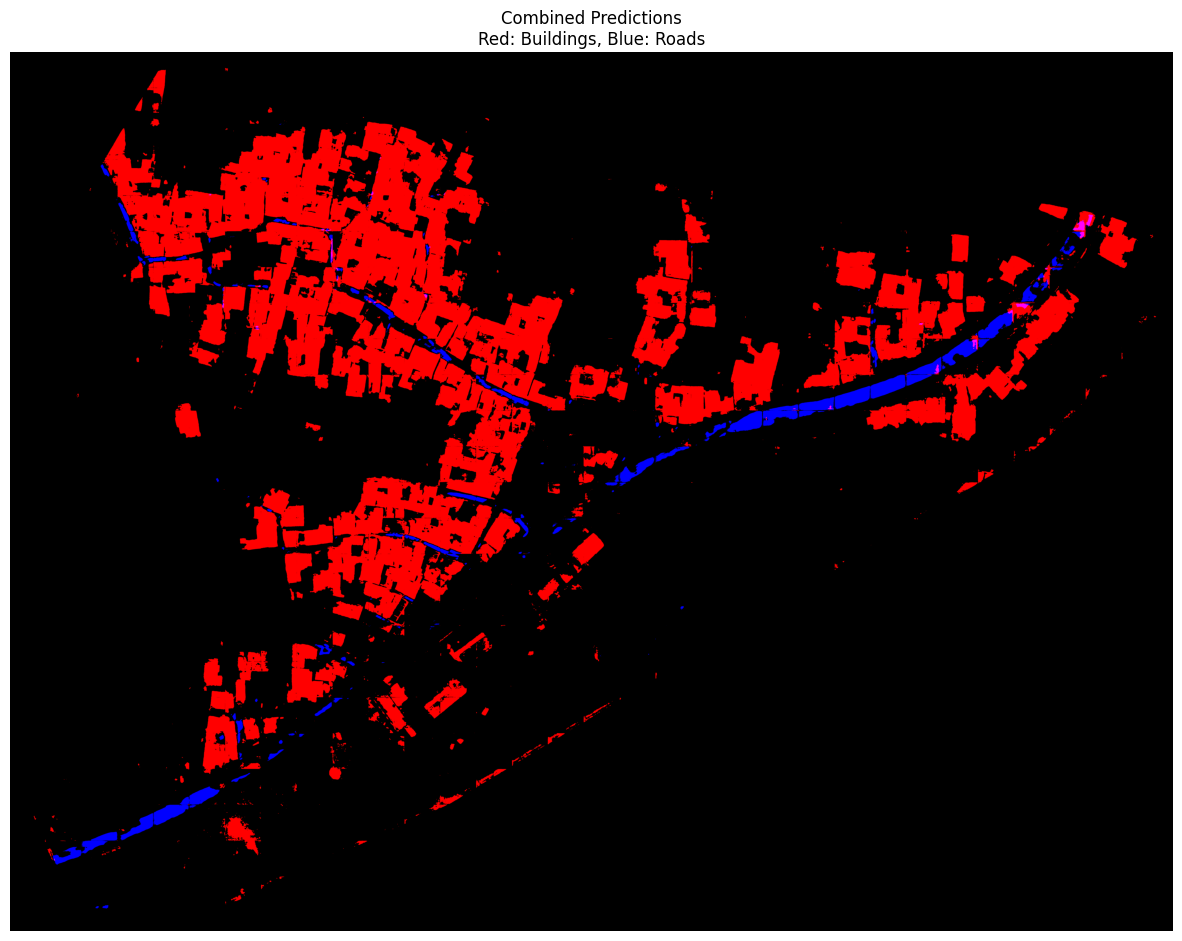


All steps completed successfully!


In [16]:
# Create patches from the TIFF image and masks
print("\nStep 1: Creating patches for training...")
os.makedirs('/kaggle/working/patches/roads', exist_ok=True)
os.makedirs('/kaggle/working/patches/buildings', exist_ok=True)

create_patches(tiff_image_path, output_road_mask_path, 
              '/kaggle/working/patches/roads')
create_patches(tiff_image_path, output_building_mask_path, 
              '/kaggle/working/patches/buildings')

# Create datasets and dataloaders
print("\nStep 2: Setting up data loaders...")
roads_dataset = GISDataset('/kaggle/working/patches/roads')
buildings_dataset = GISDataset('/kaggle/working/patches/buildings')

batch_size = 2  # Small batch size for memory efficiency
roads_loader = DataLoader(roads_dataset, batch_size=batch_size, 
                        shuffle=True, num_workers=2)
buildings_loader = DataLoader(buildings_dataset, batch_size=batch_size, 
                            shuffle=True, num_workers=2)

# Initialize and train models
print("\nStep 3: Training road detection model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Road model
road_model = ResUNet(in_channels=3, out_channels=1).to(device)
criterion = TverskyLoss(alpha=0.7, beta=0.3)  # Weight false negatives more for thin features like roads
optimizer = torch.optim.Adam(road_model.parameters(), lr=0.001)

# Training
train_model(road_model, roads_loader, criterion, optimizer, device, num_epochs=50)
torch.save(road_model.state_dict(), '/kaggle/working/road_model.pth')

# Building model
print("\nStep 4: Training building detection model...")
building_model = ResUNet(in_channels=3, out_channels=1).to(device)
criterion = TverskyLoss(alpha=0.5, beta=0.5)  # Equal weighting for buildings
optimizer = torch.optim.Adam(building_model.parameters(), lr=0.001)

# Training
train_model(building_model, buildings_loader, criterion, optimizer, device, num_epochs=50)
torch.save(building_model.state_dict(), '/kaggle/working/building_model.pth')

# Generate combined prediction
print("\nStep 5: Generating combined prediction...")
combined_result = predict_and_combine(
    road_model, 
    building_model, 
    tiff_image_path, 
    device
)

# Visualize results
plt.figure(figsize=(15, 15))
plt.imshow(combined_result)
plt.title('Combined Predictions\nRed: Buildings, Blue: Roads')
plt.axis('off')
plt.savefig('/kaggle/working/combined_prediction_visualization.png')
plt.show()

print("\nAll steps completed successfully!")


Step 5: Generating combined prediction...


100%|██████████| 32/32 [01:11<00:00,  2.22s/it]


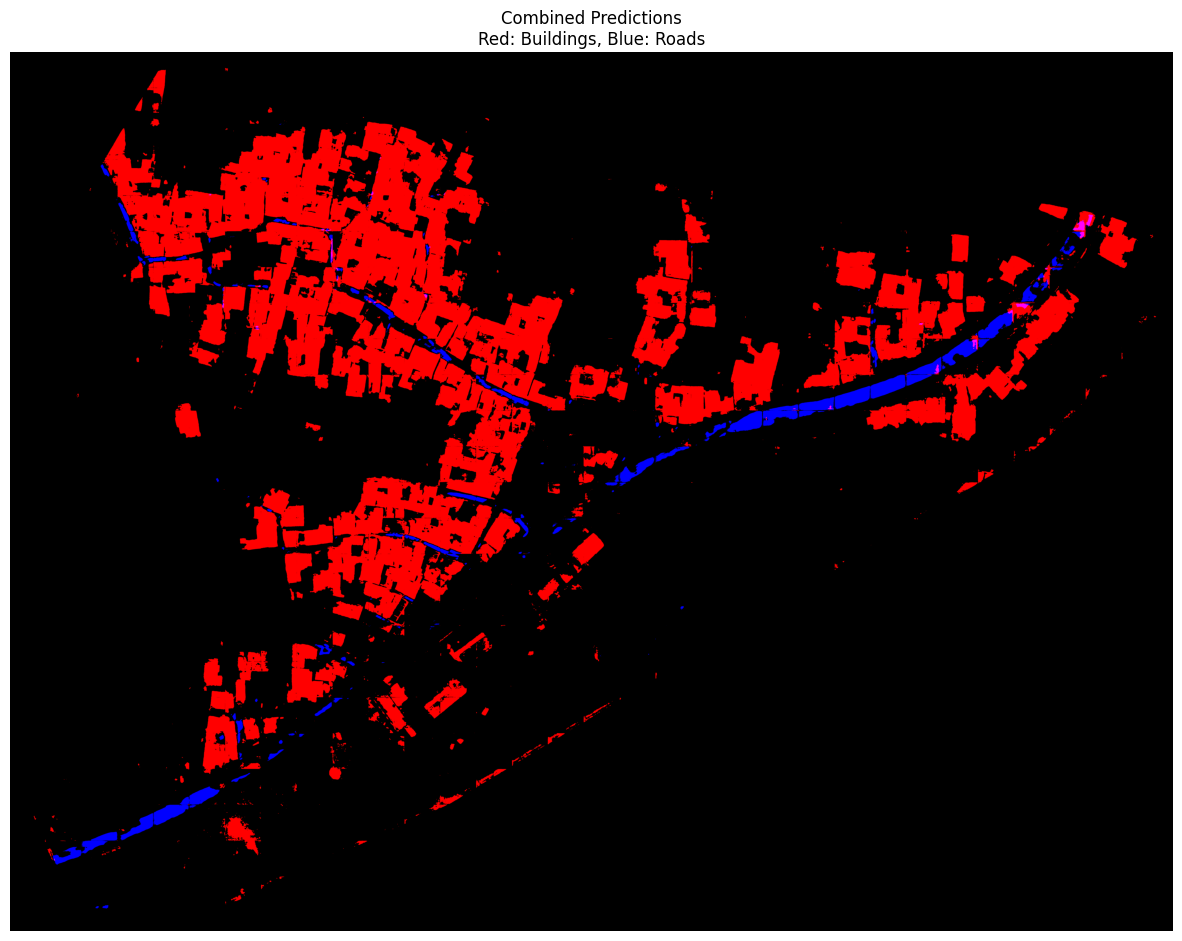

In [18]:
print("\nStep 5: Generating combined prediction...")
combined_result = predict_and_combine(
    road_model, 
    building_model, 
    tiff_image_path, 
    device
)

# Visualize results
plt.figure(figsize=(15, 15))
plt.imshow(combined_result)
plt.title('Combined Predictions\nRed: Buildings, Blue: Roads')
plt.axis('off')
plt.savefig('/kaggle/working/combined_prediction_visualization.png')
plt.show()
